# Make predictions with existing models

This notebook demonstrates how to make predictions of surface temperature and luminosity from absolute magnitude in the three *Gaia* photometric bands, as well as how to make predictions of age and mass from those surface parameters. 

In [1]:
# IMPORT LIBRARIES

import random as rn
import numpy as np
import math as mt

import matplotlib.pyplot as plt
from matplotlib import cm
#from mpl_toolkits import mplot3d
%matplotlib inline

import pylab as pl
import sys
#from matplotlib.pyplot import cm
#import glob
import pandas as pd

#from astropy.table import Table

#import torch
#import torch.nn as nn
import StelNet as st

# Estimating Surface Parameters $T_{\rm{eff}}$ and $L$

In [11]:
# gather data
dh = pd.read_csv("Data/DH_data_with_photometry_for_demo.csv")

# drop nans from columns we will want to use in this notebook
dh = dh[["M_G_ext", "M_bp_ext", "M_rp_ext","logTeff","logLum","logAge","logMass"]].dropna()

# grab only inputs to the photometry neural networks
dh_x_phot = dh[["M_G_ext","M_bp_ext","M_rp_ext"]].values.astype(float)

now we can use `st.predict_surface_params()` to estimate temperature and luminosity, and visualize the result

In [12]:
dh_teff_lum_pred = st.predict_surface_params(dh_x_phot)

Text(0.5, 0, 'D&H reported log(L/Lsun)')

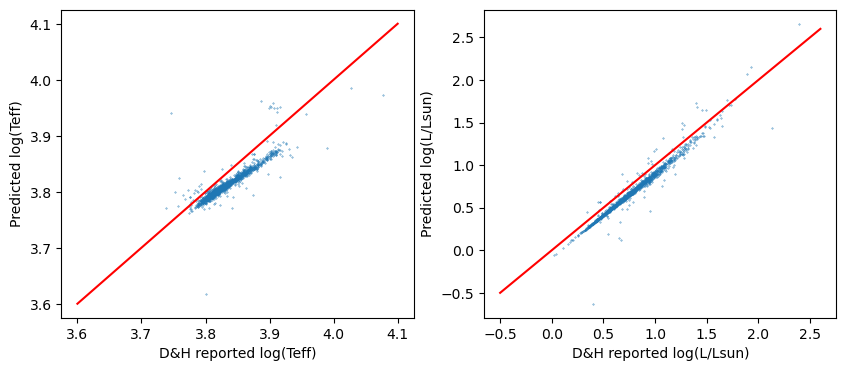

In [13]:
# plot predicted vs true value for temperature and luminosity below
dh_teff_pred = dh_teff_lum_pred[:,0]
dh_lum_pred = dh_teff_lum_pred[:,1]

fig, [ax1,ax2] = plt.subplots(1,2,figsize=[10,4])
ax1.scatter(dh["logTeff"], dh_teff_pred,s=.1)
ax2.scatter(dh["logLum"], dh_lum_pred,s=.1)

teff_rng=[3.6,4.1]
lum_rng = [-0.5,2.6]
ax1.plot(teff_rng,teff_rng,c='r')
ax2.plot(lum_rng,lum_rng,c='r')

ax1.set_ylabel("Predicted log(Teff)")
ax1.set_xlabel("D&H reported log(Teff)")

ax2.set_ylabel("Predicted log(L/Lsun)")
ax2.set_xlabel("D&H reported log(L/Lsun)")

^ clearly there are systematic differences between the Payne and the surface parameter estimation method from D&H--this leads to increased differences in StelNet's prediction of age and mass compared to that reported by D&H if we pass `dh_teff_lum_pred` through `st.predict_age_mass()` compared to if we used temperature and luminosity estimates from D&H as inputs for the second half of StelNet (see below). First, let's pass the output of `predict_surface_params()` to `predict_age_mass()`:

Text(0, 0.5, 'Predicted mass')

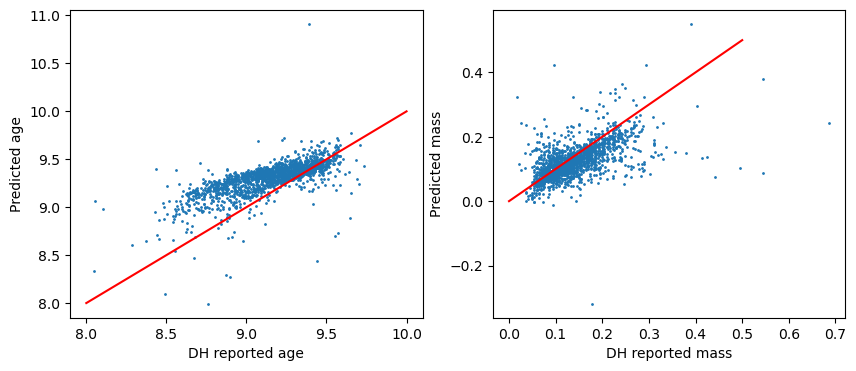

In [18]:
# this half of the model is more complex (full demonstrations in the next section)
# specify number of bootstraps
num_NNs = 20
y_pre, y_post=st.predict_age_mass(dh_teff_lum_pred, n=num_NNs, TL="reu2023")

# we know the D&H stars are post-ZAMS, use stats() to find the mean age and mass estimates:
y_mean_postMS, y_std_postMS = st.stats(y_post)

# plot the result for age
fig, [ax1,ax2] = plt.subplots(1,2,figsize=[10,4])

dh_age_pred = y_mean_postMS[:,0]
dh_mass_pred = y_mean_postMS[:,1]

ax1.scatter(dh['logAge'],dh_age_pred,s=1)
ax2.scatter(dh['logMass'],dh_mass_pred,s=1)

age_rng=[8,10]
mass_rng=[0,.5]
ax1.plot(age_rng,age_rng,c='r')
ax2.plot(mass_rng,mass_rng,c='r')

ax1.set_xlabel("DH reported age")
ax1.set_ylabel("Predicted age")
ax2.set_xlabel("DH reported mass")
ax2.set_ylabel("Predicted mass")

# Estimateing Age and Mass from $T_{\rm{eff}}$ and $L$

Below we go into more detail about using the second half (age/mass estimation) of StelNet, using existing catalogs of temperature and luminosity to make the predictions, rather than the ones we estimated from photometry.

## David & Hillenbrand 2015 dataset (Post-ZAMS)

### Load Data

In [4]:
# Data with columns log(Teff [K]) and log(L [L_sun])

data_raw = pd.read_csv('Data/postZAMS/DH.csv') 
df = pd.DataFrame(data_raw)
df['teff_log'] = np.log10(df['Teff'].astype(float))
df['lum_log'] = np.log10(df['lum_val'].astype(float))

df['ageyr'] = df['Ageavg']*1e+6
df['logAge'] = np.log10(df['ageyr'])
df['logMass'] = np.log10(df['Mavg'])

Data = df[['teff_log','lum_log', 'logAge', 'logMass']].dropna().astype(float)


data_x = Data[['teff_log','lum_log']]
data_y = Data[['logAge','logMass']]
#data_y = df[['logAge','logMass']].dropna().astype(float)
#Data = df[['teff_log','lum_log']].dropna().astype(float)

In [5]:
# Convert DataFrame to numpy array and make a copy

data = data_x.values.astype('float')
data_0 = np.copy(data)

### Chose number of Neural Networks to be trained for each model (bootstraps)

In [6]:
num_NNs = 20

### Predict

Predict with a number (num_NNs, default is 20) of neural networks (NNs) for both the pre-ZAMS and the post-ZAMS models. Use st.predict, with inputs being the data, with columns log(Teff [K]) and log(L [L_sun]), number of NNs, how many boostrap'ed NNs to train for each model and, optionally, TL, which is the transfer learning flag. TL = none is the default and corresponds to the baseline model (trained using MIST evolutionary tracks), and TL = 'reu2023' coorresponds to the model after performing transfer learning with all of the datasets in this section (see `/Data/postZAMS/source_catalogues` and `/Data/preZAMS/source_catalogues`).  

In [7]:
y_pre, y_post= st.predict_age_mass(data, n=num_NNs, TL='reu2023')

In [8]:
y_pre

array([[[7.22170905, 0.15946319],
        [7.32802631, 0.14782049],
        [7.37665933, 0.11765459],
        ...,
        [7.39772206, 0.09067029],
        [7.1175479 , 0.21271003],
        [7.21710078, 0.17053864]],

       [[7.28935452, 0.12074511],
        [7.40099946, 0.11347456],
        [7.43155787, 0.08205117],
        ...,
        [7.42147013, 0.06483623],
        [7.20026469, 0.17539866],
        [7.29153299, 0.13654815]],

       [[6.96658852, 0.2031387 ],
        [7.08779281, 0.19635239],
        [7.13209547, 0.16318105],
        ...,
        [7.17415978, 0.12823555],
        [6.87415086, 0.25523365],
        [6.9772856 , 0.2139183 ]],

       ...,

       [[7.19614981, 0.16006235],
        [7.26991489, 0.15990681],
        [7.34234996, 0.1246124 ],
        ...,
        [7.37778315, 0.09958682],
        [7.05941919, 0.21107182],
        [7.16808444, 0.1779523 ]],

       [[7.35376098, 0.13909111],
        [7.46435421, 0.12457468],
        [7.50783499, 0.08912493],
        .

### Statistics on the predictions for each model (pre and post ZAMS)

Compute the mean and standard deviations from the (num_models) predictions using st.stats that takes the predictions as arguments.

In [9]:
y_mean_preMS, y_std_preMS = st.stats(y_pre)
y_mean_postMS, y_std_postMS = st.stats(y_post)

### PLOT y_mean vs data_y here

In [10]:
len(y_mean_postMS[:,0])

1869

In [11]:
len(data_y['logAge'])

1869

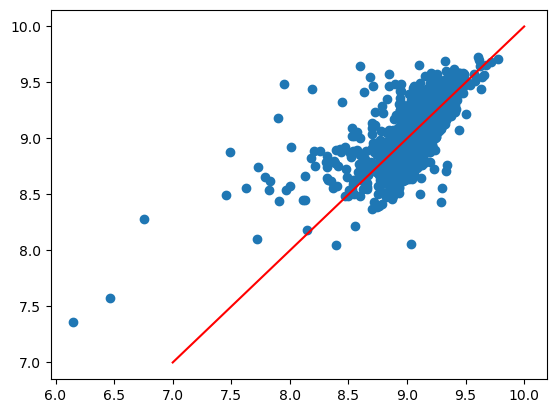

In [12]:
fig, ax = plt.subplots()

x = y_mean_postMS[:,0] # predicted
y = data_y['logAge']

ax.scatter(x,y)

z = np.linspace(7,10,2)
ax.plot(z,z,color='r')

In [13]:
np.shape(y_mean_preMS)

(1869, 2)

### Mixture of models

Calculate relative probabilities for pre and post-ZAMS models using st.pis that takes as arguments the the means calculated in the previous cell. This function uses Galactic population abundancies and the Initial Mass Function. See StelNet paper for more details (Garraffo et al, 2021)

In [11]:
pi_pre, pi_post = st.pis(y_mean_preMS, y_mean_postMS)

In [12]:
pi_pre

array([0.00498557, 0.00795511, 0.00783512, ..., 0.00504549, 0.00533013,
       0.00562863])

### Get posterior distributions

Use st.posteriors to get the posterior distributions. Arguments are predictions with each model (num_NNs predictions for each), the relative probabilities of each model, calculated on the previous cell, and the number of trained NNs for each pre and post-ZAMS models. n_NNs is optional and the default is 20.

In [13]:
y_post = st.posteriors(y_pre , y_post, pi_pre, pi_post, n=num_NNs)

The shape of the posterior distribution should be (num_models, numb of data points, 2). The 2 corresponds to predictions on log(age) and log(mass) 

In [14]:
y_post.shape

(20, 1869, 2)

Plot posterior distributions (over the y axis) for a subset of data points. In this example we chose to plot a point every 80 datapoints.  The function st.plot_multiple_posteriors takes as arguments the posteriors computed two cells ago, and a list of observation id of the points to be plotted.

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='Observation id', ylabel='$\\log(mass)$ [$M_{\\odot}$]'>],
      dtype=object)

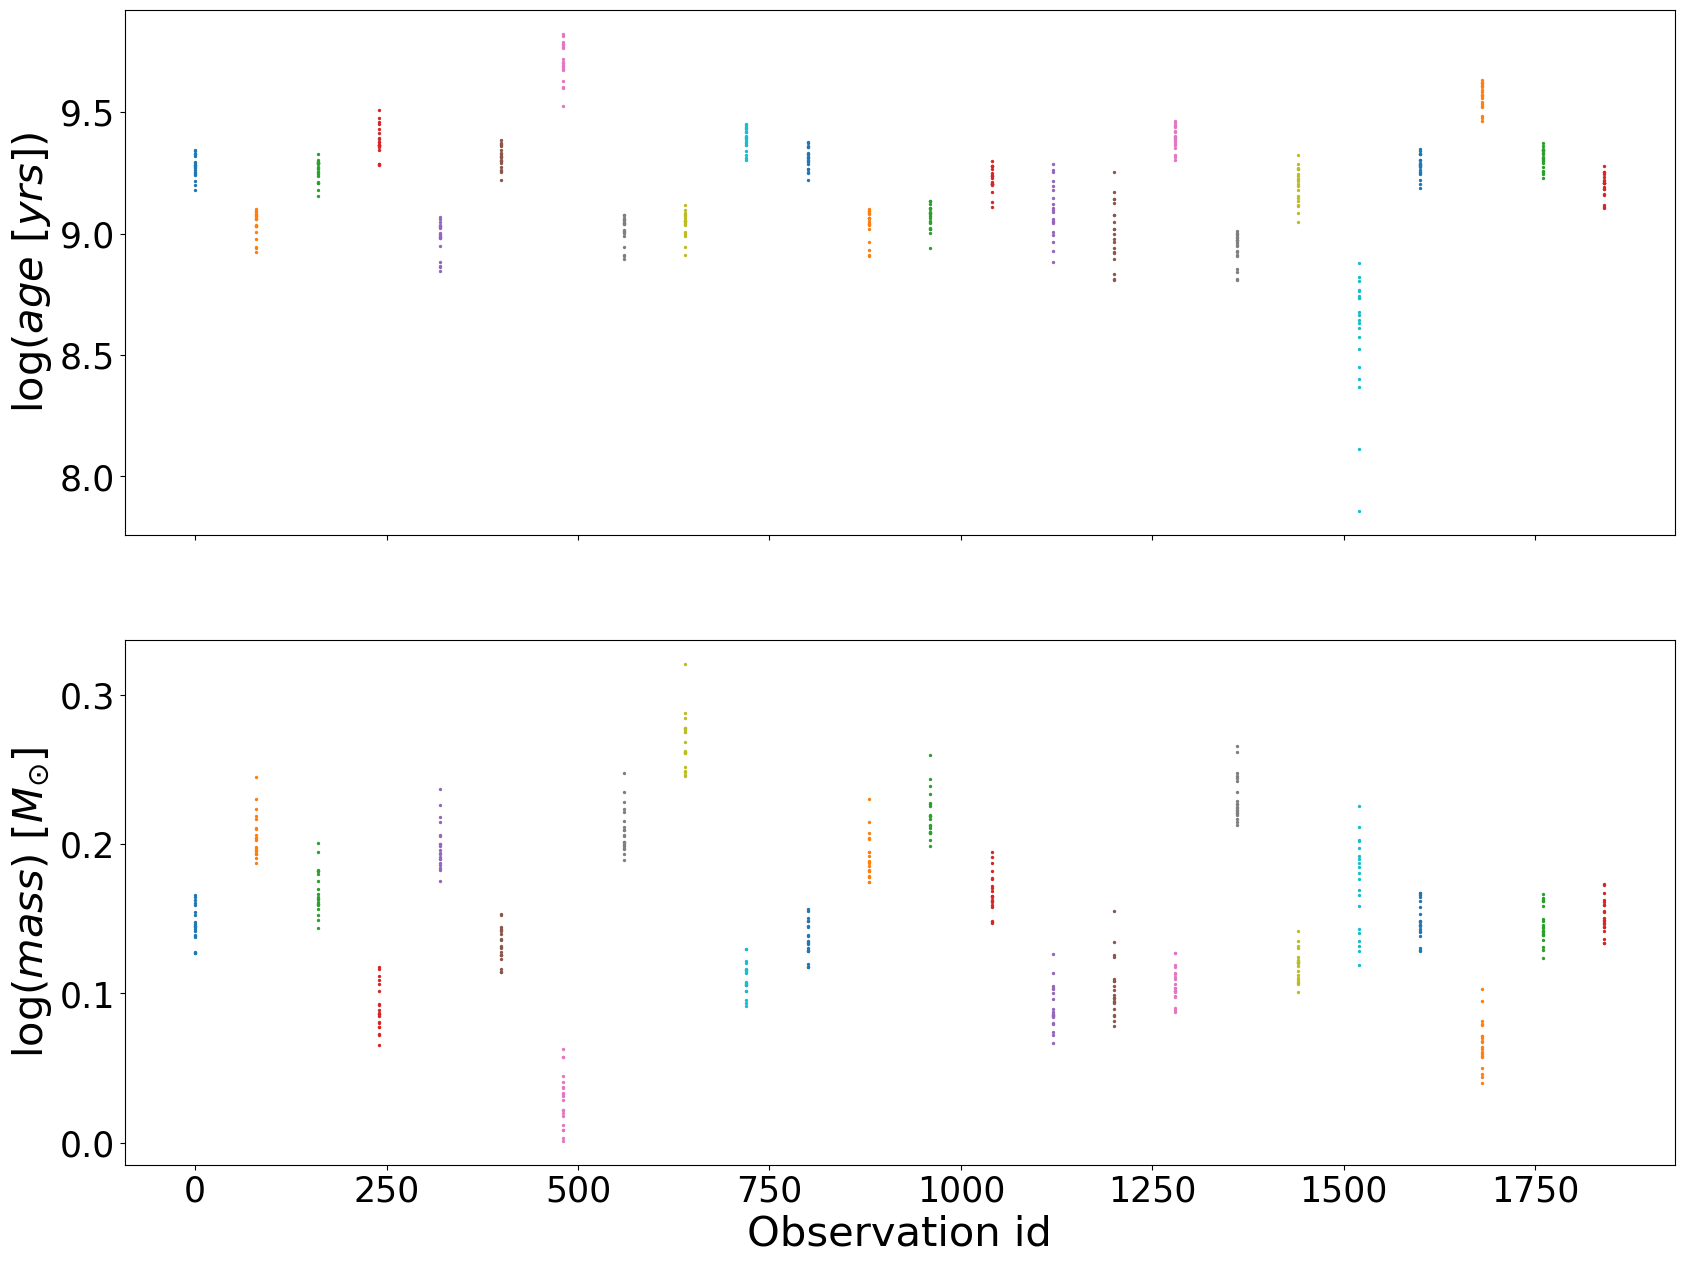

In [15]:
st.plot_multiple_posteriors(y_post, [i for i in range(0, data.shape[0], 80)])

Plot the posterior distribution (over the x axis) of a particular observation for log(age) and log(mass), in this example it is the data point number 15. The number of dots should be equal to the num_models. Use st.plot_posterior that takes as arguments the posteriors calculated before, and the observation id to be plotted. 

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='model number', ylabel='$\\log(mass \\ [M_{\\odot}])$'>],
      dtype=object)

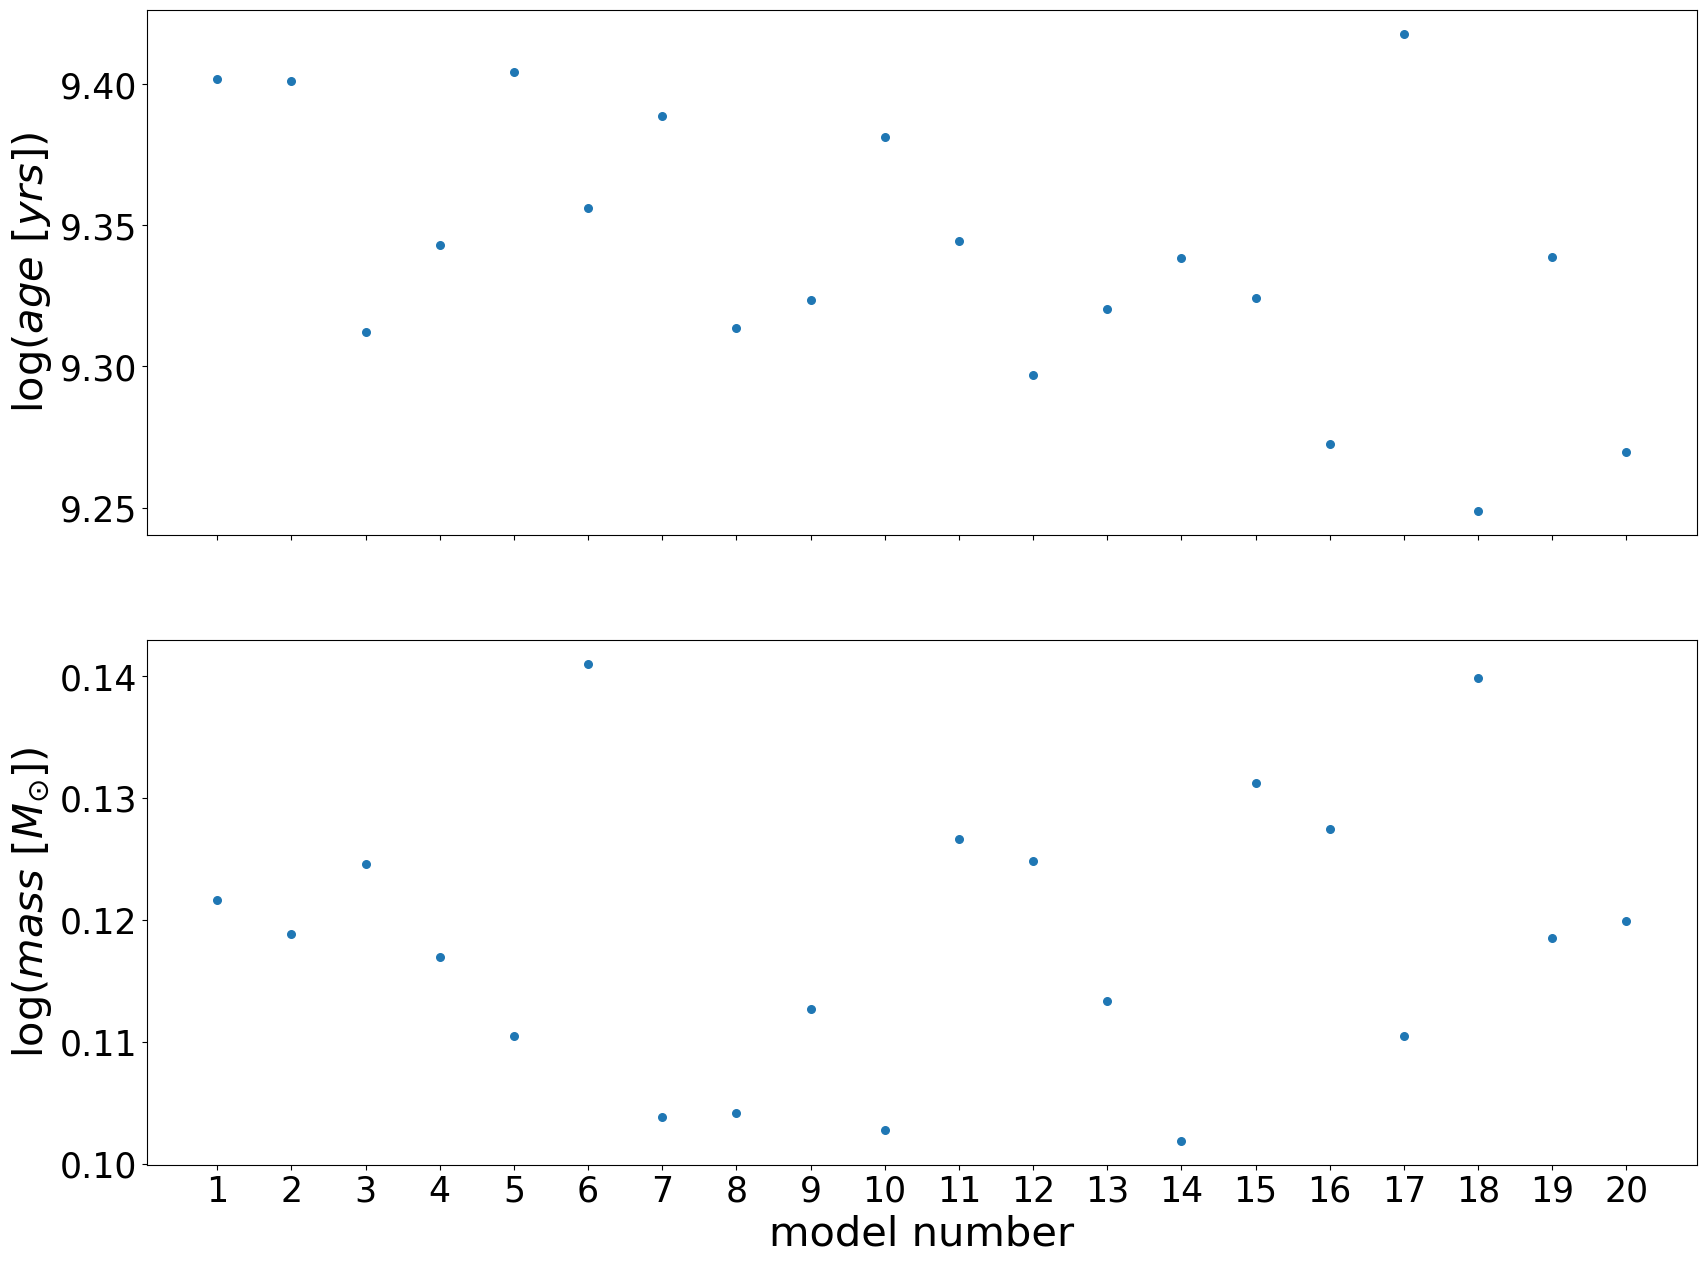

In [16]:
st.plot_posterior(y_post, 15)

array([<Axes: xlabel='$\\log(age \\ [yrs])$', ylabel='number of predictions'>,
       <Axes: xlabel='$\\log(mass \\ [M_{\\odot}])$'>], dtype=object)

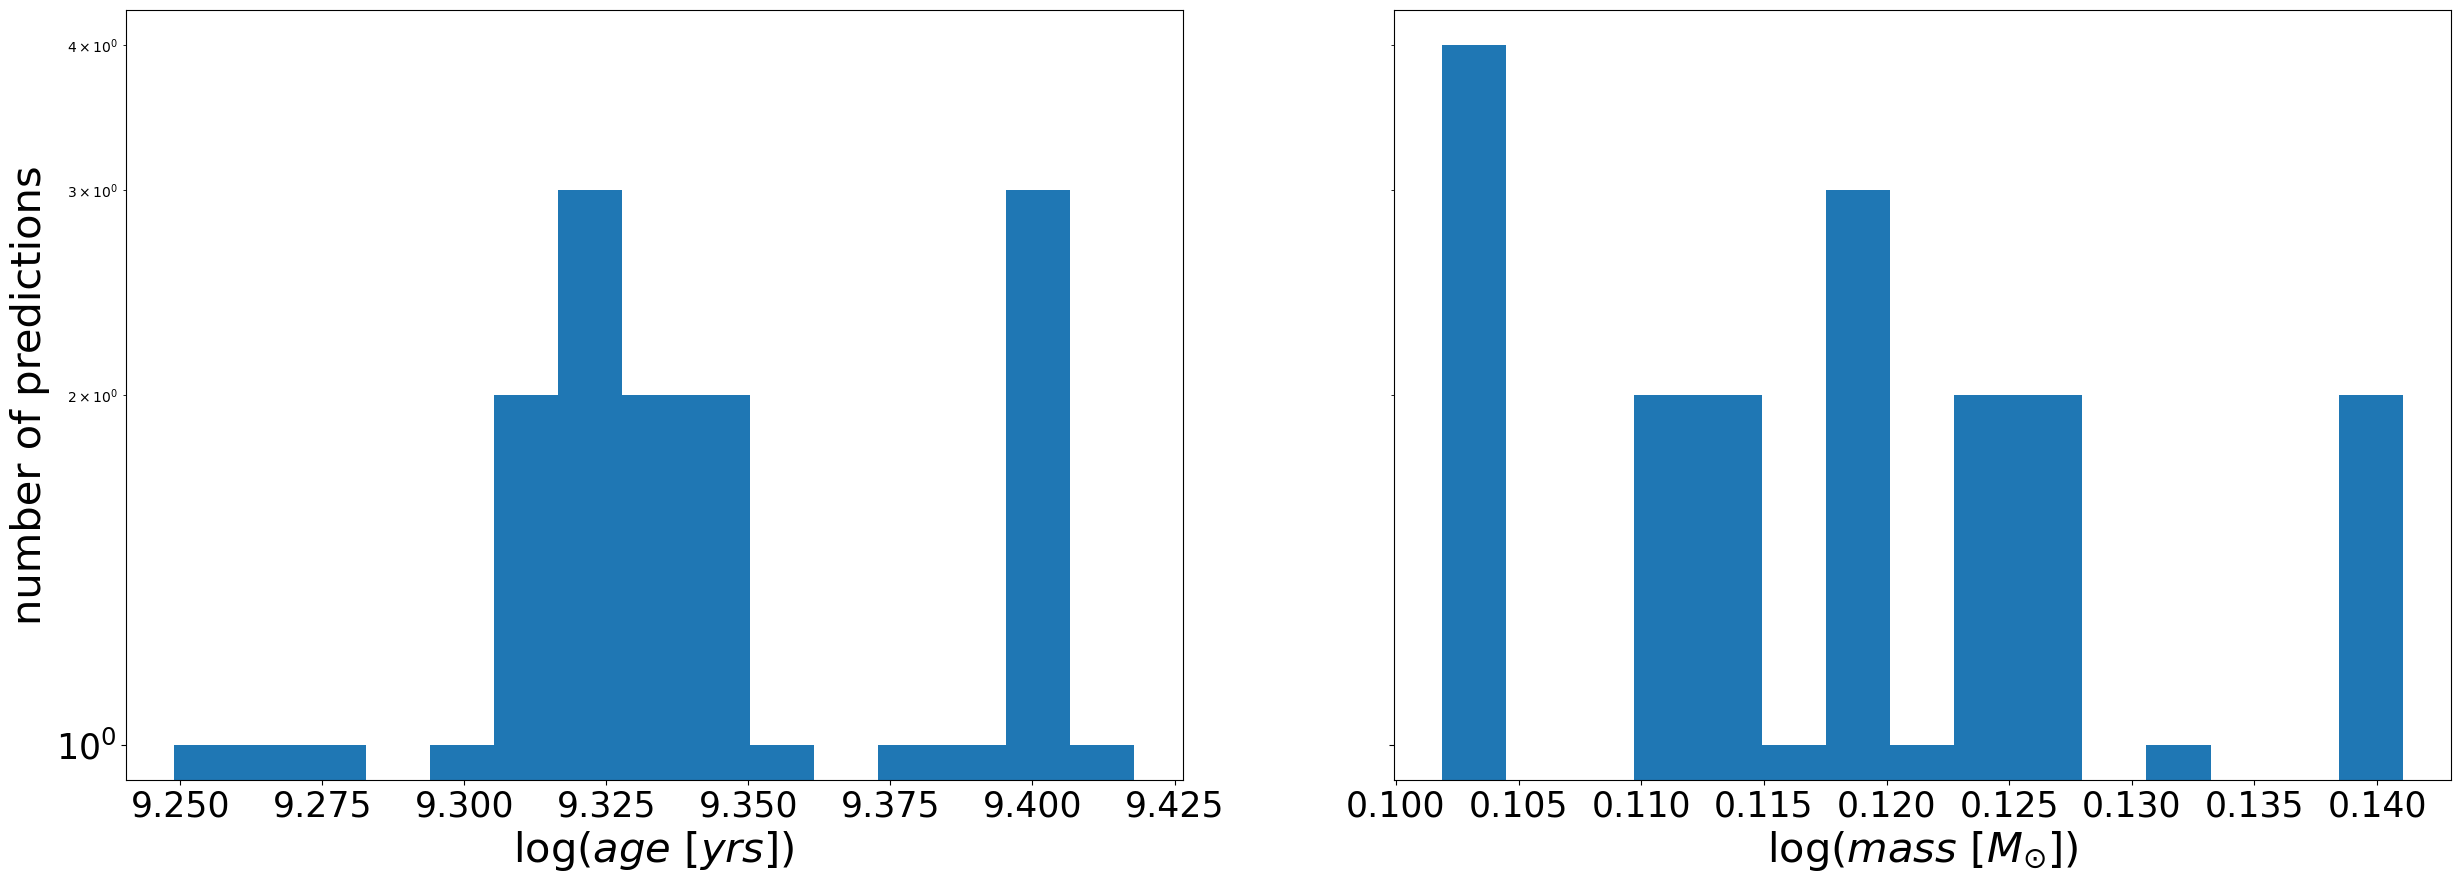

In [17]:
st.plot_posterior_hist(y_post, 15)

### Get Gaussian posterior distributions

If we want to get a continuous posterior distribution instead of discrete one with number of predictions as large as num_NNs, we can assume the posteriors are Gaussians with the same mean and std as the discrete posterior calculated before. Use for that st.Gaussian_posterior which takes as arguments the means and std from both pre and post-ZAMS, the relative probabilities, the number of data points, and the number of x values which controlls how many points from the resulting Gaussian will be returned (the larger this number, the smoother the Gaussian when plotted).

In [18]:
y_gaussian_posteriors=st.Gaussian_posteriors(y_mean_preMS, y_mean_postMS, y_std_preMS, y_std_postMS, pi_pre, pi_post, n_obs=data.shape[0], num_x_points=500)

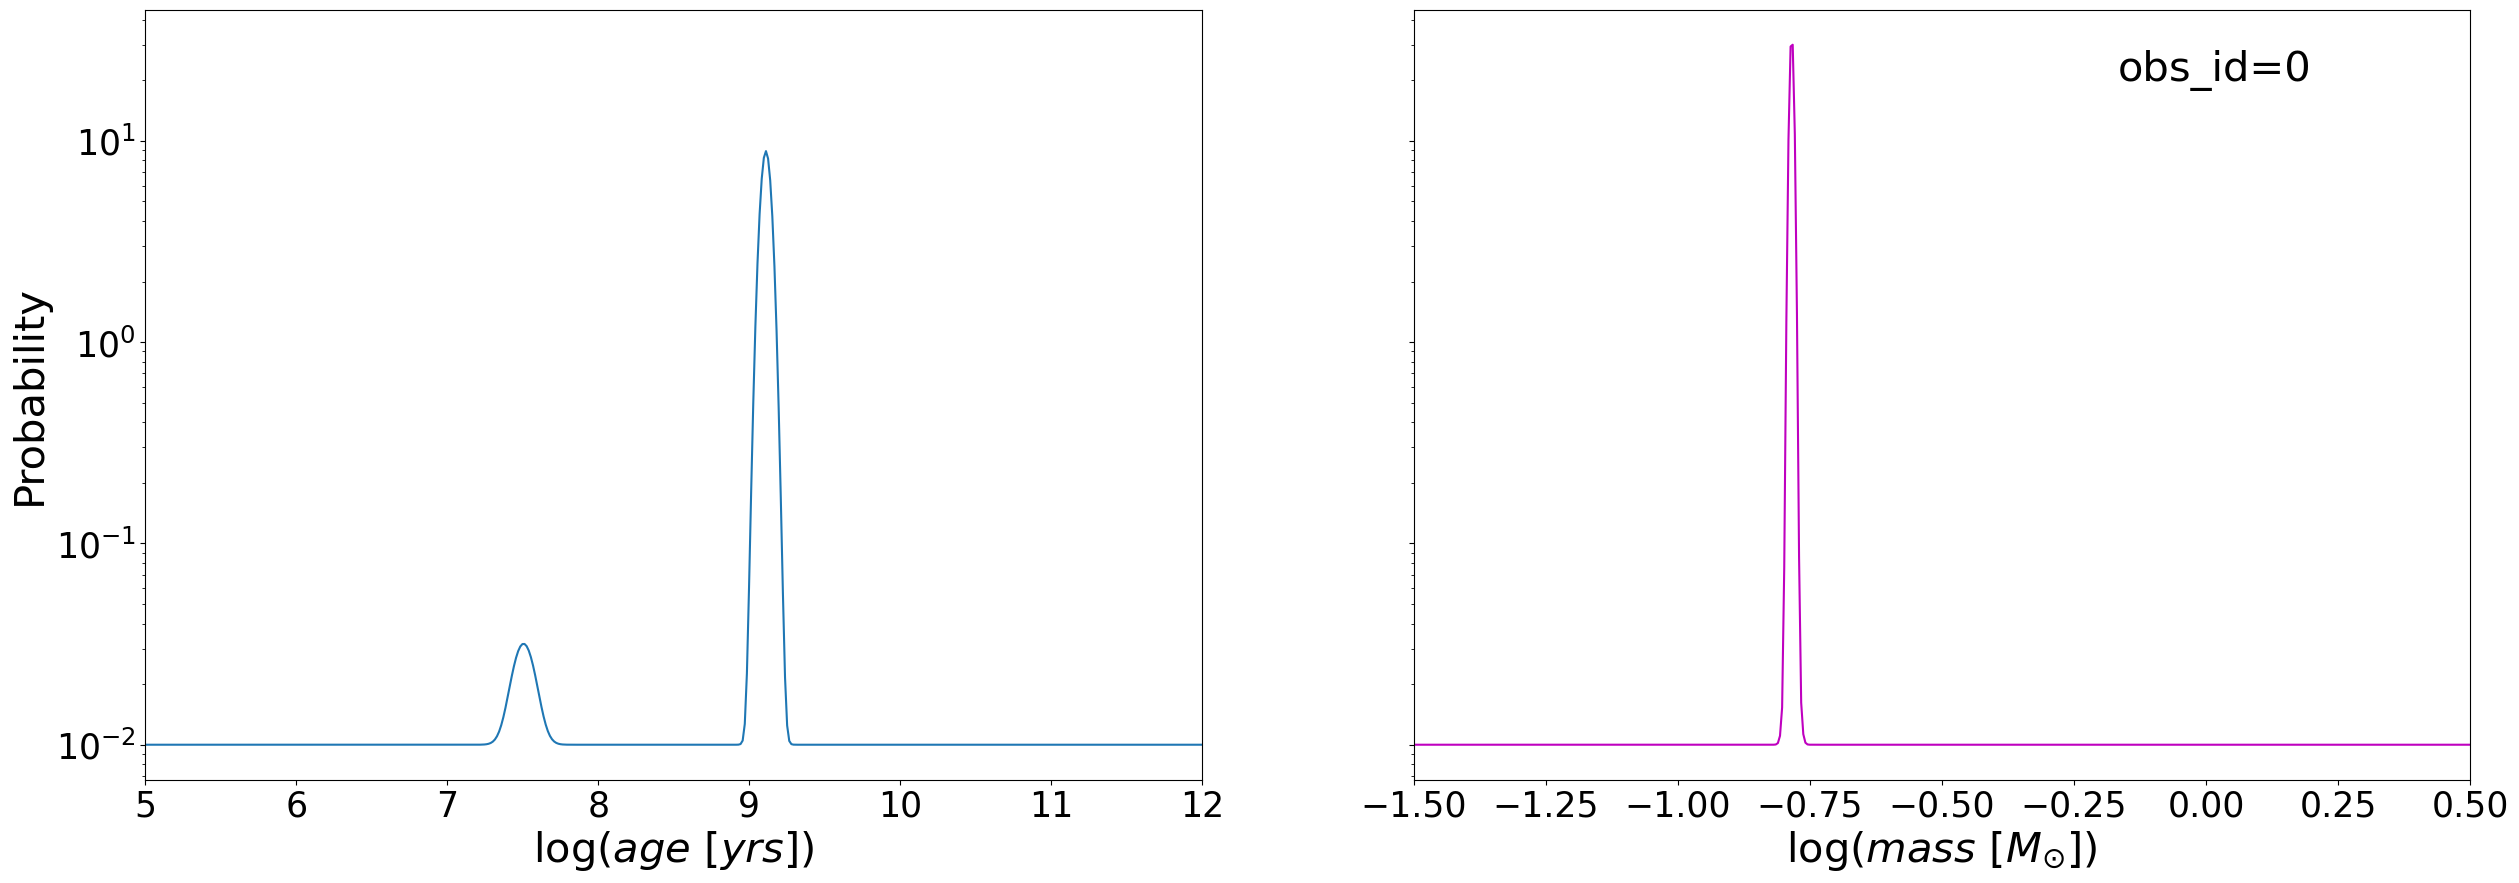

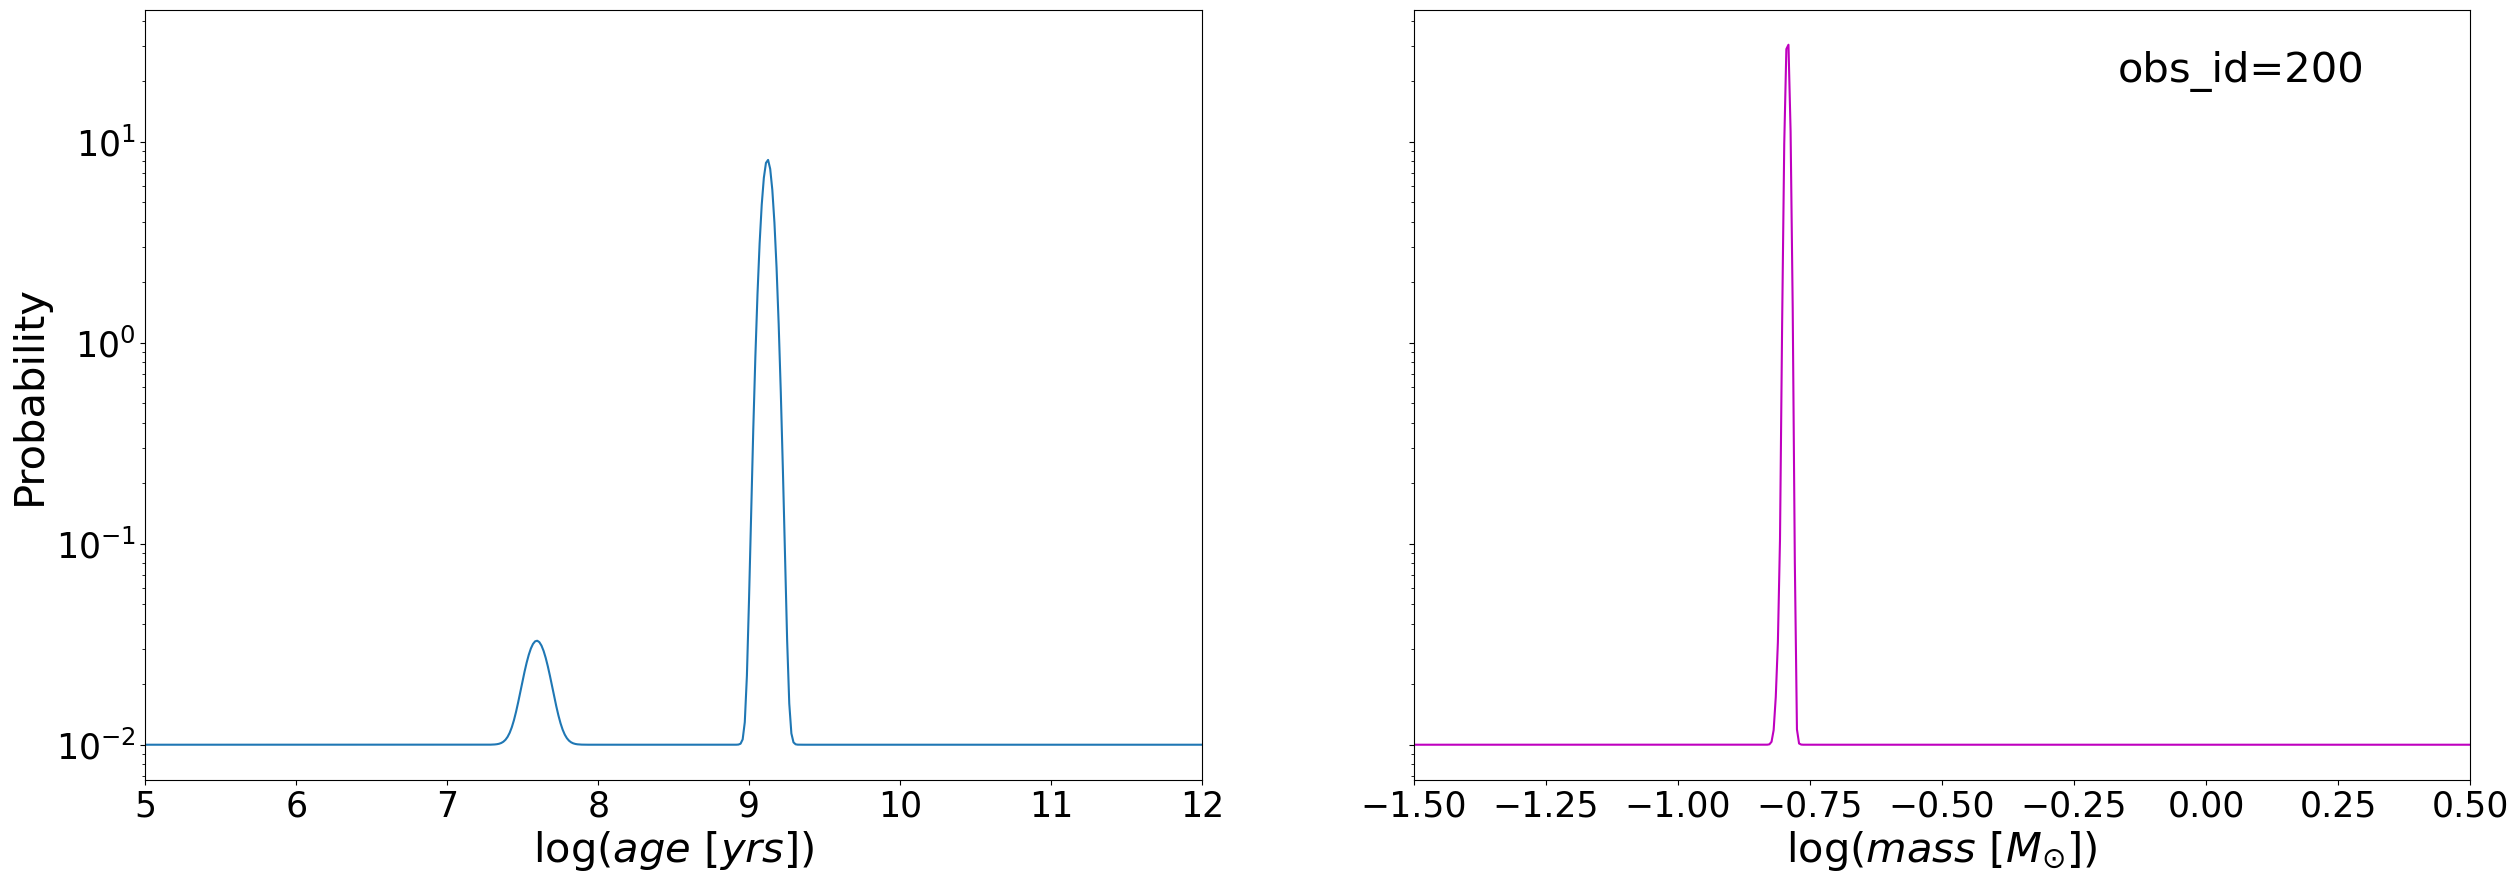

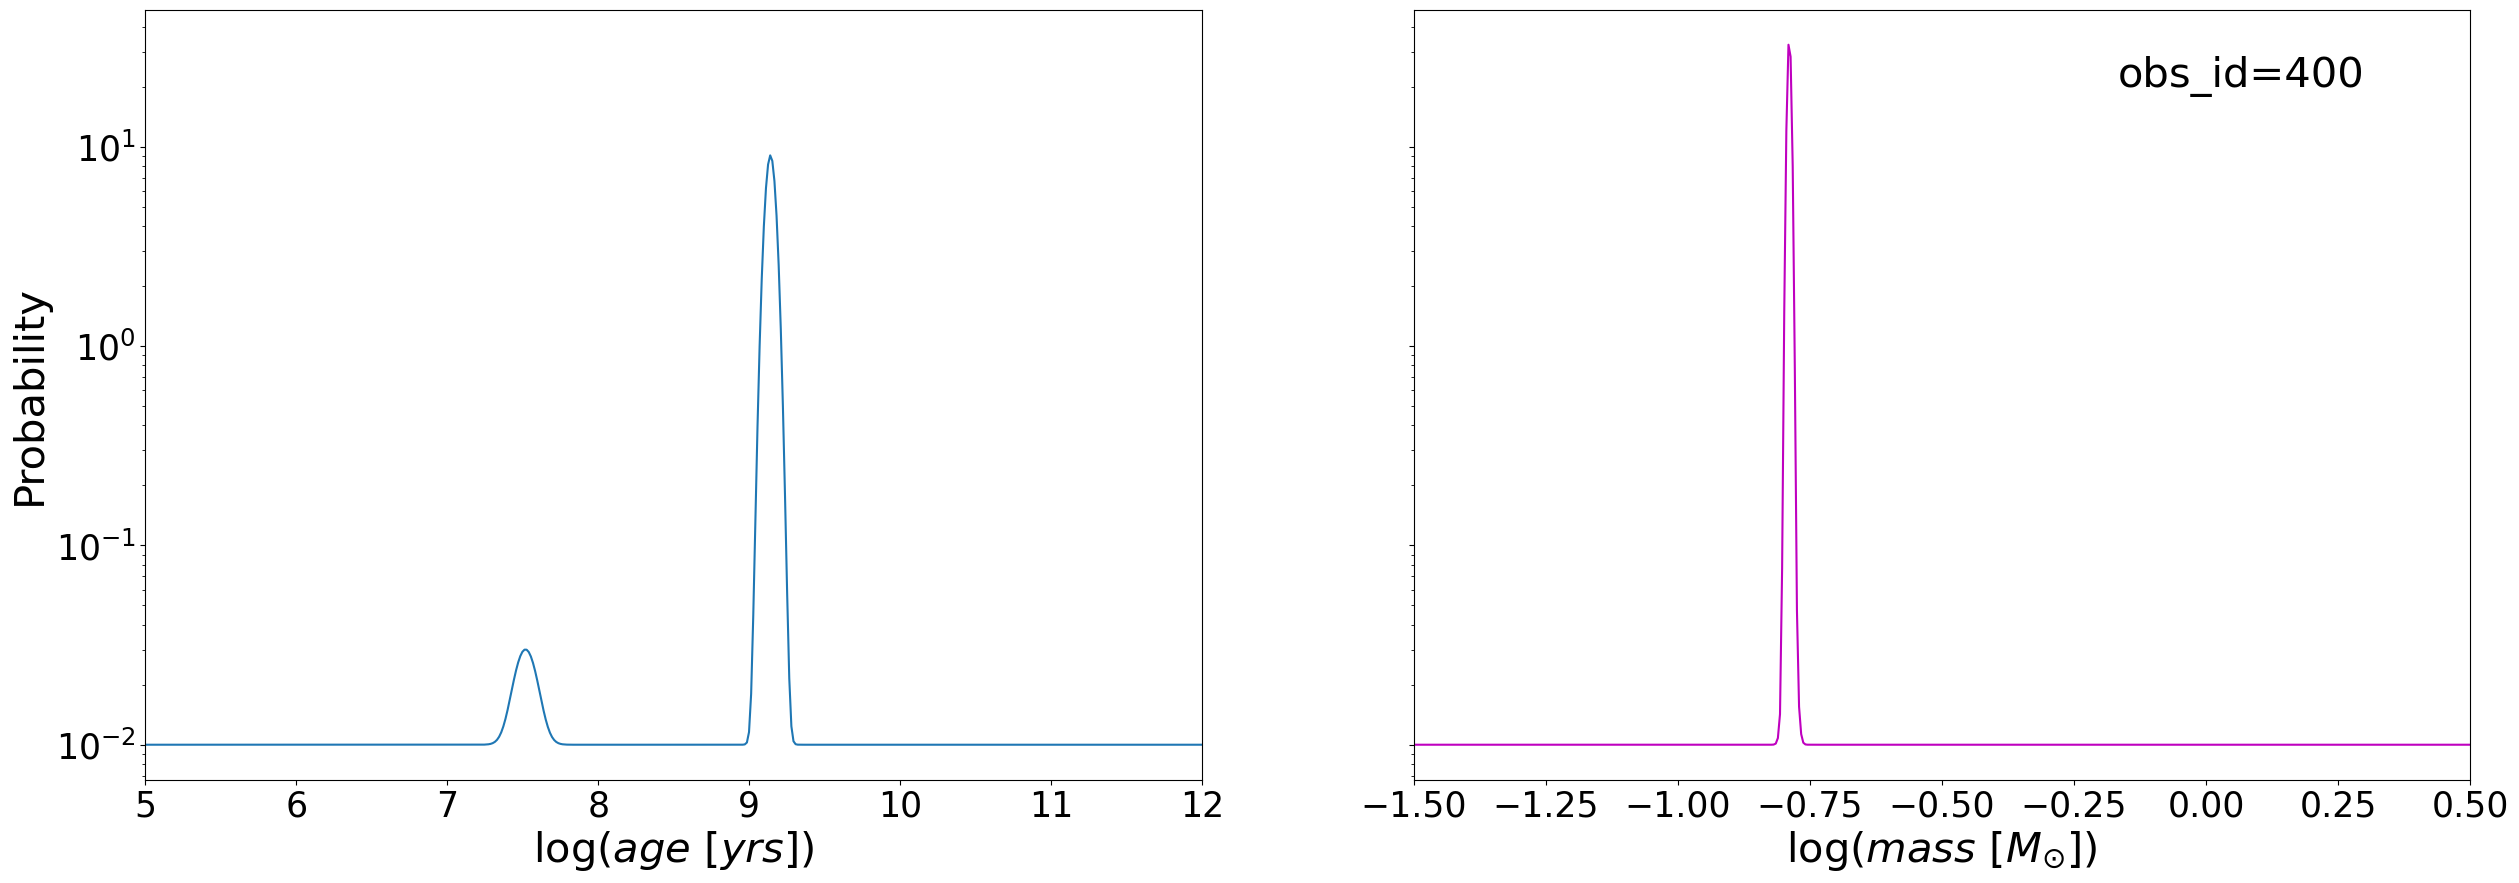

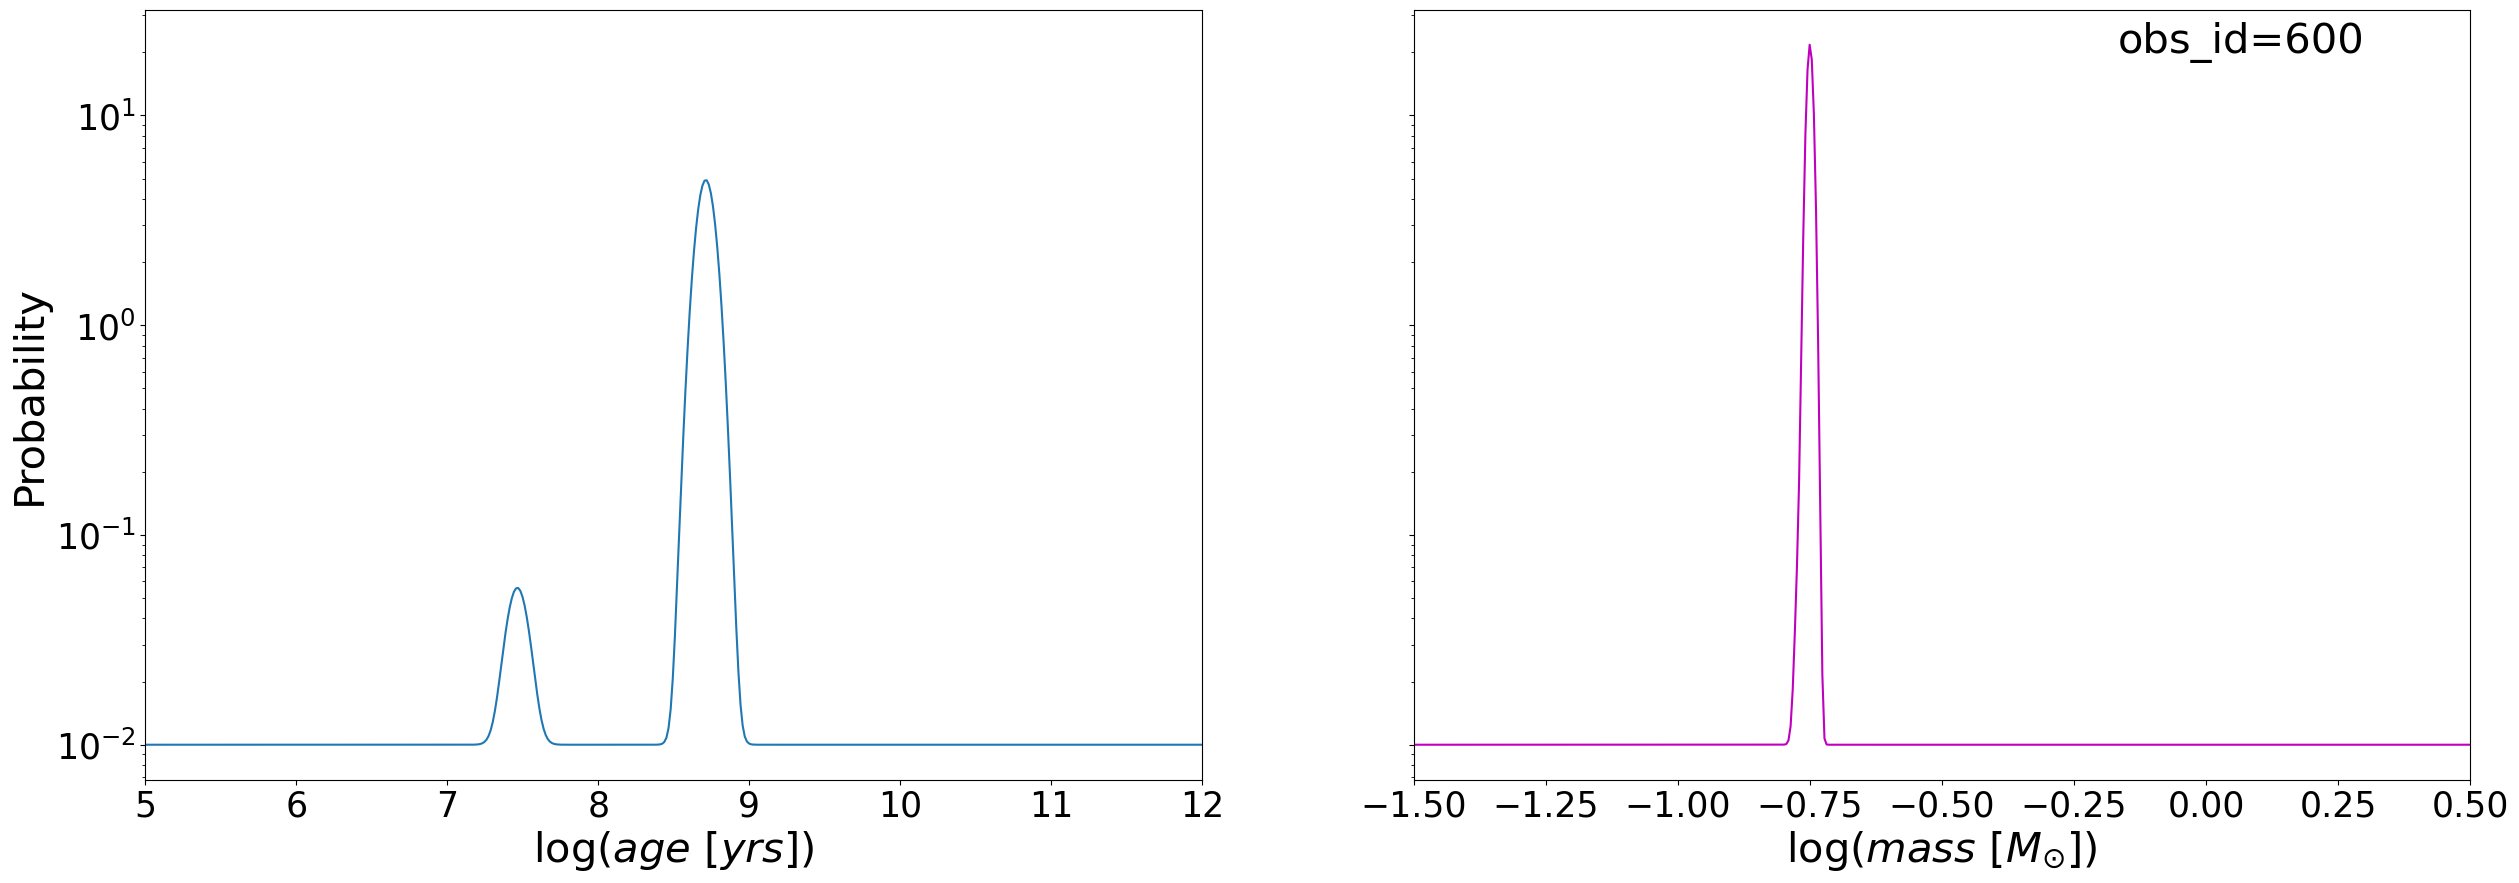

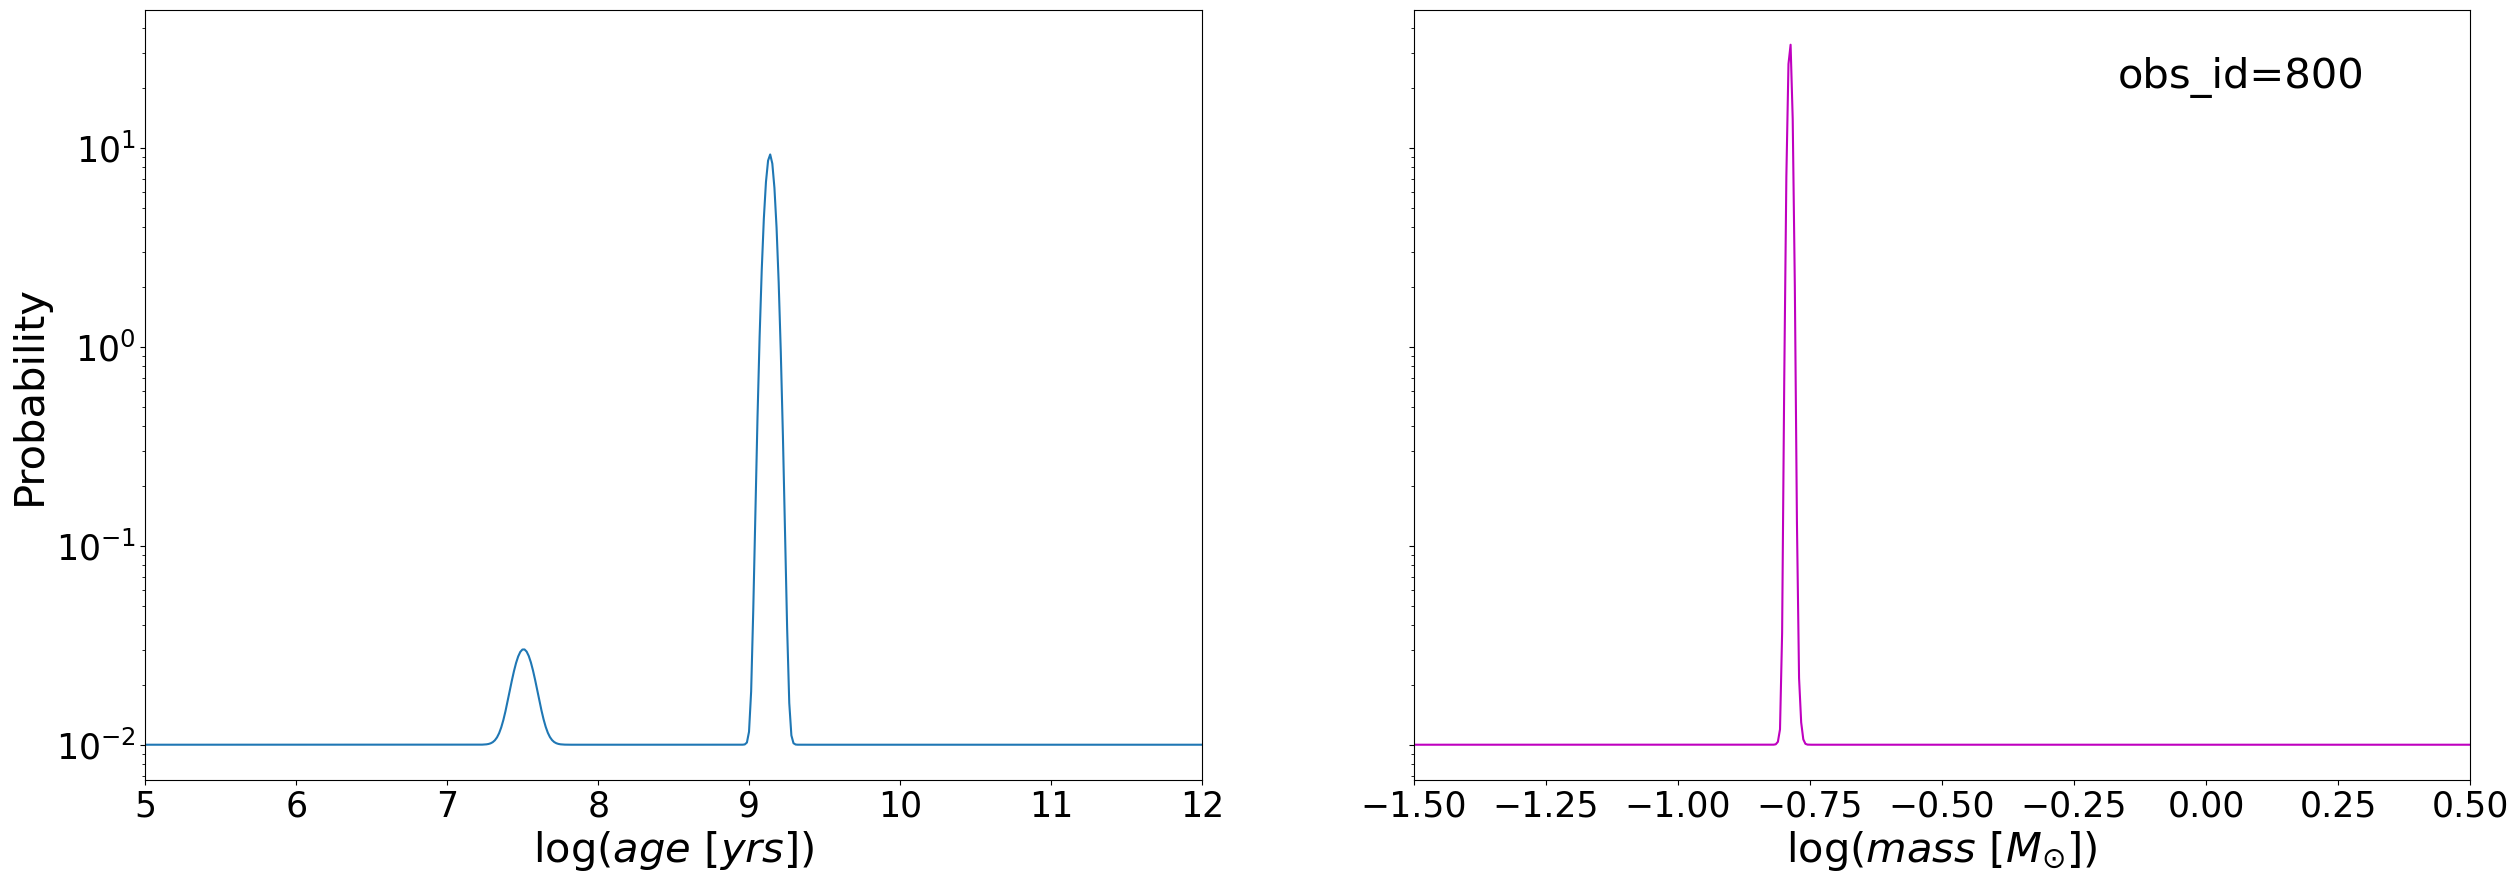

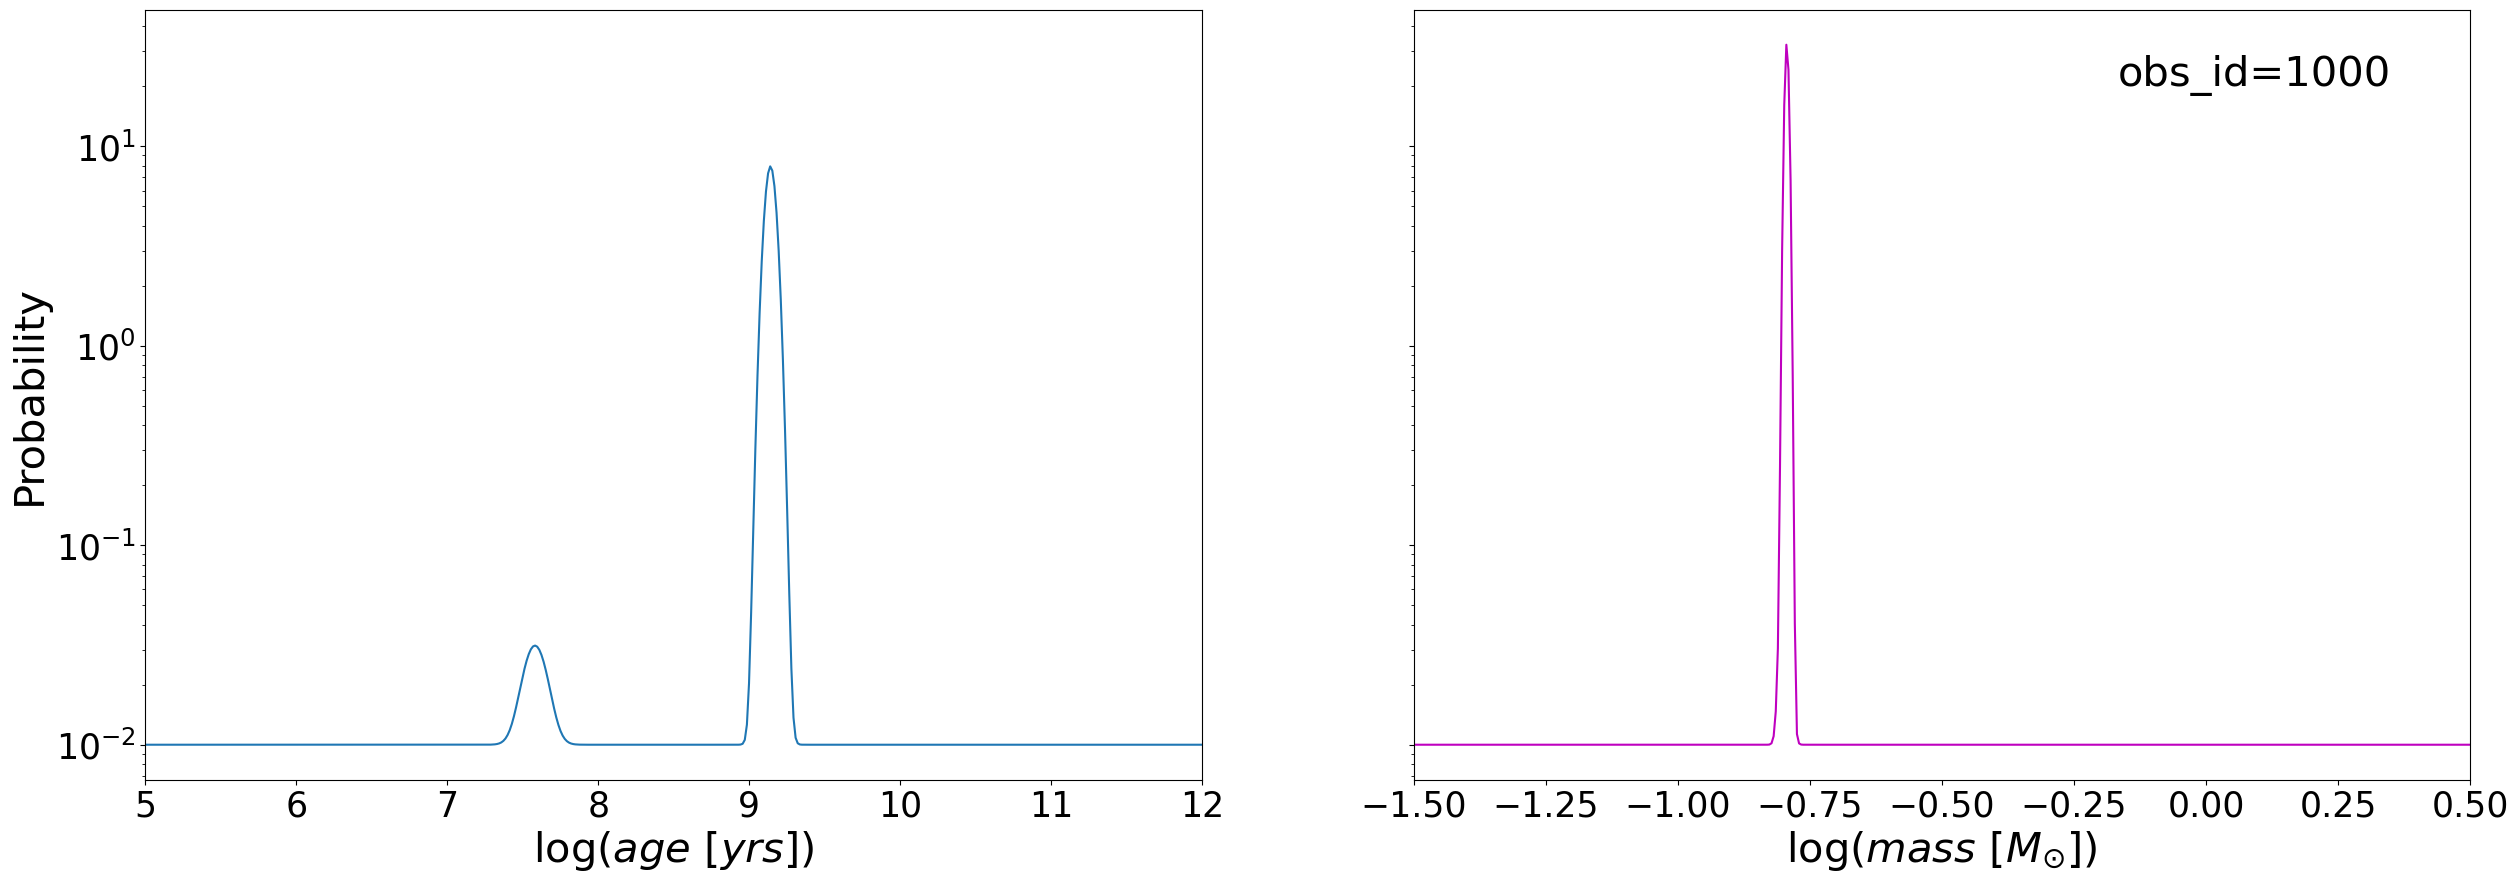

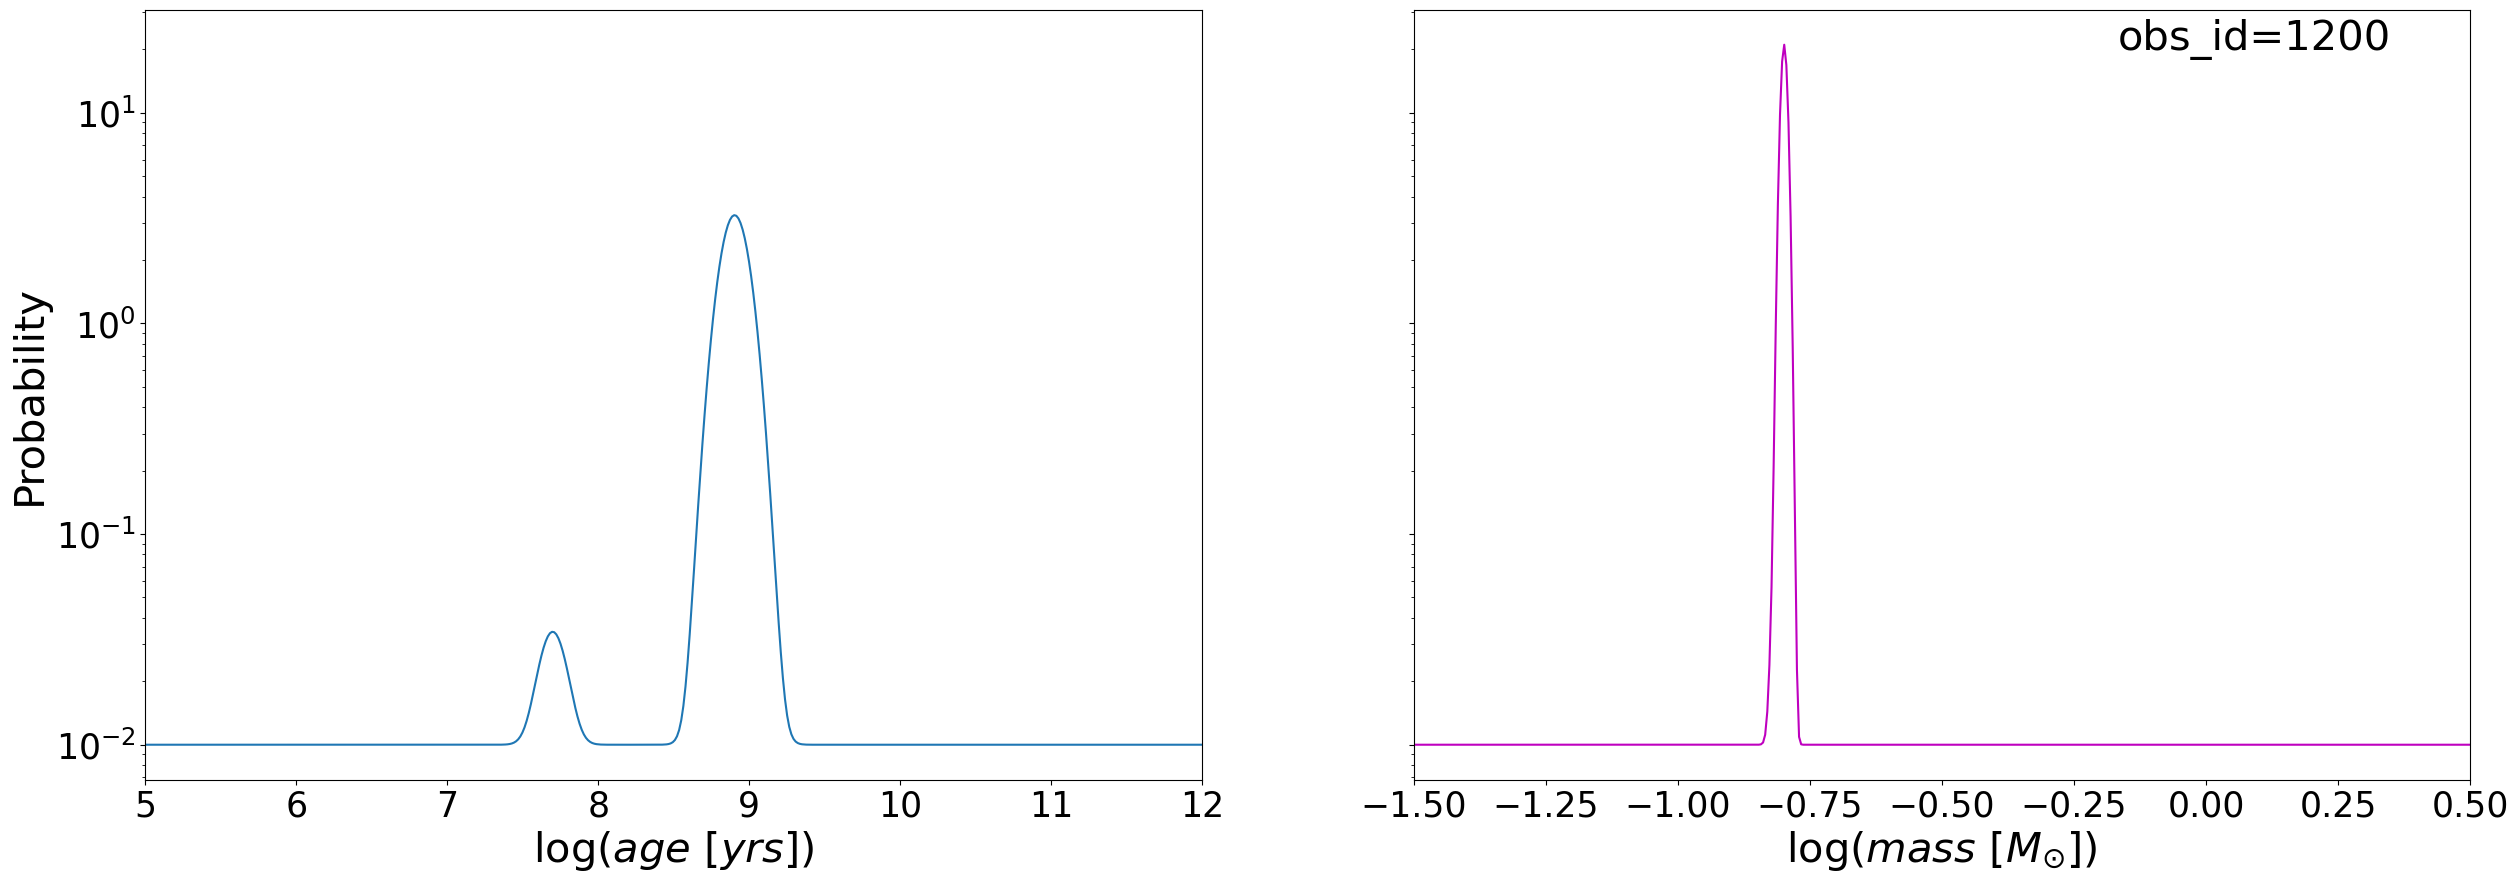

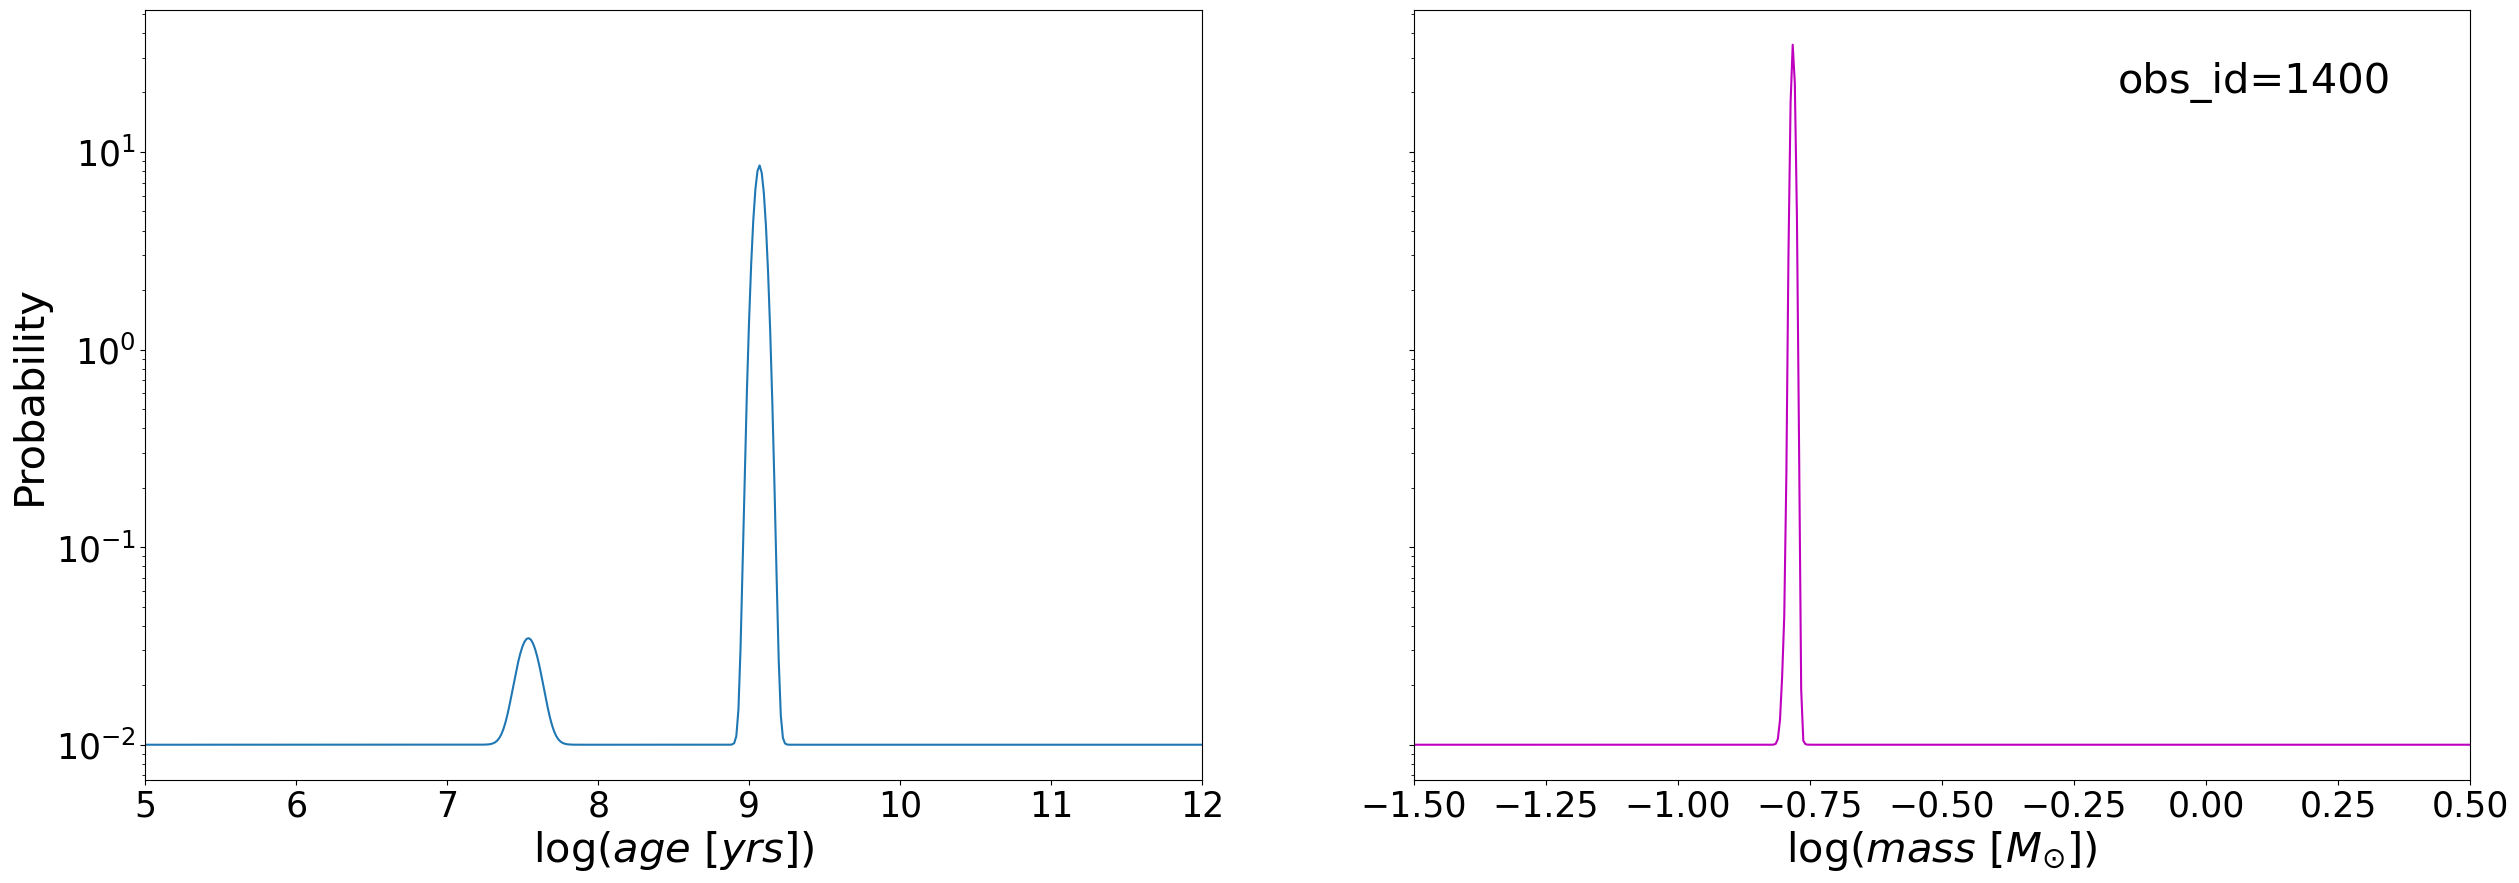

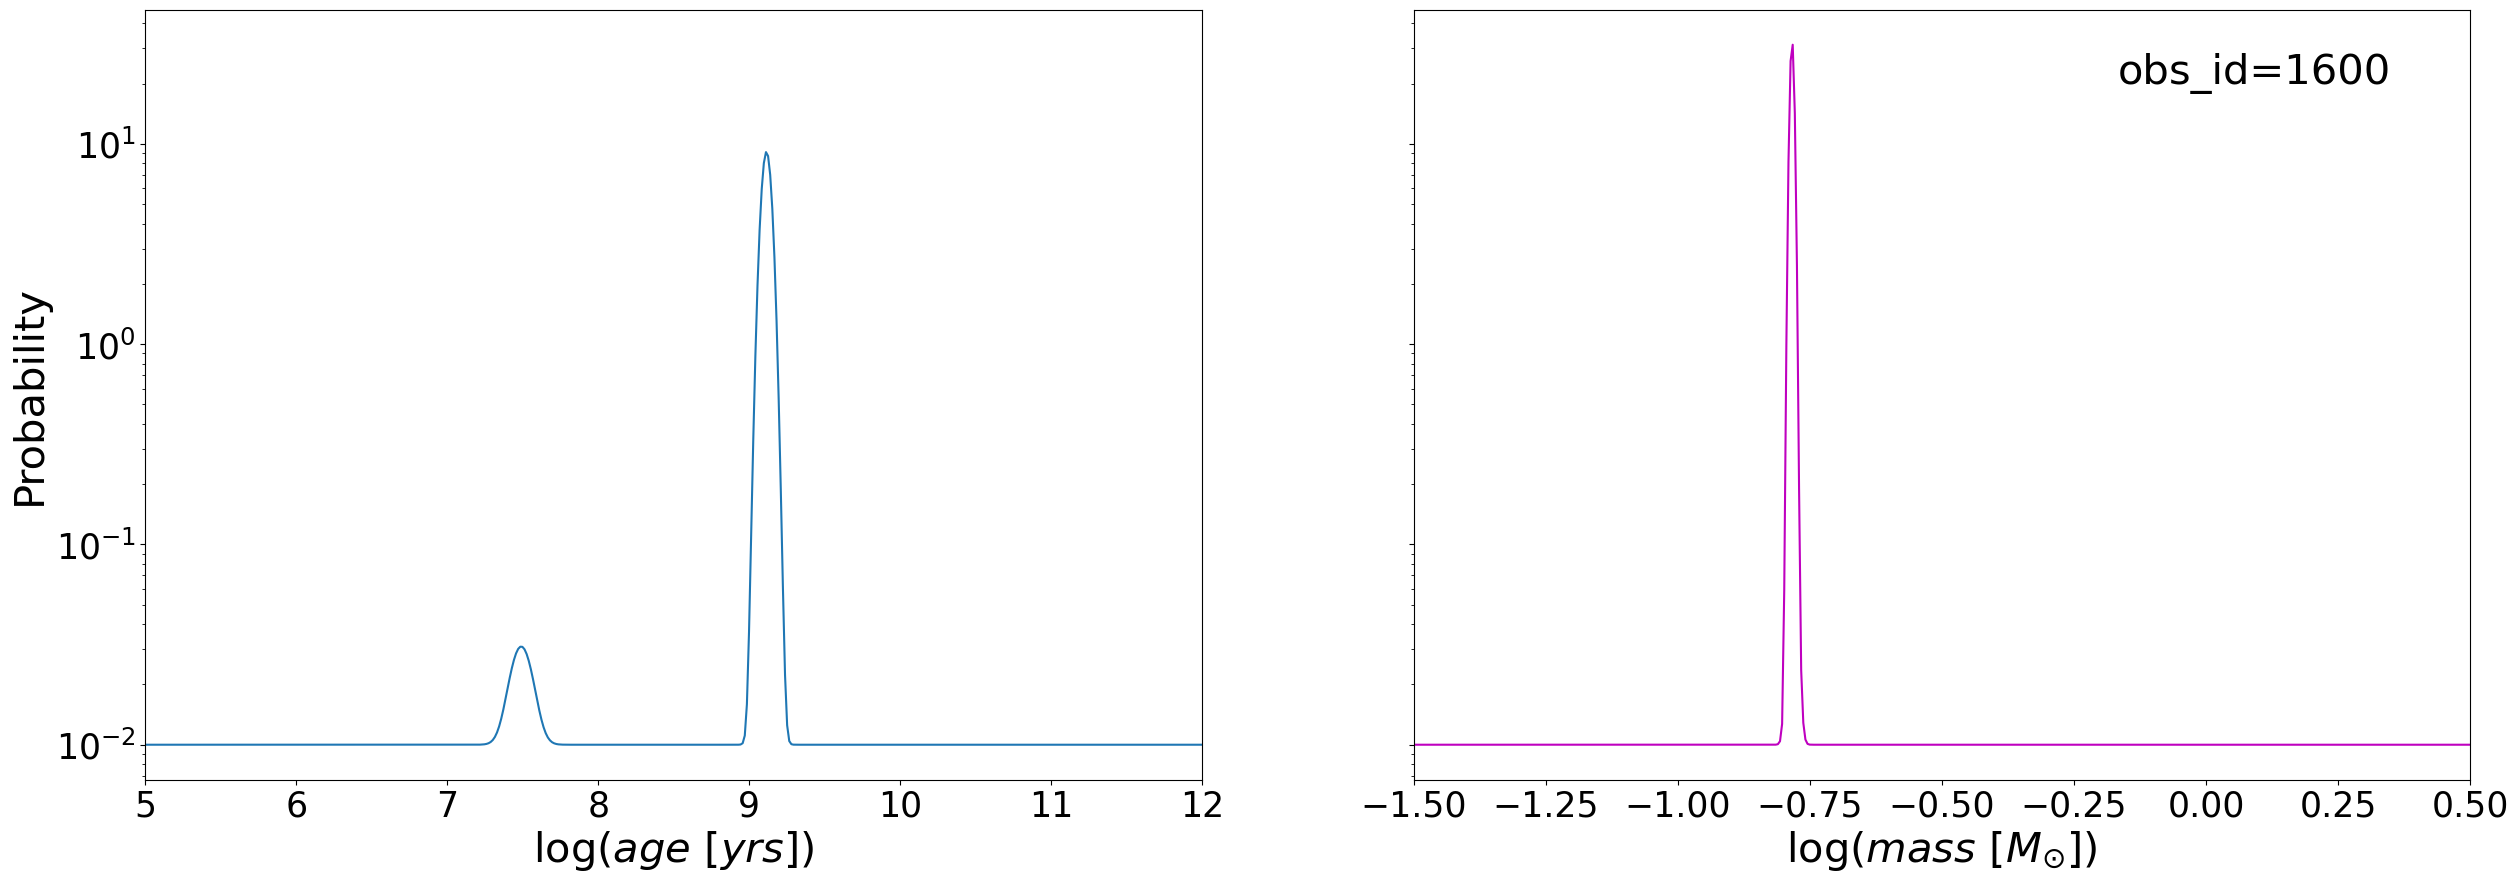

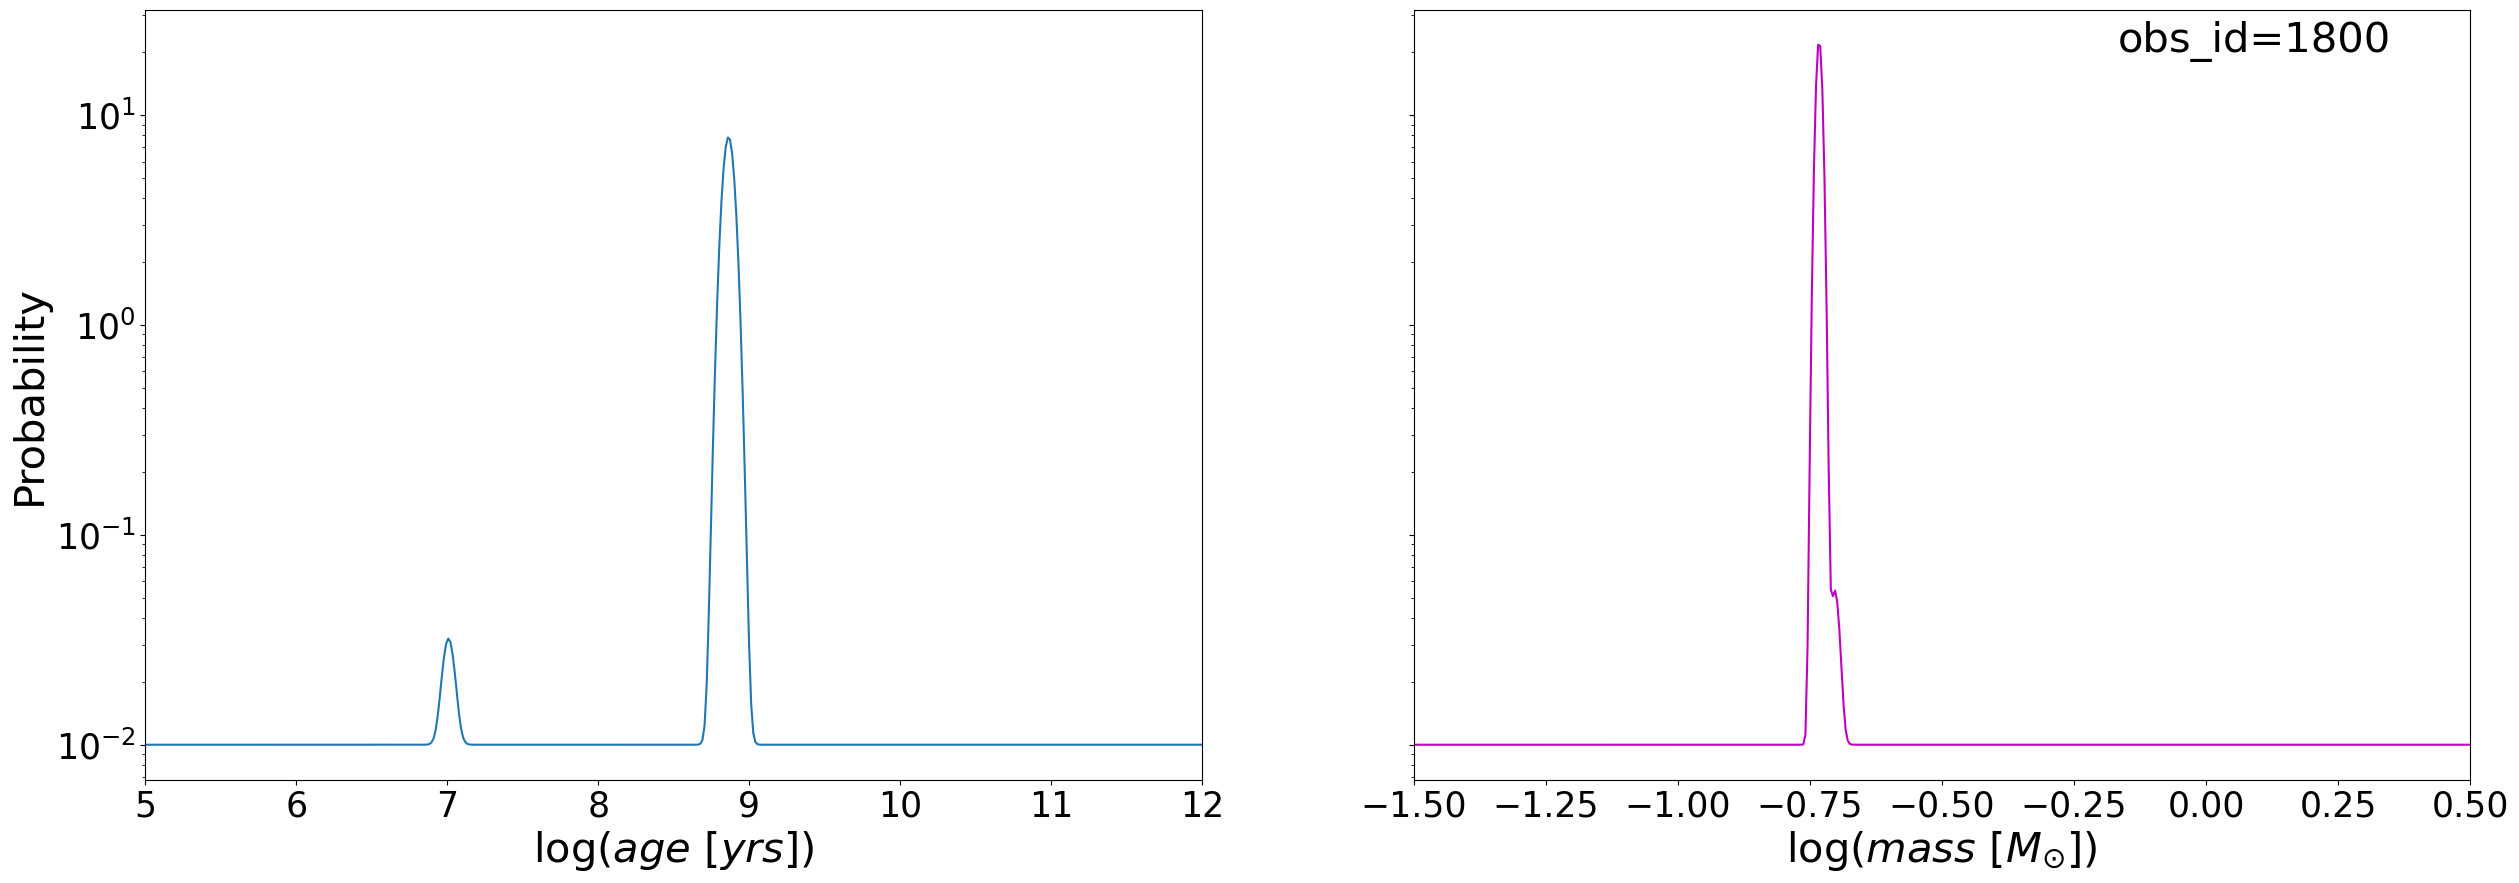

In [19]:
for i in range(0, data.shape[0], 200):
    st.plot_gaussian_posteriors(y_gaussian_posteriors, i, log_age_range=[5,12], log_mass_range=[-1.5,0.5])

## _Gaia_ FGK Benchmarks from ESO (Post-ZAMS)

In [24]:
data_raw = pd.read_csv('Data/postZAMS/FGK.csv') 
df = pd.DataFrame(data_raw)
df['teff_log'] = np.log10(df['Teff'].astype(float))
df['lum_log'] = df["Lum"].astype(float)  # luminosity column is already log scaled in this file

df['ageyr'] = df['med_age']*1e+9
df['logAge'] = np.log10(df['ageyr'])   
df['logMass'] = np.log10(df['M'])

Data = df[['teff_log','lum_log', 'logAge', 'logMass']].dropna().astype(float)


data_x = Data[['teff_log','lum_log']]
data_y = Data[['logAge','logMass']]

In [25]:
data = data_x.values.astype('float')
data_0 = np.copy(data)

### Make Predictions

In [26]:
num_NNs = 20 # choose number of bootstraps

# predict:
y_pre, y_post= st.predict(data, n=num_NNs, TL='reu2023')

In [27]:
y_mean_preMS, y_std_preMS = st.stats(y_pre)
y_mean_postMS, y_std_postMS = st.stats(y_post)

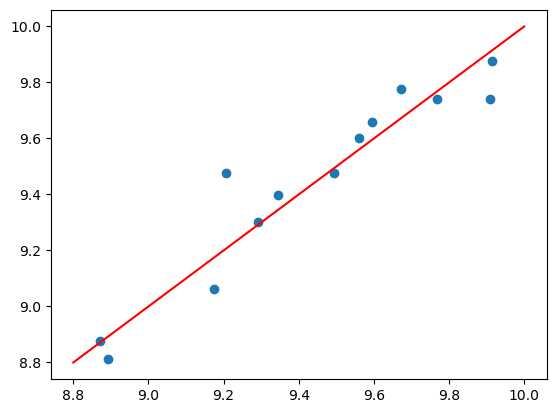

In [30]:
fig, ax = plt.subplots()

x = y_mean_postMS[:,0] # predicted
y = data_y['logAge']

ax.scatter(x,y)

z = np.linspace(8.8,10,2)
ax.plot(z,z,color='r')

### Mixture of Models

In [31]:
pi_pre, pi_post = st.pis(y_mean_preMS, y_mean_postMS)

In [32]:
# Get posteriors:
y_post = st.posteriors(y_pre , y_post, pi_pre, pi_post, n=num_NNs)

In [33]:
data.shape

(13, 2)

### Retrieve Posteriors

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='Observation id', ylabel='$\\log(mass)$ [$M_{\\odot}$]'>],
      dtype=object)

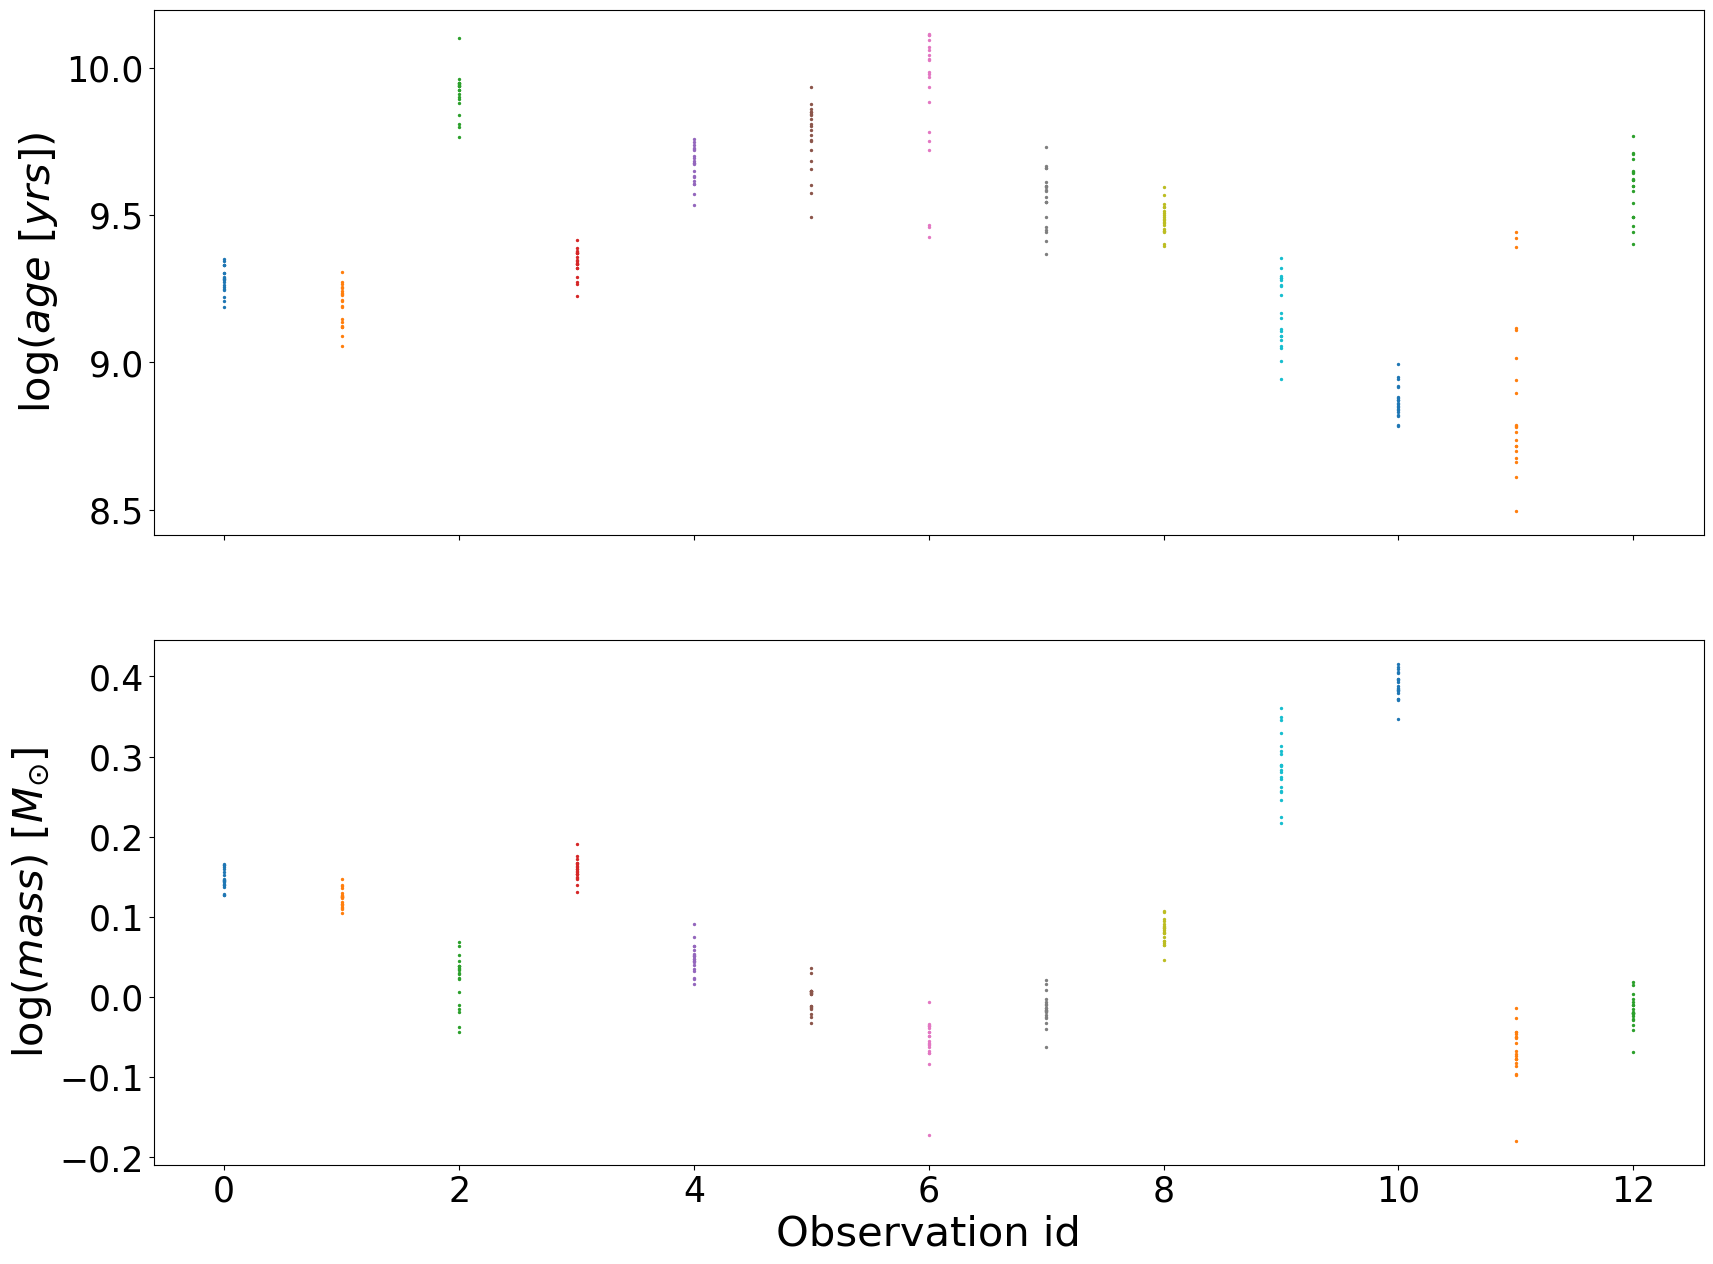

In [34]:
st.plot_multiple_posteriors(y_post, [i for i in range(0, data.shape[0])])

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='model number', ylabel='$\\log(mass \\ [M_{\\odot}])$'>],
      dtype=object)

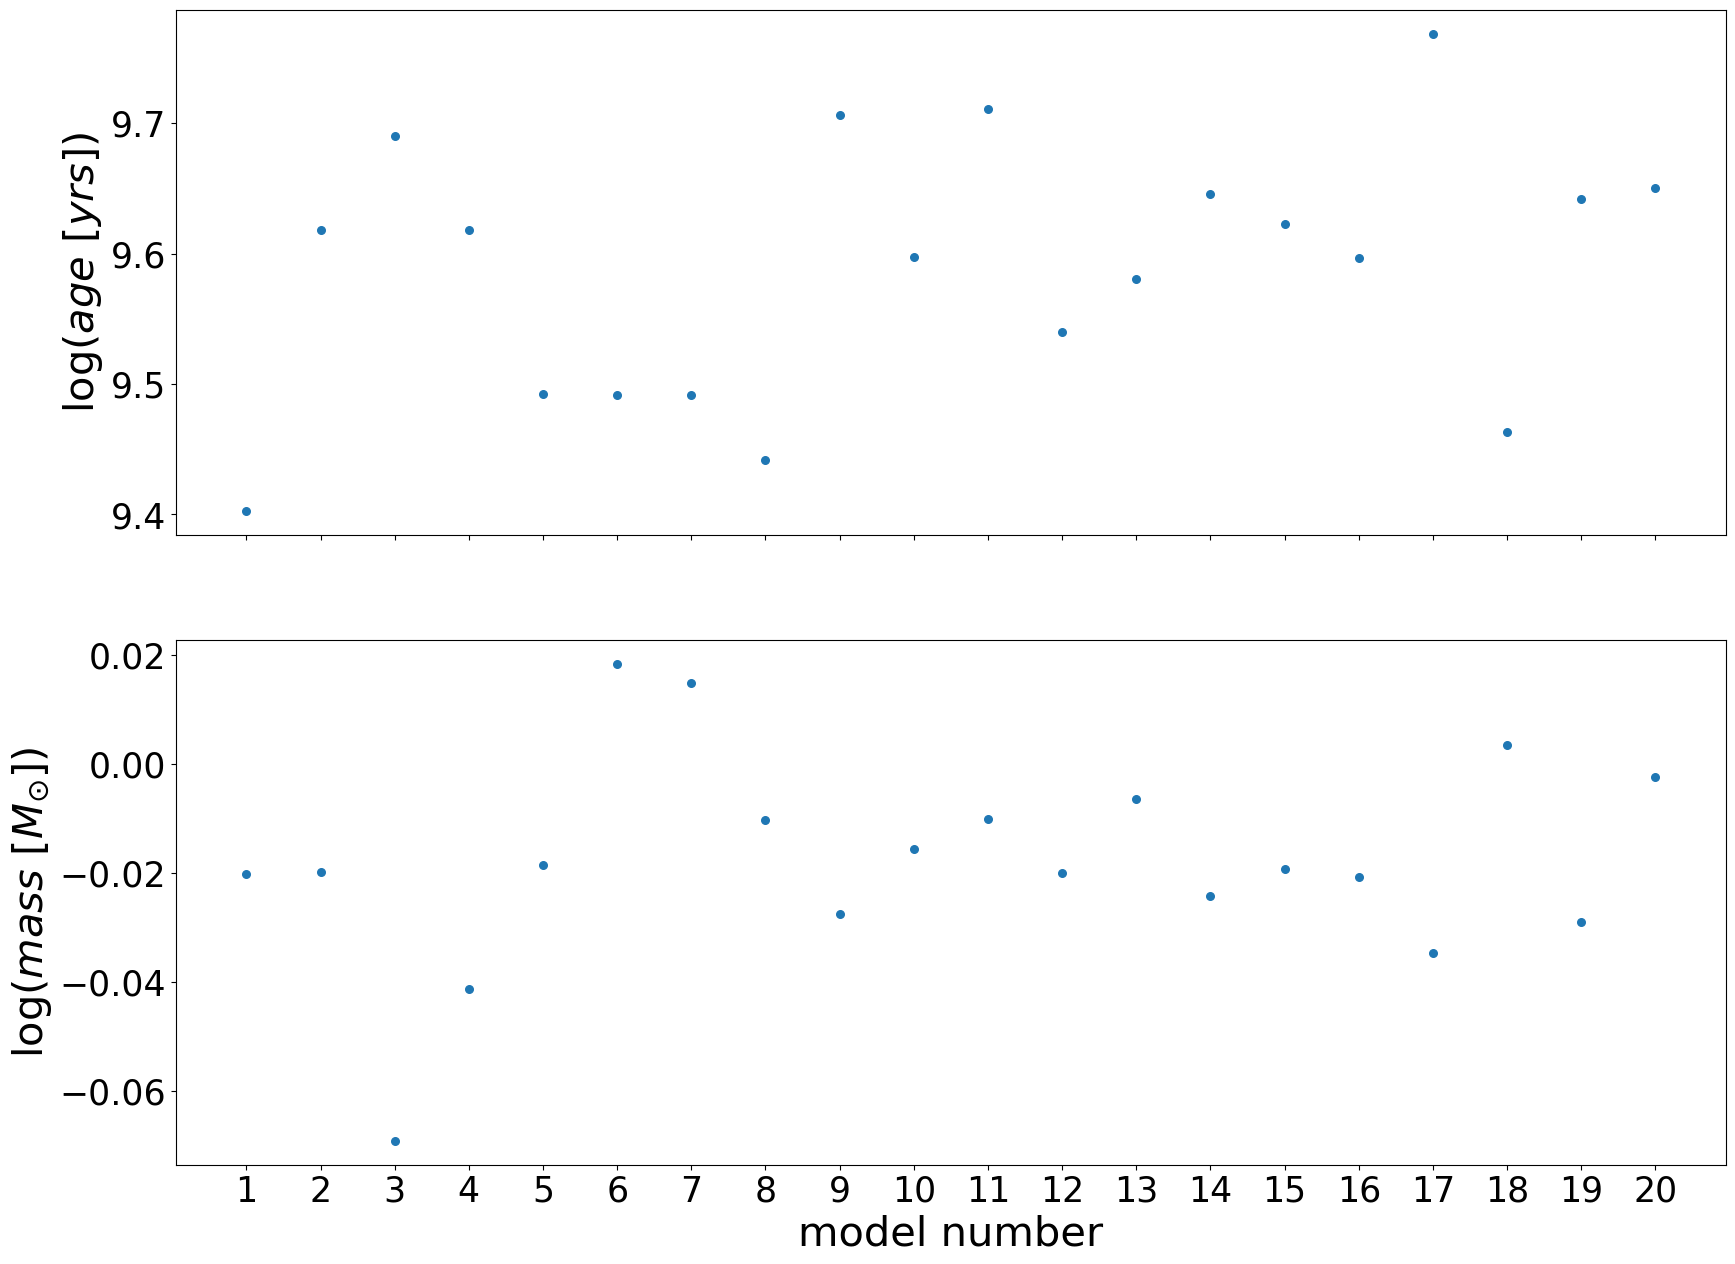

In [35]:
st.plot_posterior(y_post, -1) # last star in this file is the sun

array([<Axes: xlabel='$\\log(age \\ [yrs])$', ylabel='number of predictions'>,
       <Axes: xlabel='$\\log(mass \\ [M_{\\odot}])$'>], dtype=object)

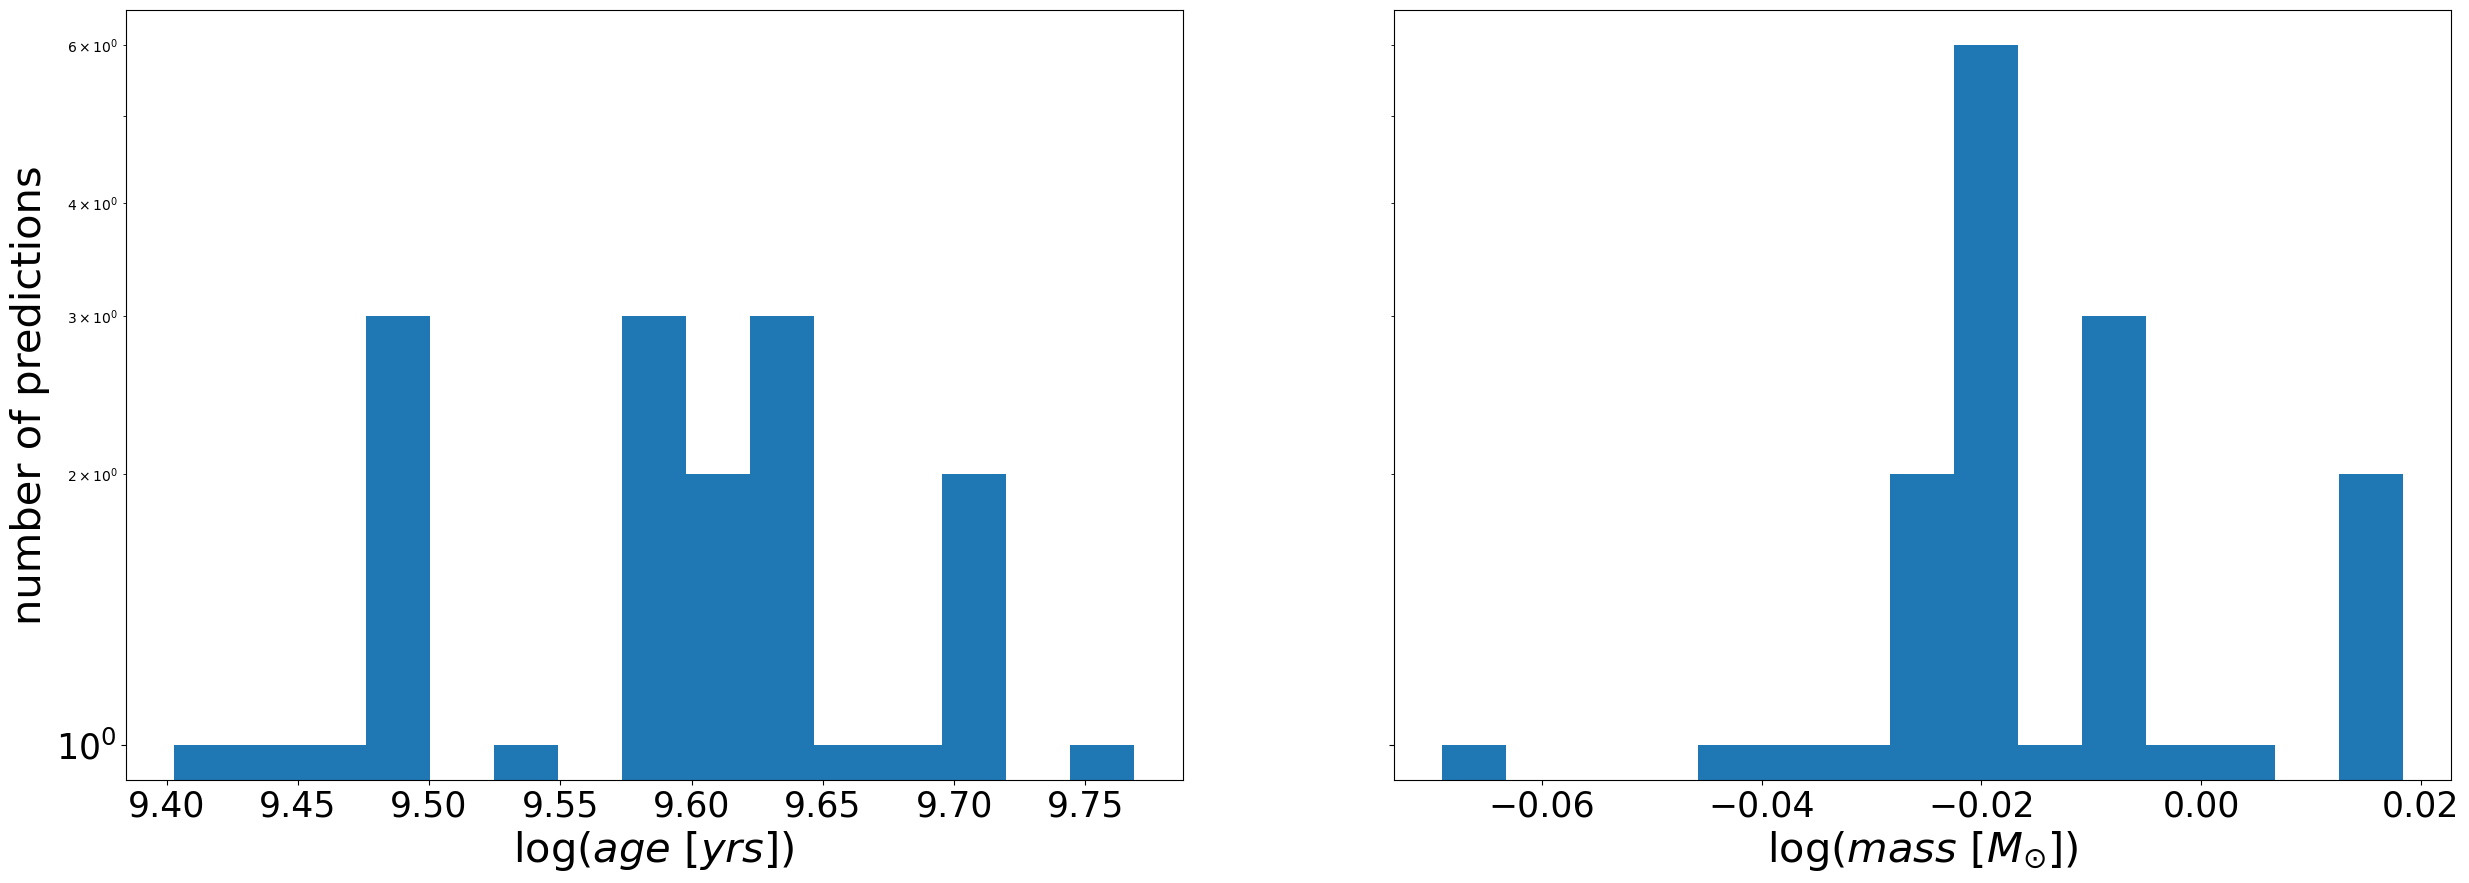

In [36]:
st.plot_posterior_hist(y_post, -1)

### Gaussian Posteriors

In [37]:
y_gaussian_posteriors=st.Gaussian_posteriors(y_mean_preMS, y_mean_postMS, y_std_preMS, y_std_postMS, pi_pre, pi_post, n_obs=data.shape[0], num_x_points=500)

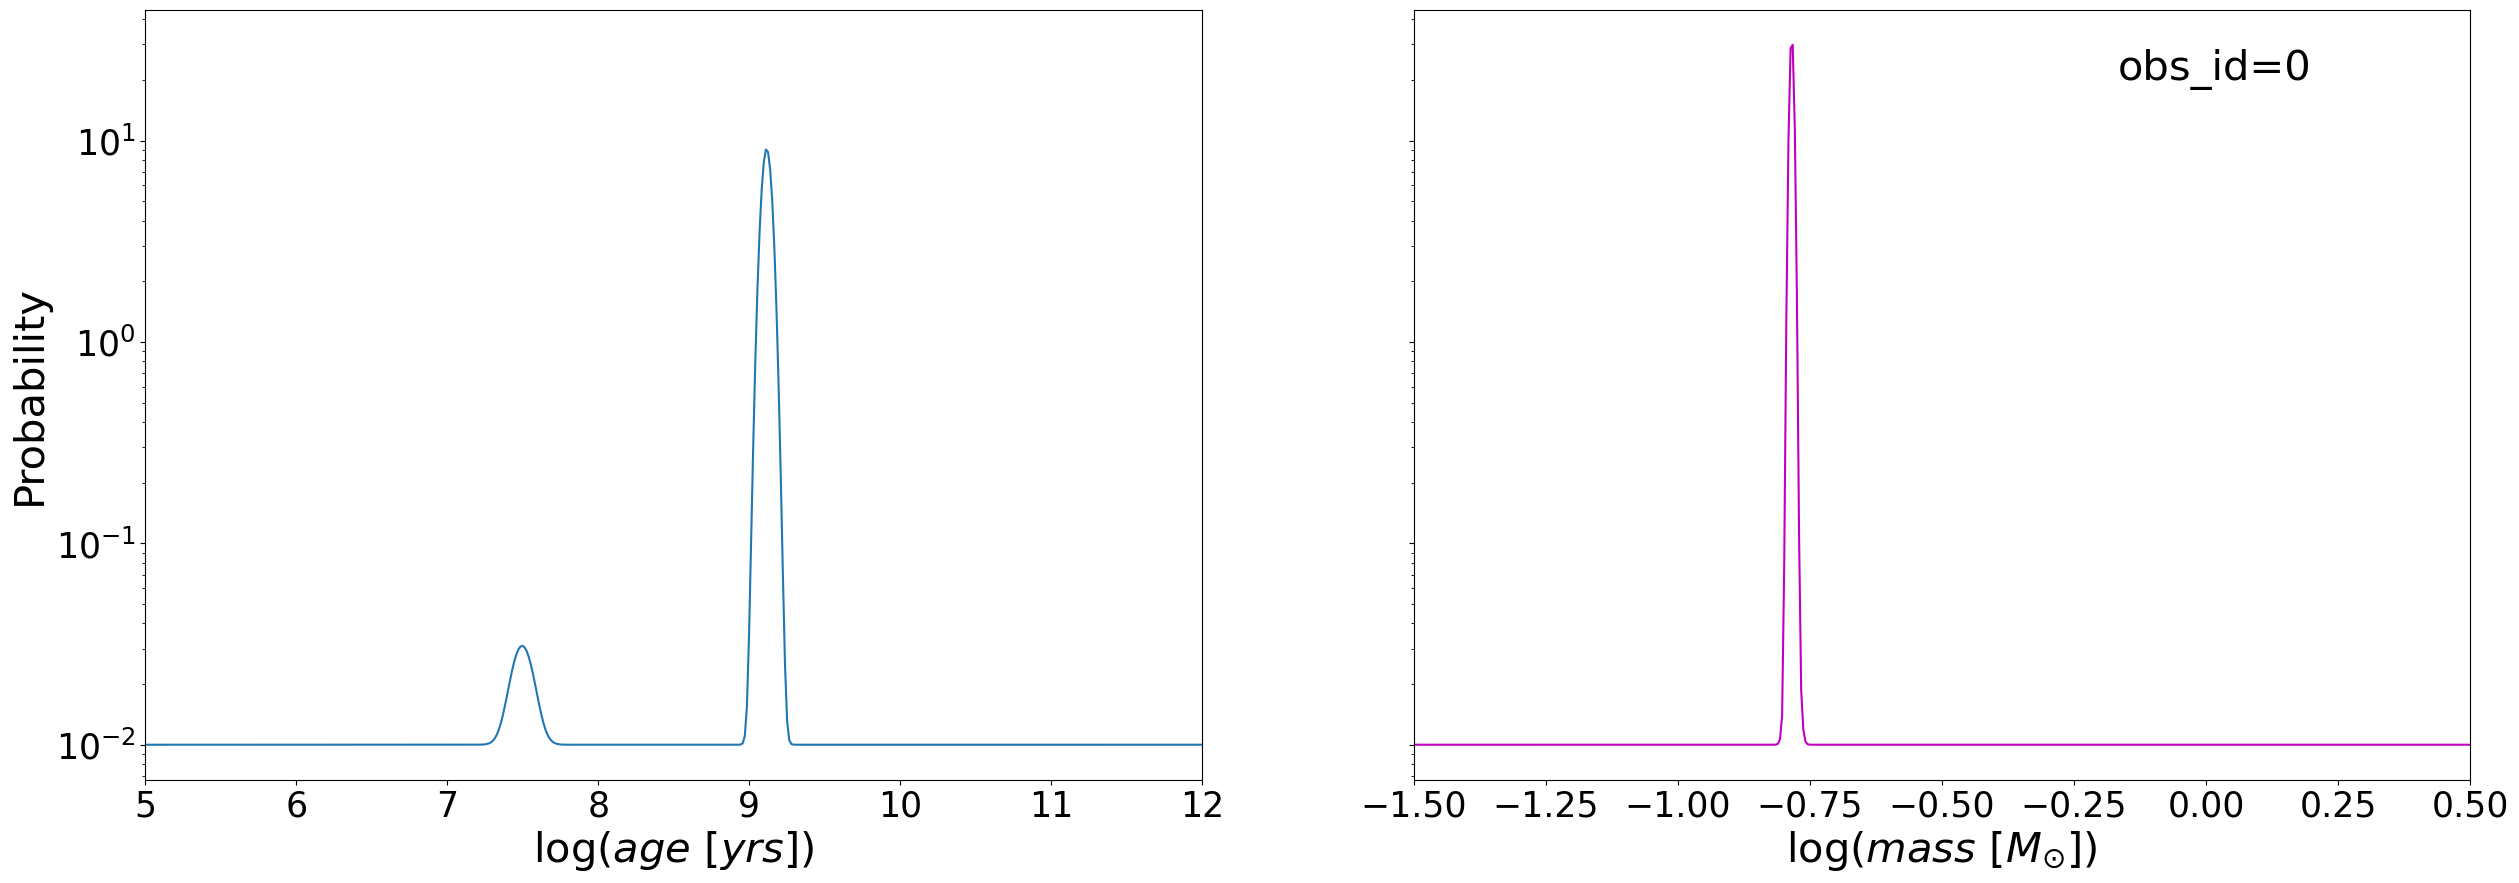

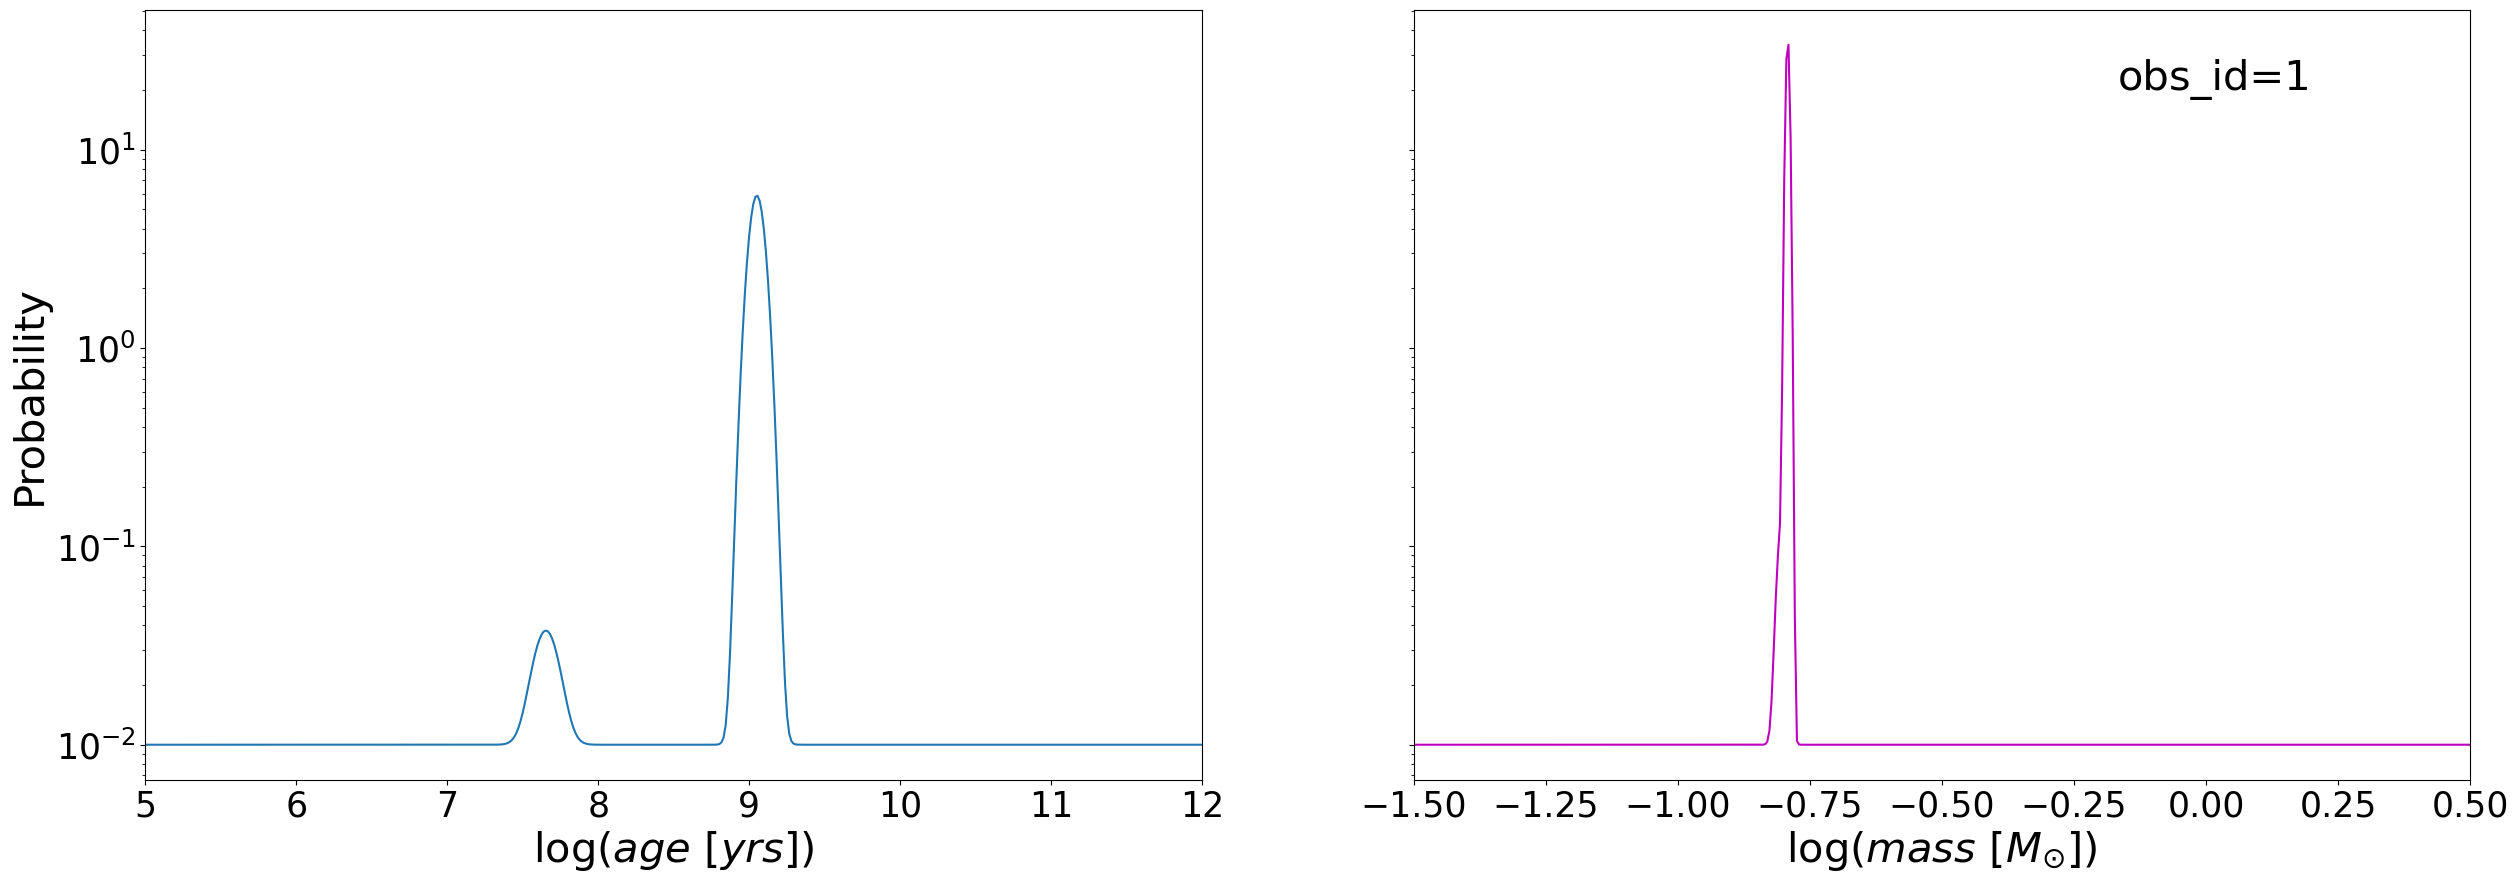

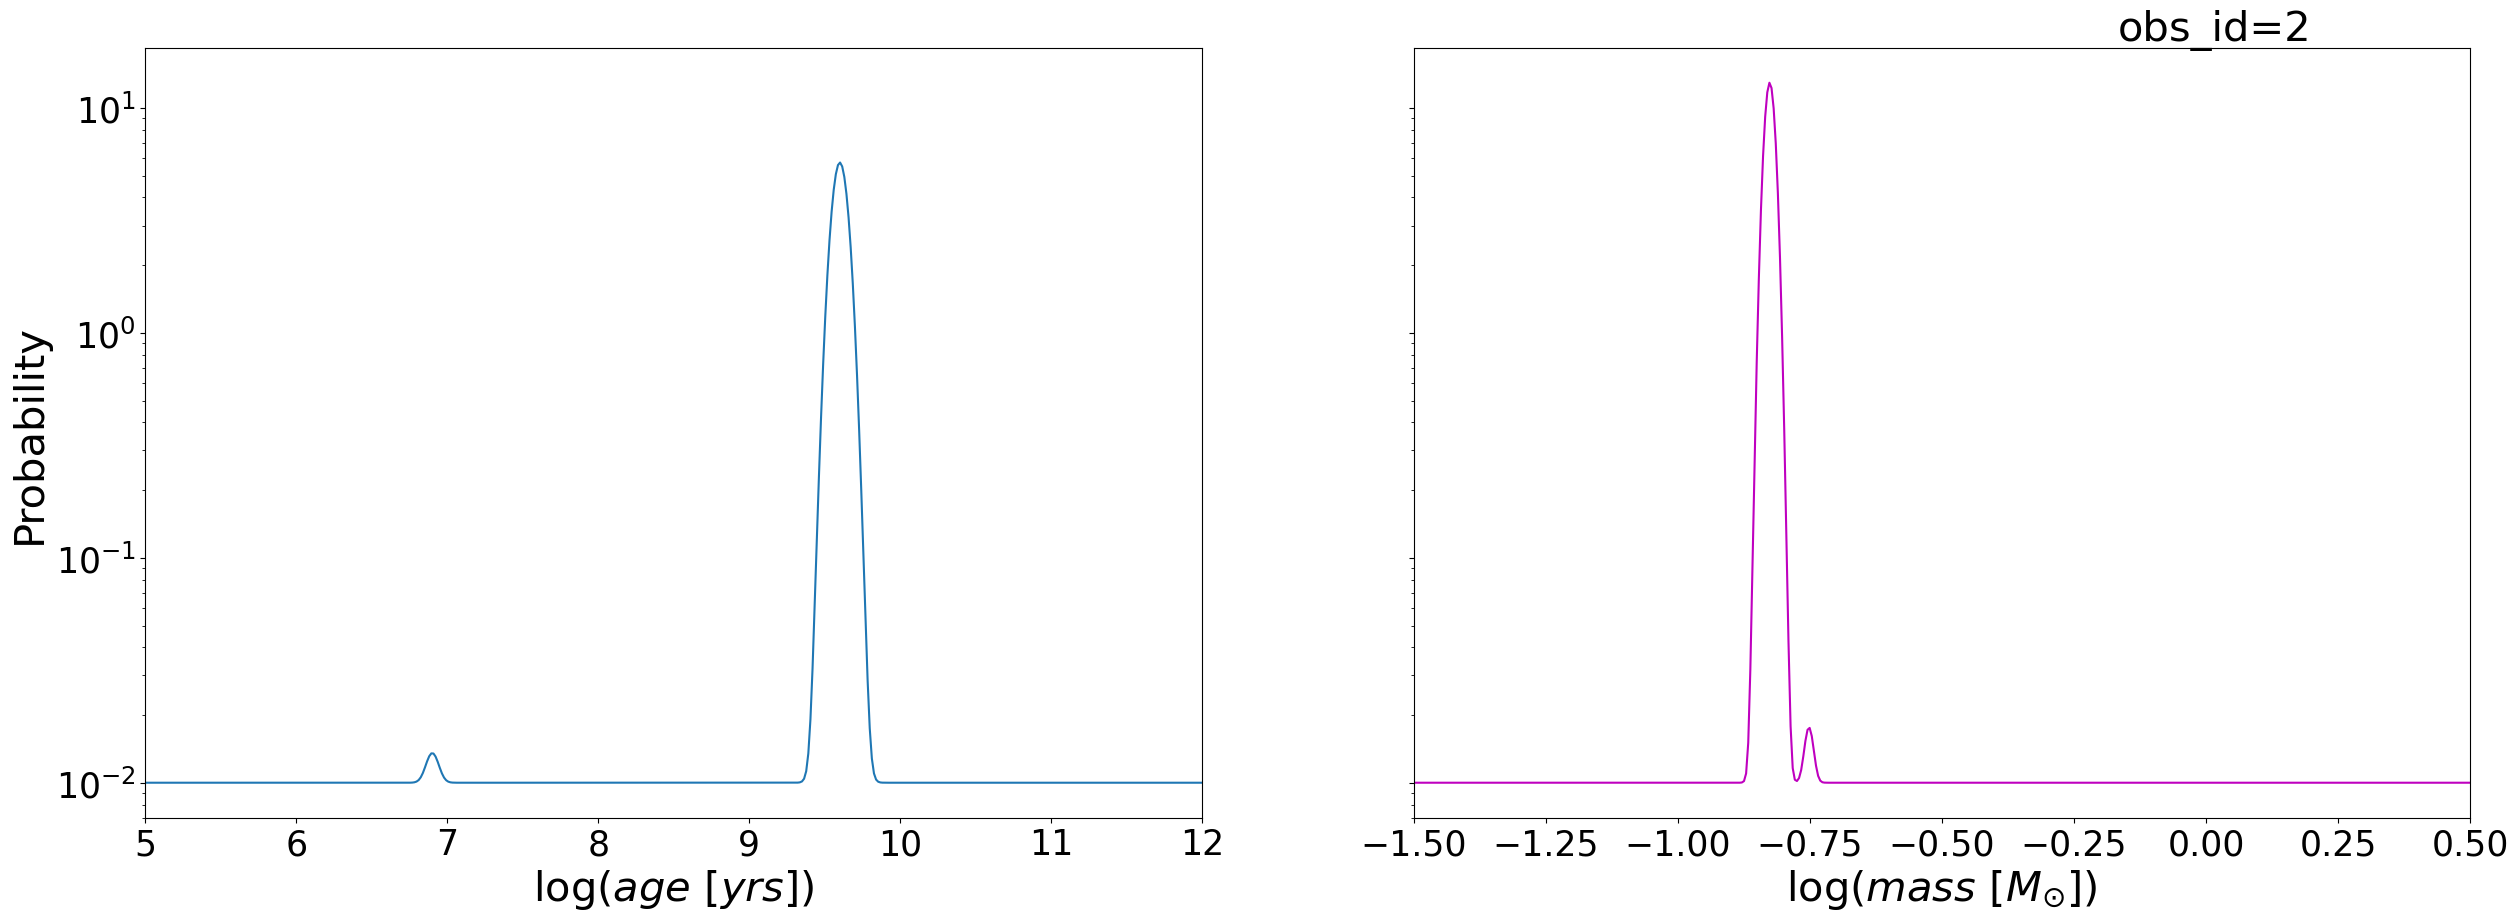

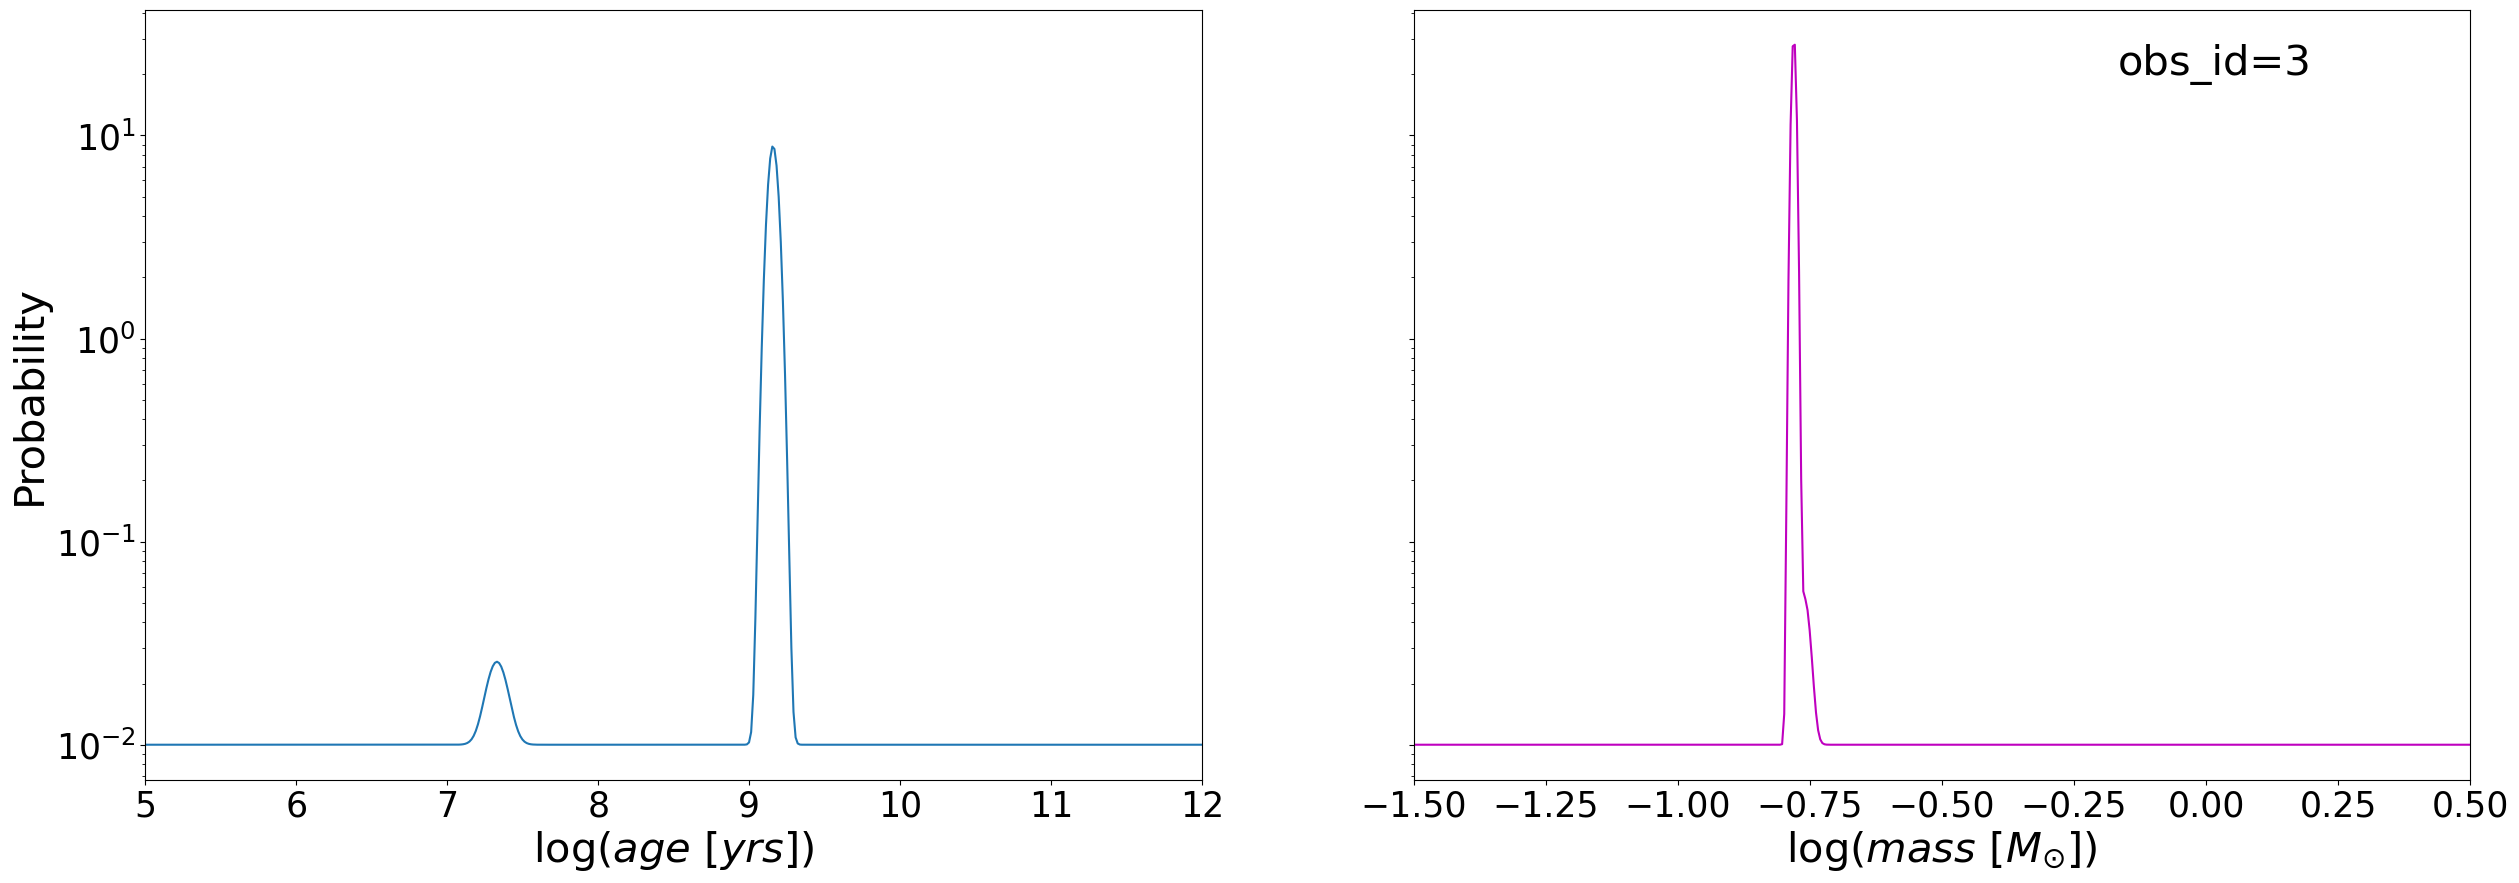

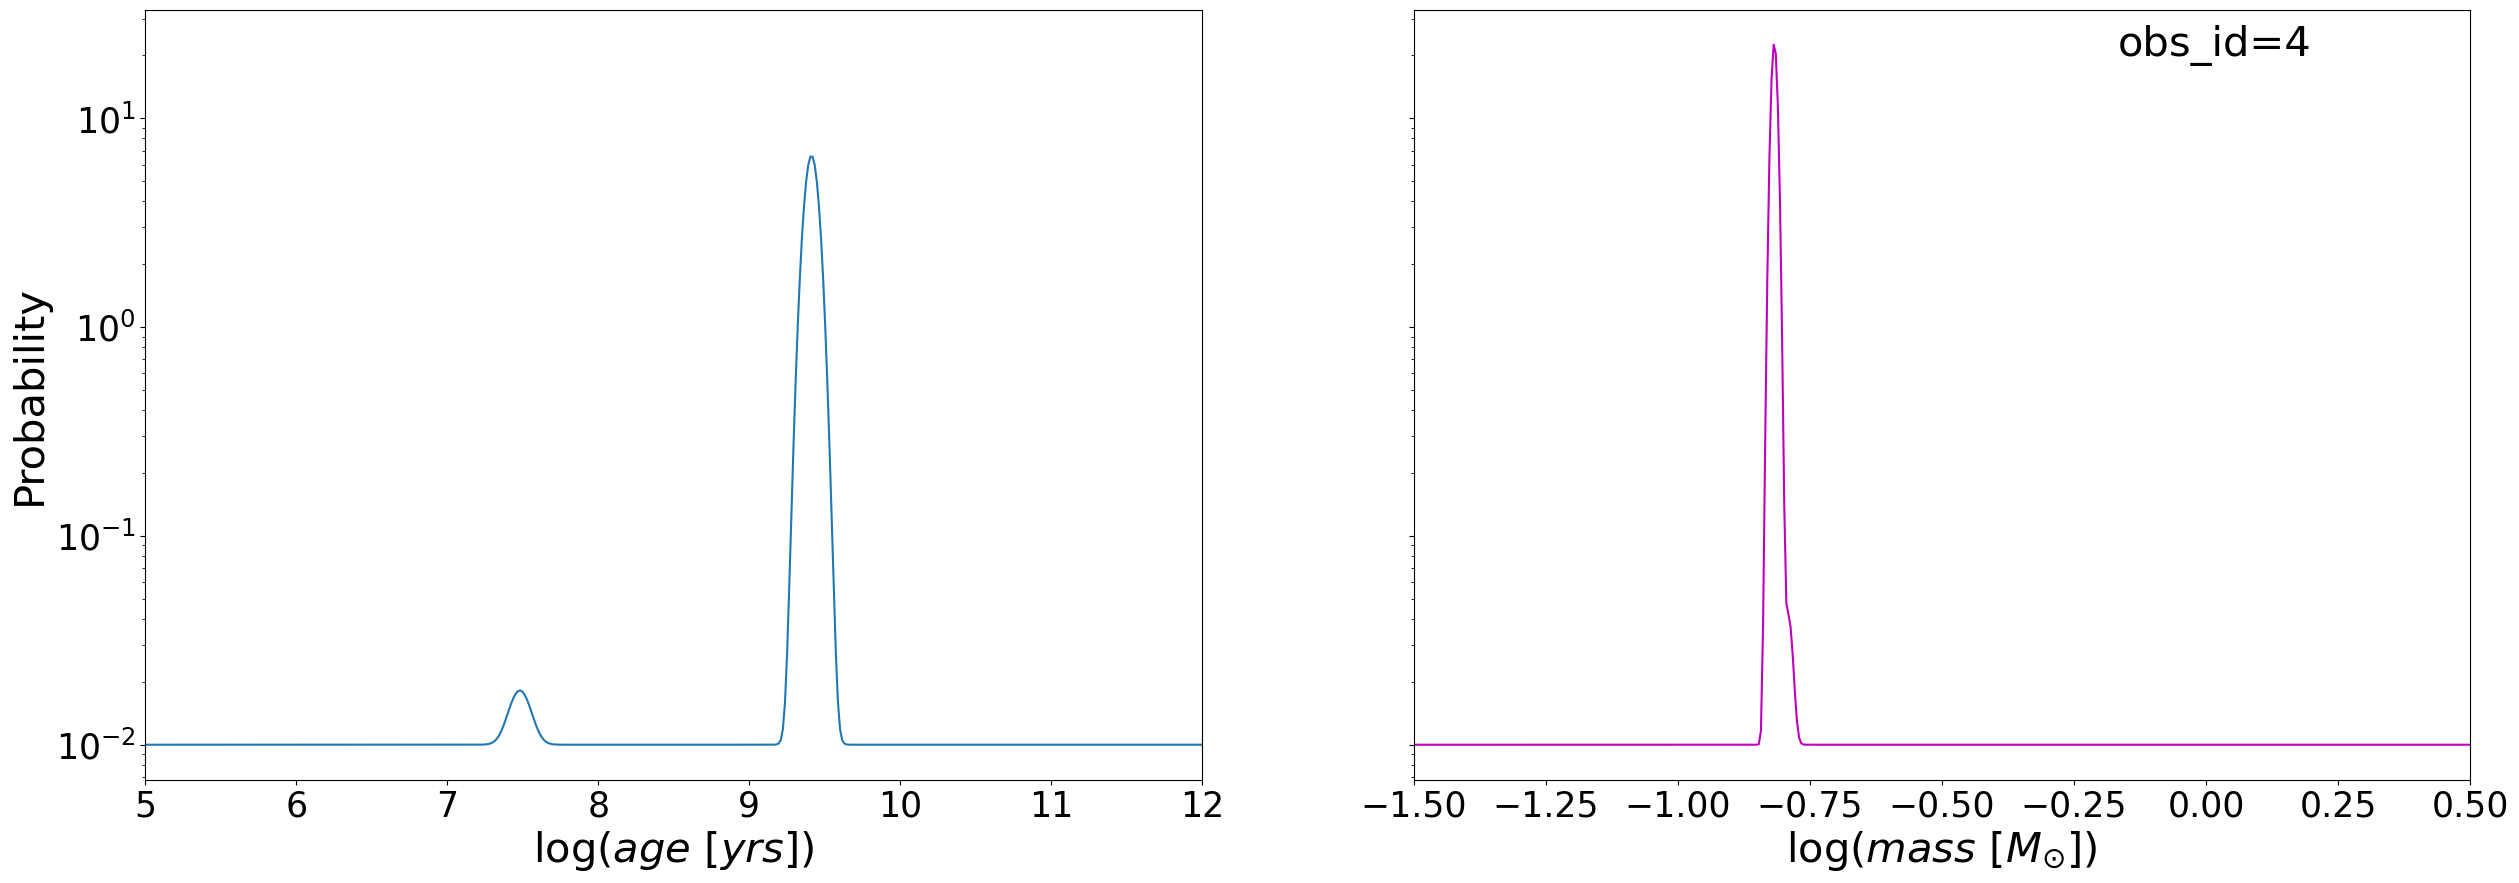

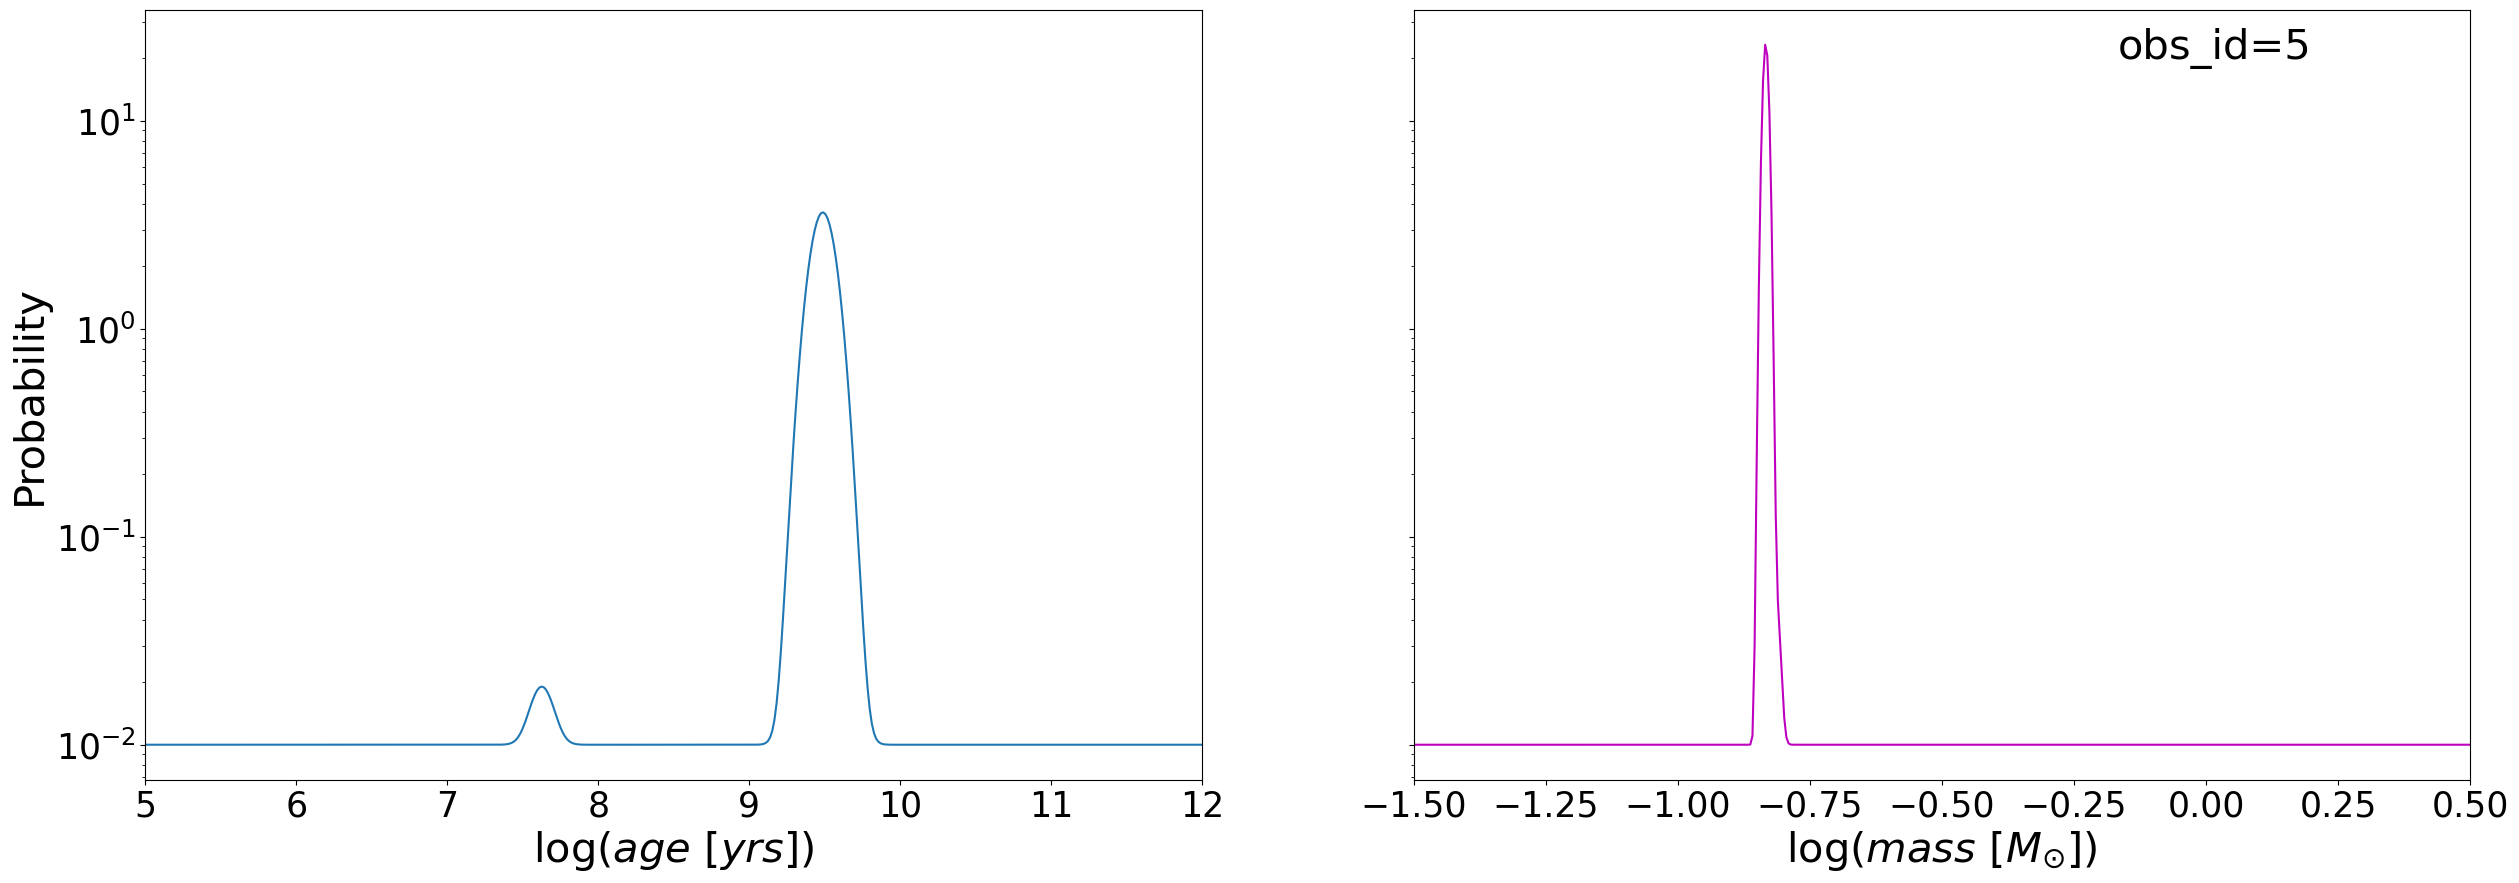

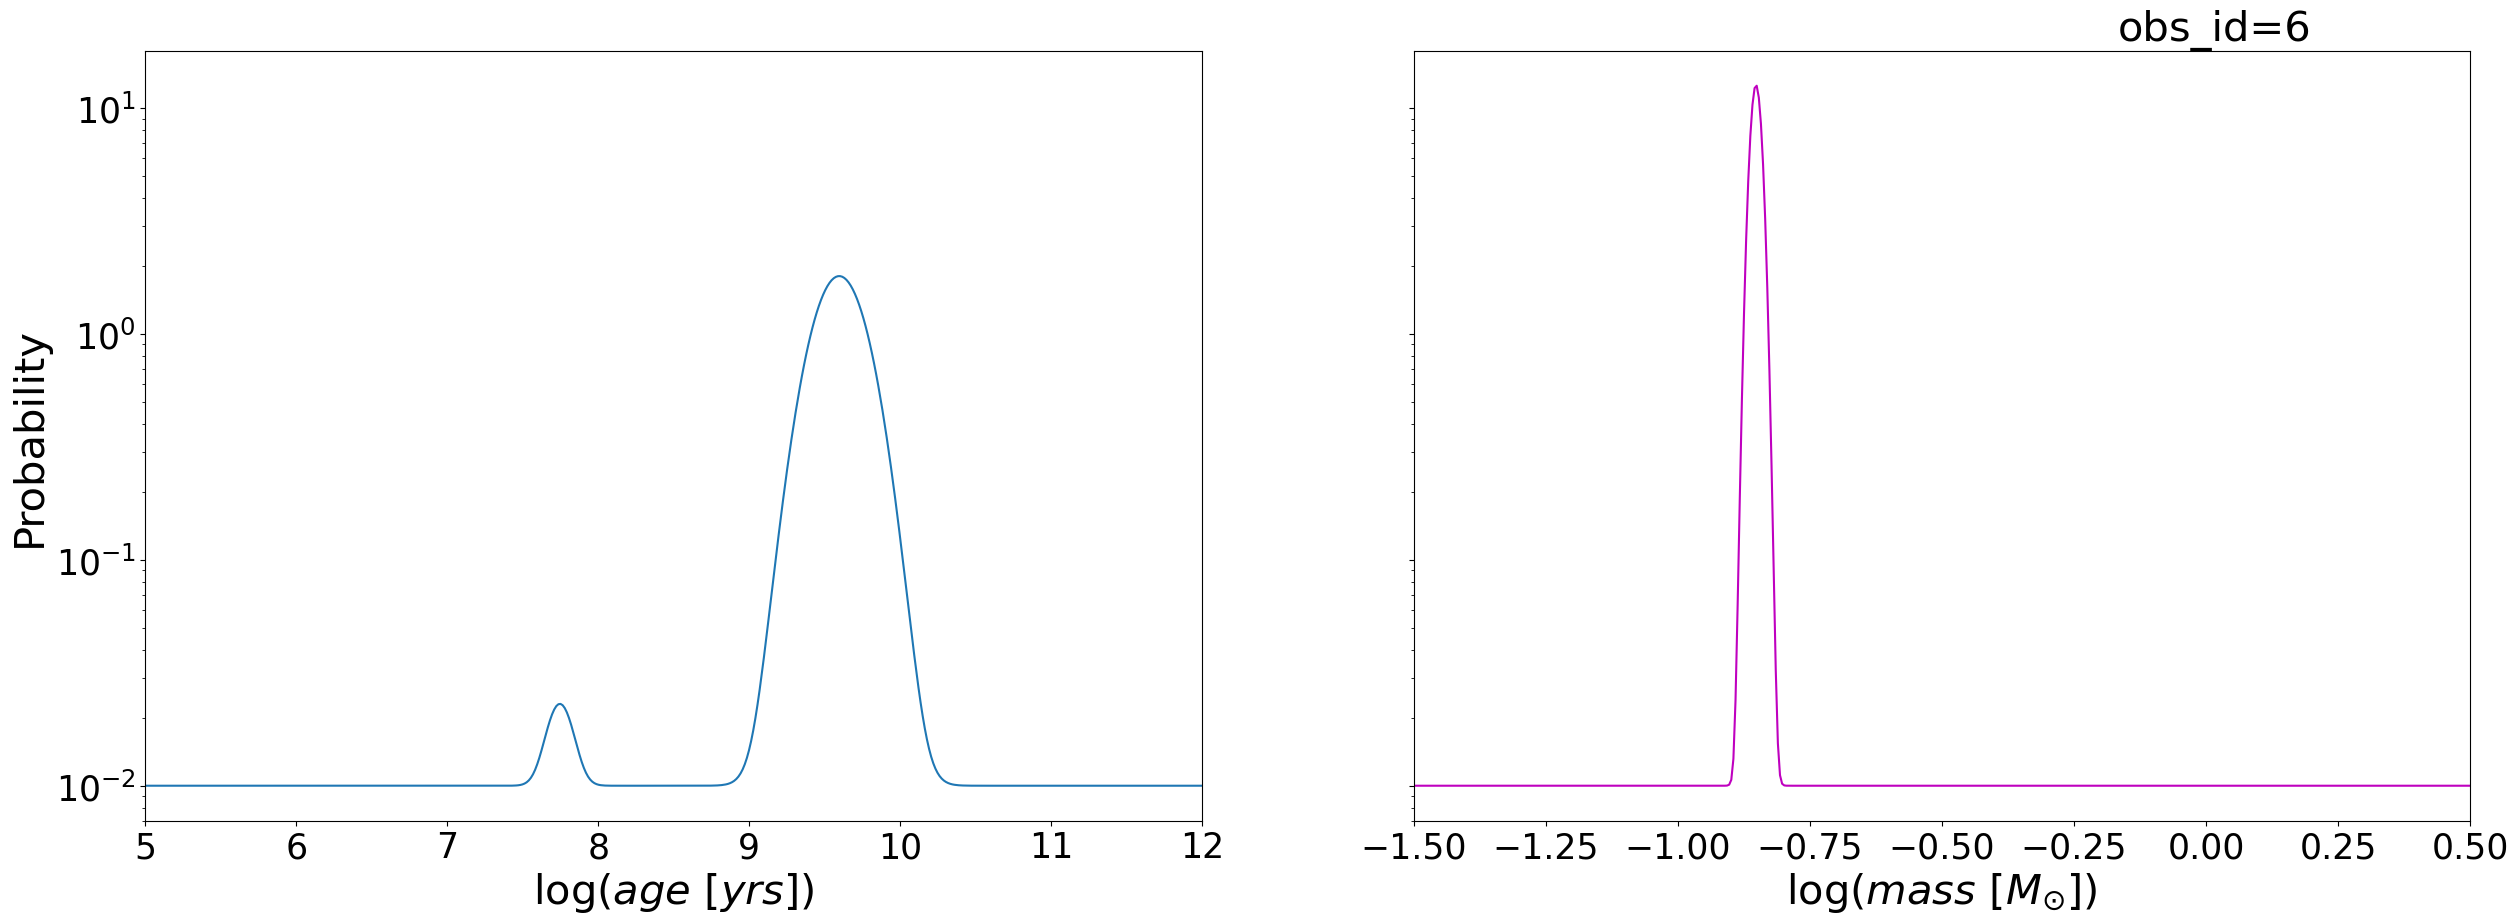

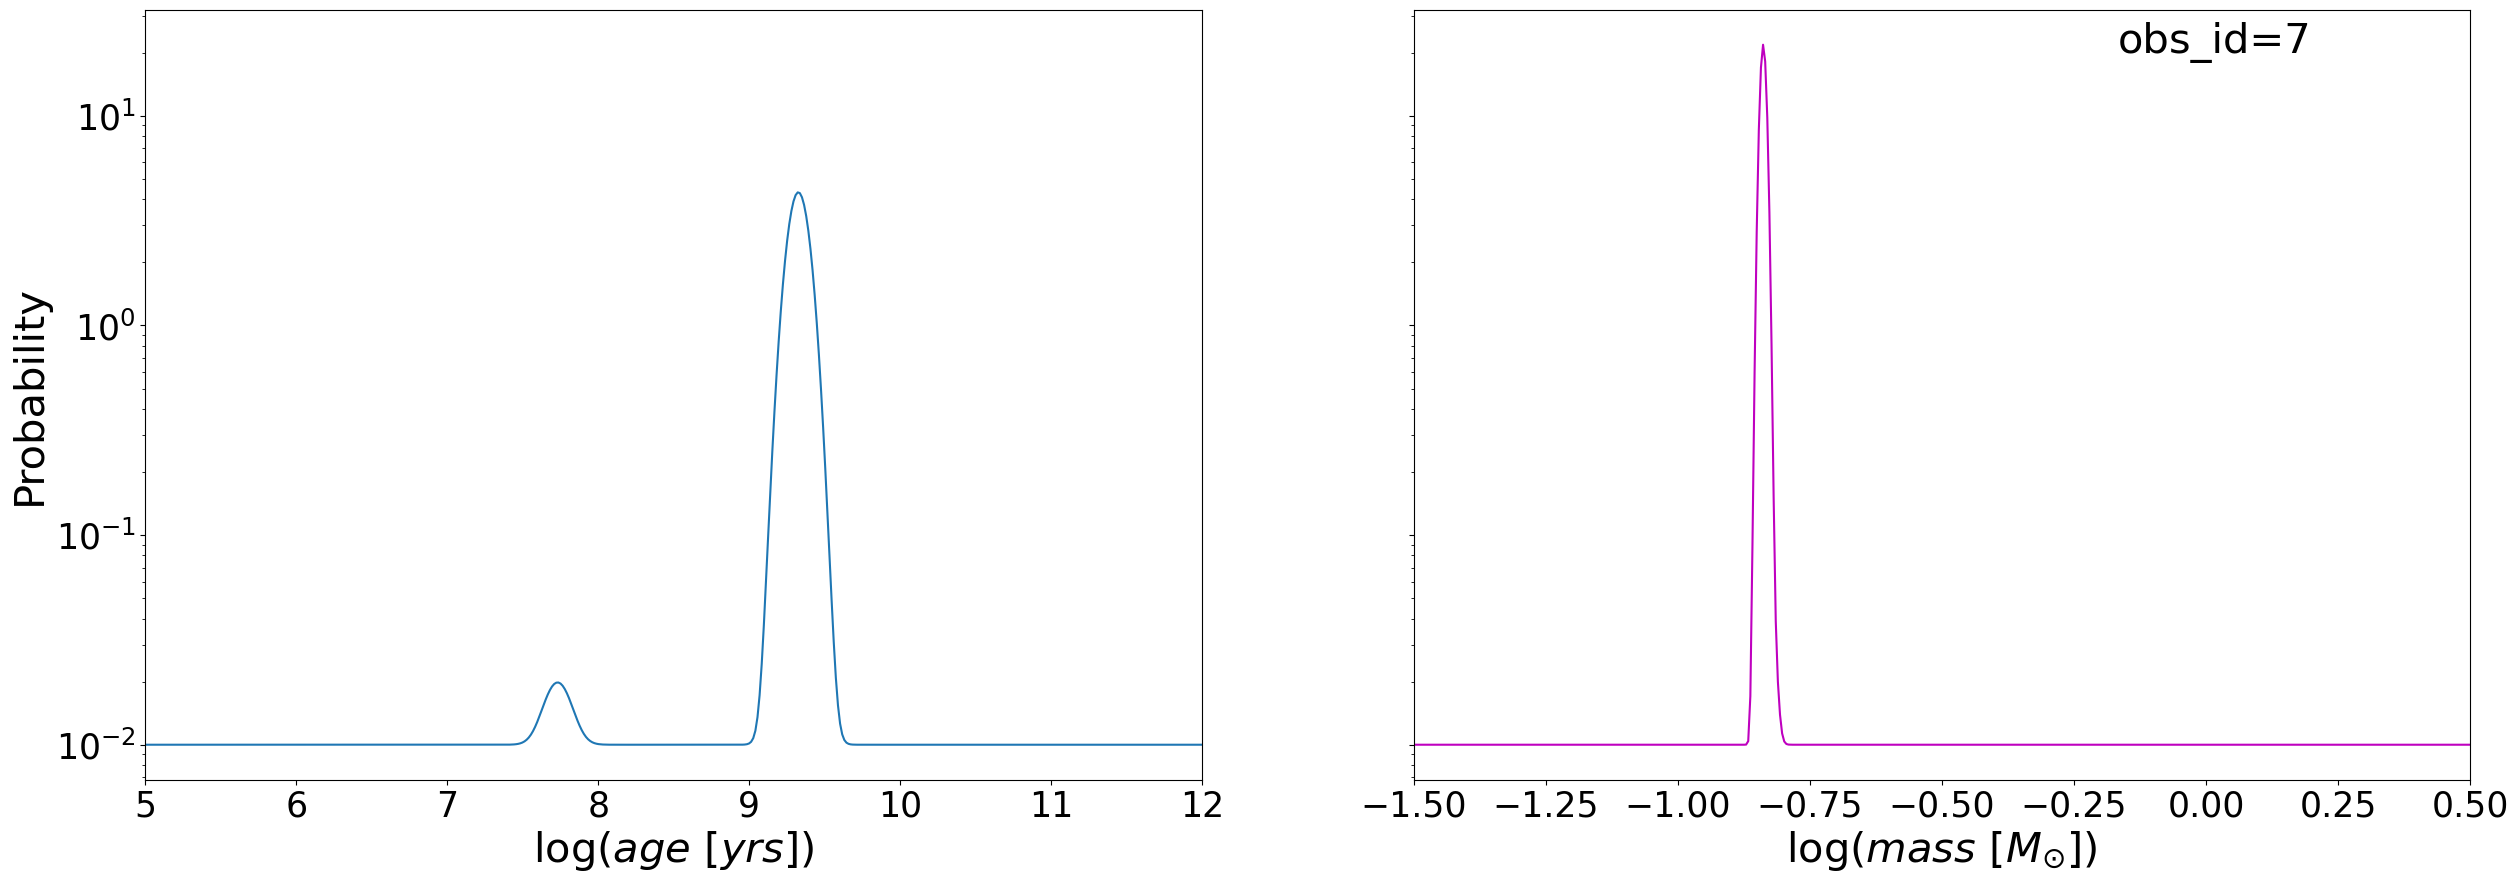

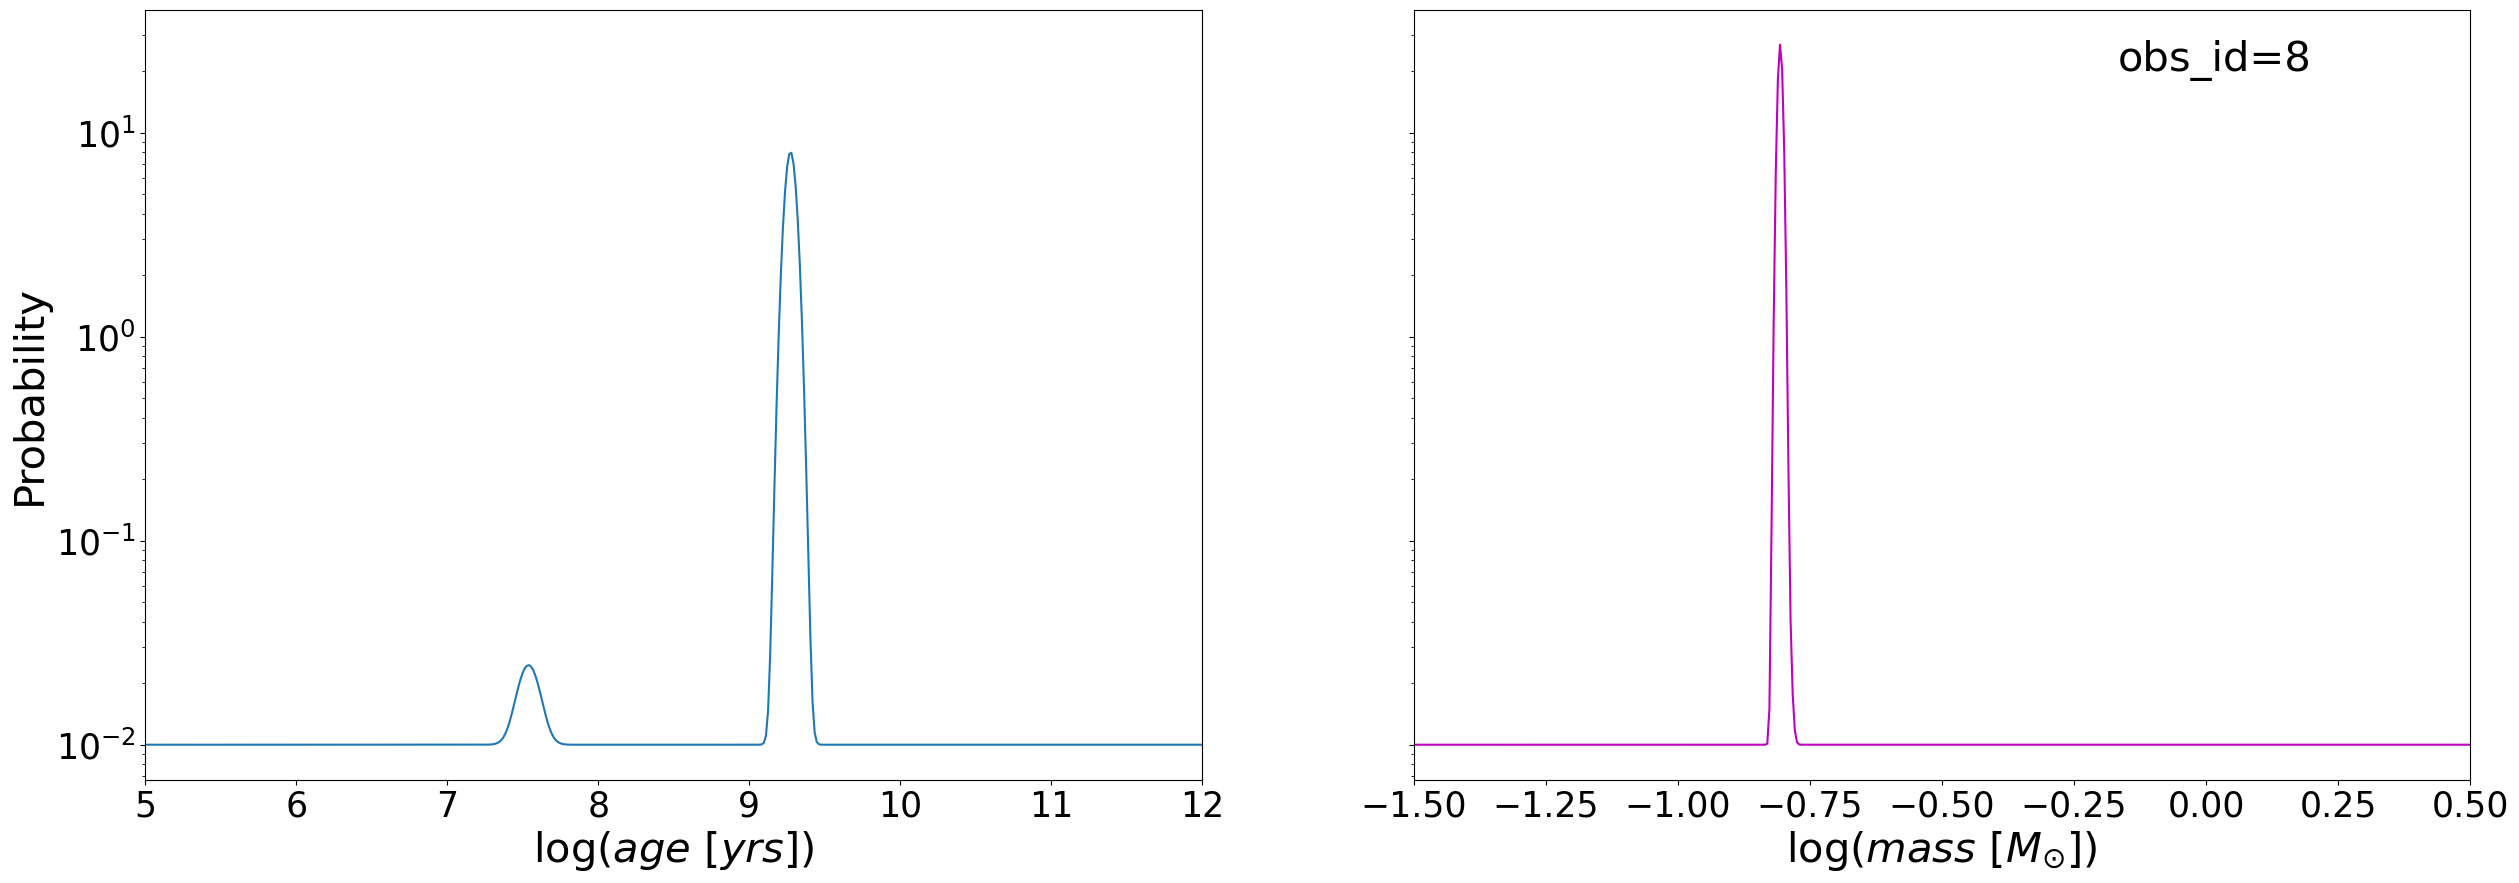

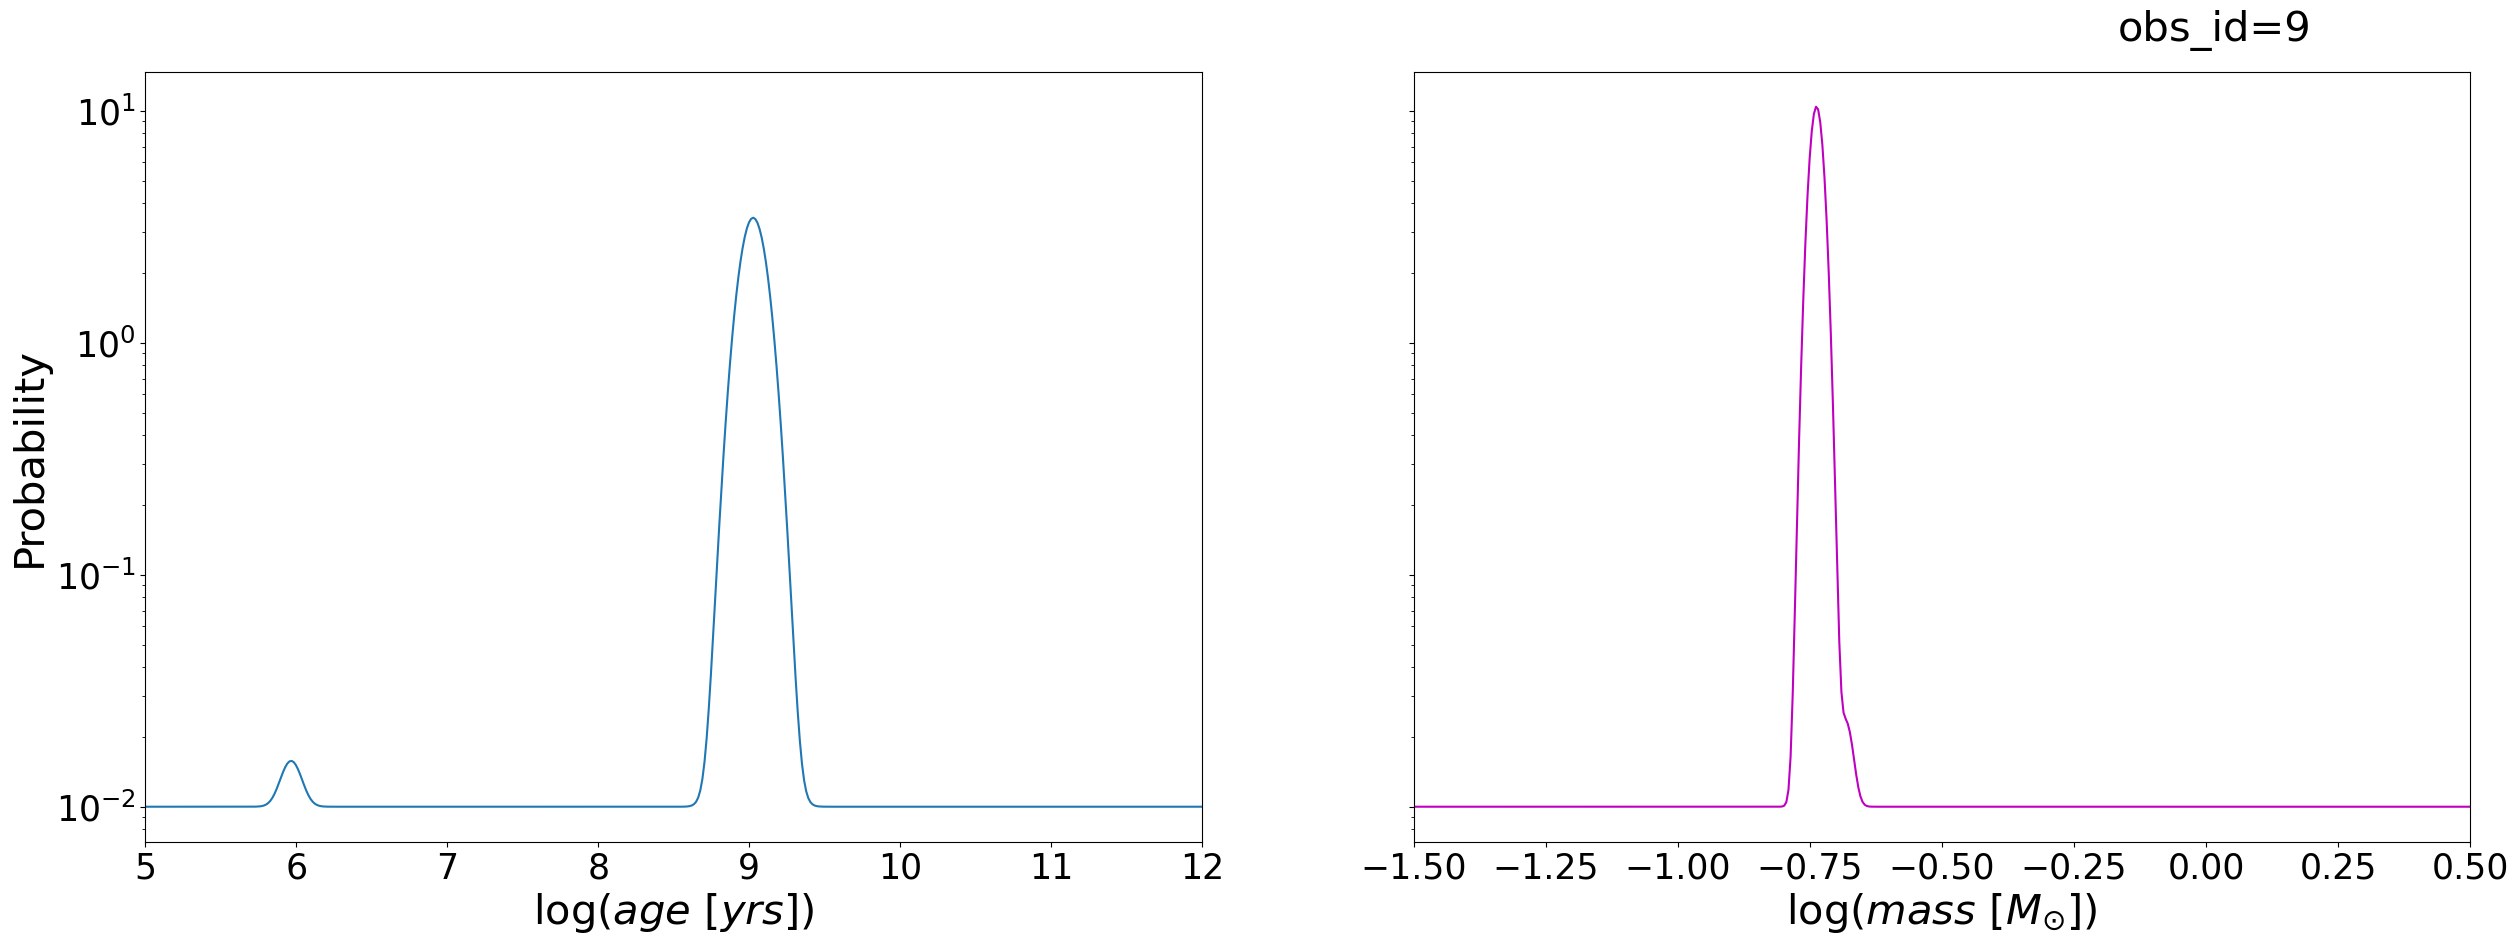

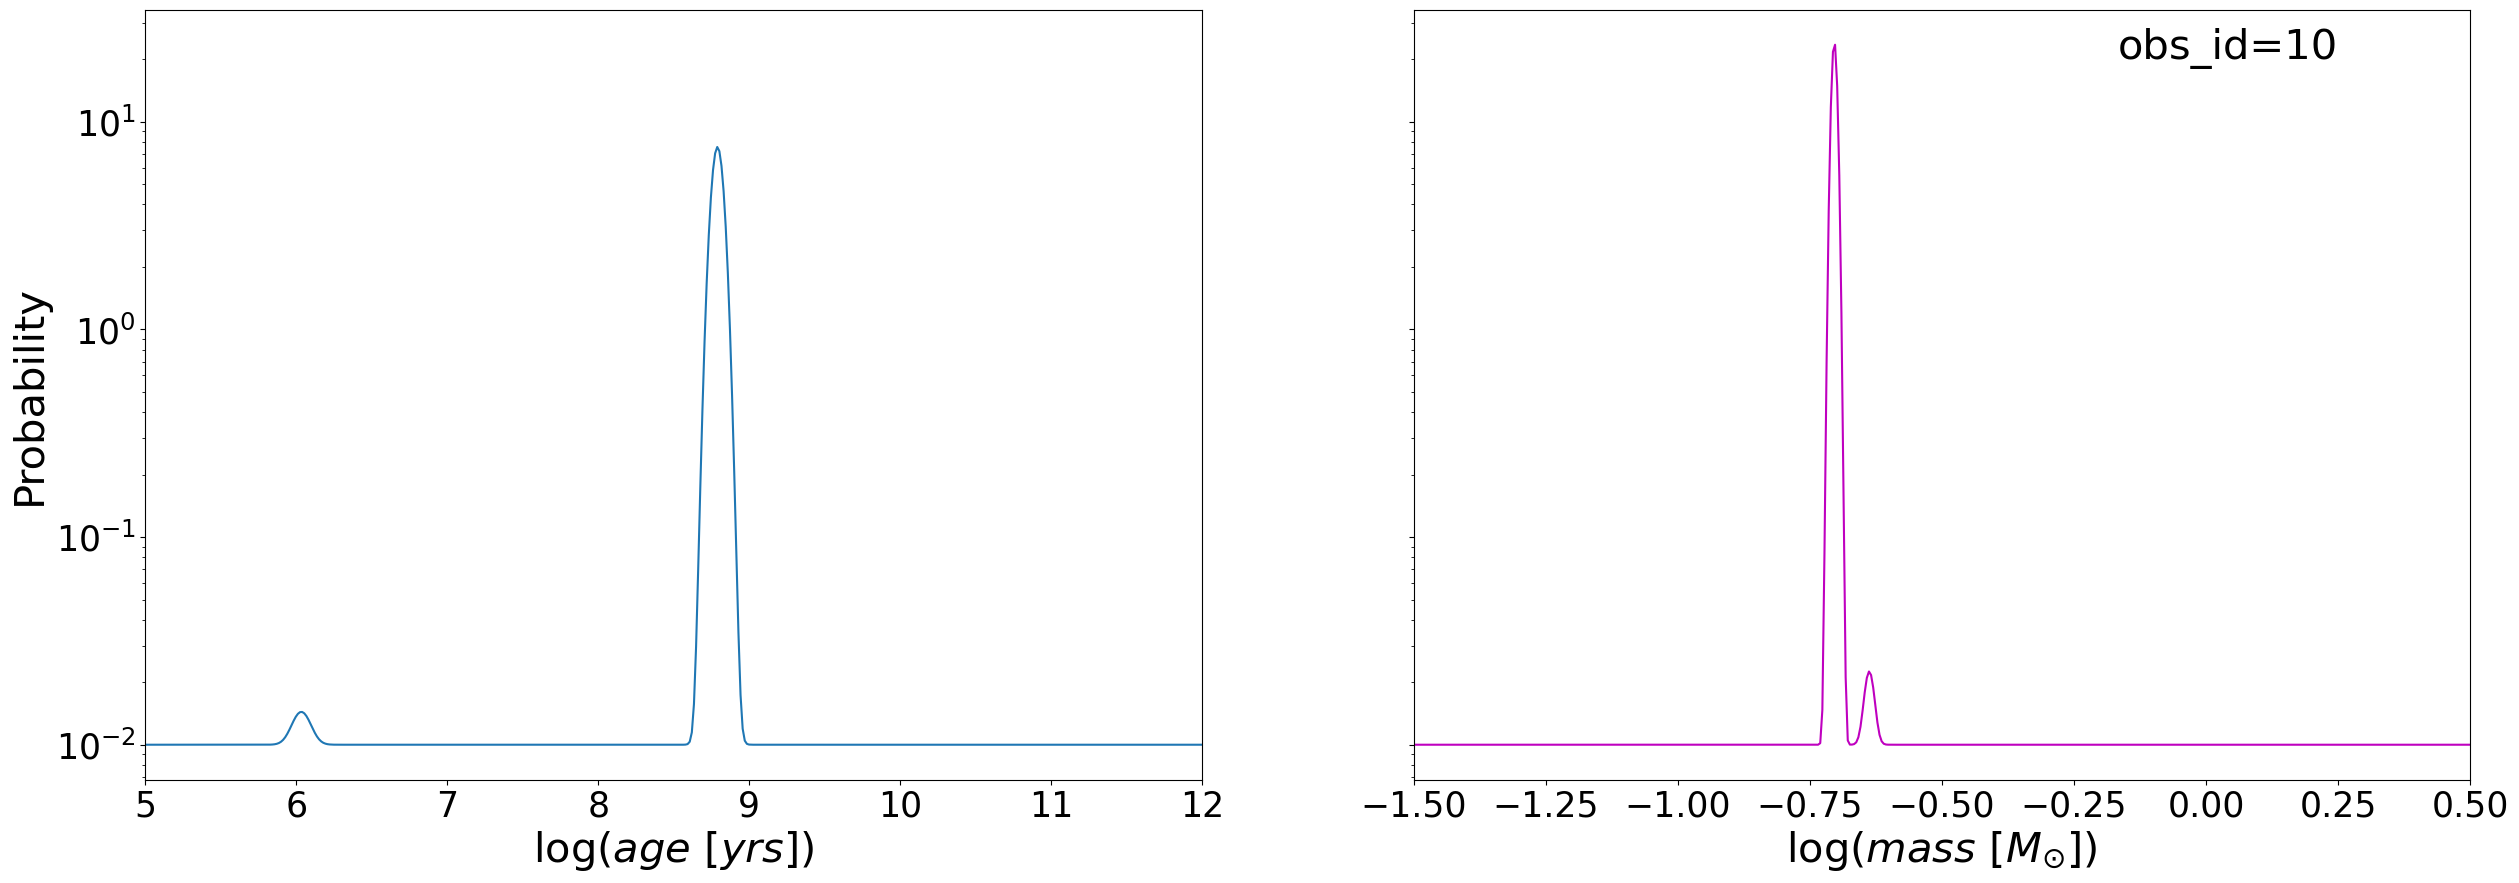

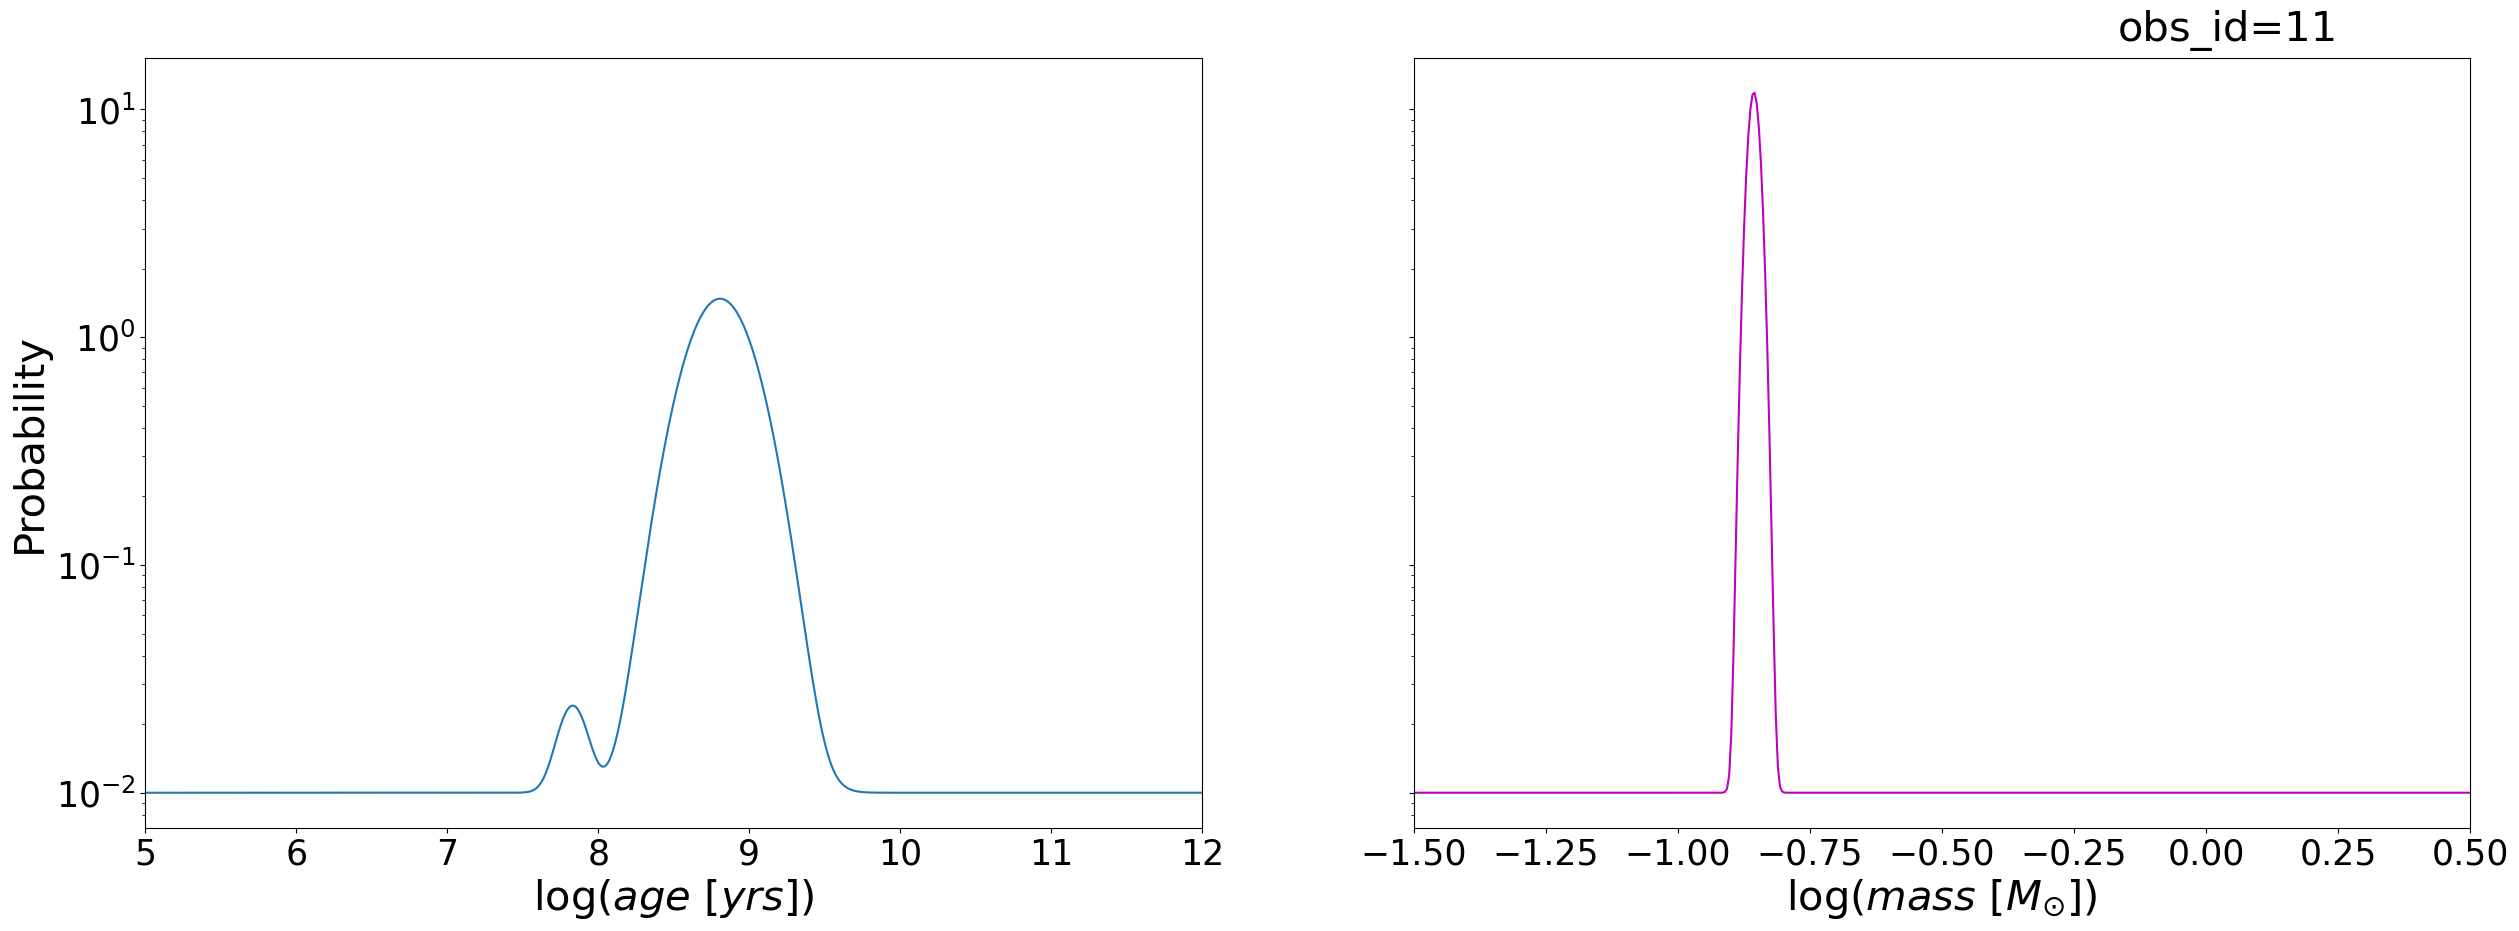

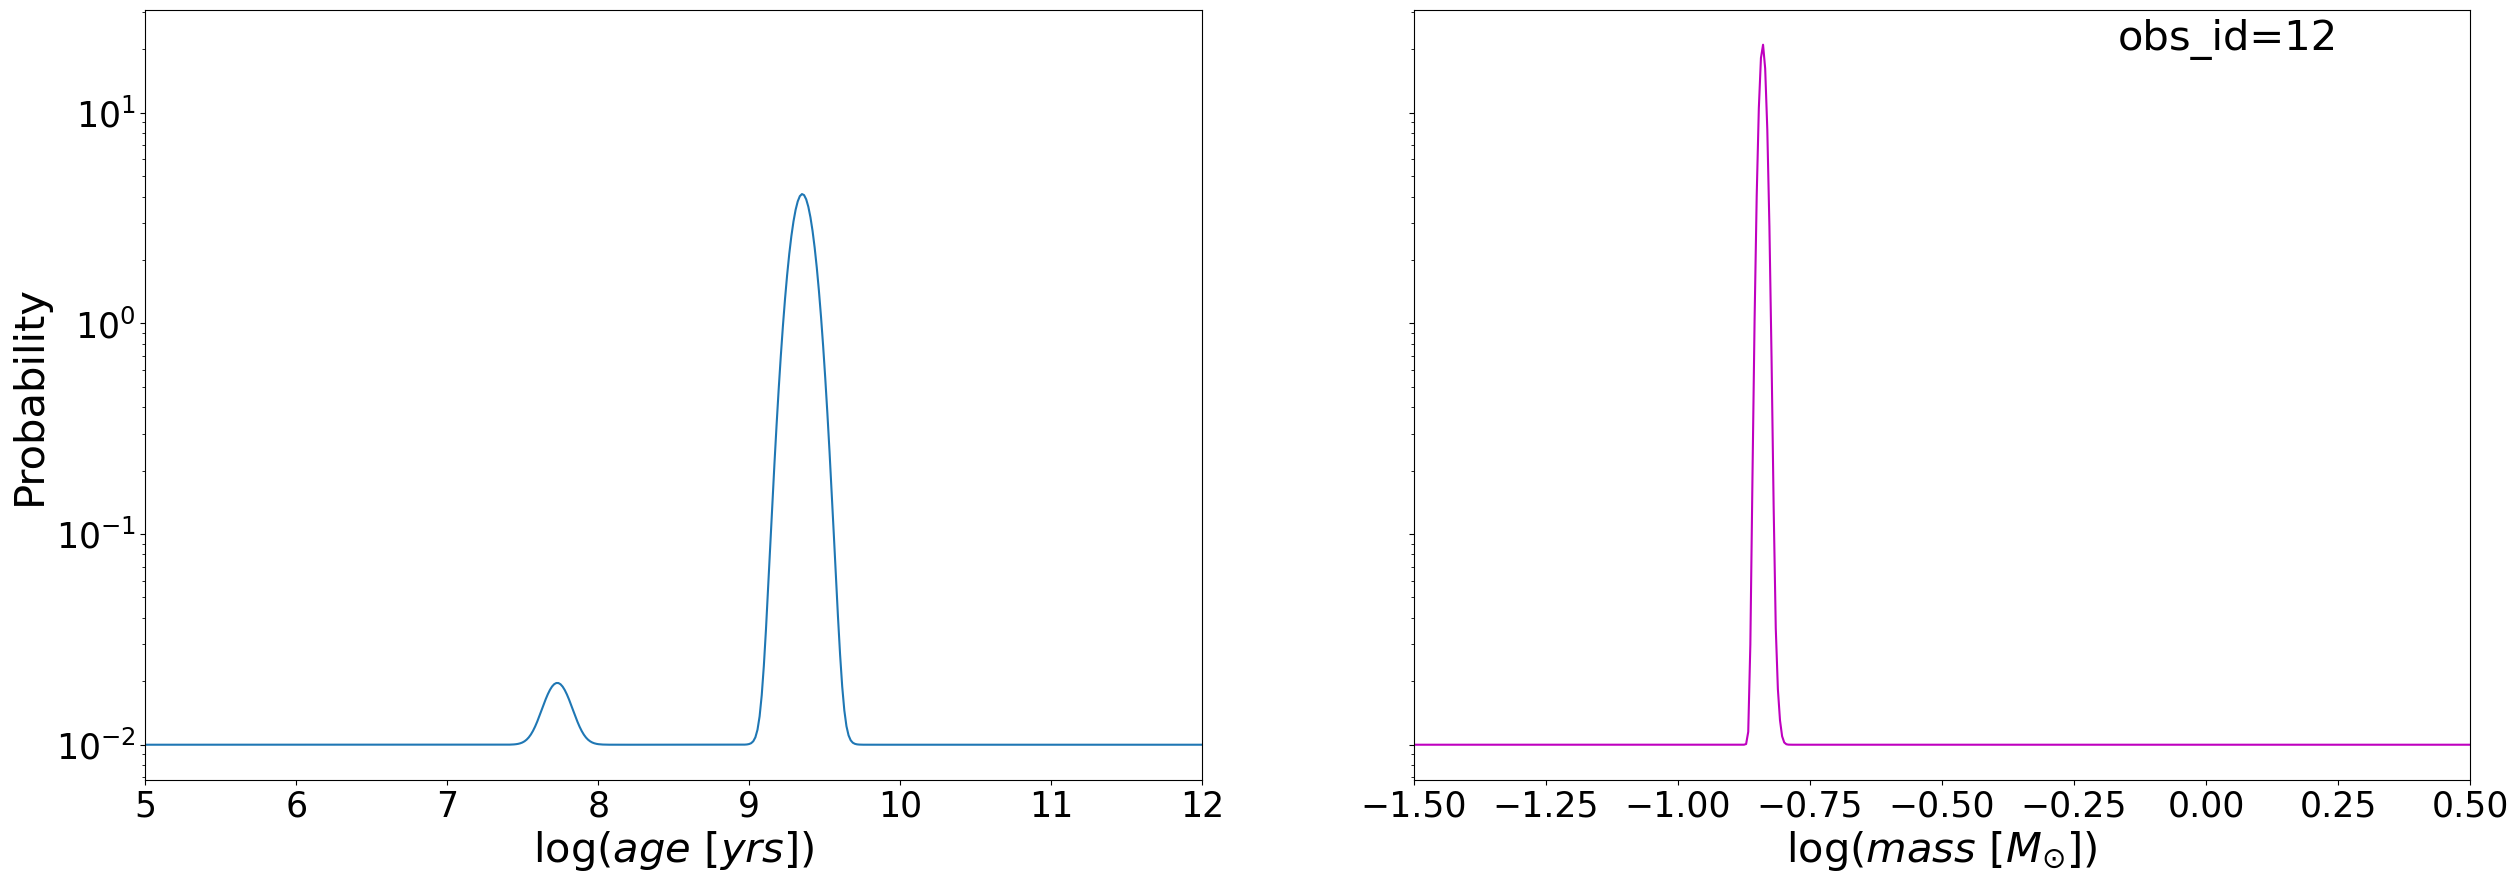

In [38]:
for i in range(0, data.shape[0]):
    st.plot_gaussian_posteriors(y_gaussian_posteriors, i, log_age_range=[5,12], log_mass_range=[-1.5,0.5])

## Subgiants from Godoy-Rivera+2021 (Post-ZAMS)

In [40]:
data_raw = pd.read_csv('Data/postZAMS/G-R.csv') 
df = pd.DataFrame(data_raw)
df['teff_log'] = np.log10(df['Teff'].astype(float))
df['lum_log'] = np.log10(df["Luminosity"].astype(float))

df['ageyr'] = df['Age']*1e+9
df['logAge'] = np.log10(df['ageyr'])
df['logMass'] = np.log10(df['Mass'])

Data = df[['teff_log','lum_log', 'logAge', 'logMass']].dropna().astype(float)


data_x = Data[['teff_log','lum_log']]
data_y = Data[['logAge','logMass']]

data = data_x.values.astype('float')
data_0 = np.copy(data)

### Make predictions

In [41]:
num_NNs = 20 # choose number of bootstraps

# predict:
y_pre, y_post= st.predict(data, n=num_NNs, TL='reu2023')

In [42]:
y_mean_preMS, y_std_preMS = st.stats(y_pre)
y_mean_postMS, y_std_postMS = st.stats(y_post)

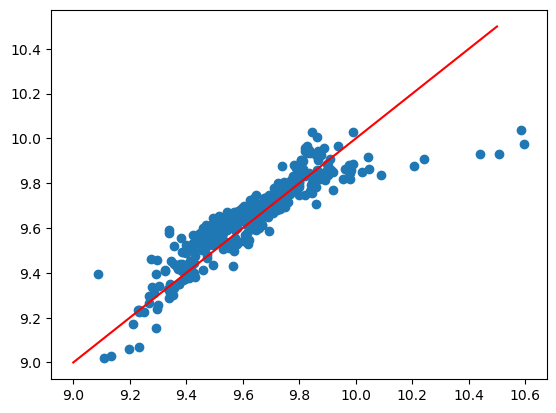

In [44]:
fig, ax = plt.subplots()

x = y_mean_postMS[:,0] # predicted
y = data_y['logAge']

ax.scatter(x,y)

z = np.linspace(9,10.5,2)
ax.plot(z,z,color='r')

### Mixture of models

In [45]:
pi_pre, pi_post = st.pis(y_mean_preMS, y_mean_postMS)

In [46]:
# Get posteriors:
y_post = st.posteriors(y_pre , y_post, pi_pre, pi_post, n=num_NNs)

### Posteriors

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='Observation id', ylabel='$\\log(mass)$ [$M_{\\odot}$]'>],
      dtype=object)

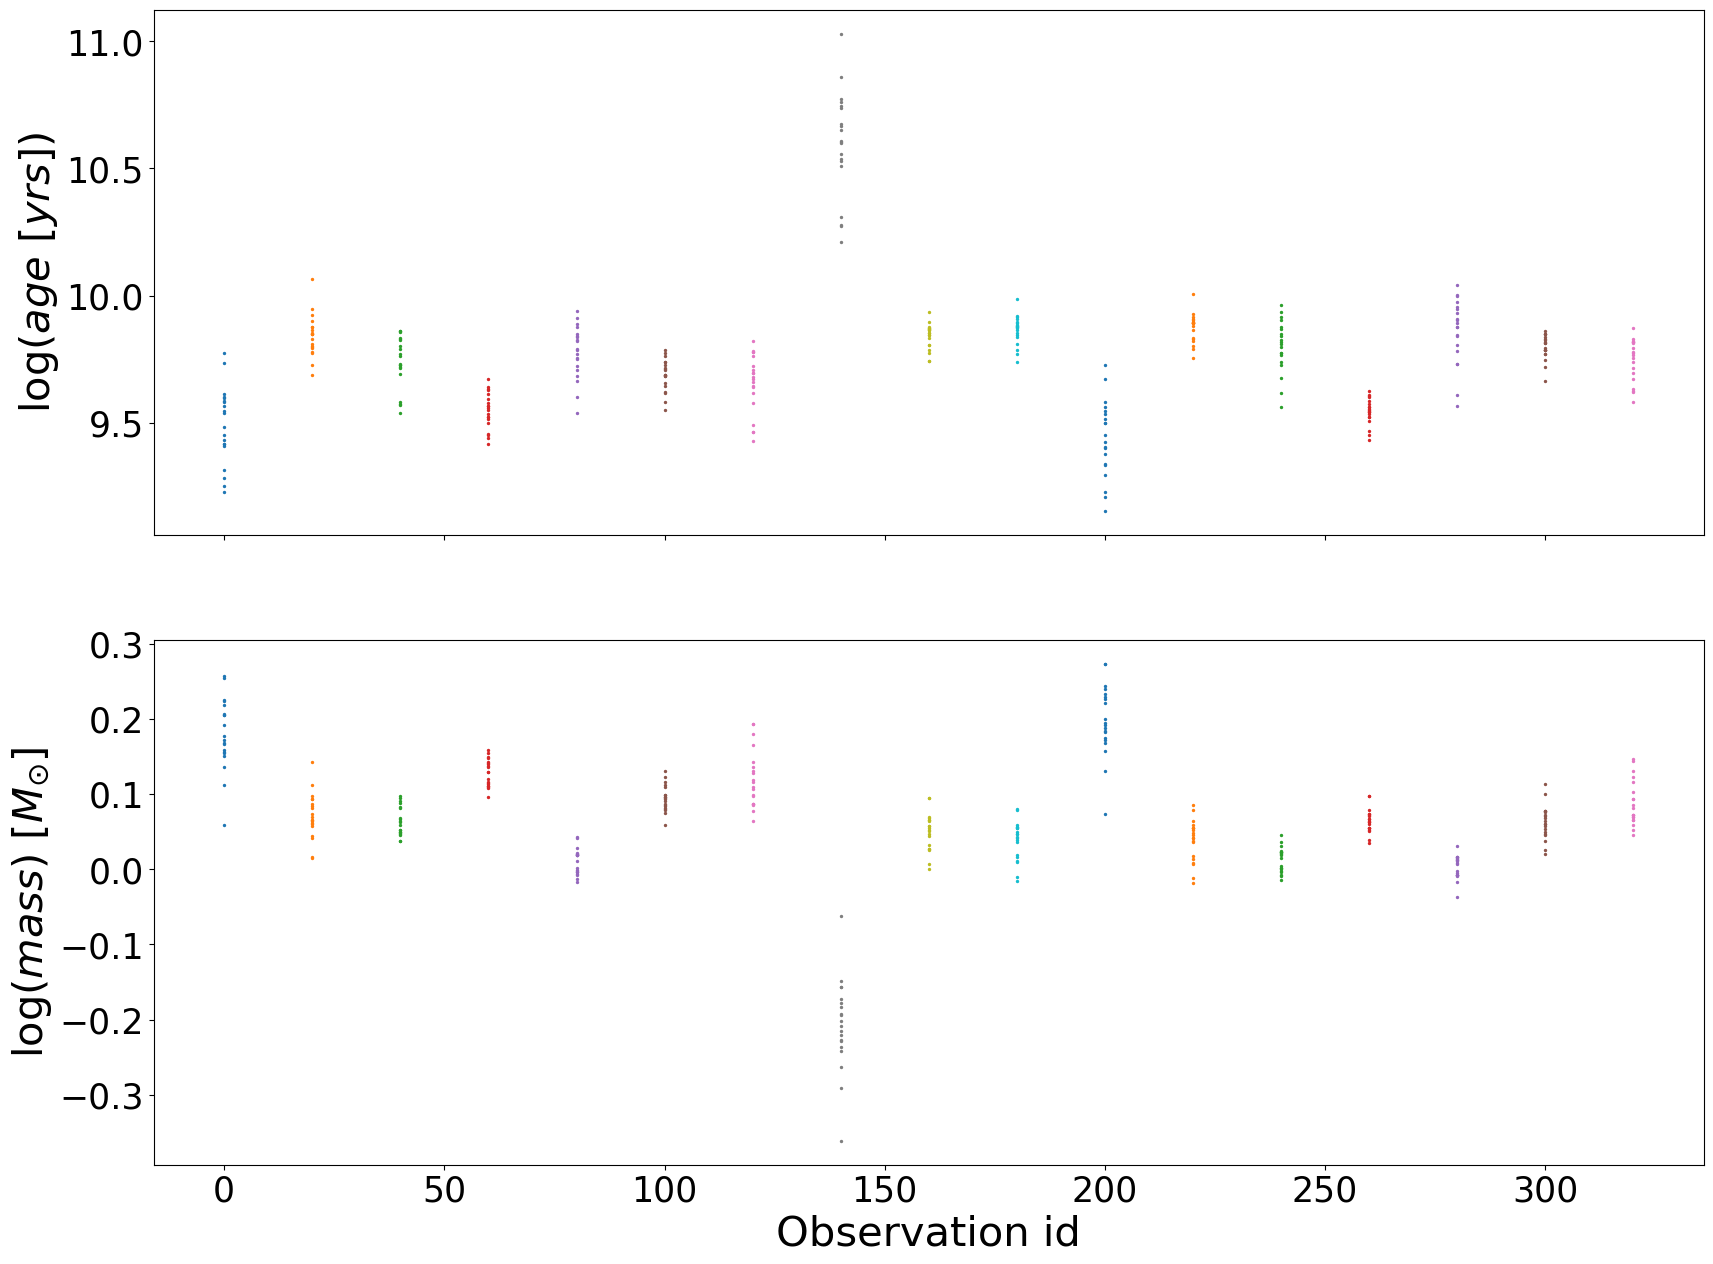

In [52]:
st.plot_multiple_posteriors(y_post, [i for i in range(0, data.shape[0],20)])

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='model number', ylabel='$\\log(mass \\ [M_{\\odot}])$'>],
      dtype=object)

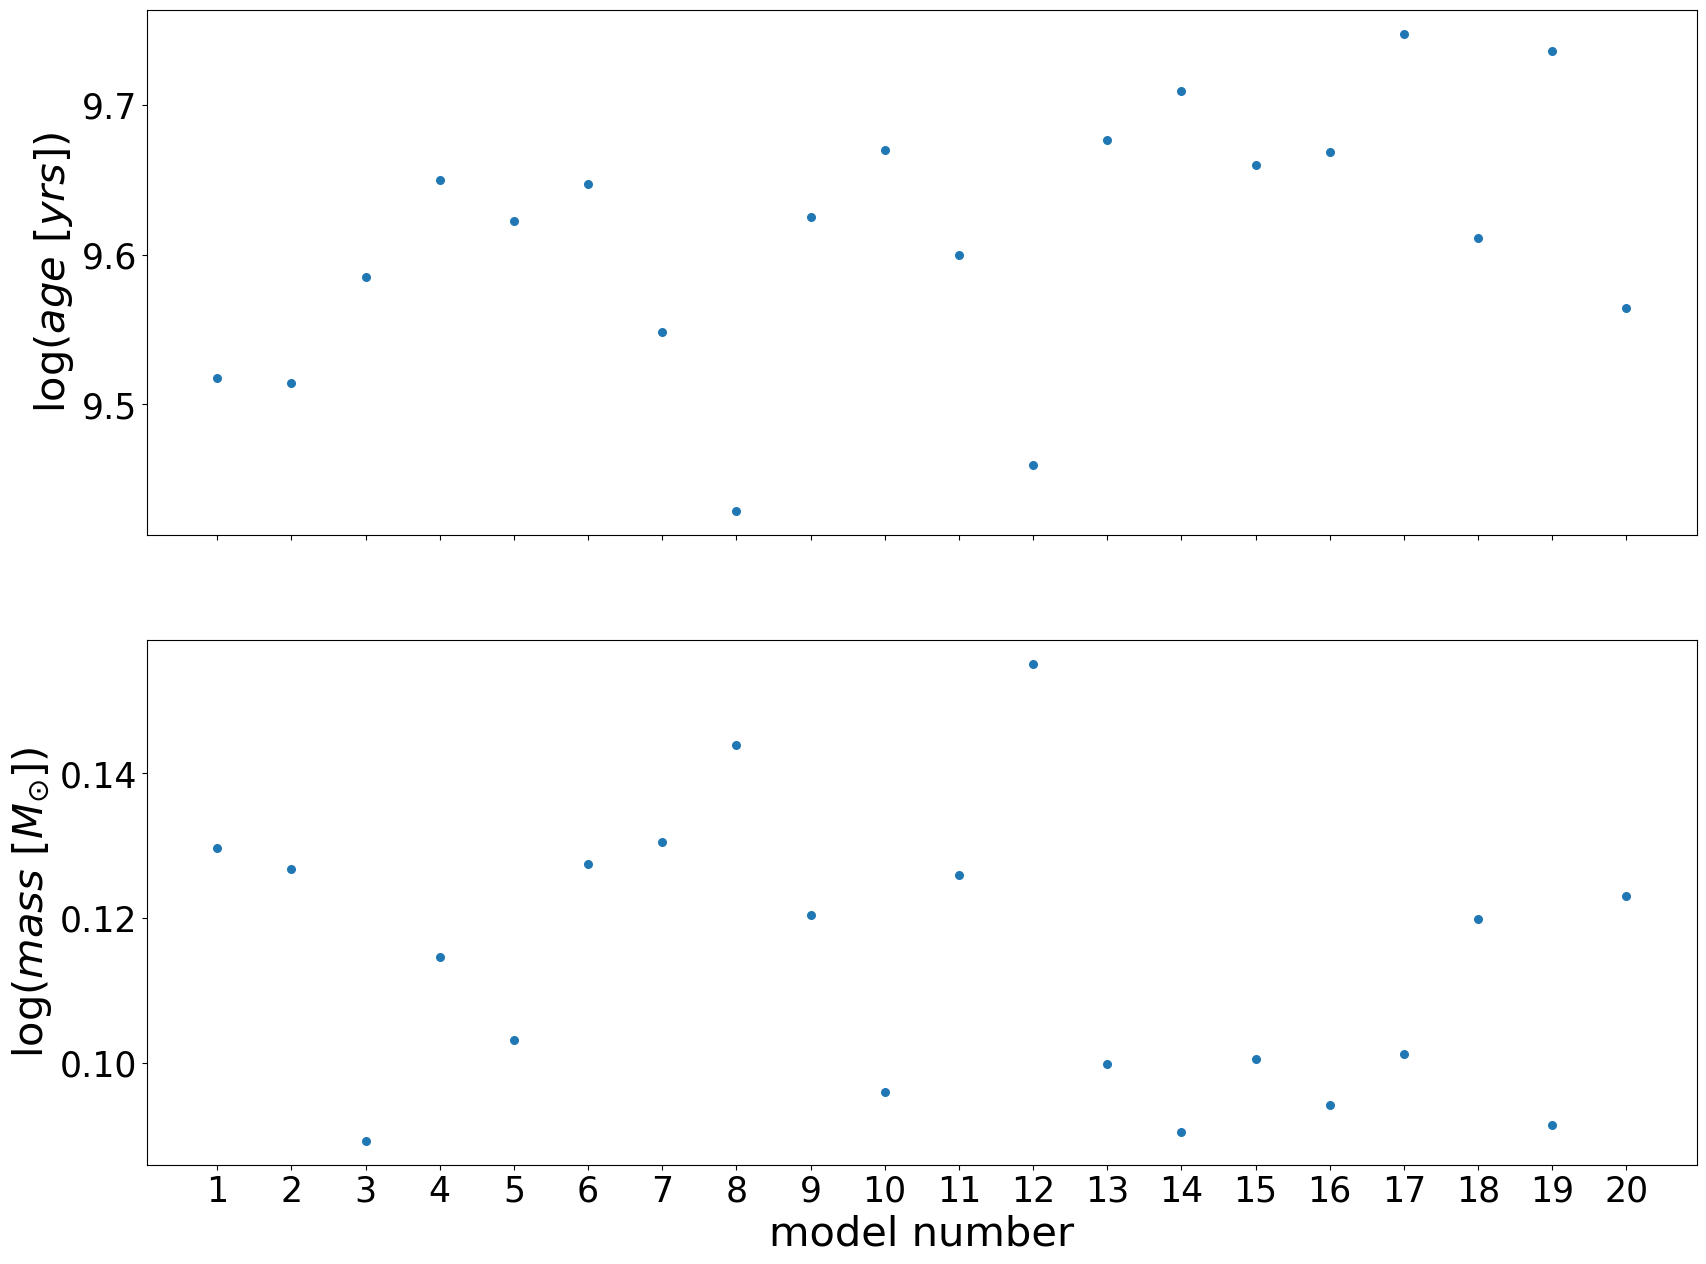

In [53]:
st.plot_posterior(y_post, 15) 

array([<Axes: xlabel='$\\log(age \\ [yrs])$', ylabel='number of predictions'>,
       <Axes: xlabel='$\\log(mass \\ [M_{\\odot}])$'>], dtype=object)

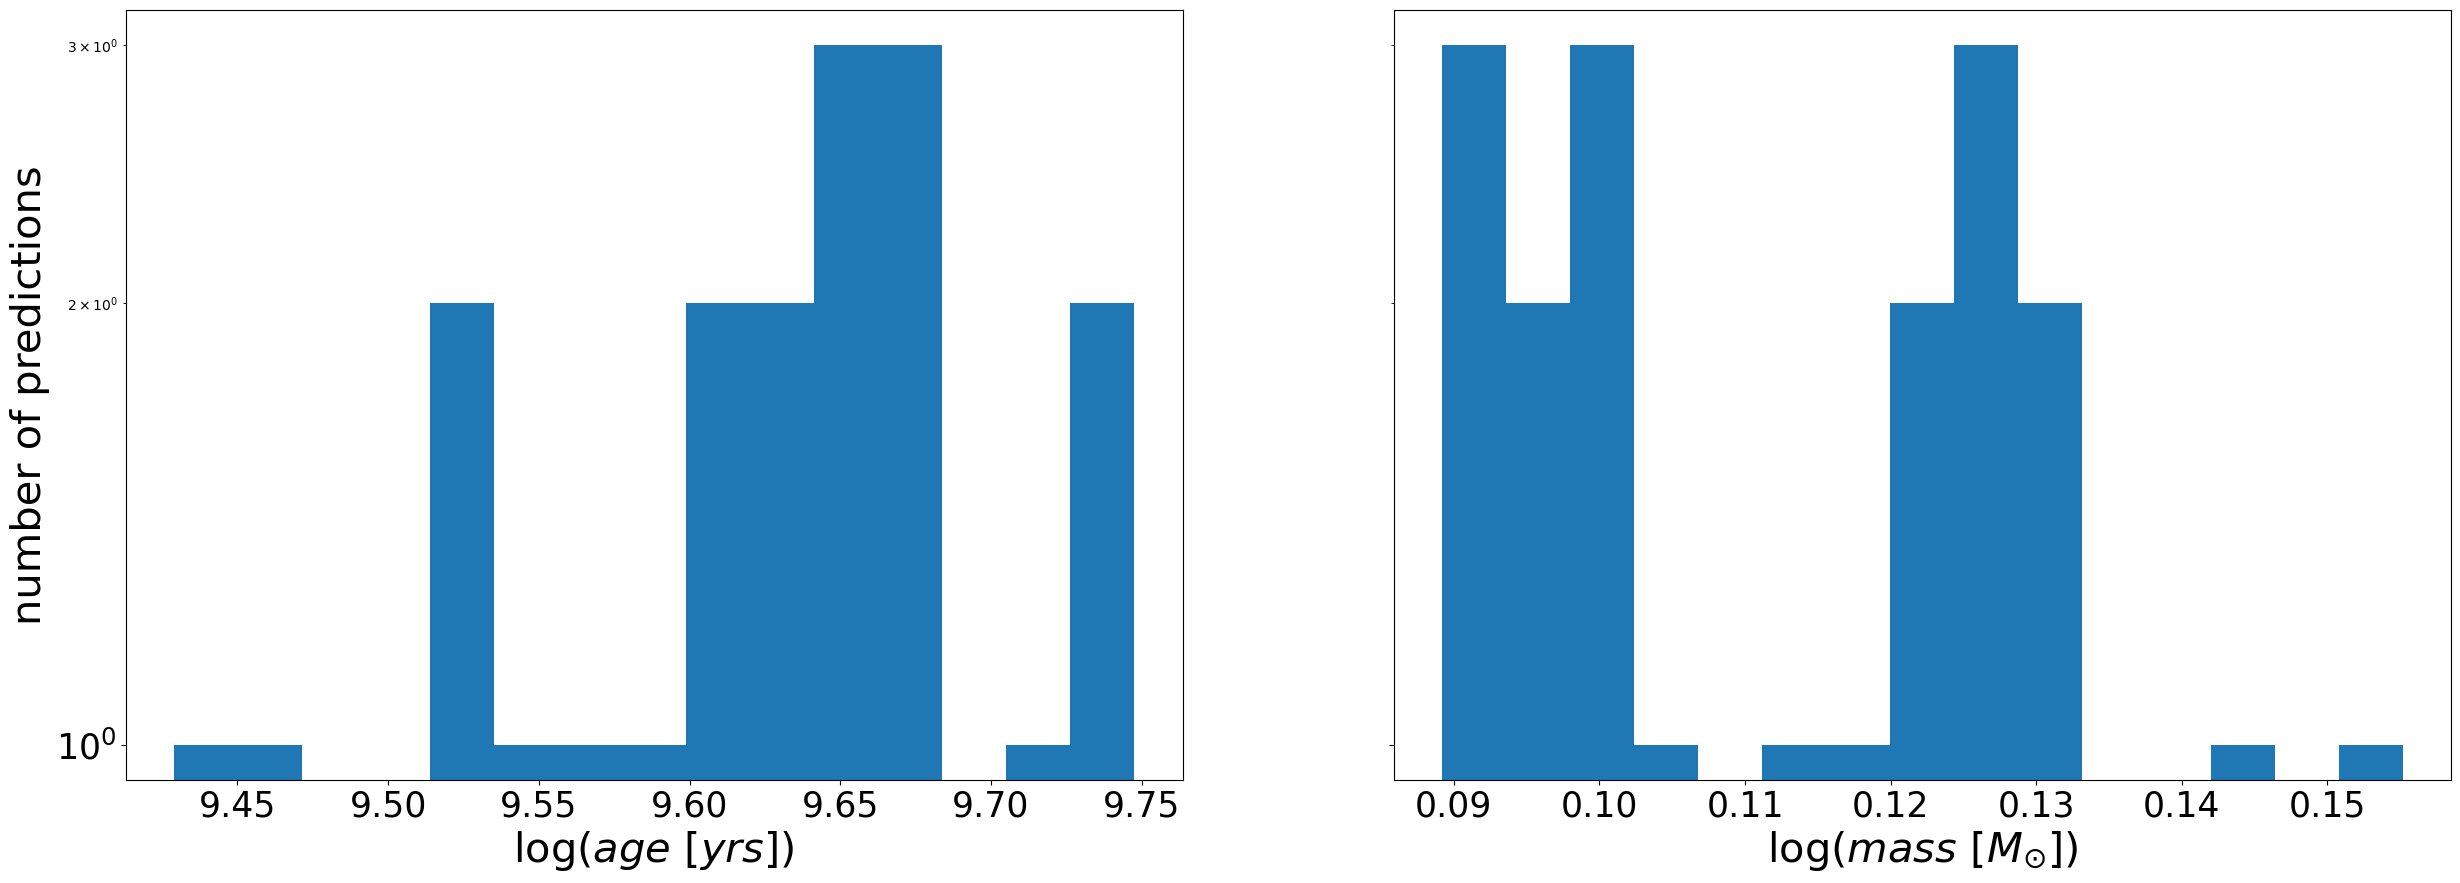

In [54]:
st.plot_posterior_hist(y_post, 15)

### Gaussian Posteriors

In [55]:
y_gaussian_posteriors=st.Gaussian_posteriors(y_mean_preMS, y_mean_postMS, y_std_preMS, y_std_postMS, pi_pre, pi_post, n_obs=data.shape[0], num_x_points=500)

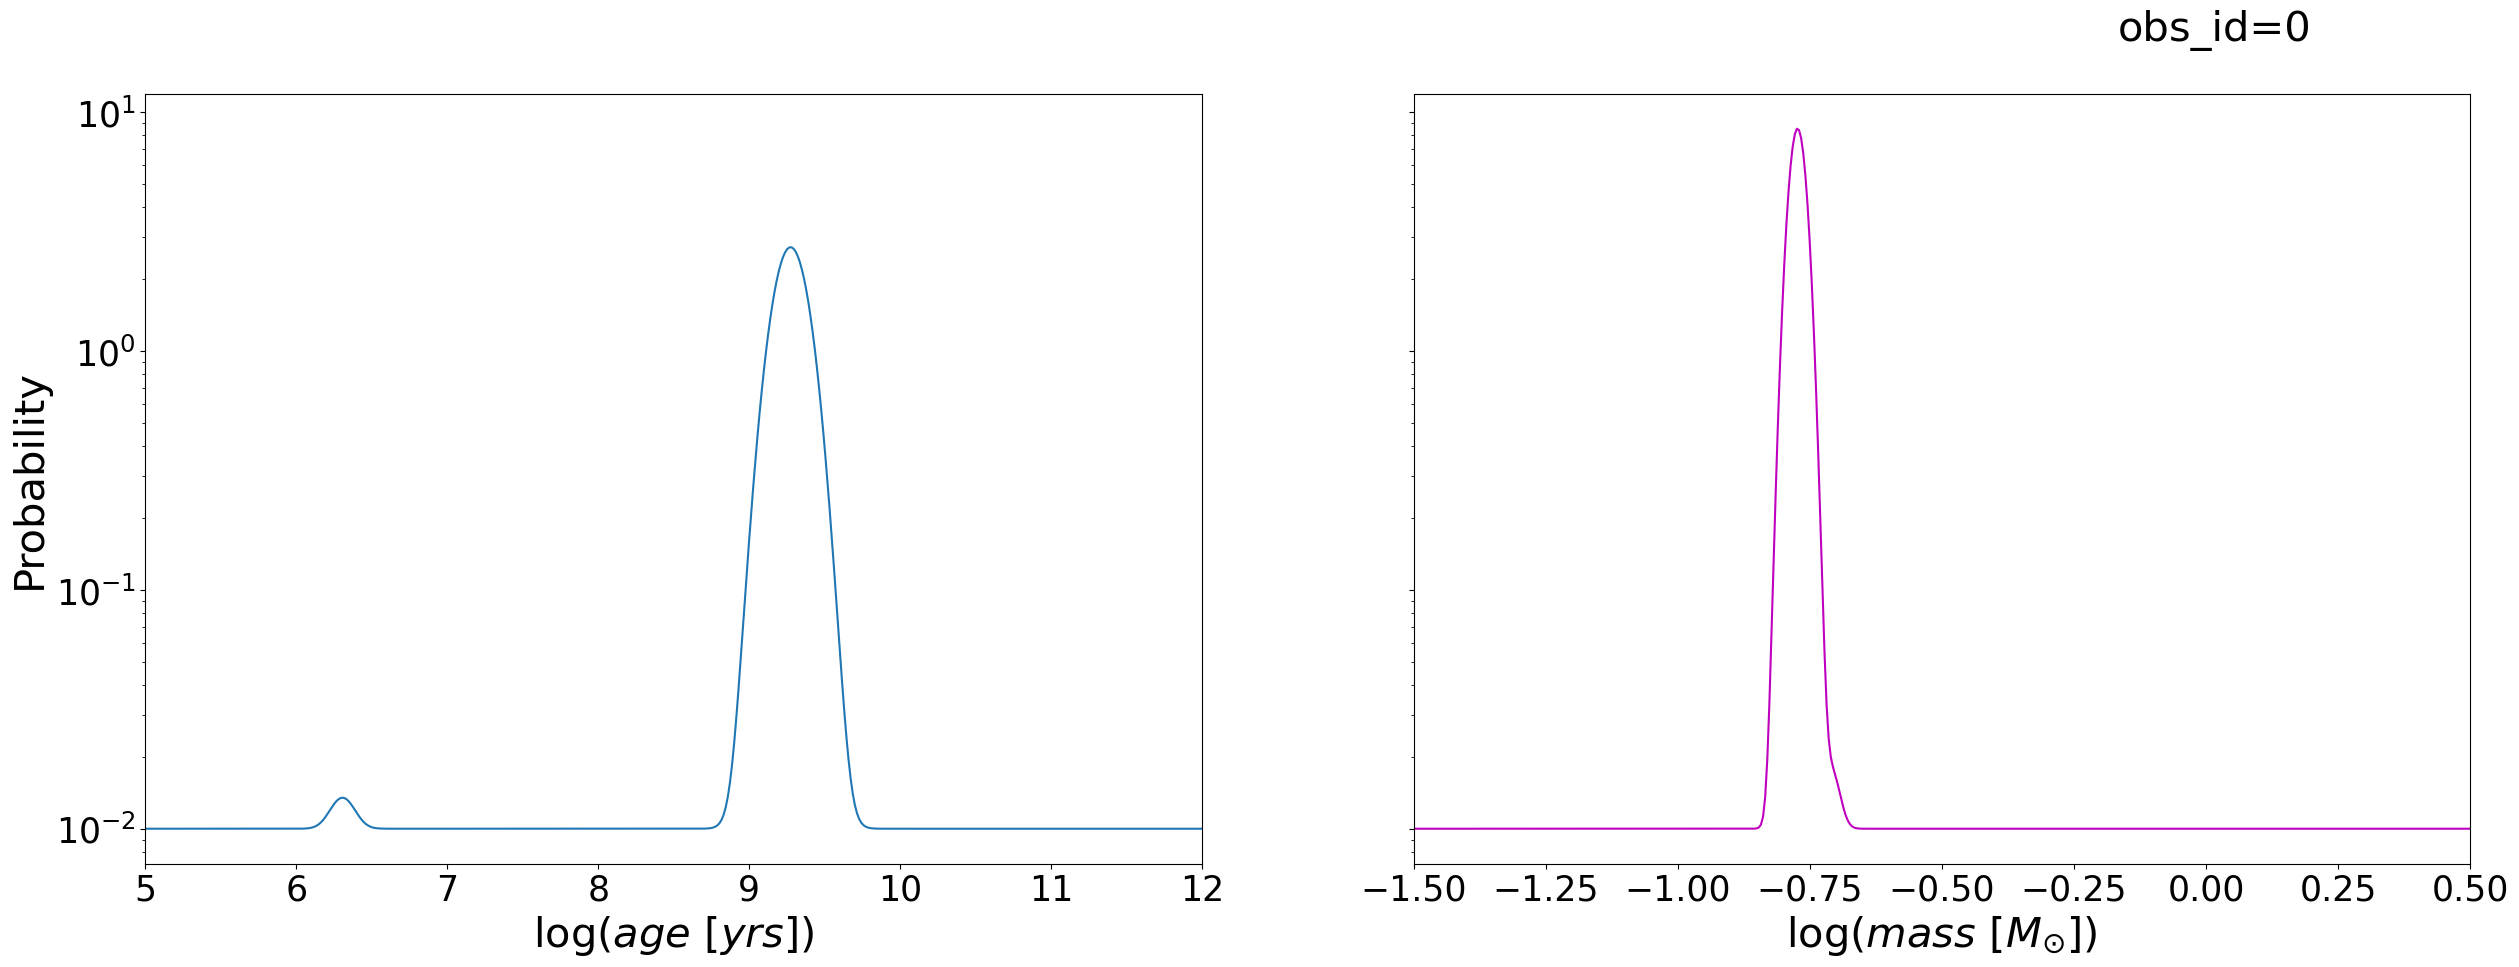

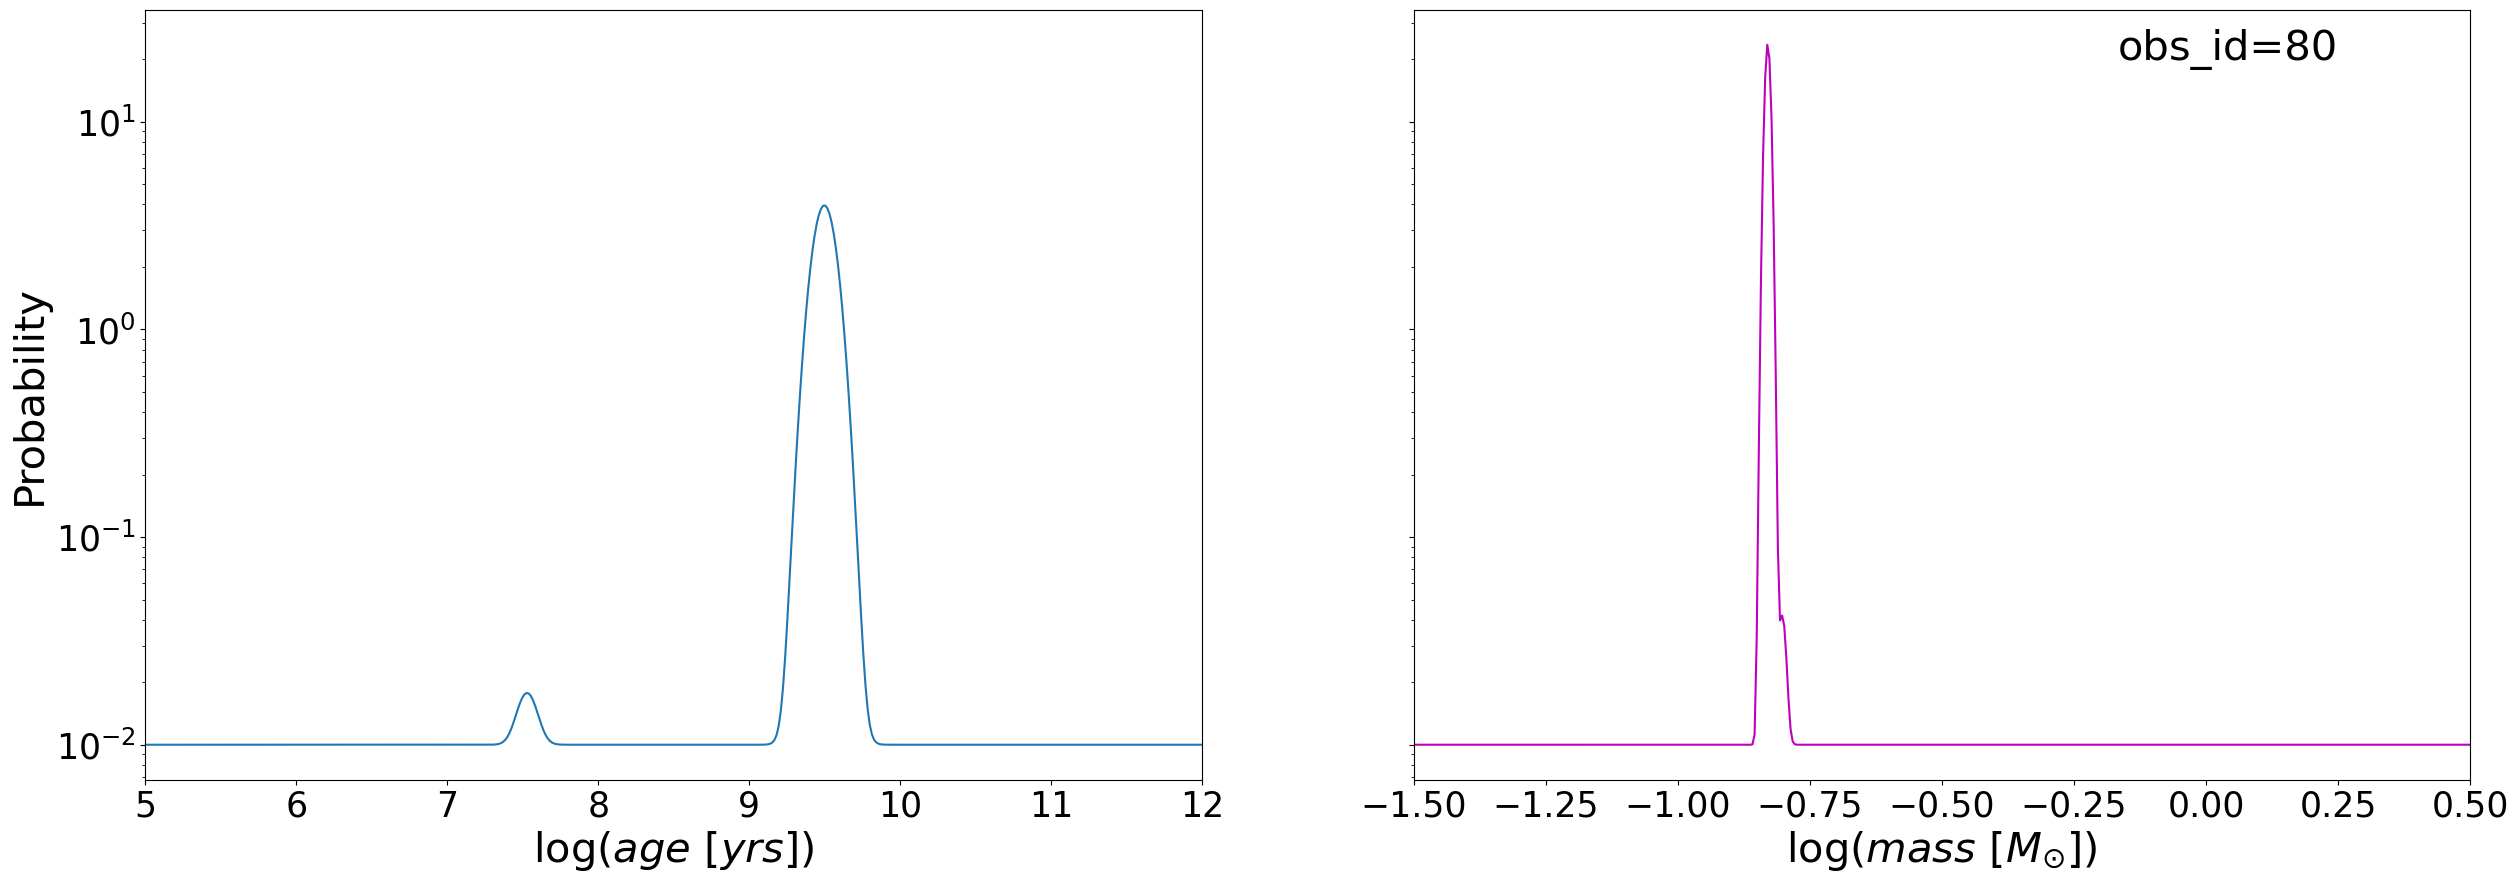

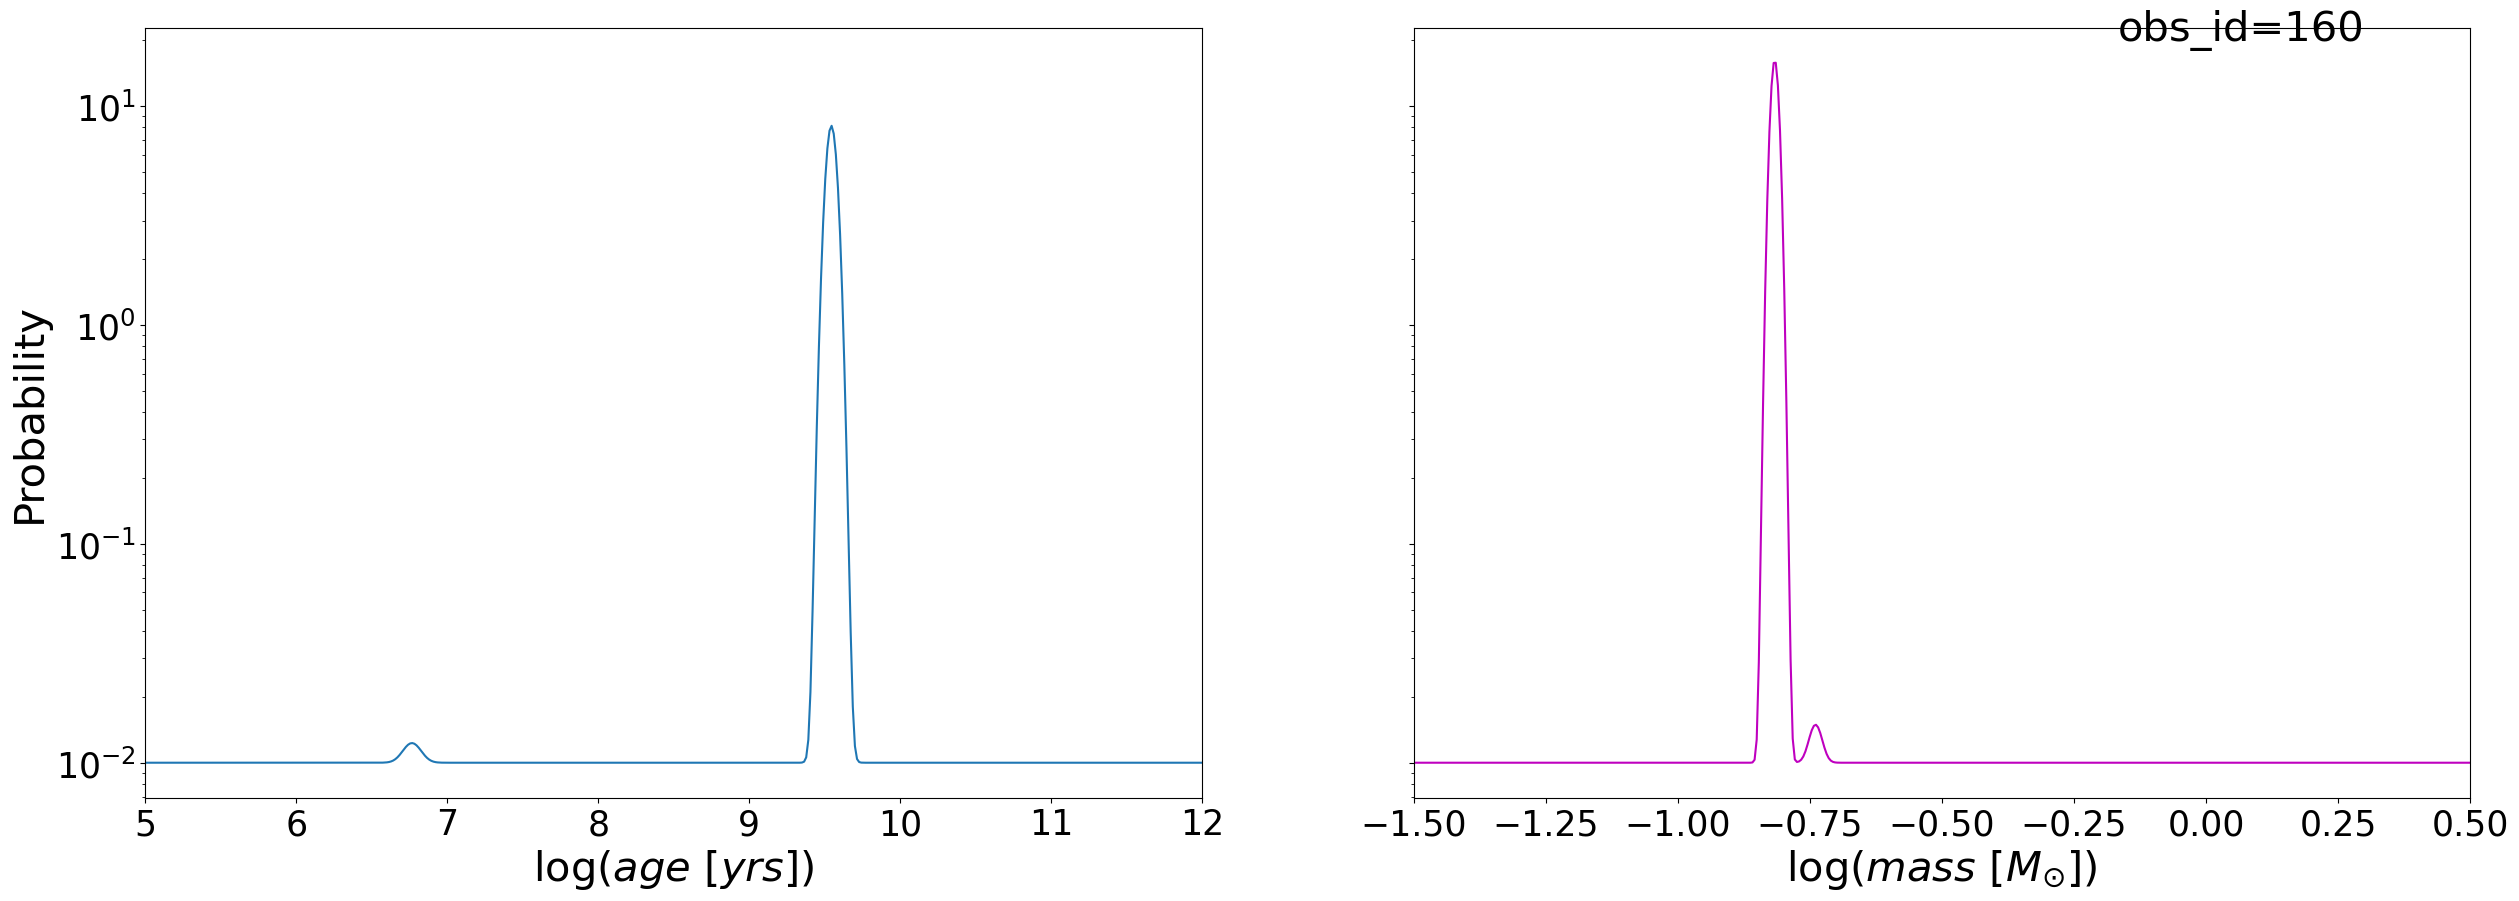

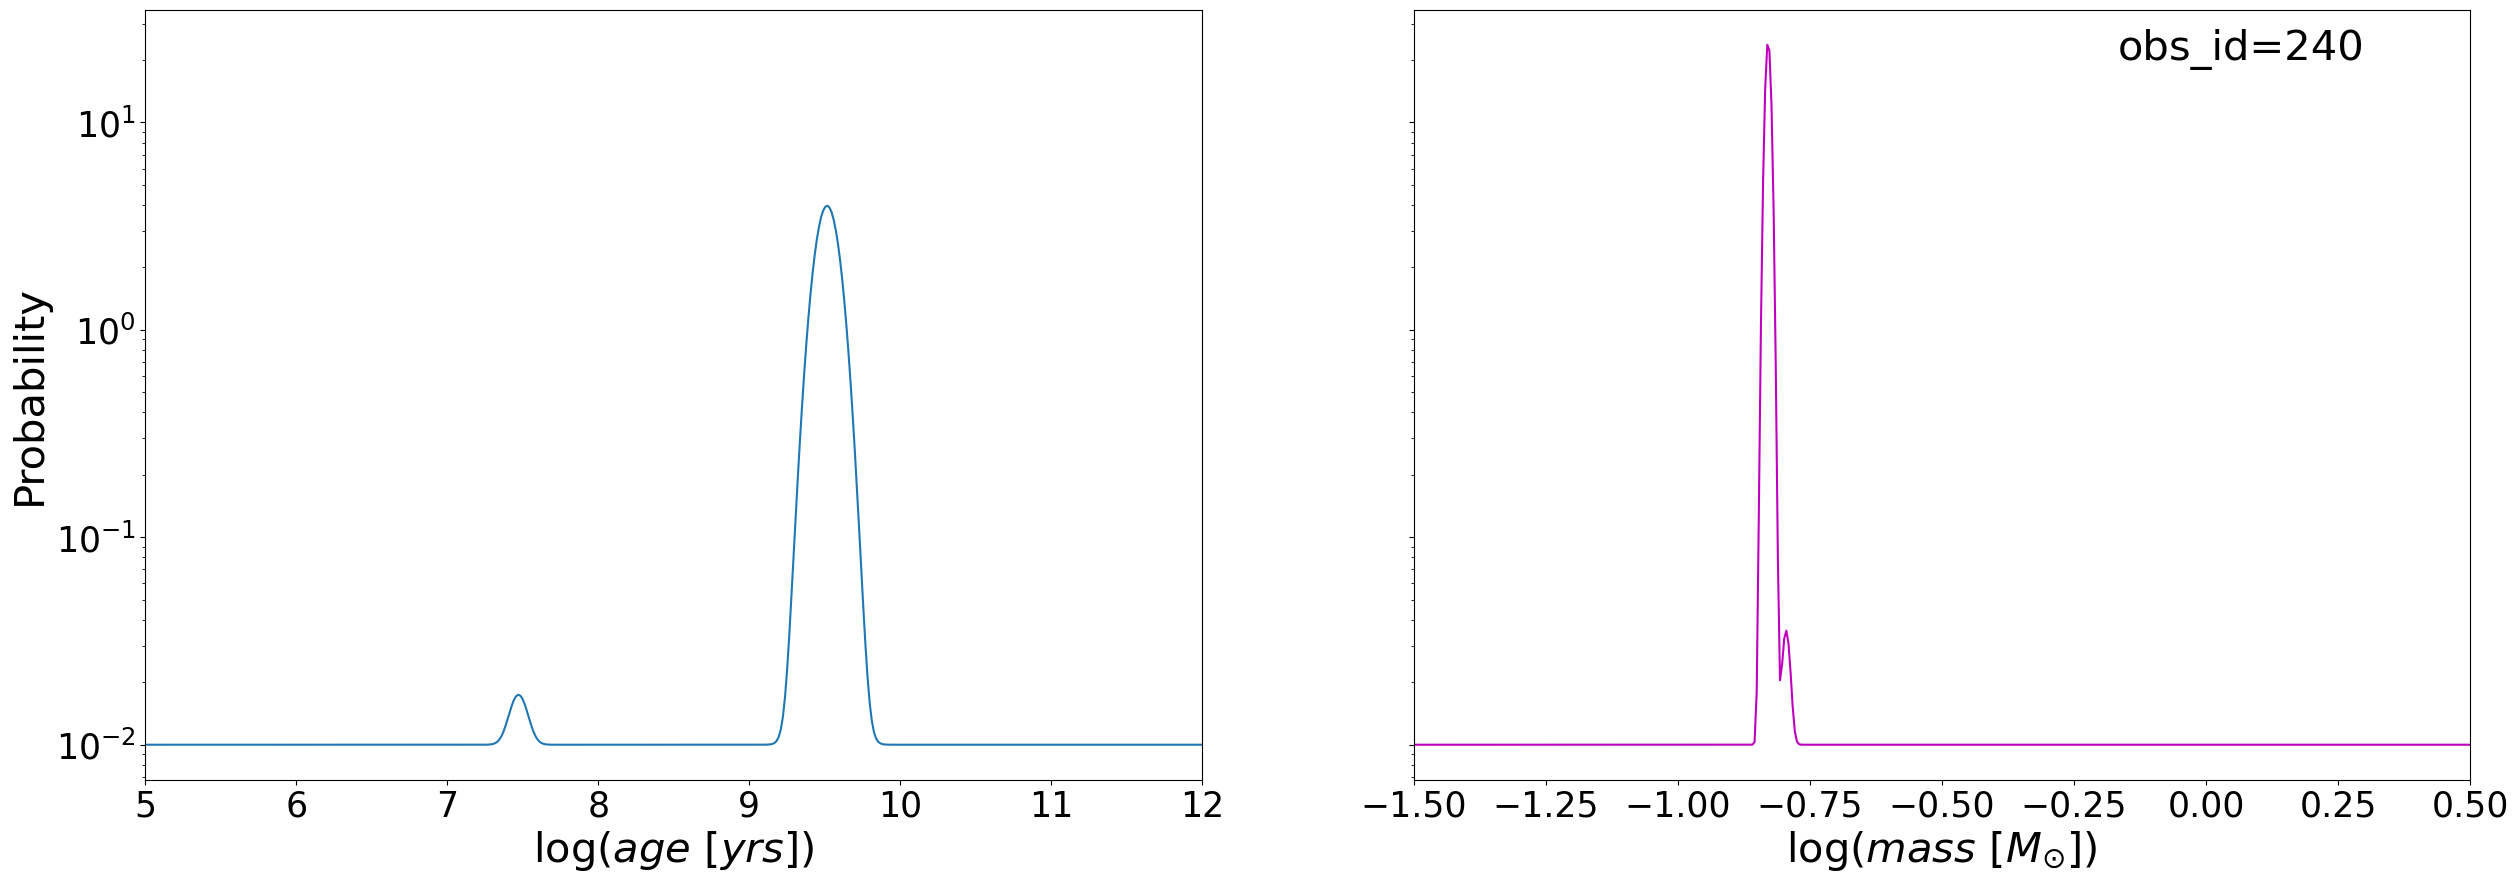

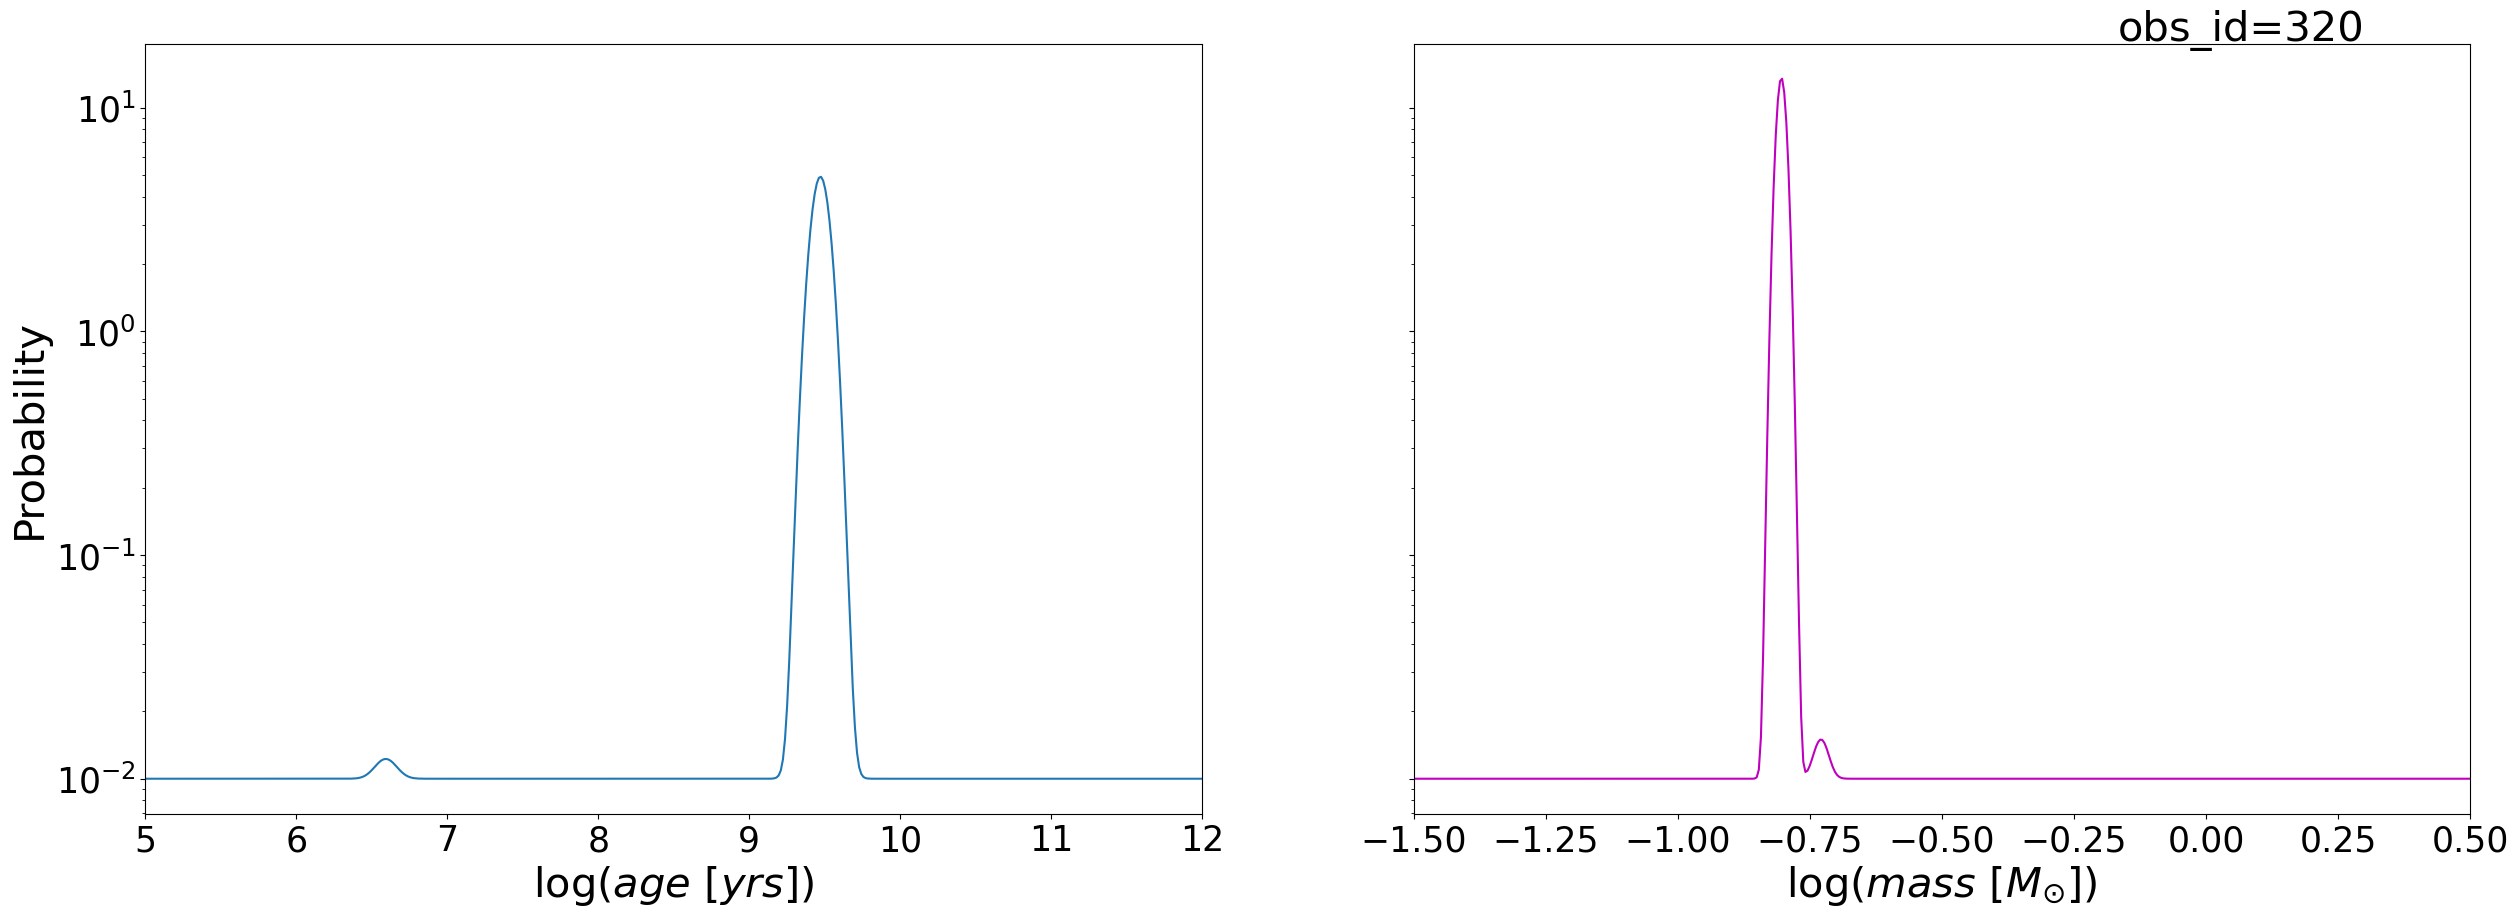

In [56]:
for i in range(0, data.shape[0], 80):
    st.plot_gaussian_posteriors(y_gaussian_posteriors, i, log_age_range=[5,12], log_mass_range=[-1.5,0.5])

## Orion Nebula Cluster (Pre-ZAMS)

In [57]:
data_raw = pd.read_csv('Data/preZAMS/ONC.csv') 
df = pd.DataFrame(data_raw)
df['teff_log'] = df['logTeff'].astype(float)
df['lum_log'] = df["logLum"].astype(float)

# logAge column already exists
df['logMass'] = np.log10(df['Mass'])

Data = df[['teff_log','lum_log', 'logAge', 'logMass']].dropna().astype(float)


data_x = Data[['teff_log','lum_log']]
data_y = Data[['logAge','logMass']]

data = data_x.values.astype('float')
data_0 = np.copy(data)

### Make predictions

In [58]:
num_NNs = 20 # choose number of bootstraps

# predict:
y_pre, y_post= st.predict(data, n=num_NNs, TL='reu2023')

In [59]:
y_mean_preMS, y_std_preMS = st.stats(y_pre)
y_mean_postMS, y_std_postMS = st.stats(y_post)

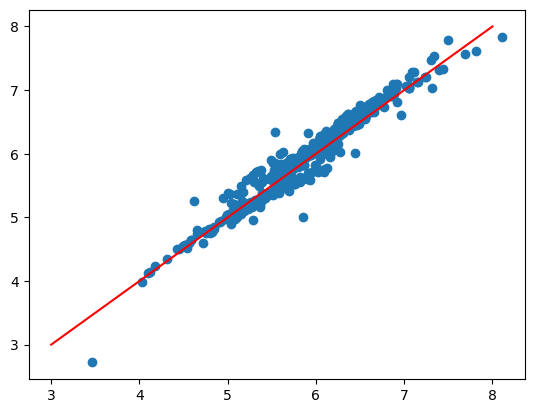

In [62]:
fig, ax = plt.subplots()

x = y_mean_preMS[:,0] # predicted
y = data_y['logAge']

ax.scatter(x,y)

z = np.linspace(3,8,2)
ax.plot(z,z,color='r')

### Mixture of Models

In [63]:
pi_pre, pi_post = st.pis(y_mean_preMS, y_mean_postMS)

In [64]:
# Get posteriors:
y_post = st.posteriors(y_pre , y_post, pi_pre, pi_post, n=num_NNs)

### Posteriors

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='Observation id', ylabel='$\\log(mass)$ [$M_{\\odot}$]'>],
      dtype=object)

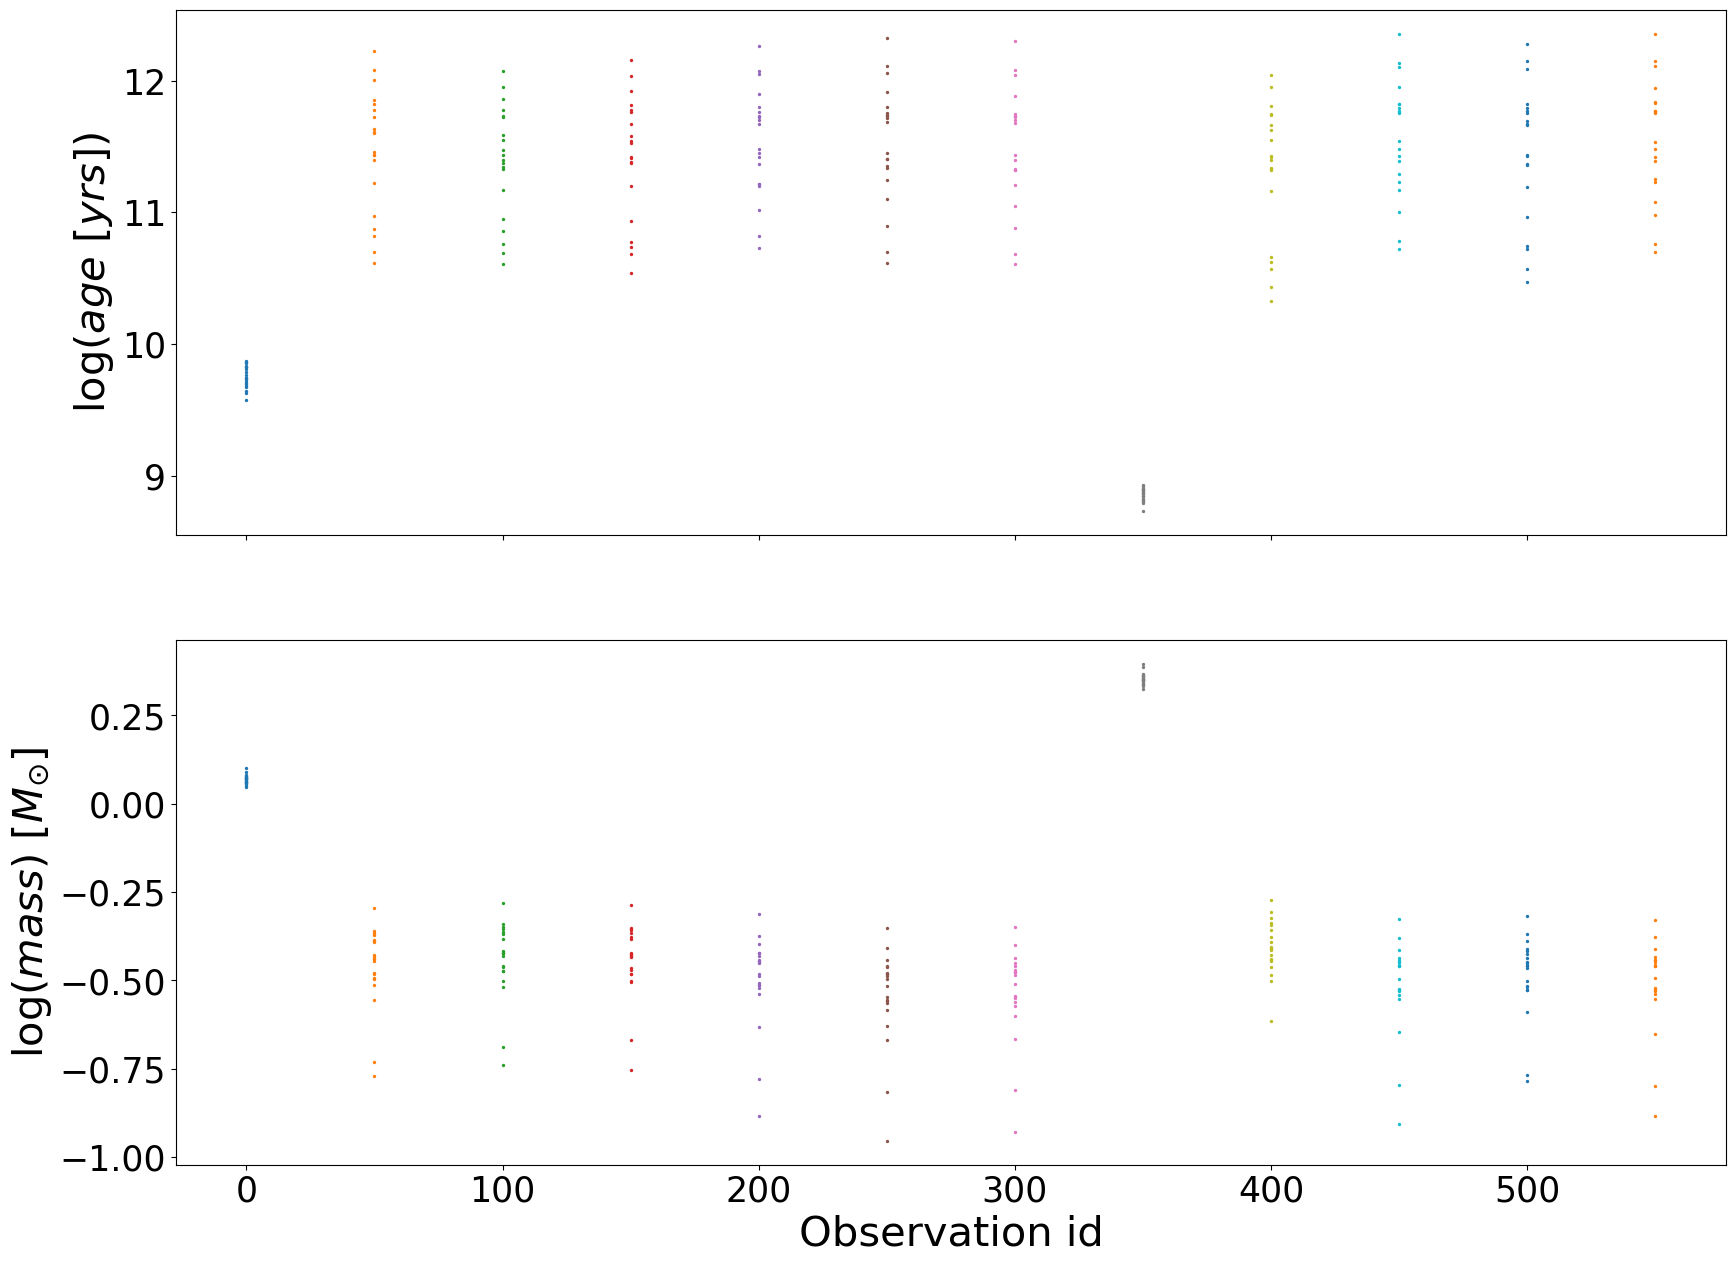

In [67]:
st.plot_multiple_posteriors(y_post, [i for i in range(0, data.shape[0],50)])

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='model number', ylabel='$\\log(mass \\ [M_{\\odot}])$'>],
      dtype=object)

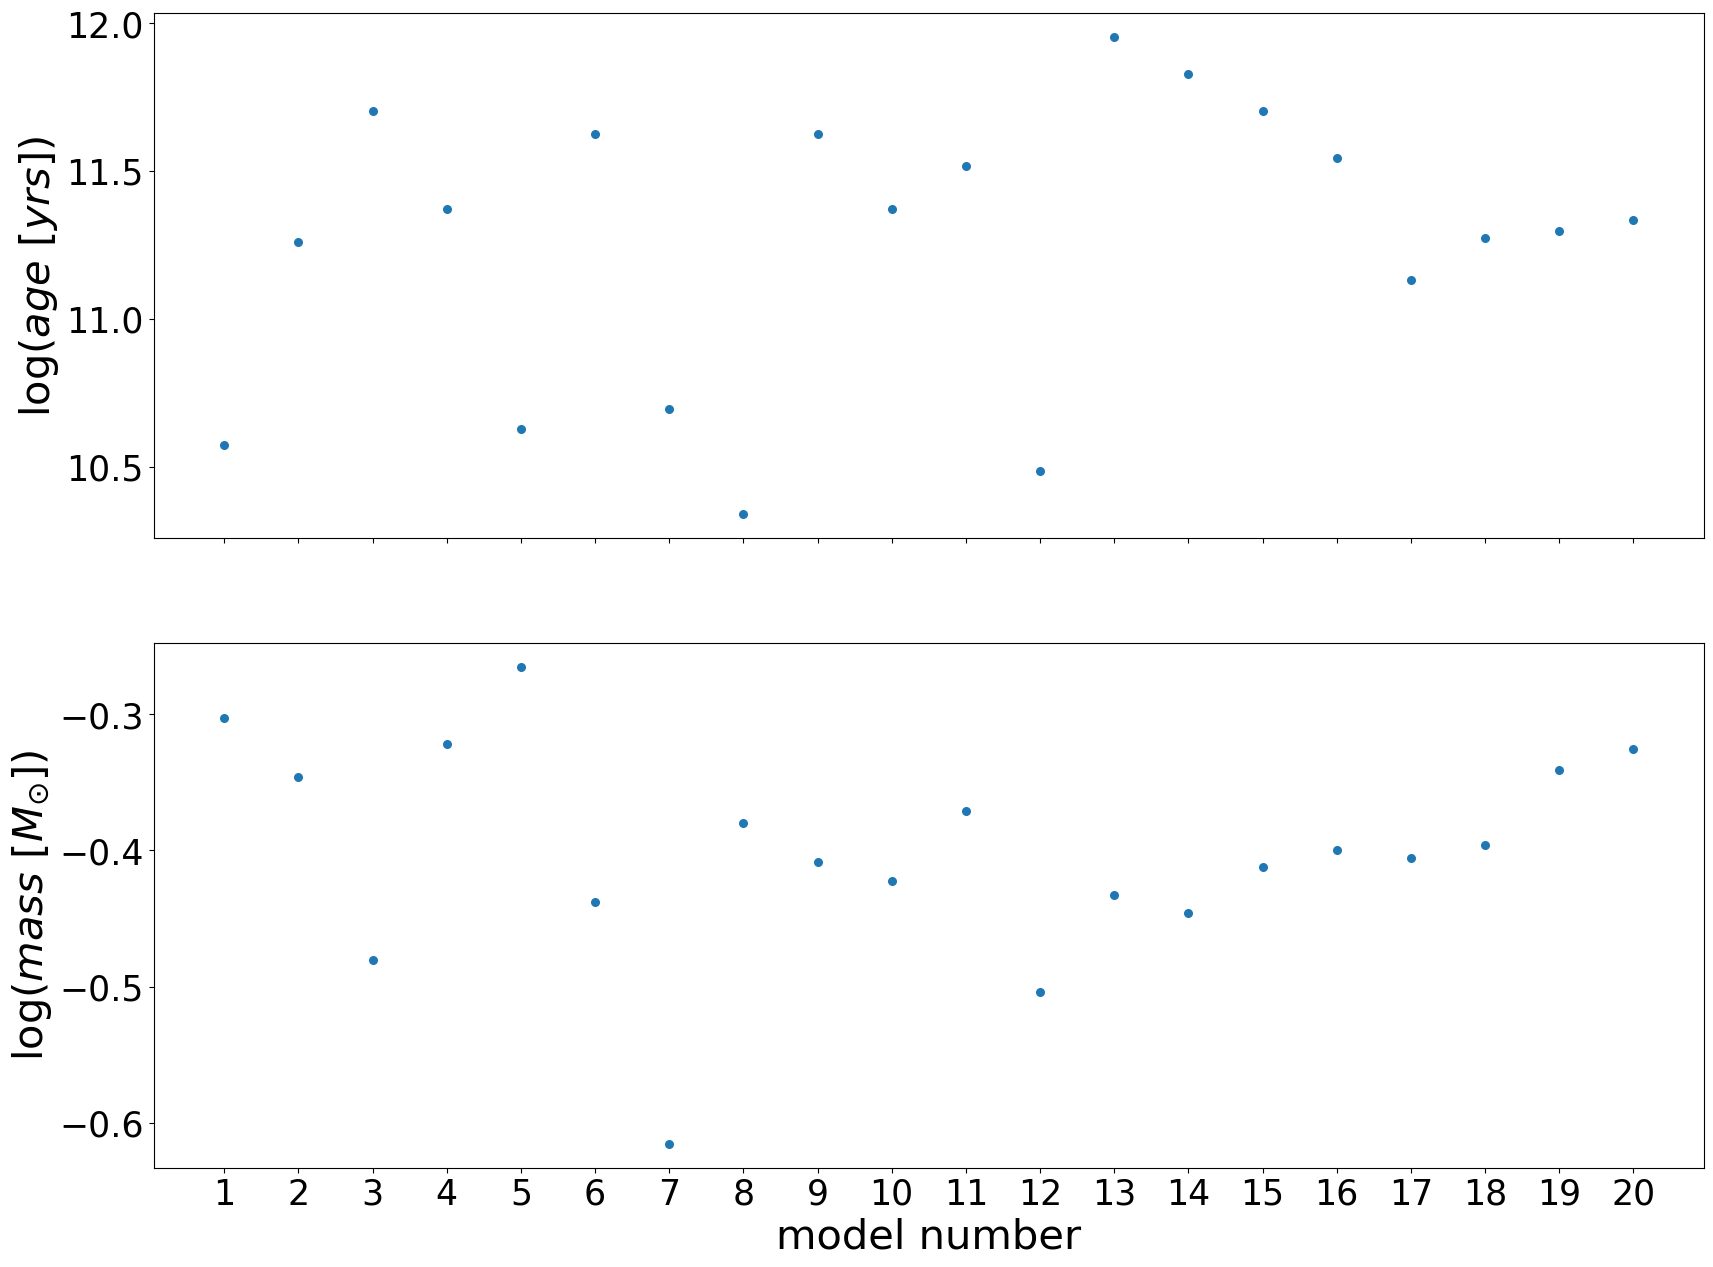

In [68]:
st.plot_posterior(y_post, 15) 

array([<Axes: xlabel='$\\log(age \\ [yrs])$', ylabel='number of predictions'>,
       <Axes: xlabel='$\\log(mass \\ [M_{\\odot}])$'>], dtype=object)

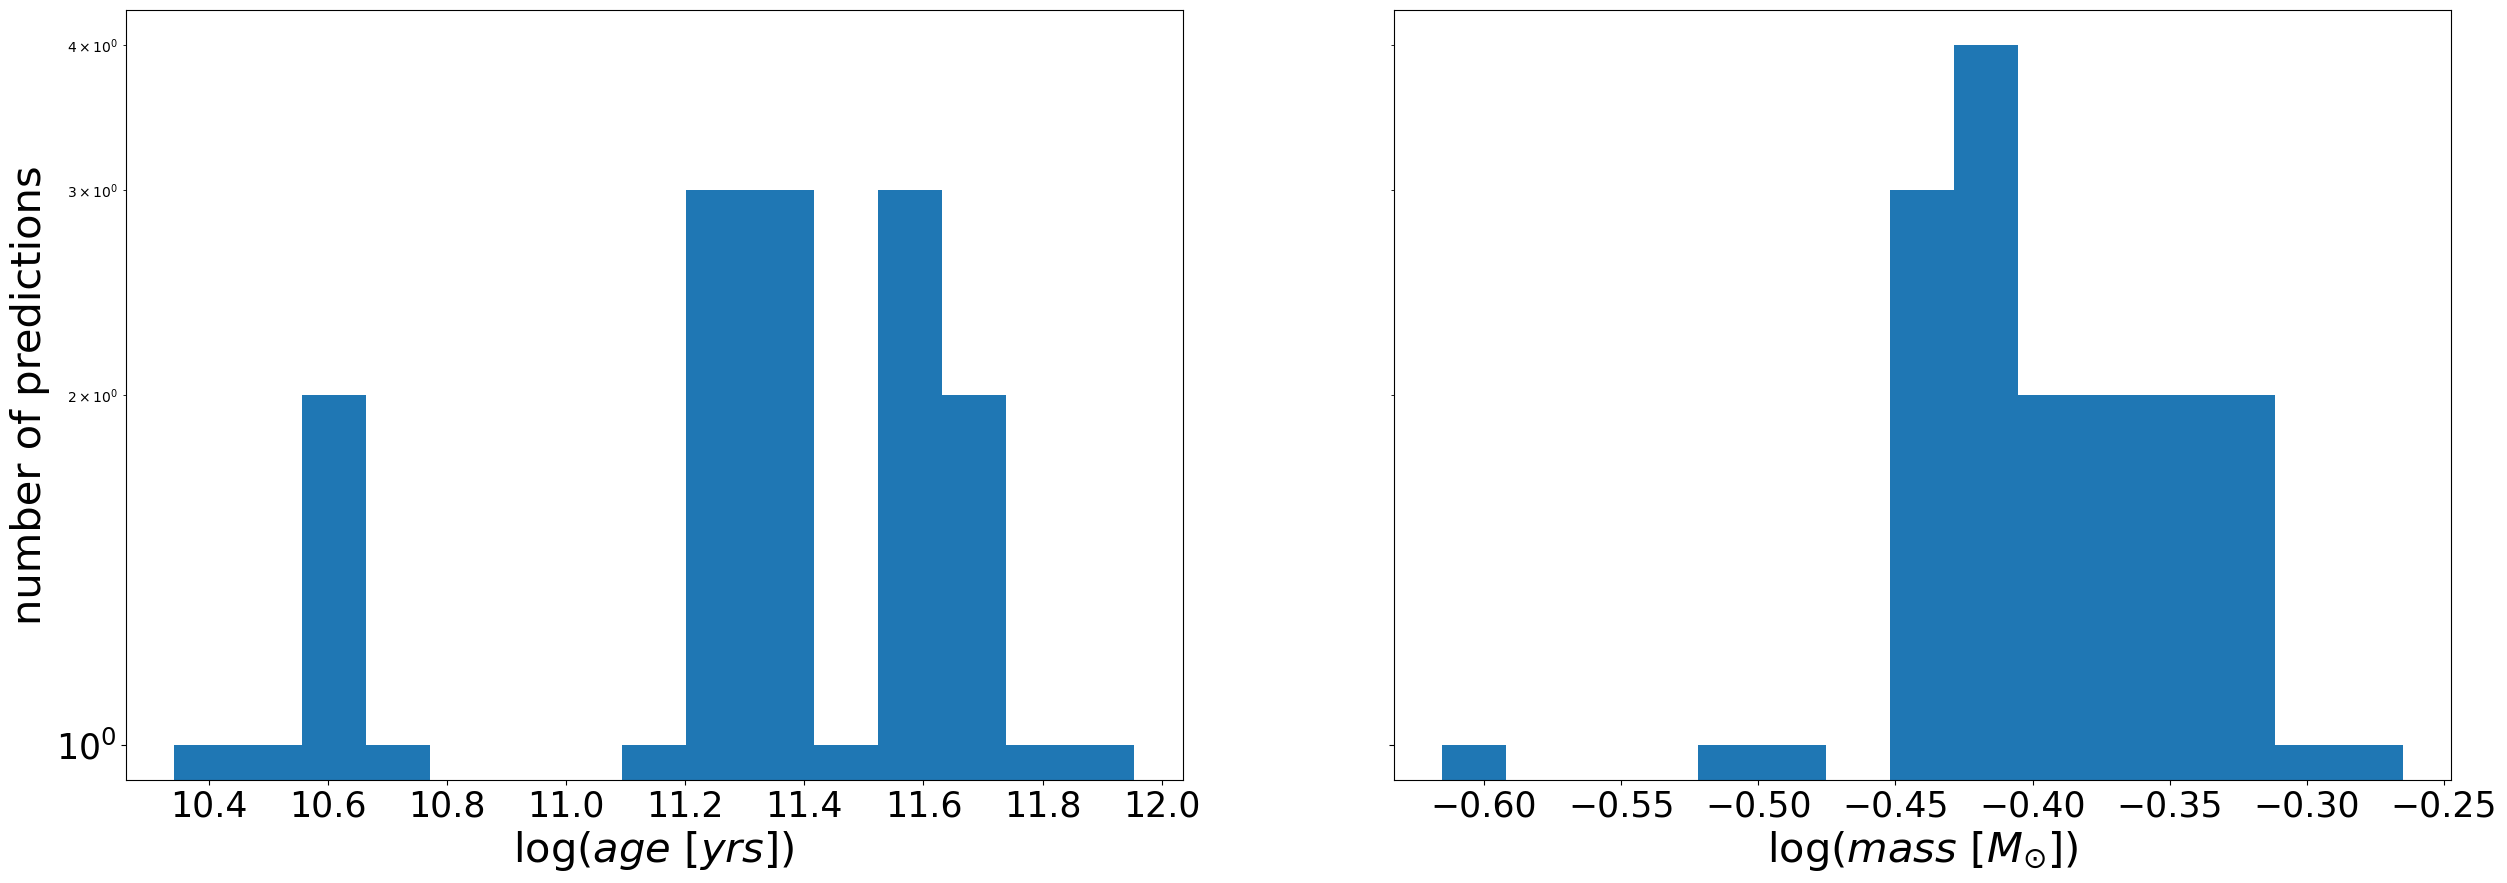

In [69]:
st.plot_posterior_hist(y_post, 15)

### Gaussian Posteriors

In [70]:
y_gaussian_posteriors=st.Gaussian_posteriors(y_mean_preMS, y_mean_postMS, y_std_preMS, y_std_postMS, pi_pre, pi_post, n_obs=data.shape[0], num_x_points=500)

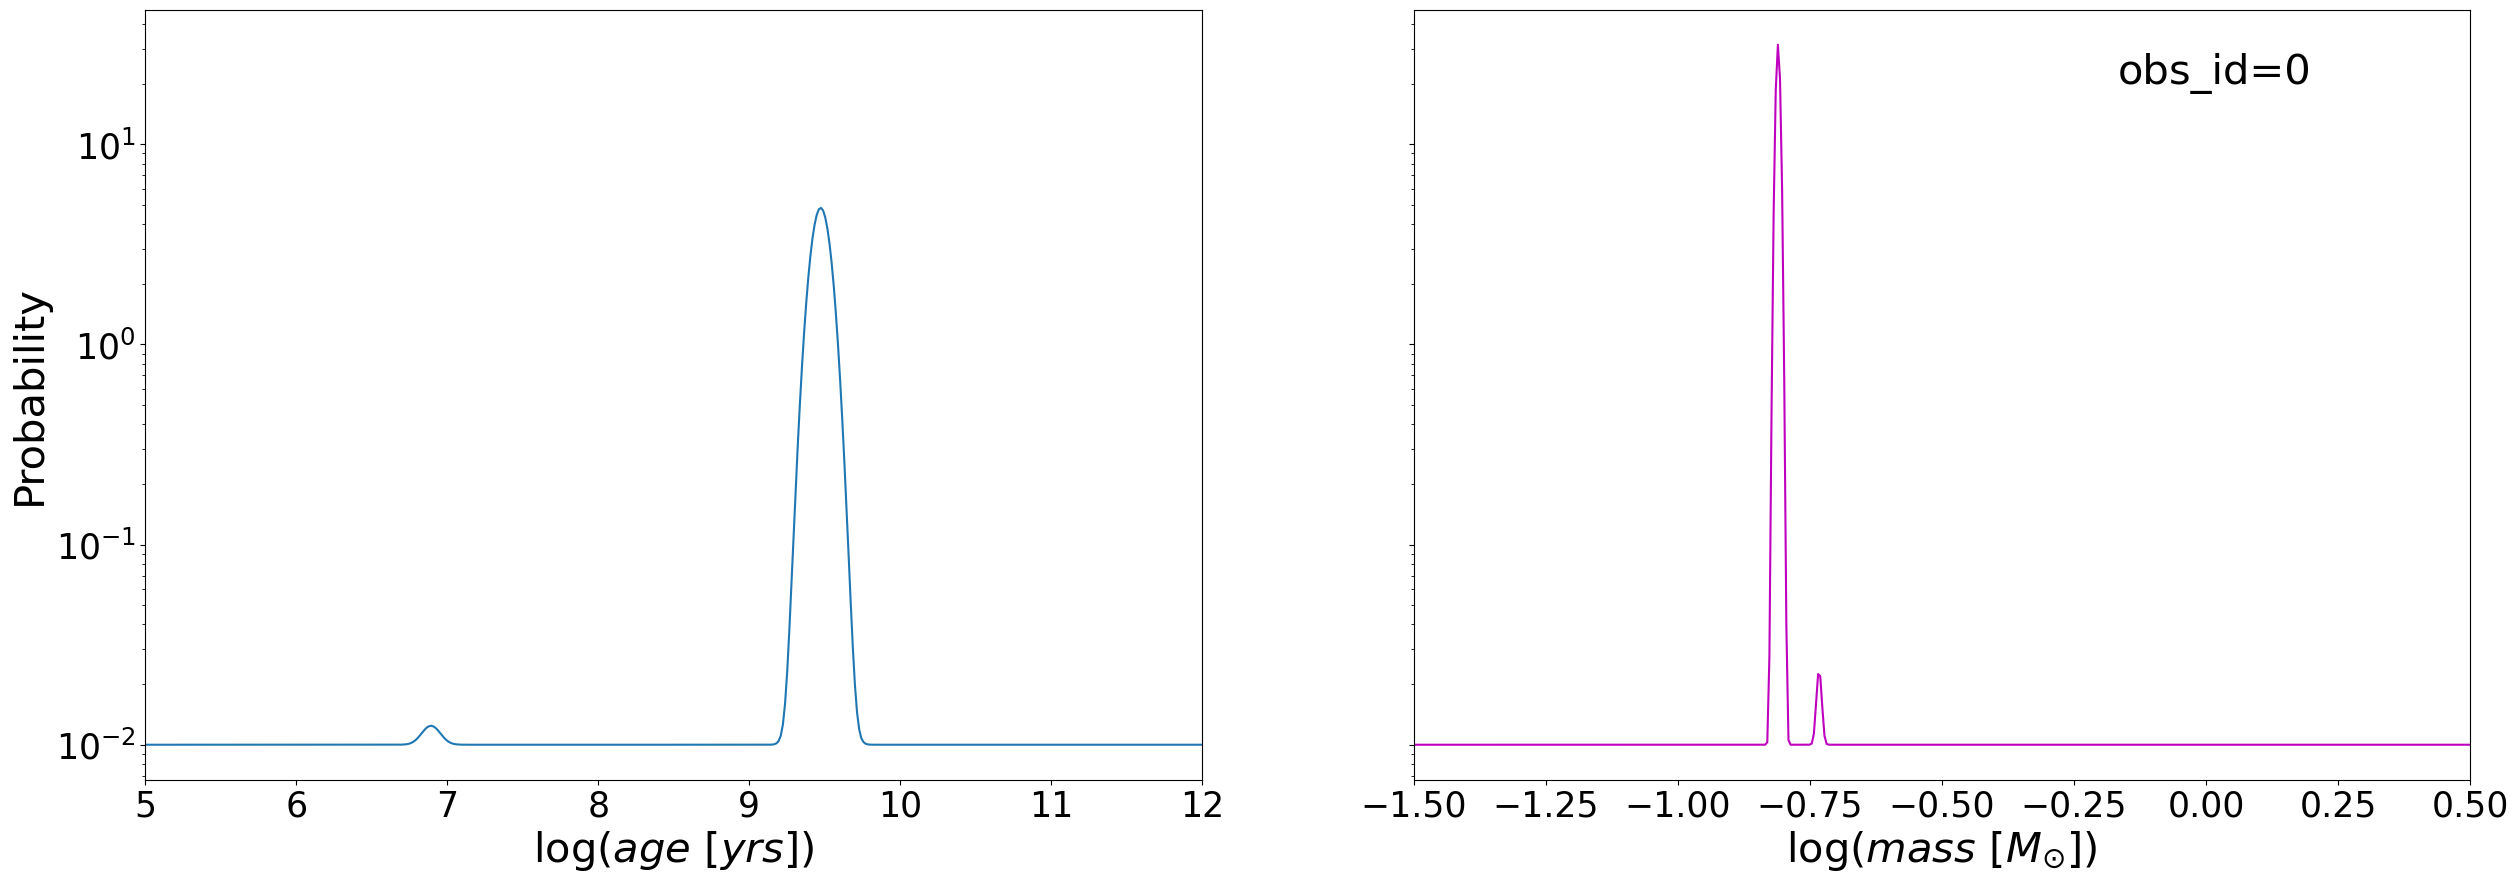

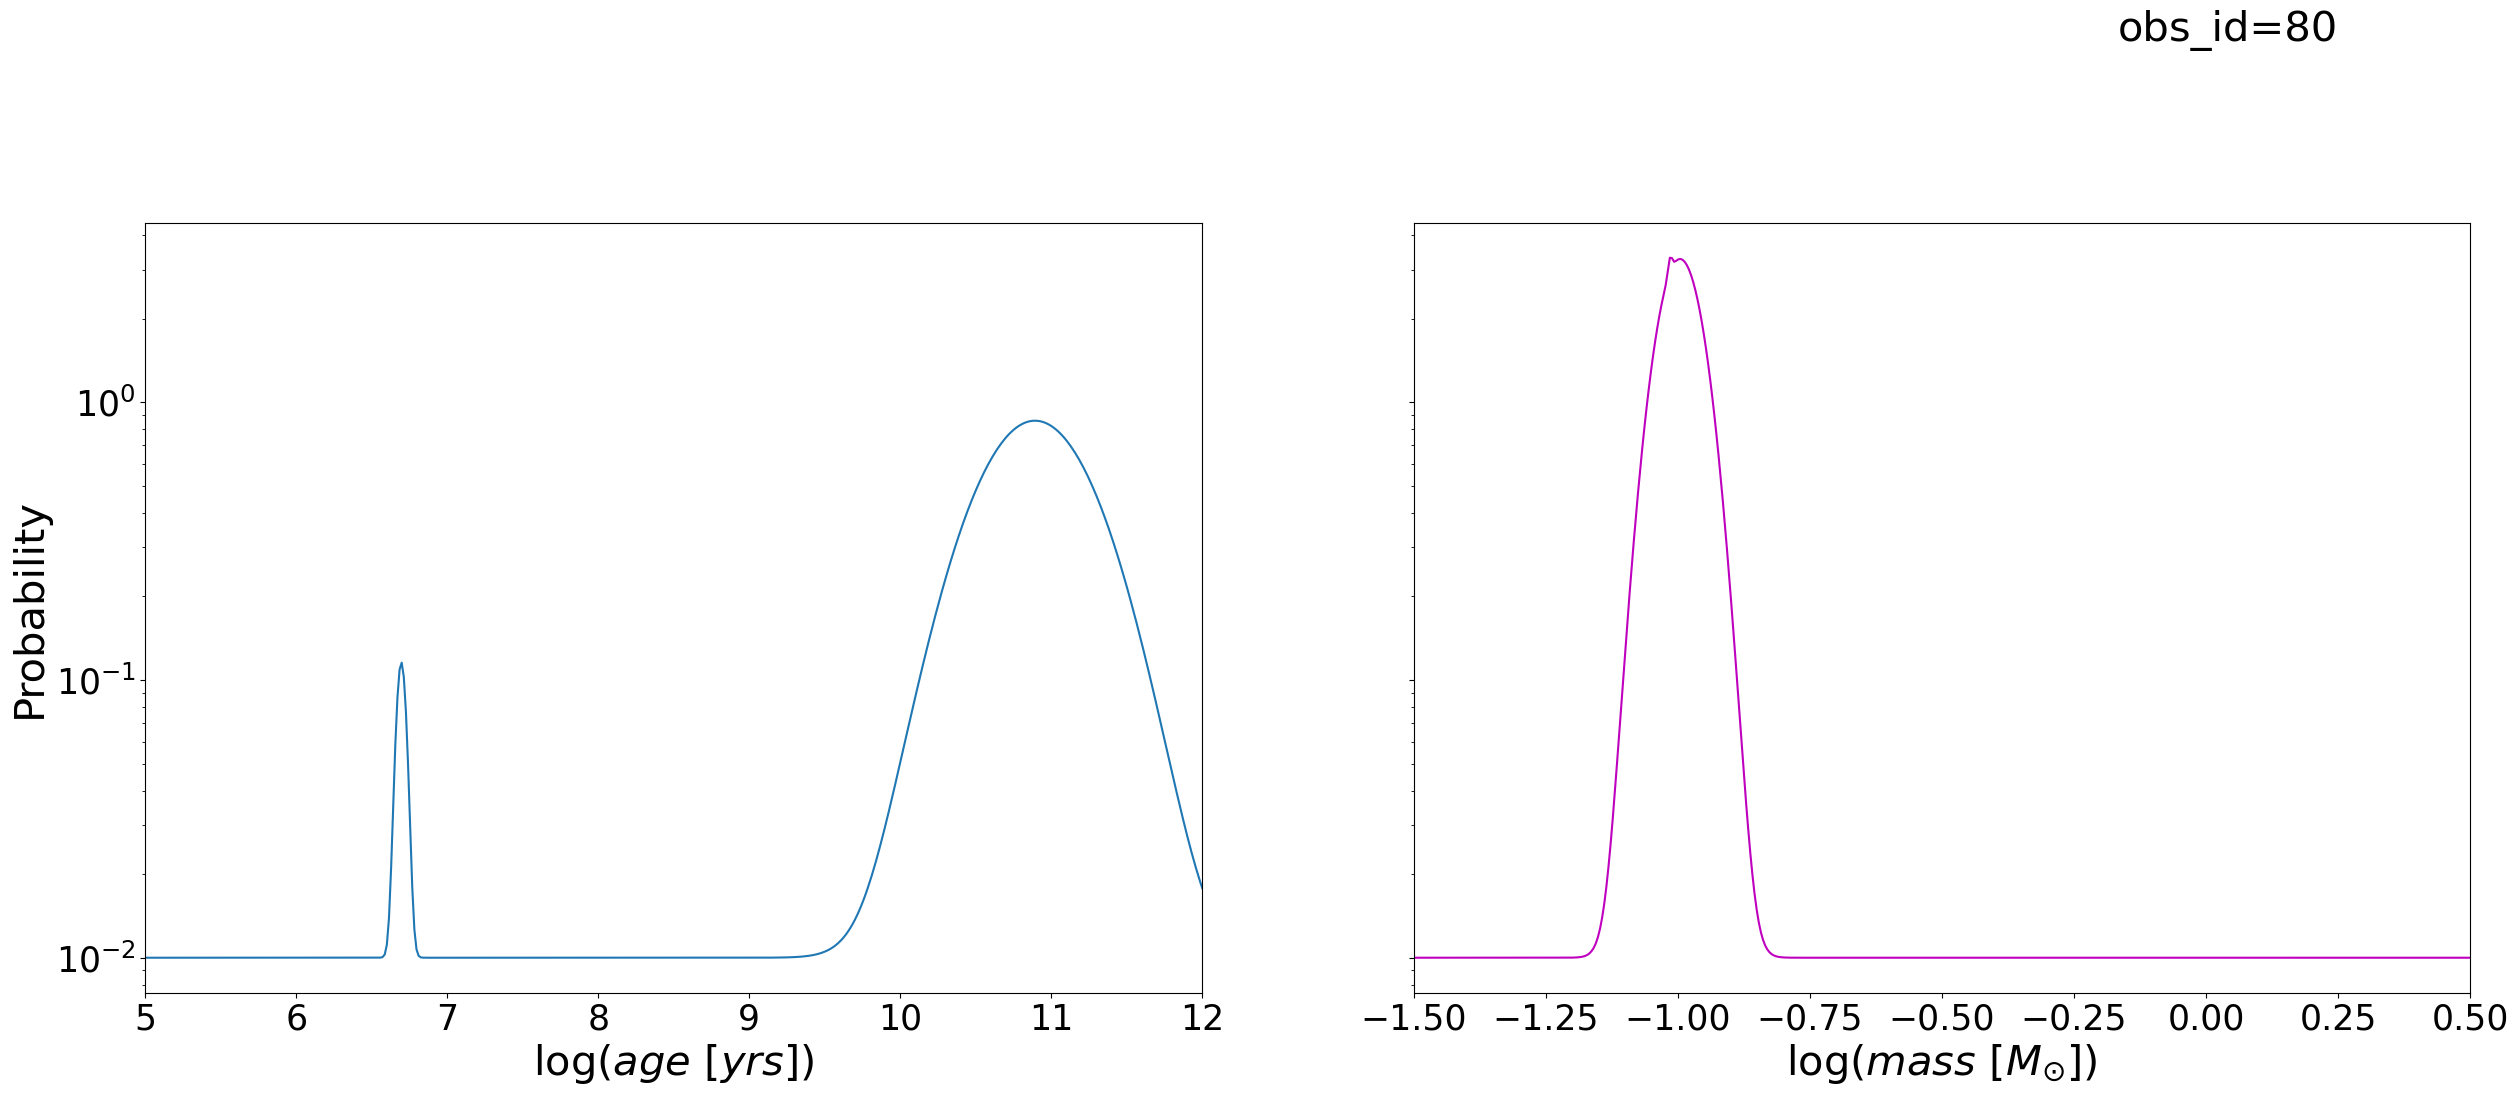

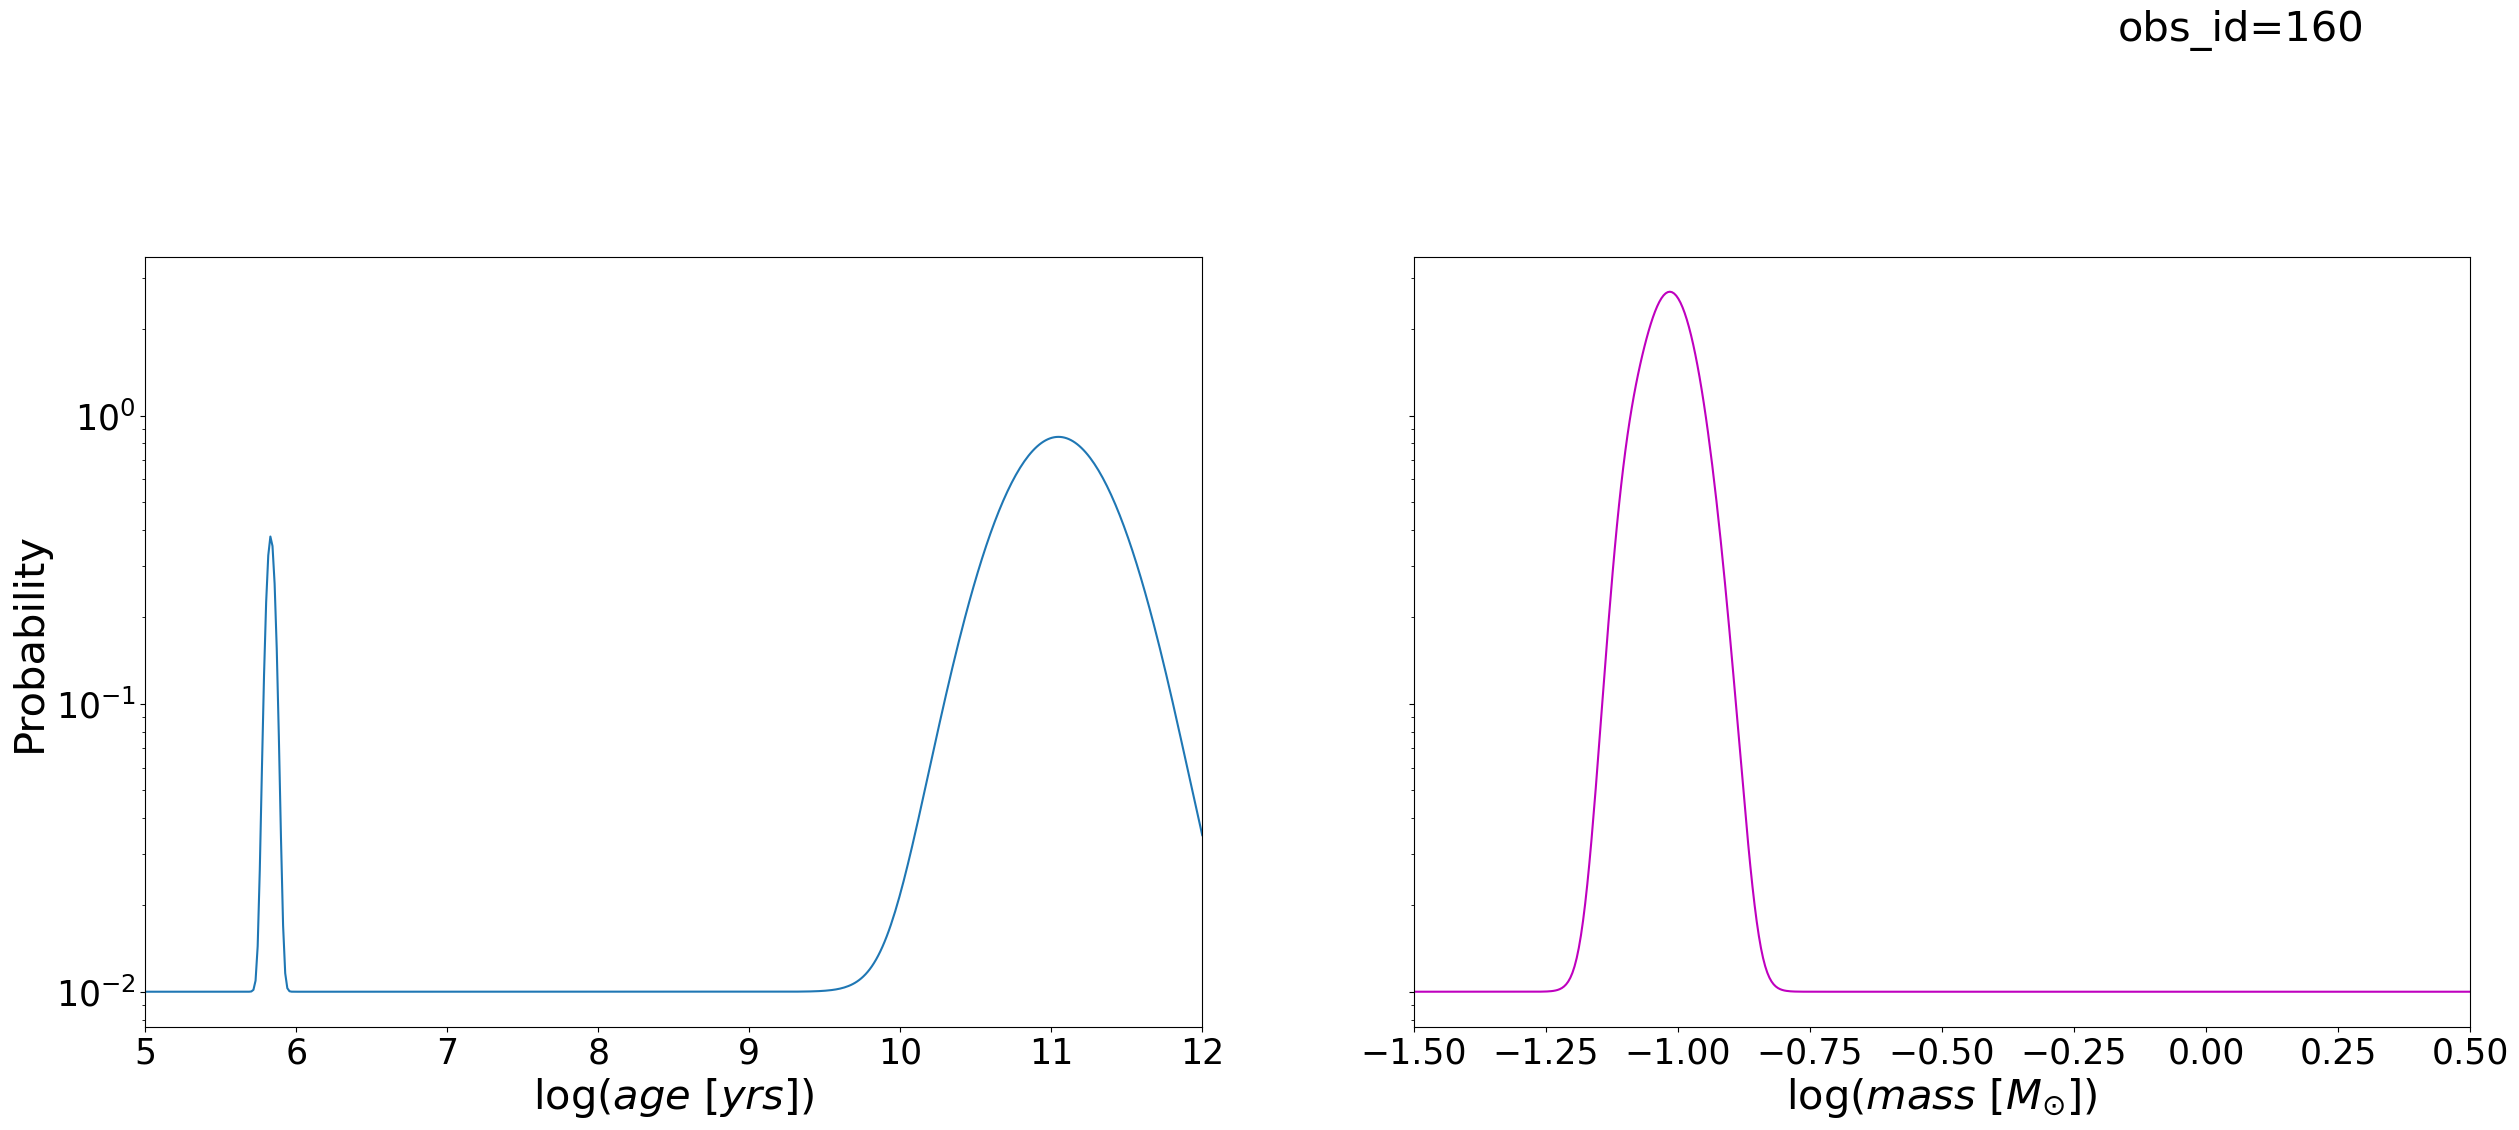

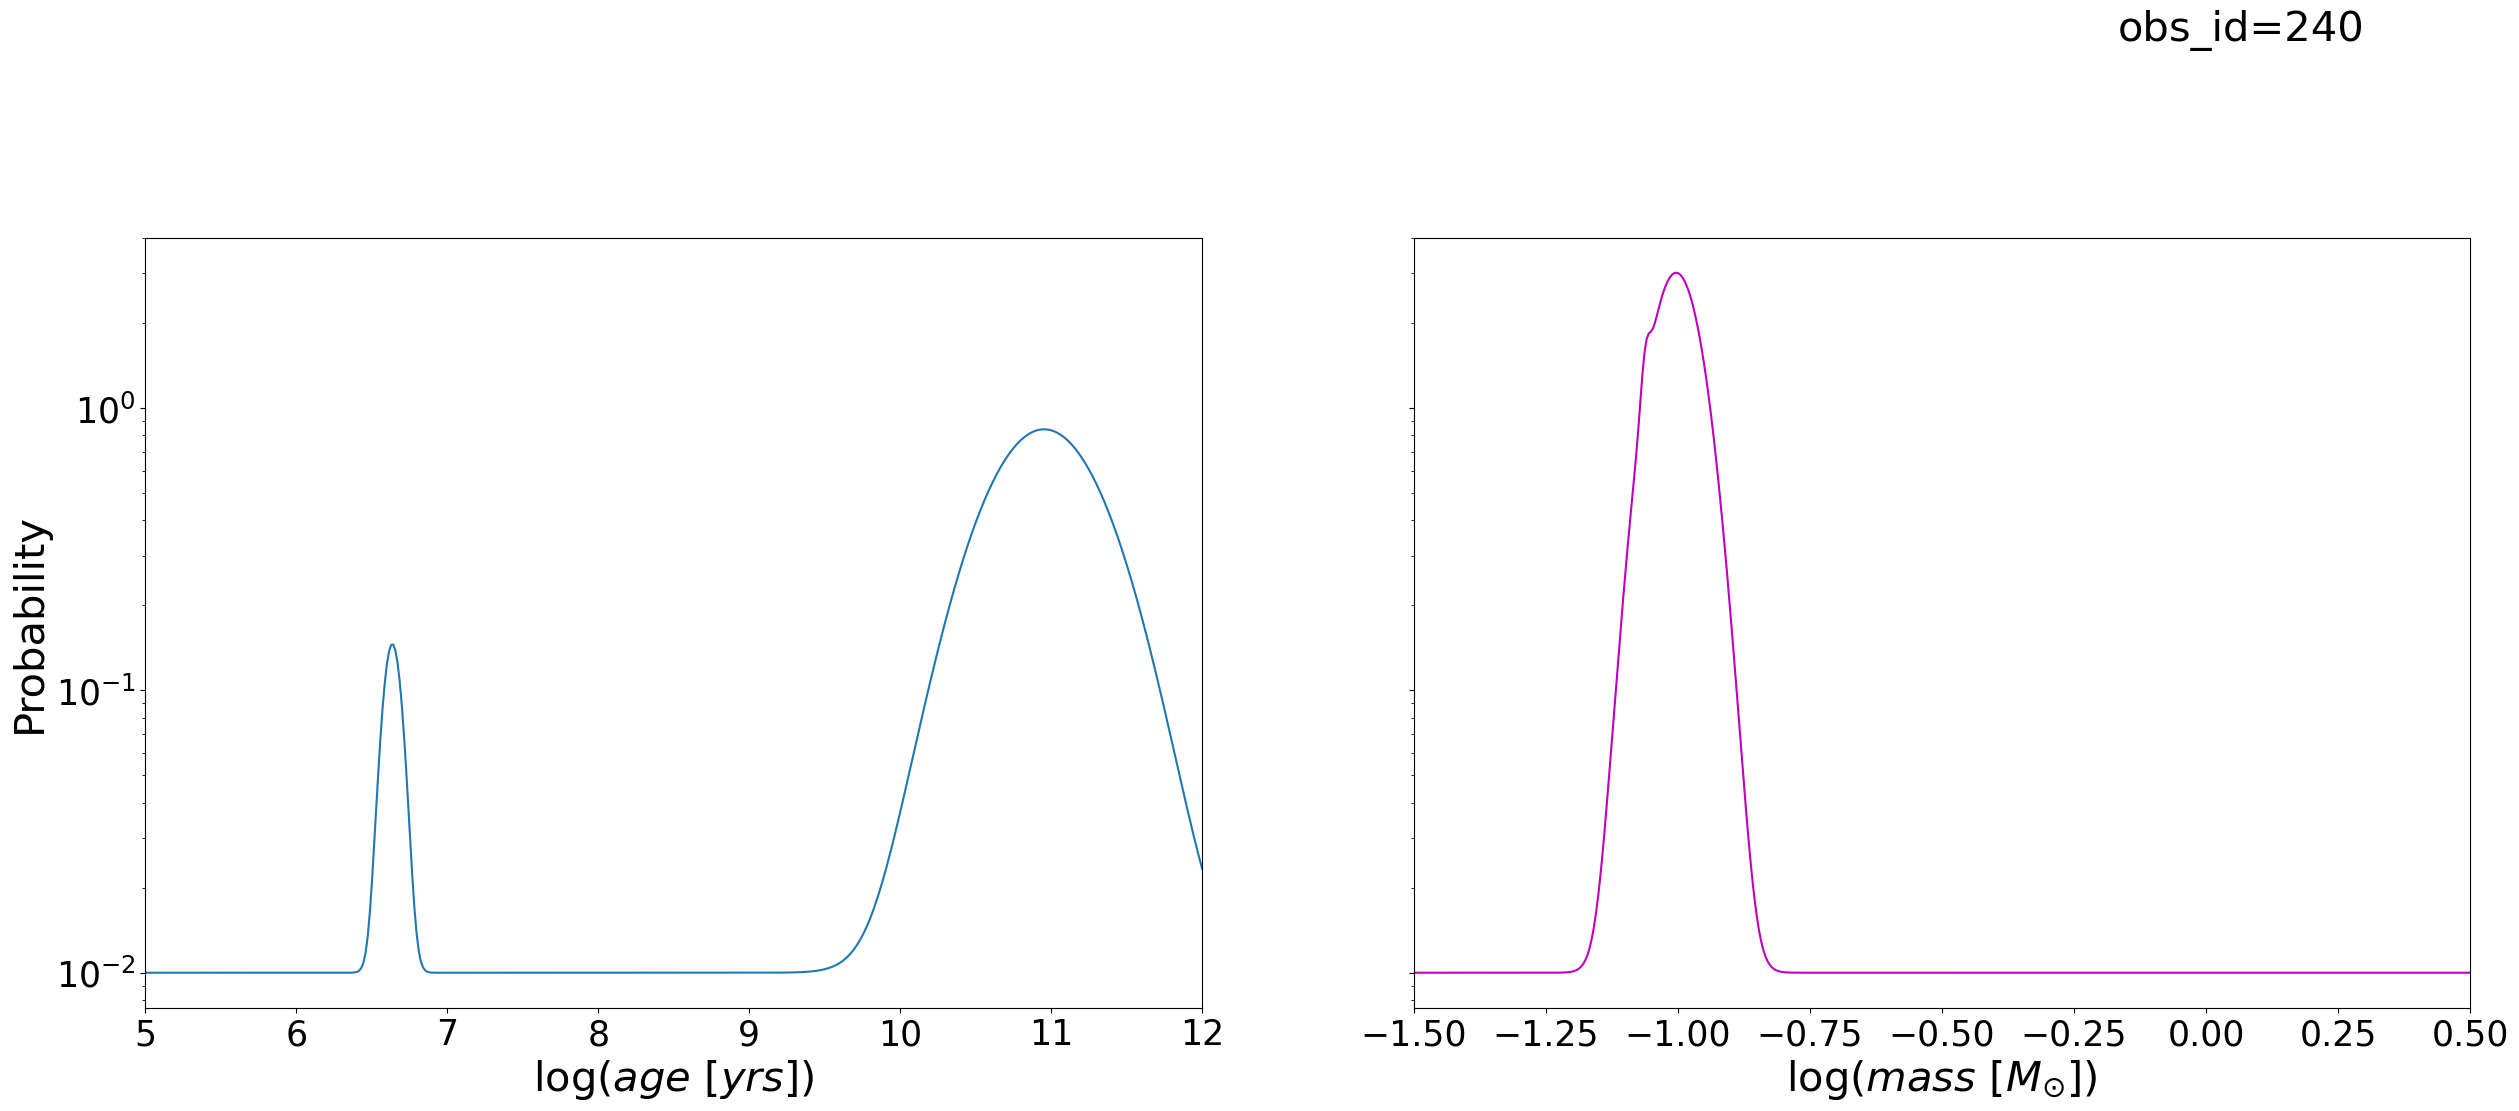

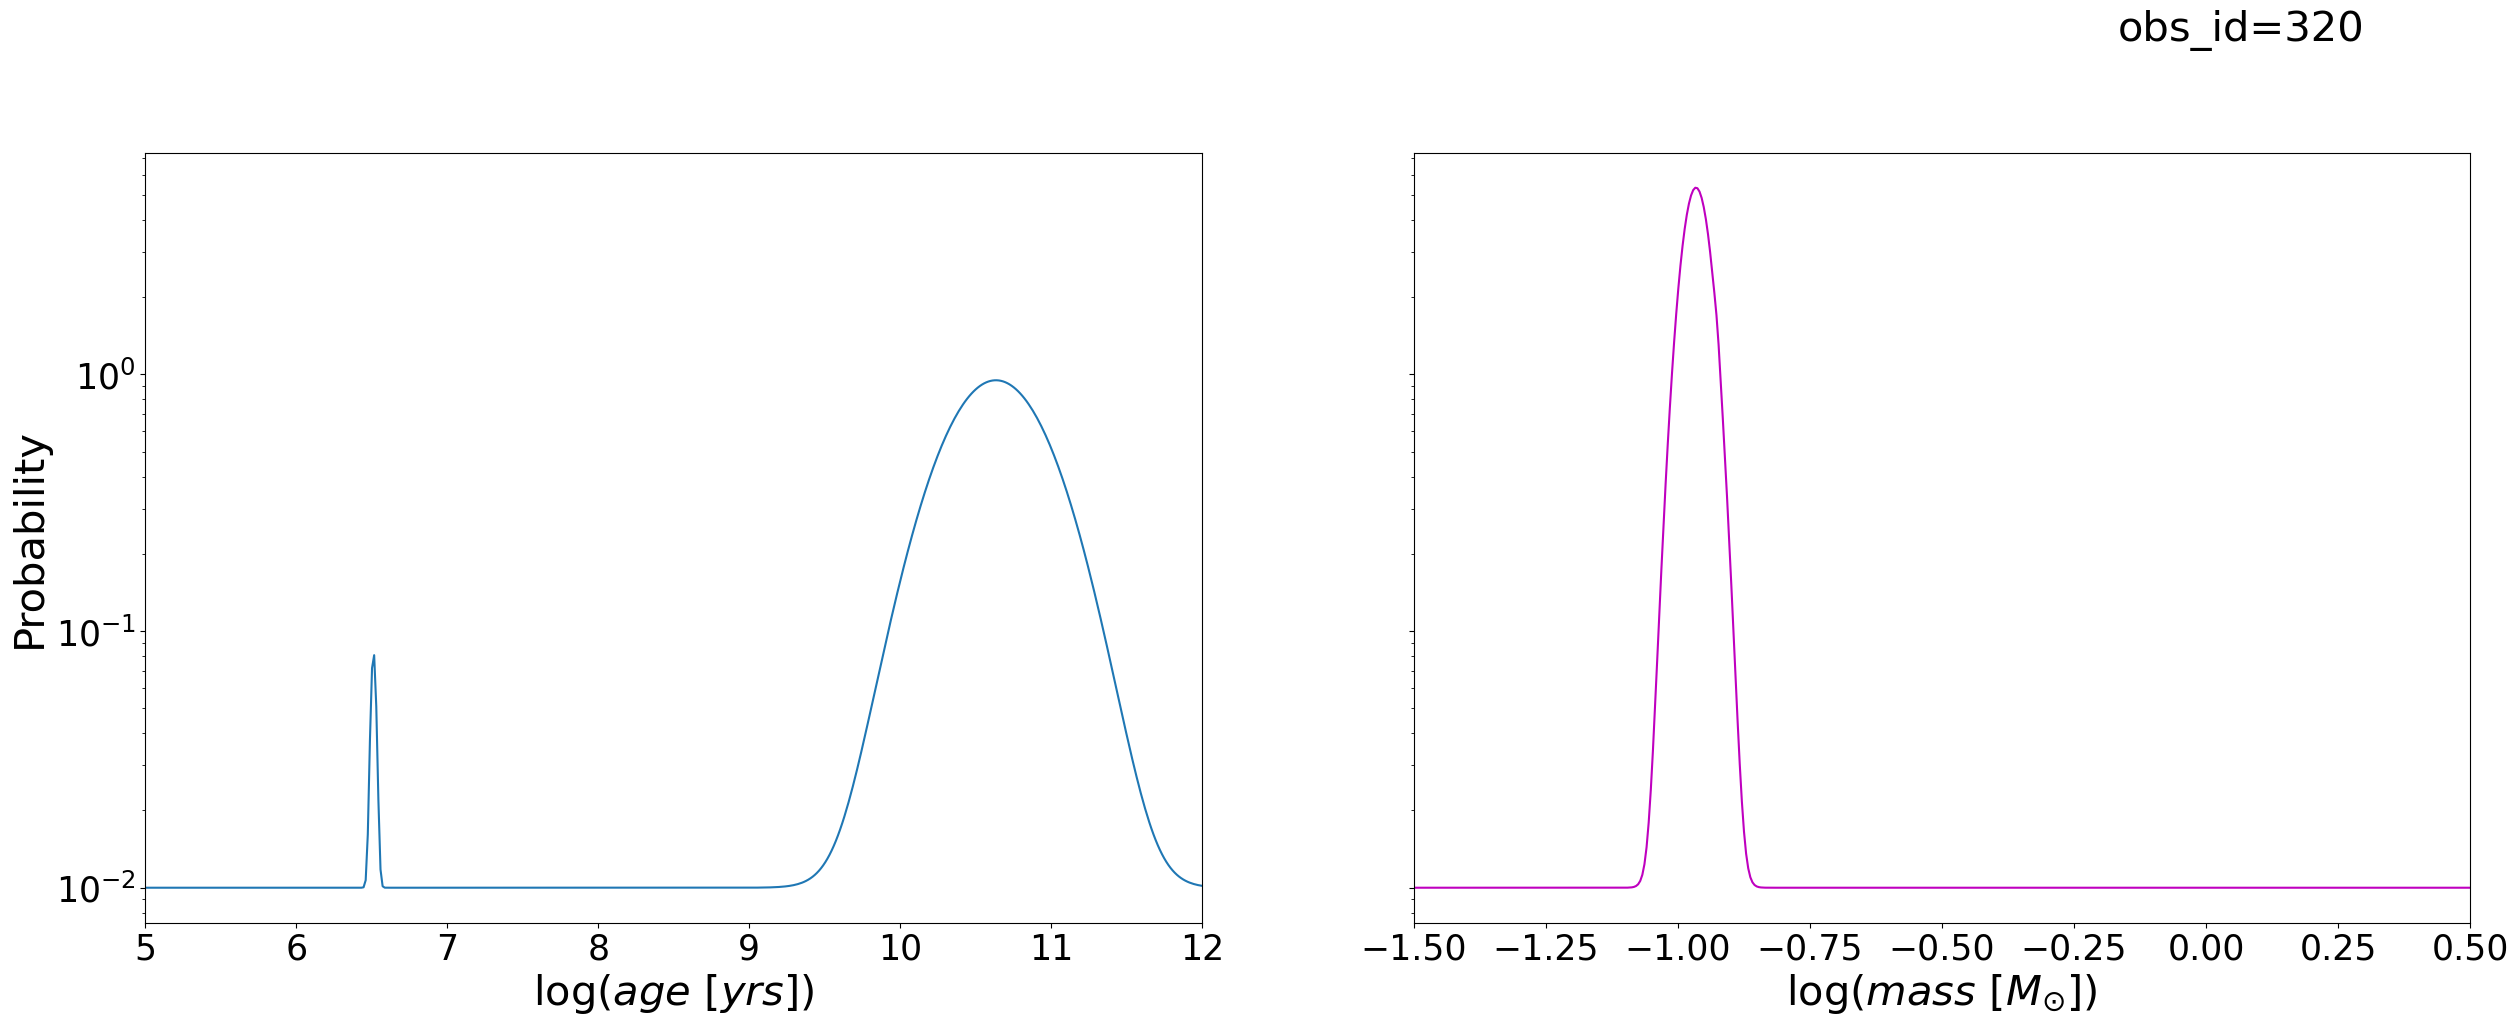

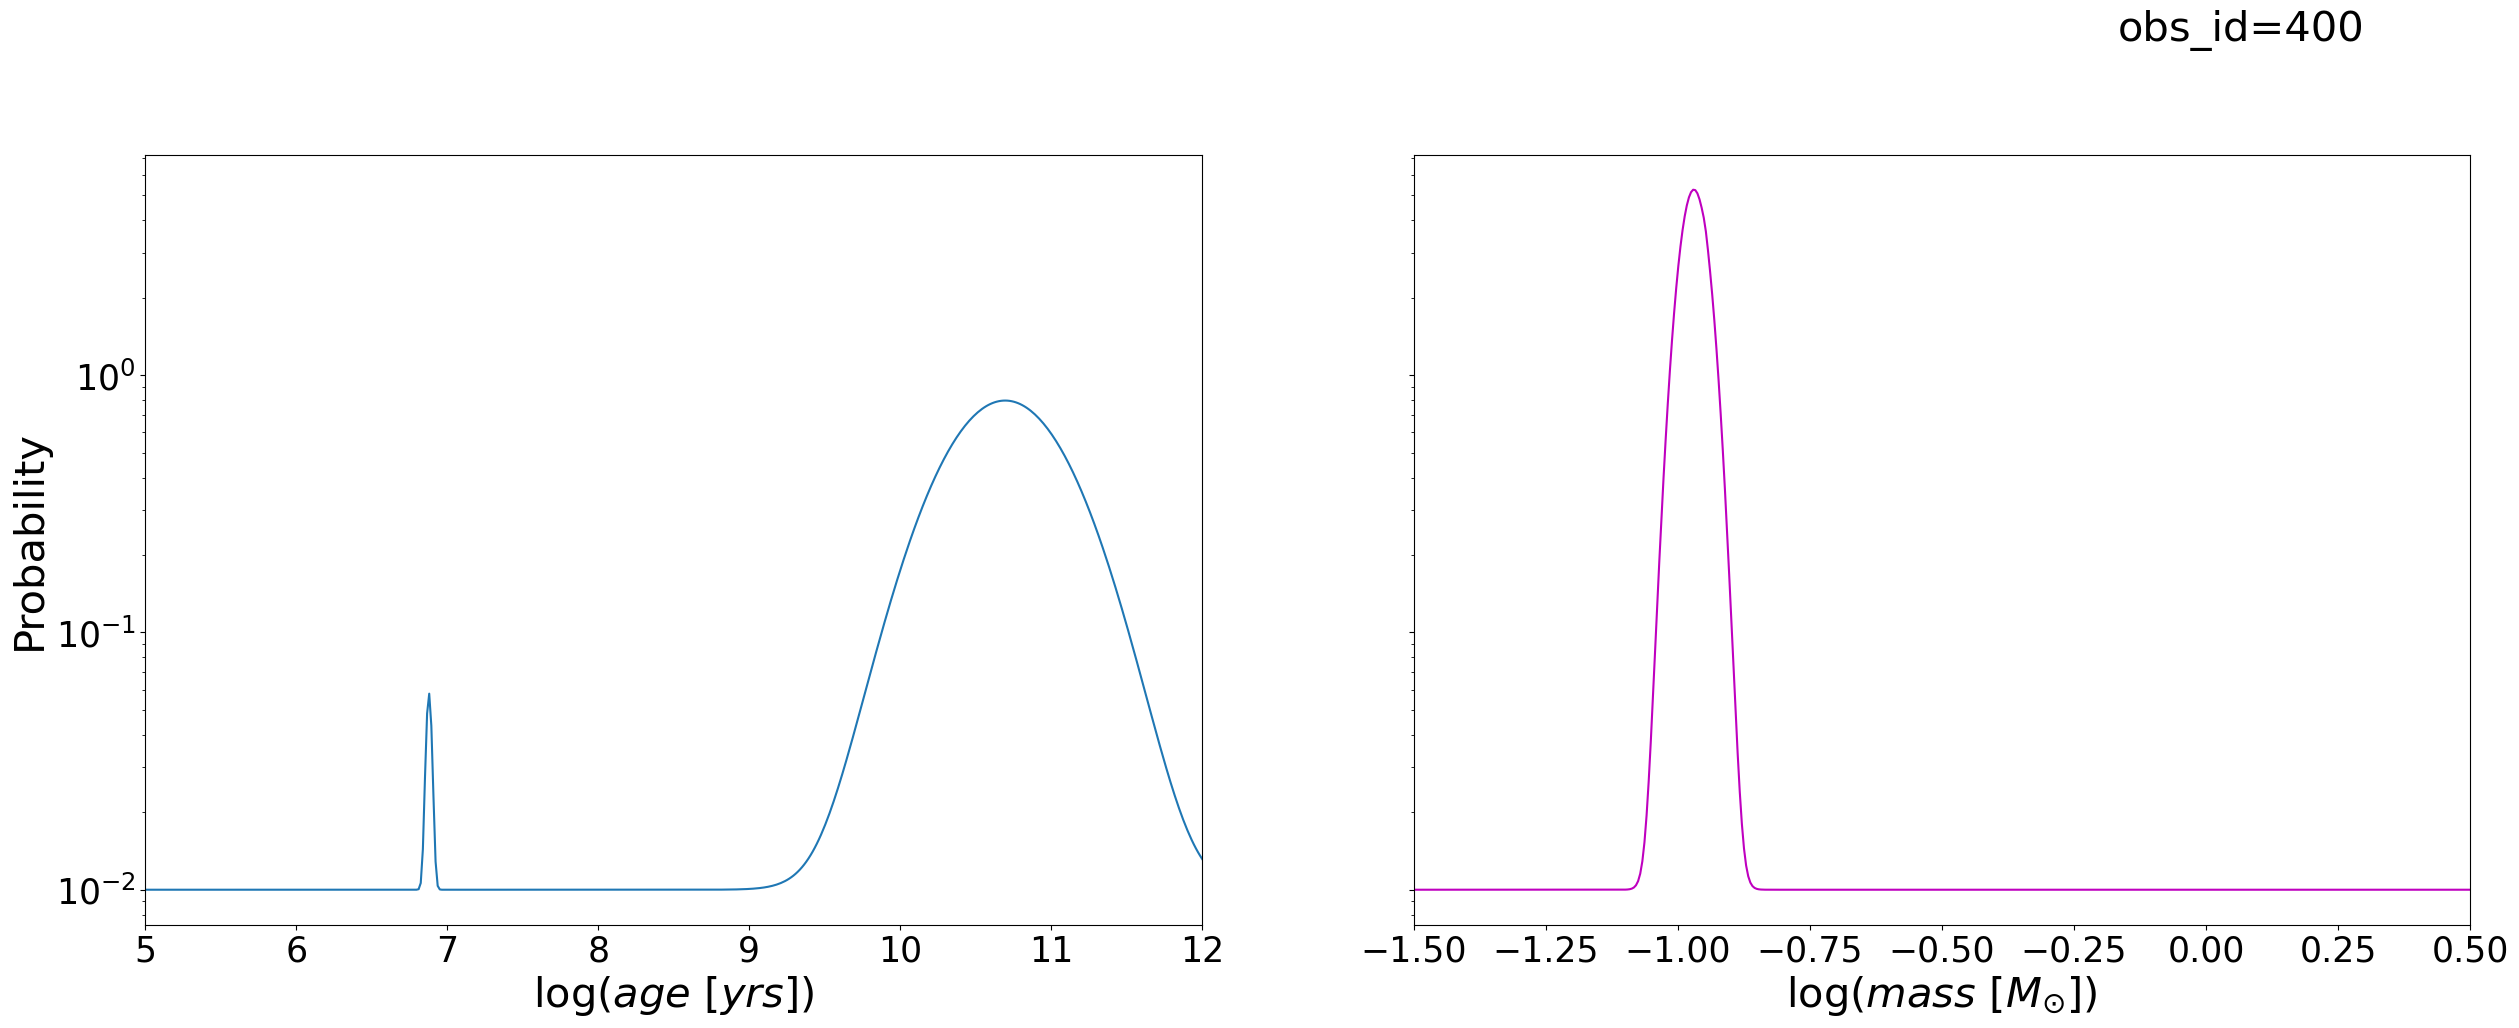

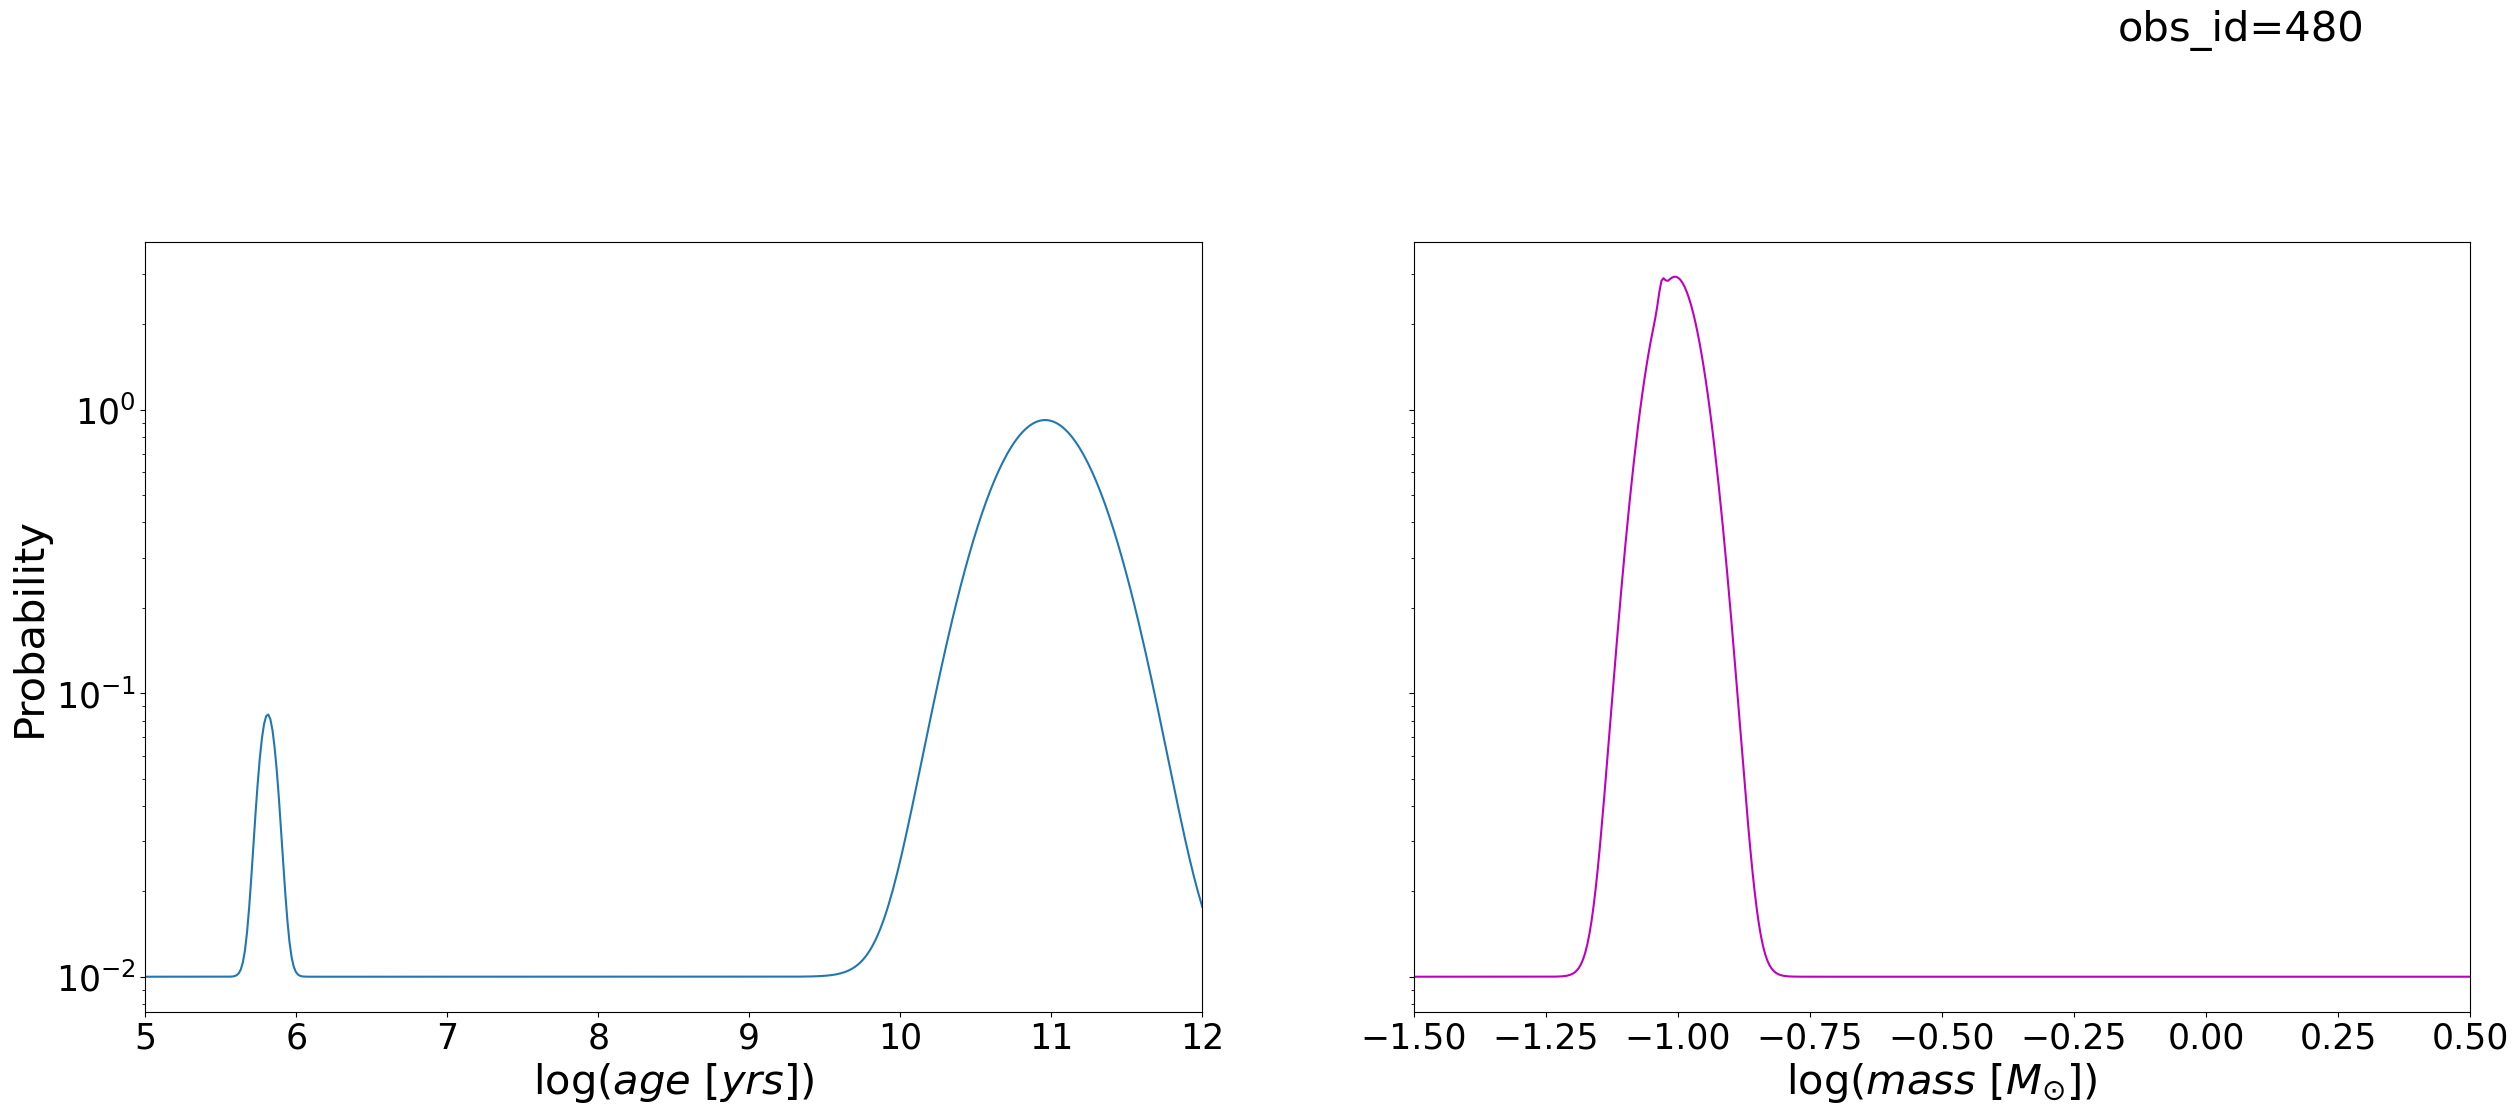

In [71]:
for i in range(0, data.shape[0], 80):
    st.plot_gaussian_posteriors(y_gaussian_posteriors, i, log_age_range=[5,12], log_mass_range=[-1.5,0.5])

## NGC 6530 (pre-ZAMS)

In [74]:
data_raw = pd.read_csv('Data/preZAMS/ngc6530.csv') 
df = pd.DataFrame(data_raw)
df['teff_log'] = df['logTeff'].astype(float)
df['lum_log'] = df["logLum"].astype(float)

# logAge column already exists
# logMass column already exists

Data = df[['teff_log','lum_log', 'logAge', 'logMass']].dropna().astype(float)


data_x = Data[['teff_log','lum_log']]
data_y = Data[['logAge','logMass']]

data = data_x.values.astype('float')
data_0 = np.copy(data)

### Make Predictions

In [76]:
num_NNs = 20 # choose number of bootstraps

# predict:
y_pre, y_post= st.predict(data, n=num_NNs, TL='reu2023')

In [77]:
y_mean_preMS, y_std_preMS = st.stats(y_pre)
y_mean_postMS, y_std_postMS = st.stats(y_post)

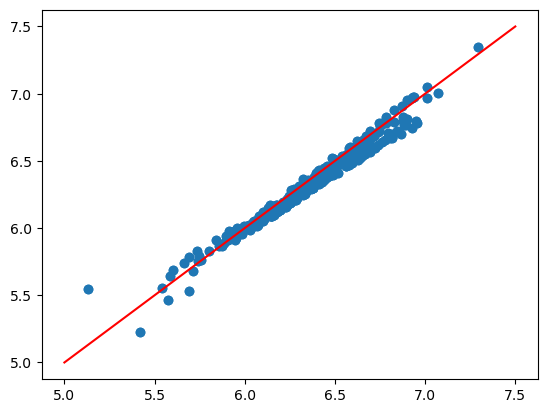

In [79]:
fig, ax = plt.subplots()

x = y_mean_preMS[:,0] # predicted
y = data_y['logAge']

ax.scatter(x,y)

z = np.linspace(5,7.5,2)
ax.plot(z,z,color='r')

### Mixture of Models

In [80]:
pi_pre, pi_post = st.pis(y_mean_preMS, y_mean_postMS)

In [81]:
# Get posteriors:
y_post = st.posteriors(y_pre , y_post, pi_pre, pi_post, n=num_NNs)

### Posteriors

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='Observation id', ylabel='$\\log(mass)$ [$M_{\\odot}$]'>],
      dtype=object)

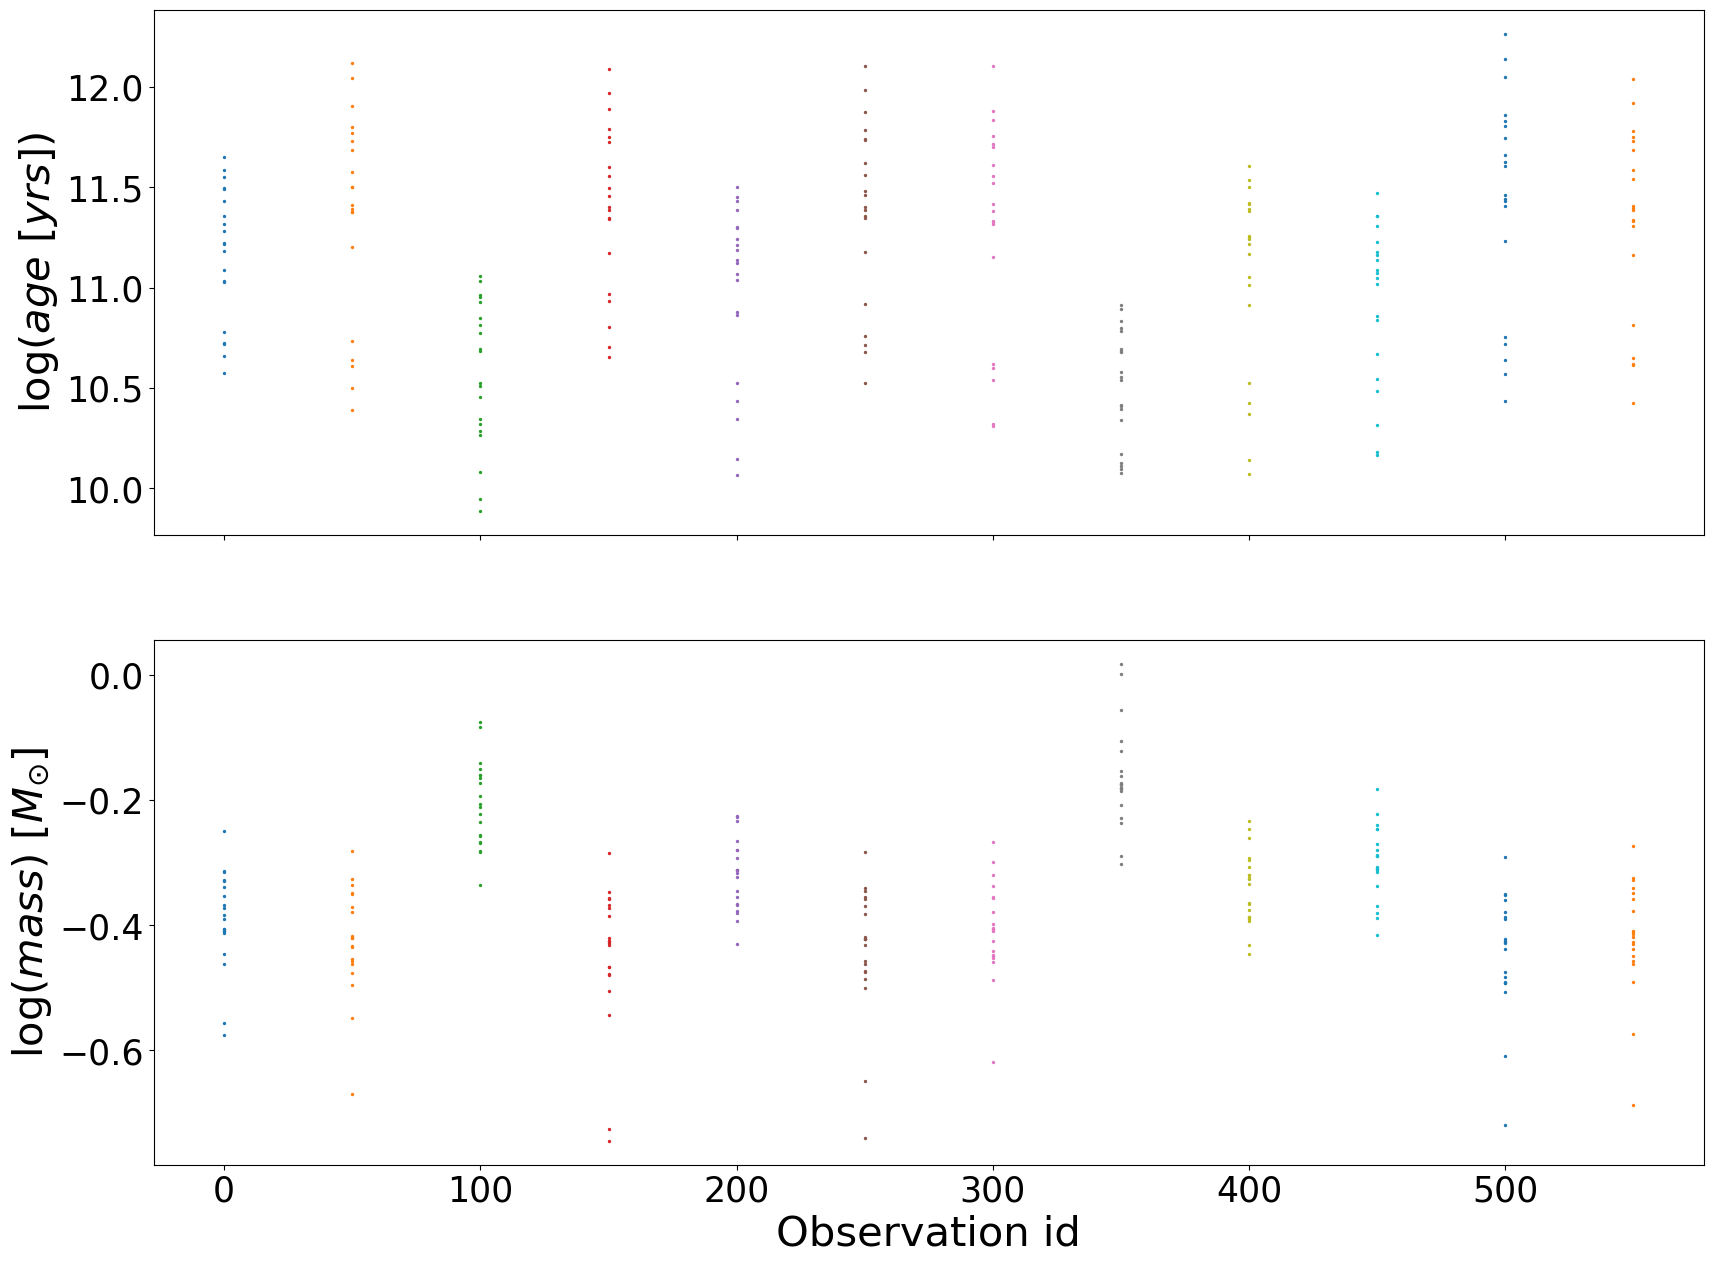

In [82]:
st.plot_multiple_posteriors(y_post, [i for i in range(0, data.shape[0],50)])

array([<Axes: ylabel='$\\log(age \\ [yrs])$'>,
       <Axes: xlabel='model number', ylabel='$\\log(mass \\ [M_{\\odot}])$'>],
      dtype=object)

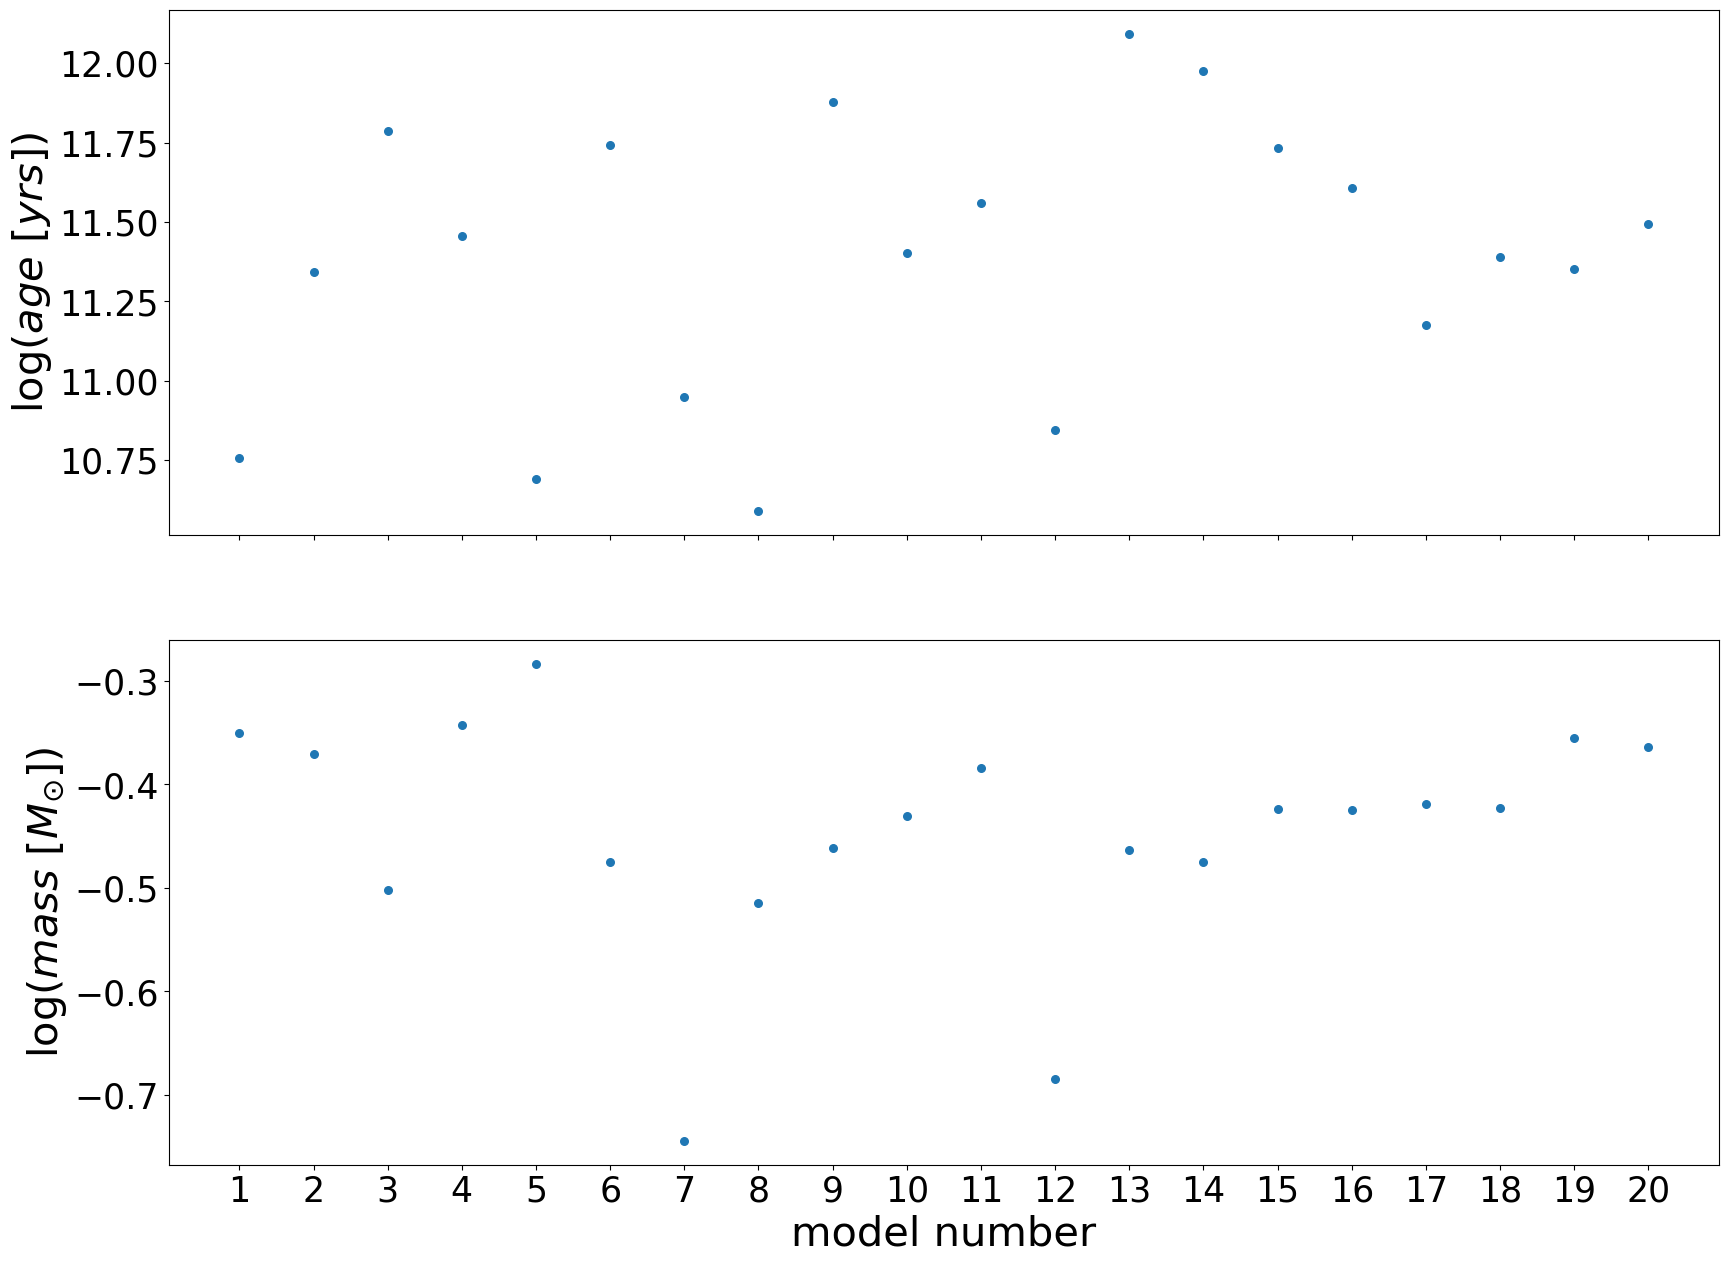

In [83]:
st.plot_posterior(y_post, 15) 

array([<Axes: xlabel='$\\log(age \\ [yrs])$', ylabel='number of predictions'>,
       <Axes: xlabel='$\\log(mass \\ [M_{\\odot}])$'>], dtype=object)

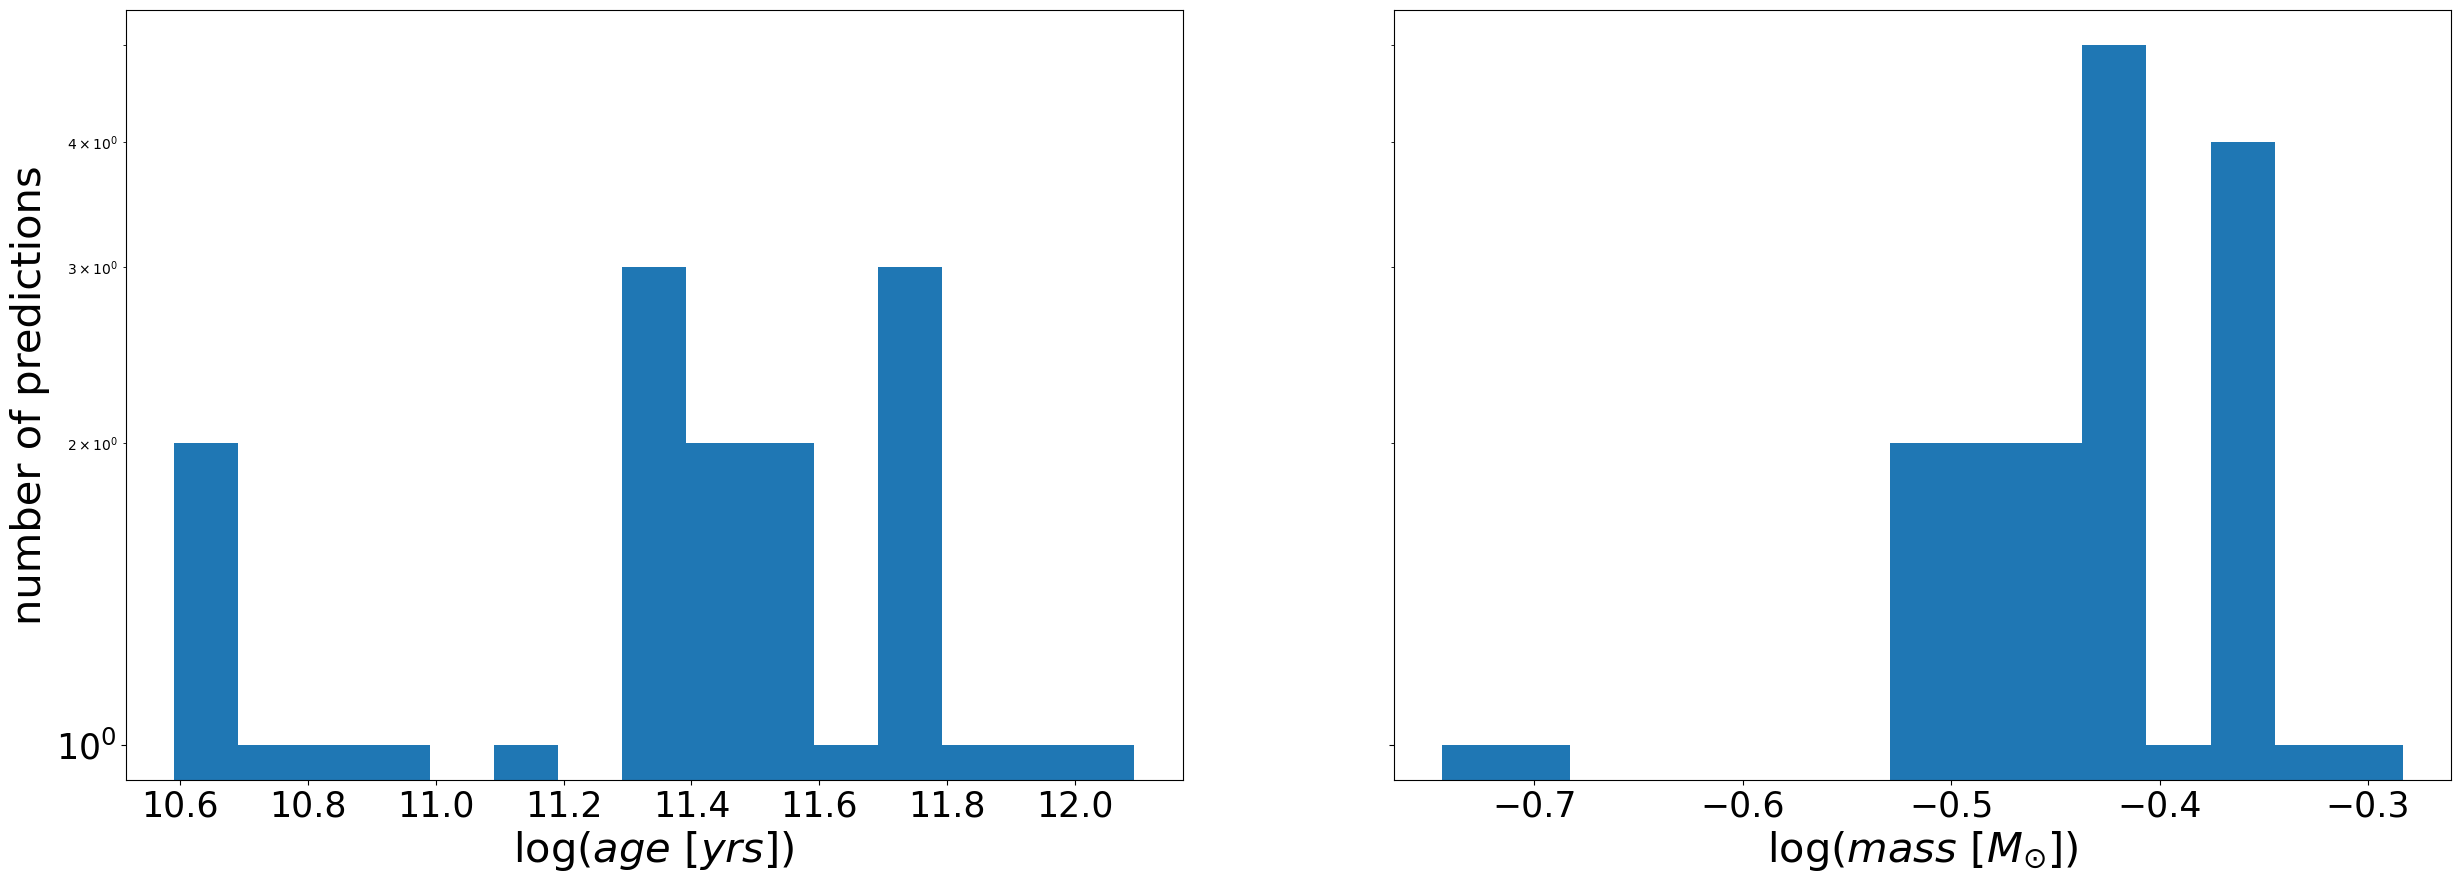

In [84]:
st.plot_posterior_hist(y_post, 15)

### Gaussian Posteriors

In [85]:
y_gaussian_posteriors=st.Gaussian_posteriors(y_mean_preMS, y_mean_postMS, y_std_preMS, y_std_postMS, pi_pre, pi_post, n_obs=data.shape[0], num_x_points=500)

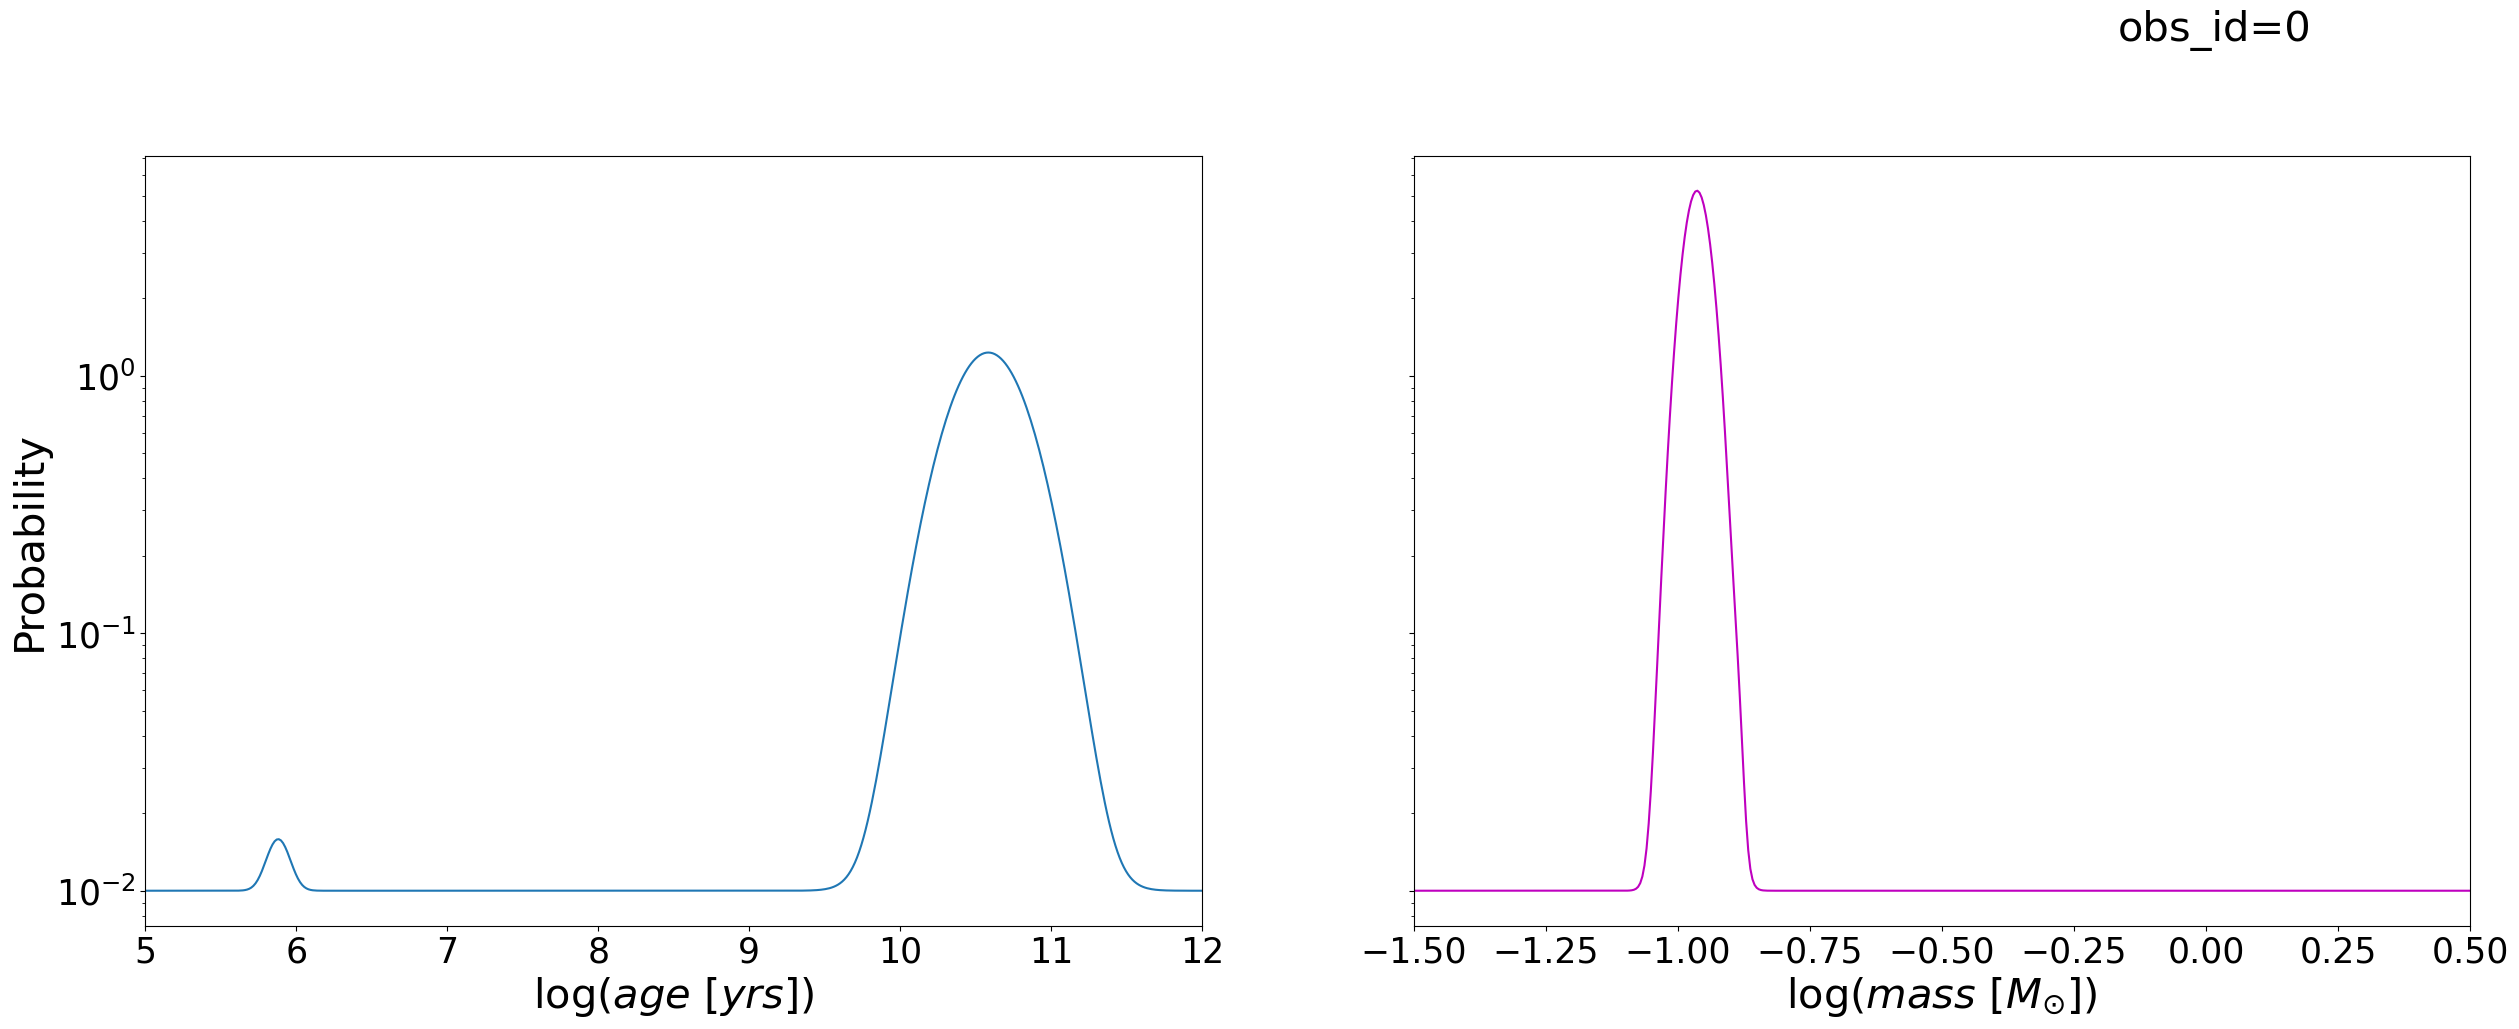

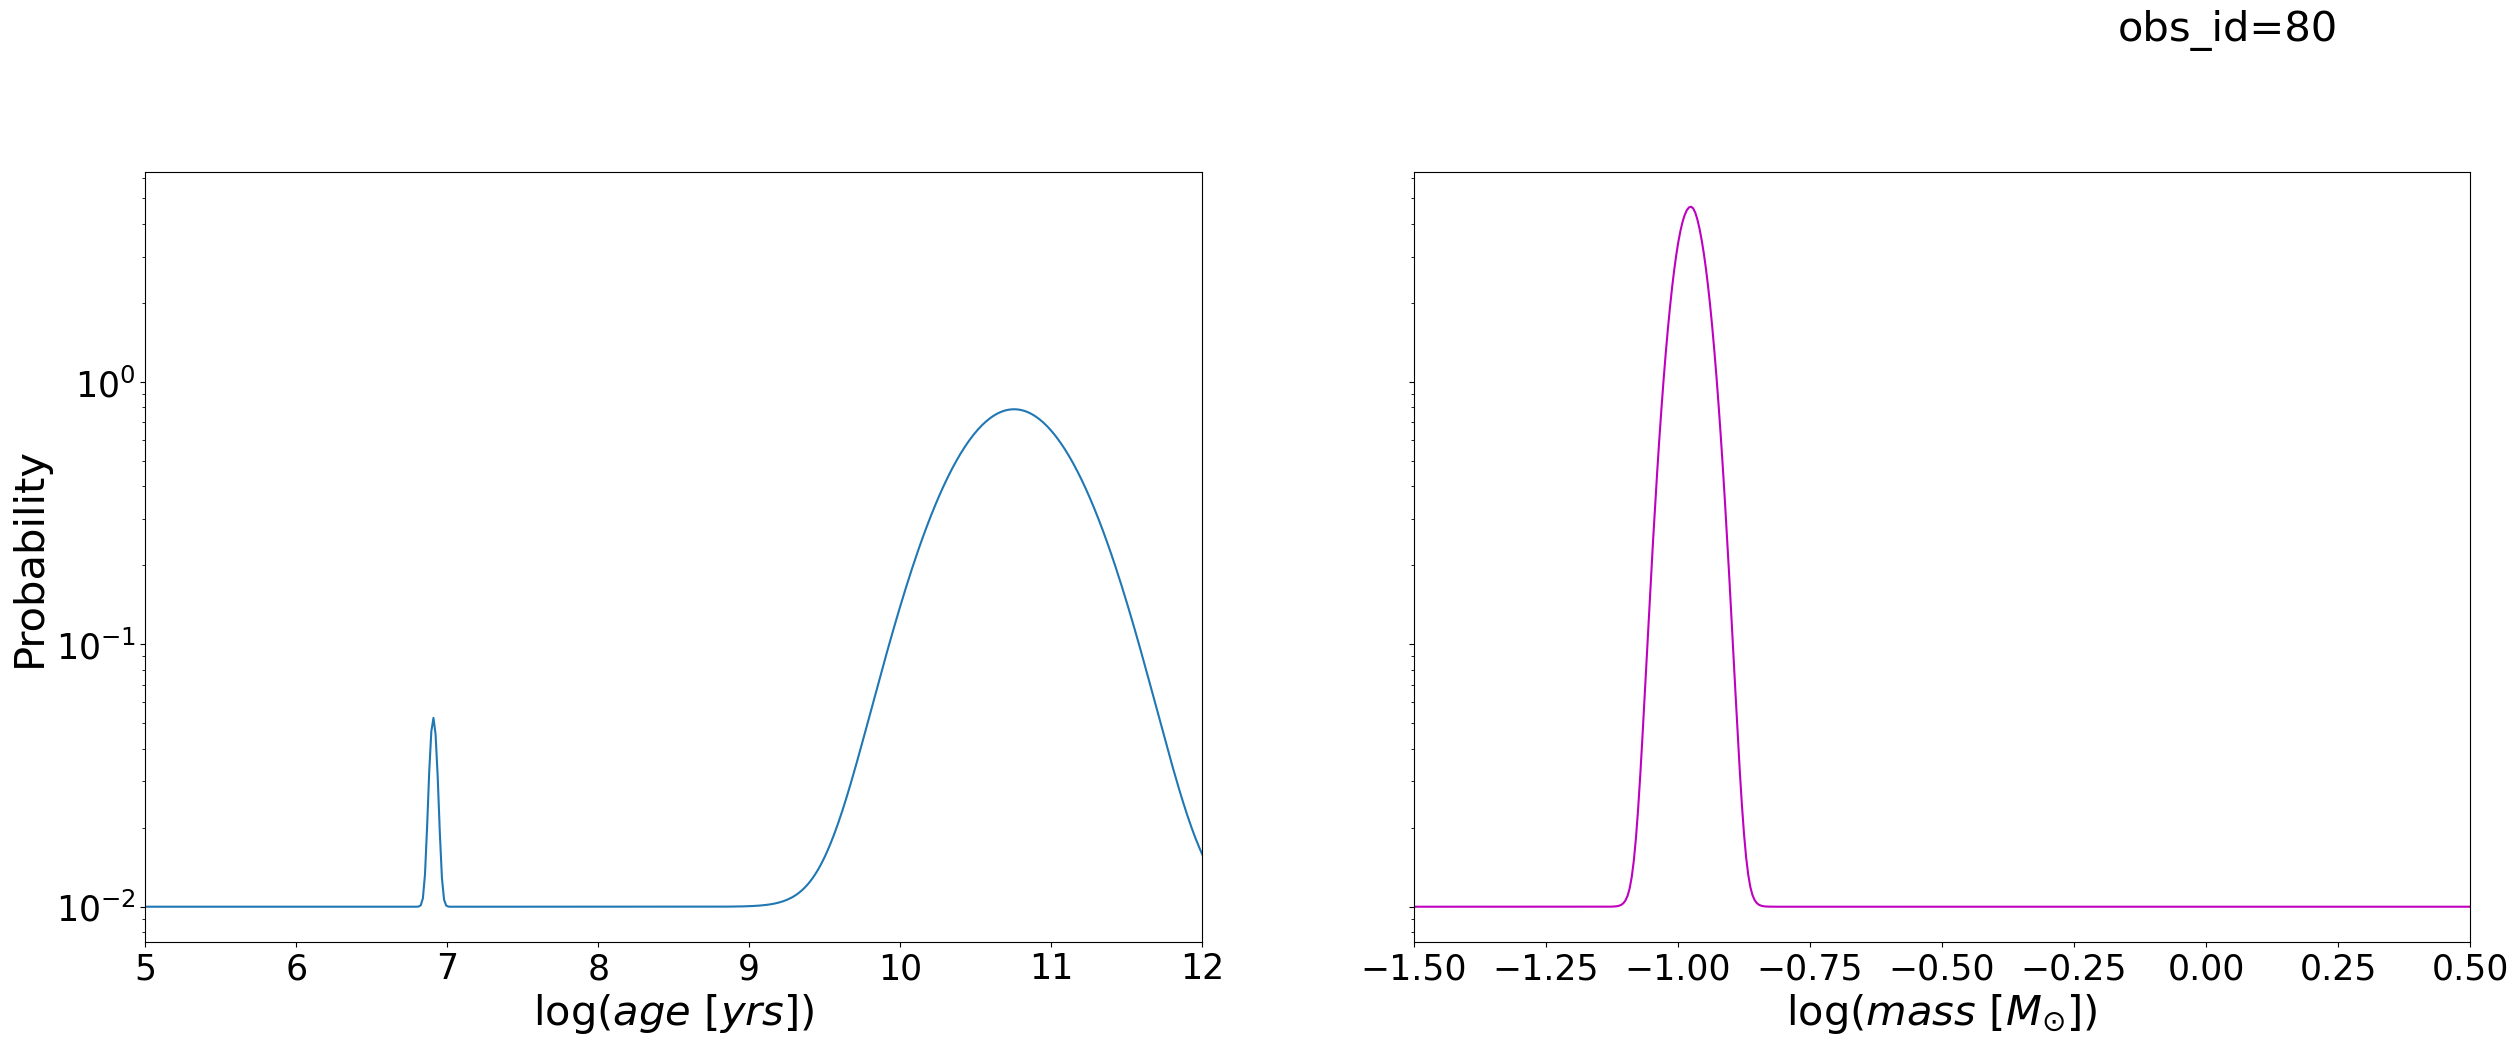

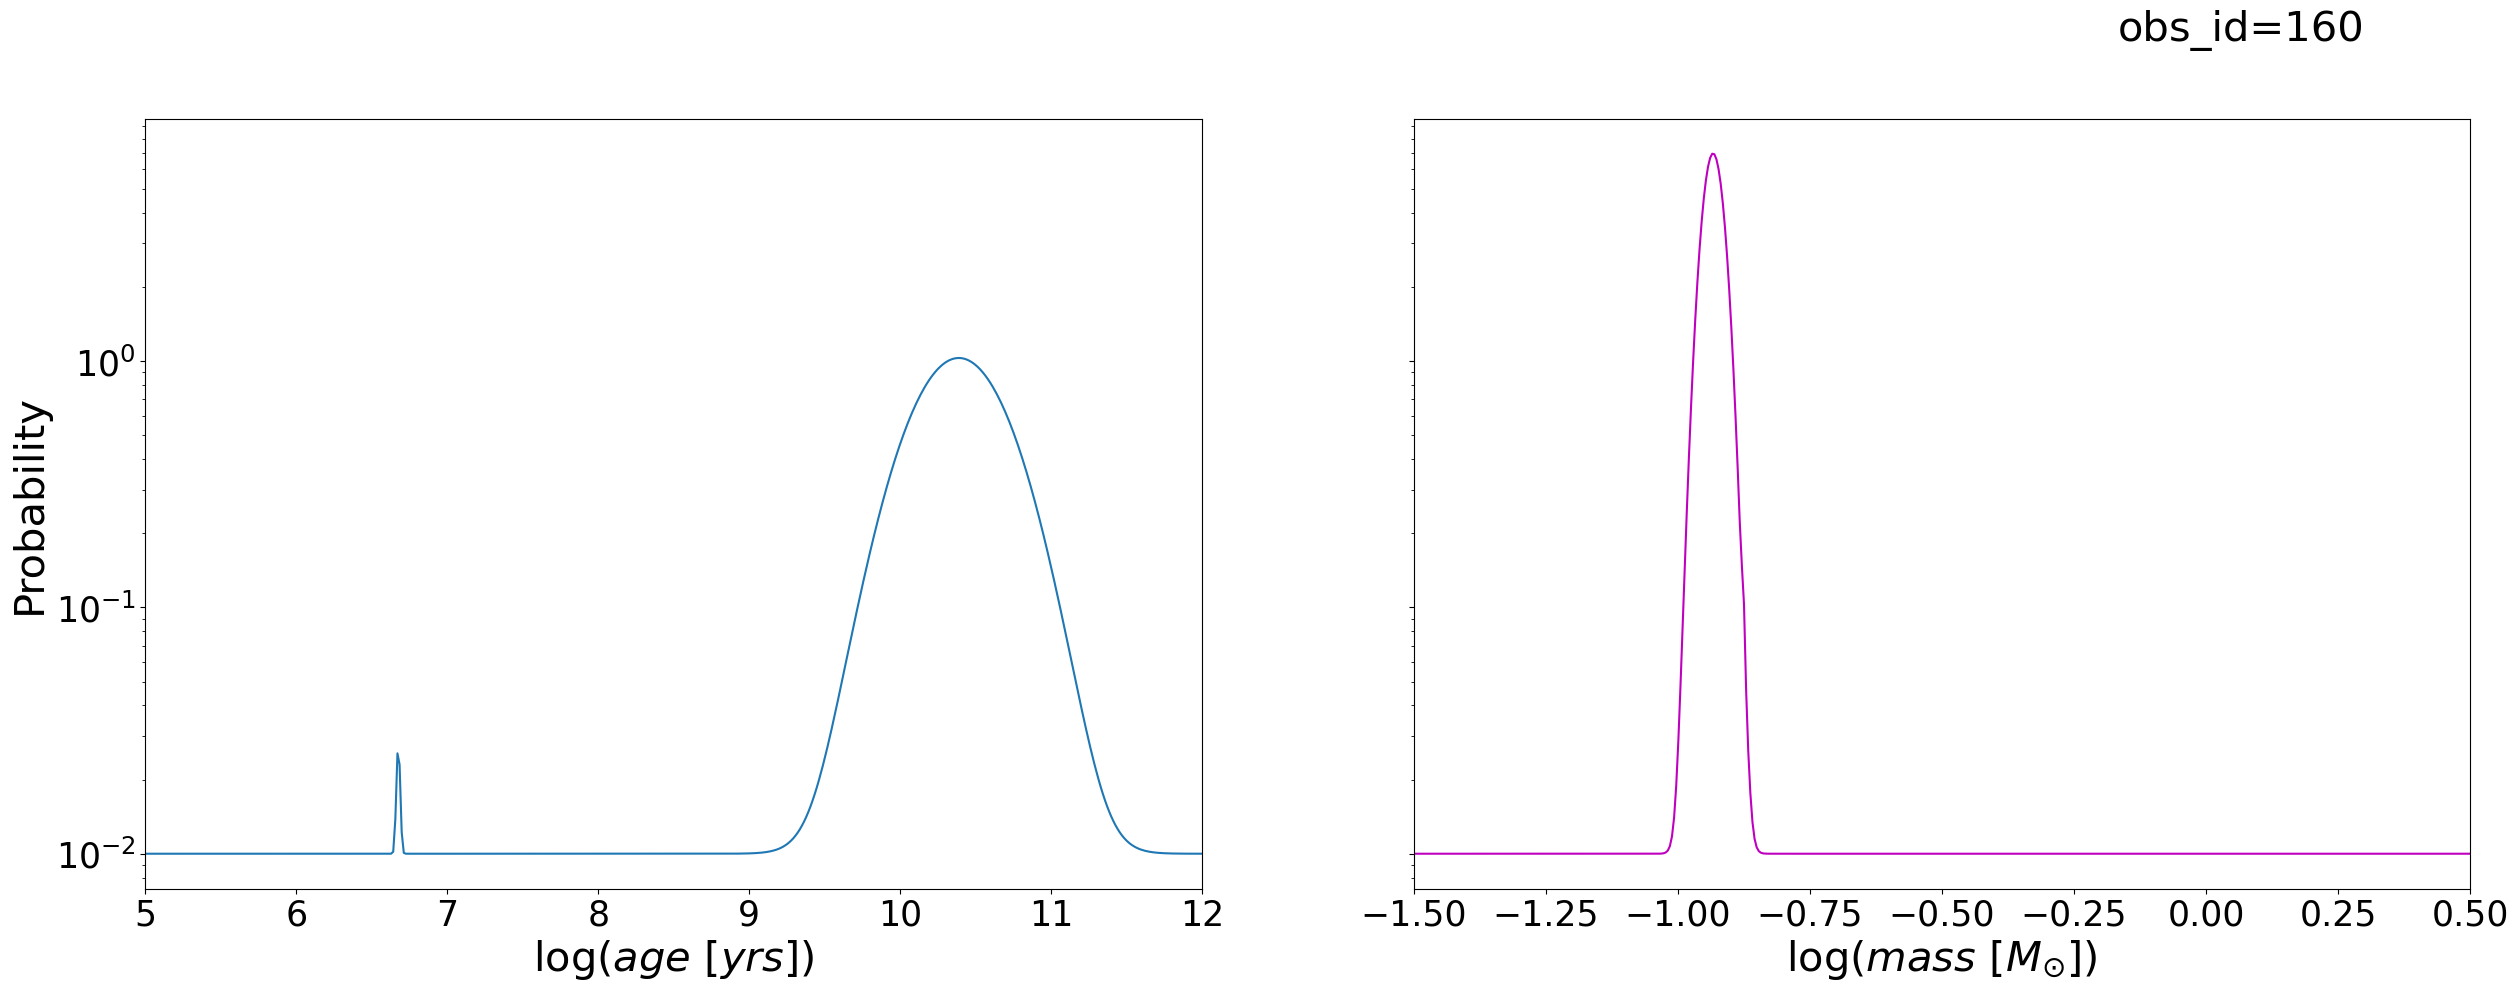

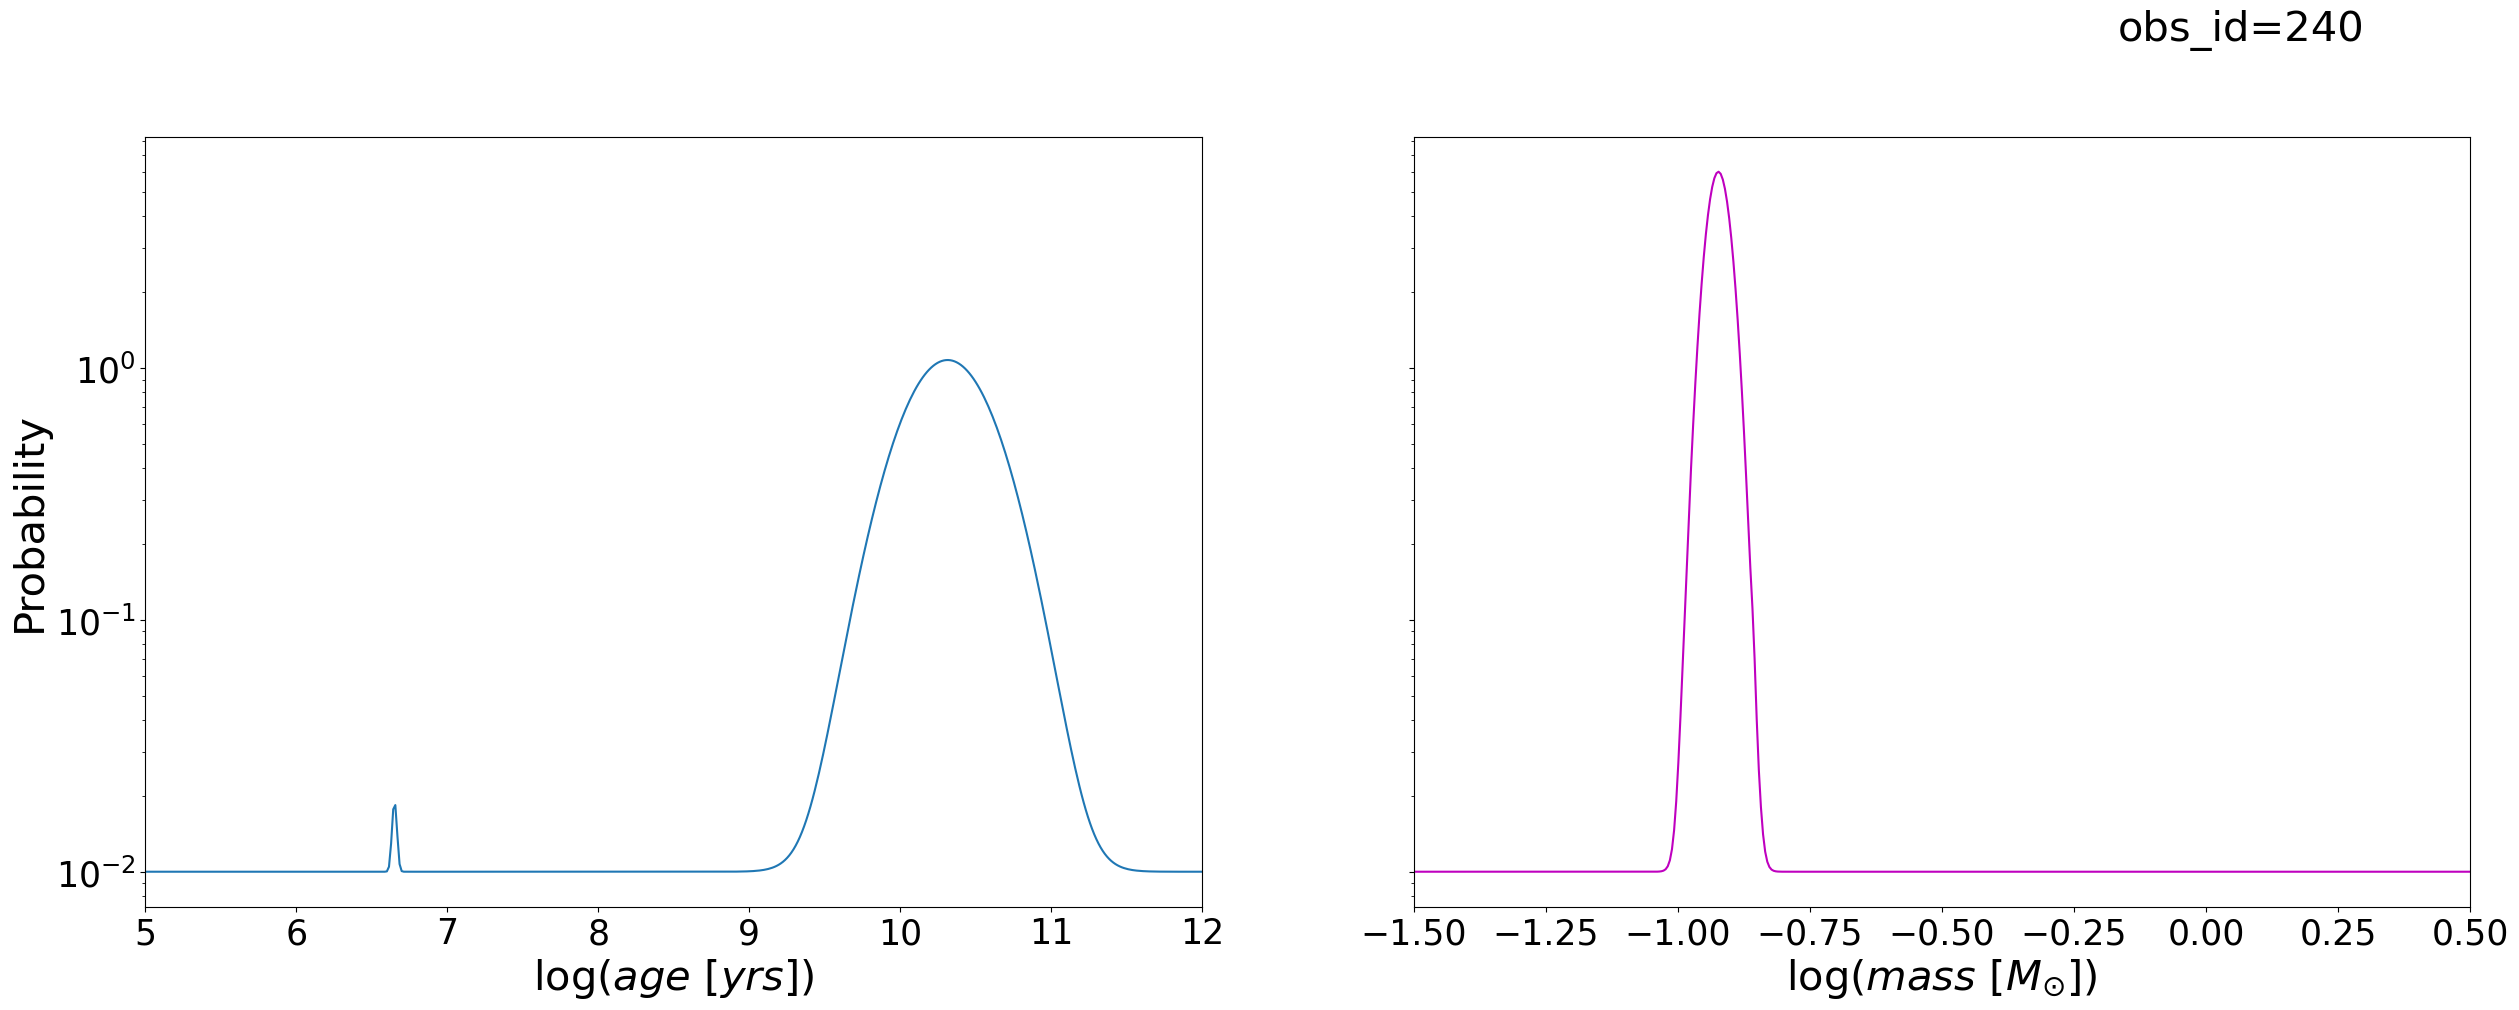

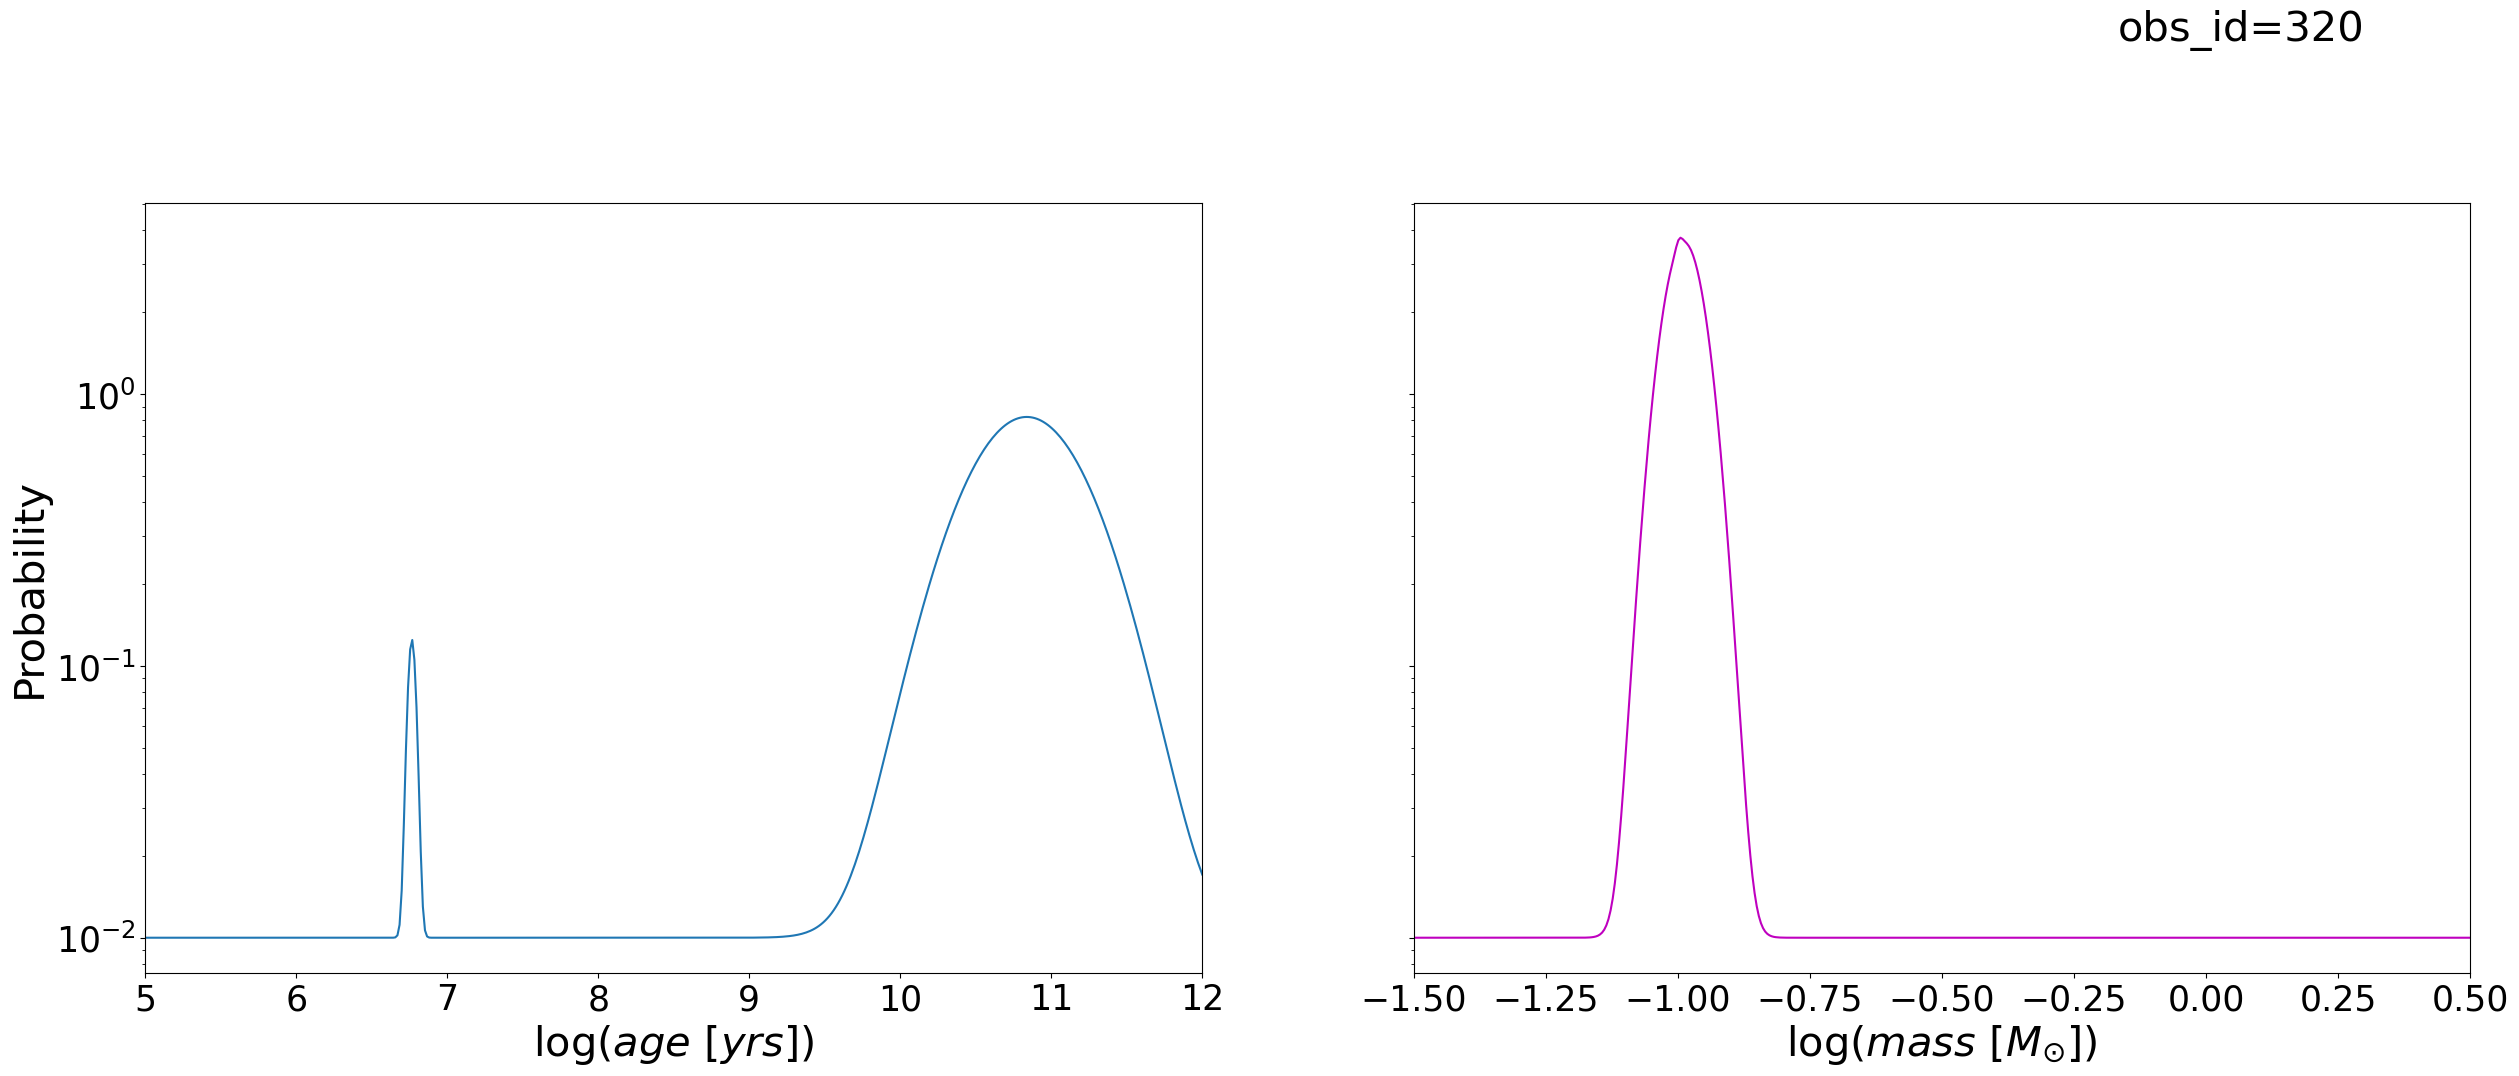

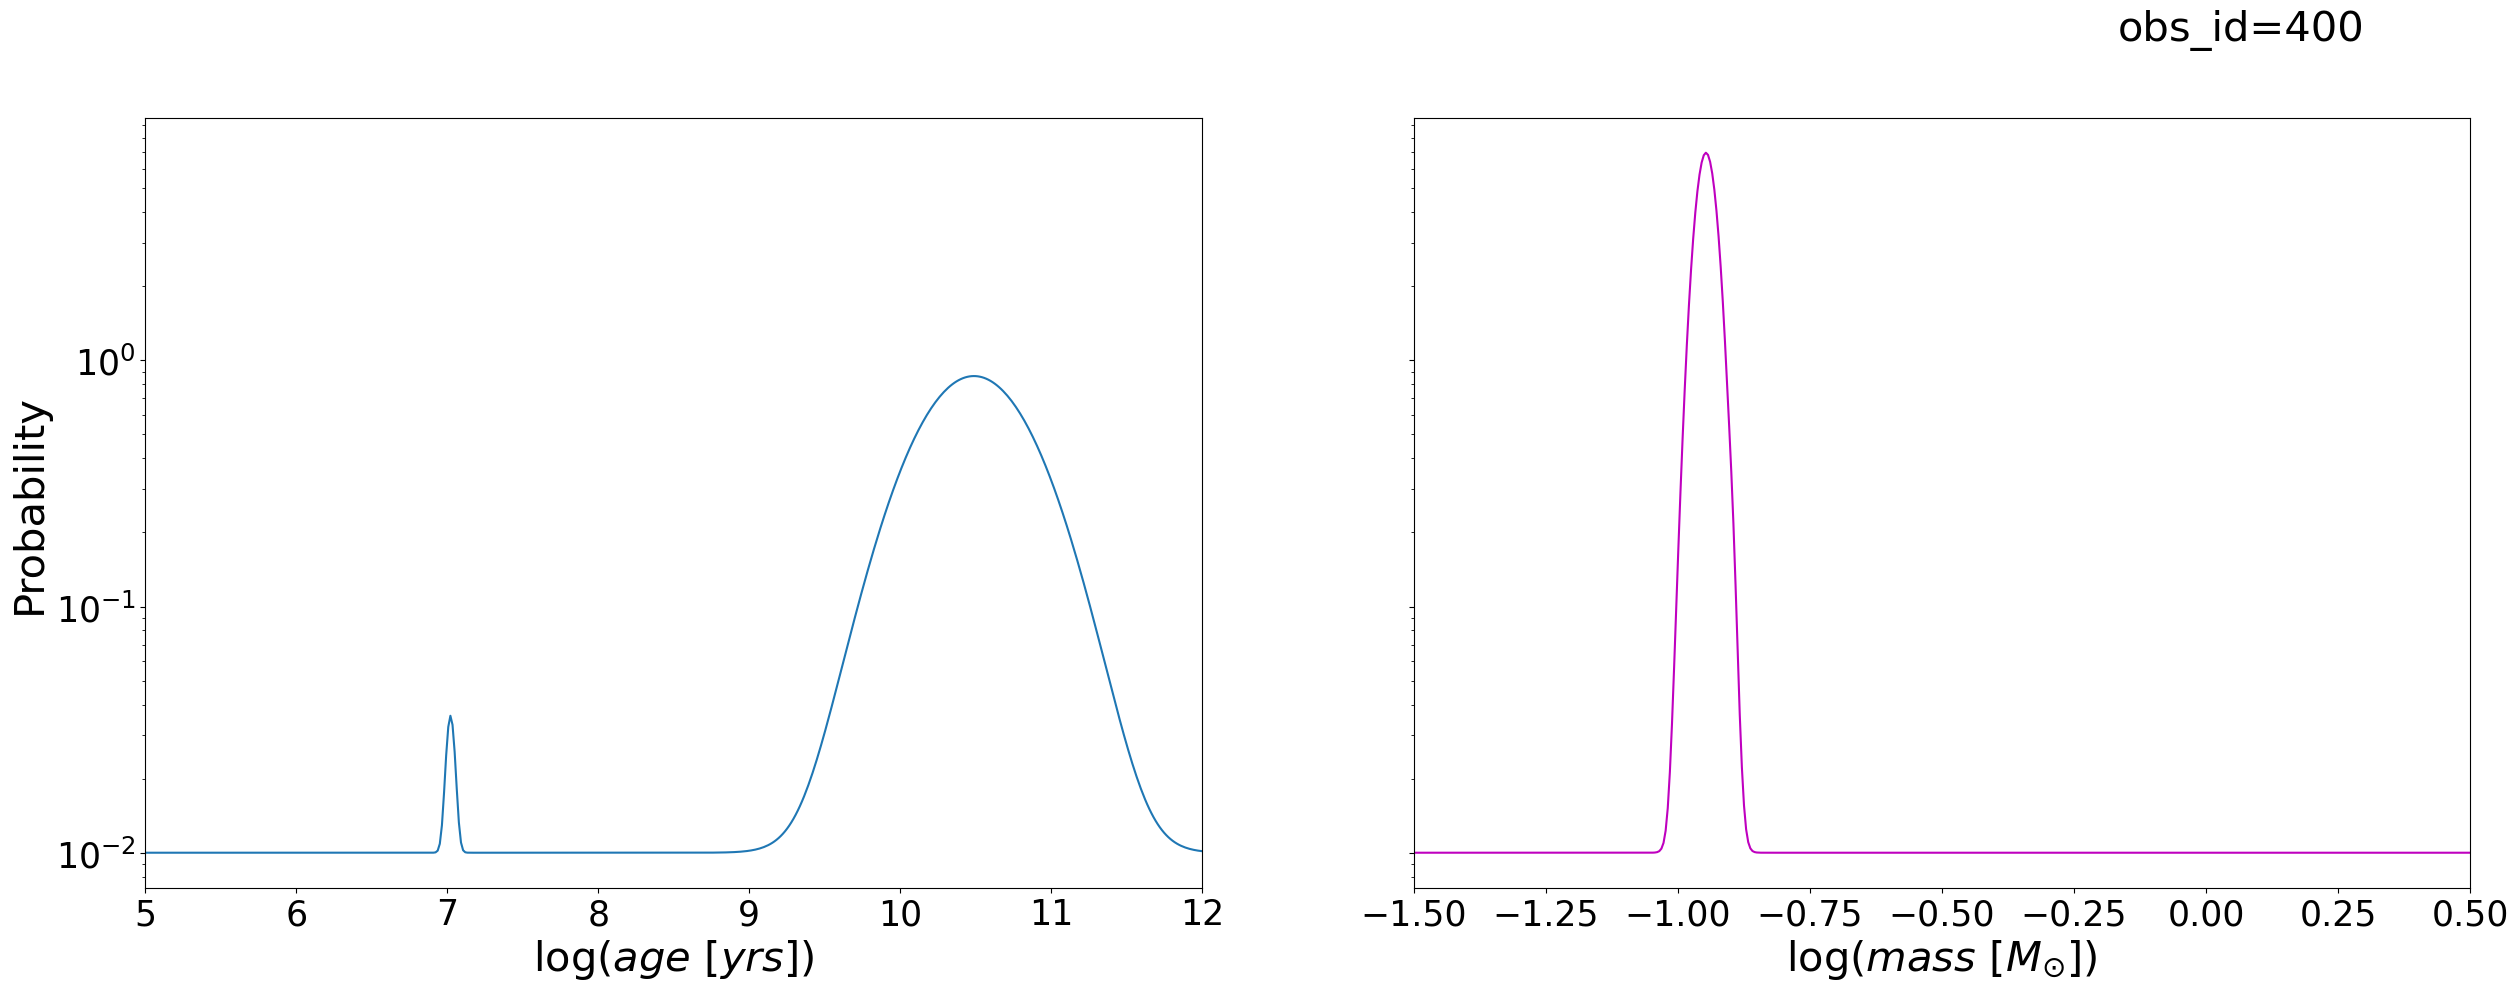

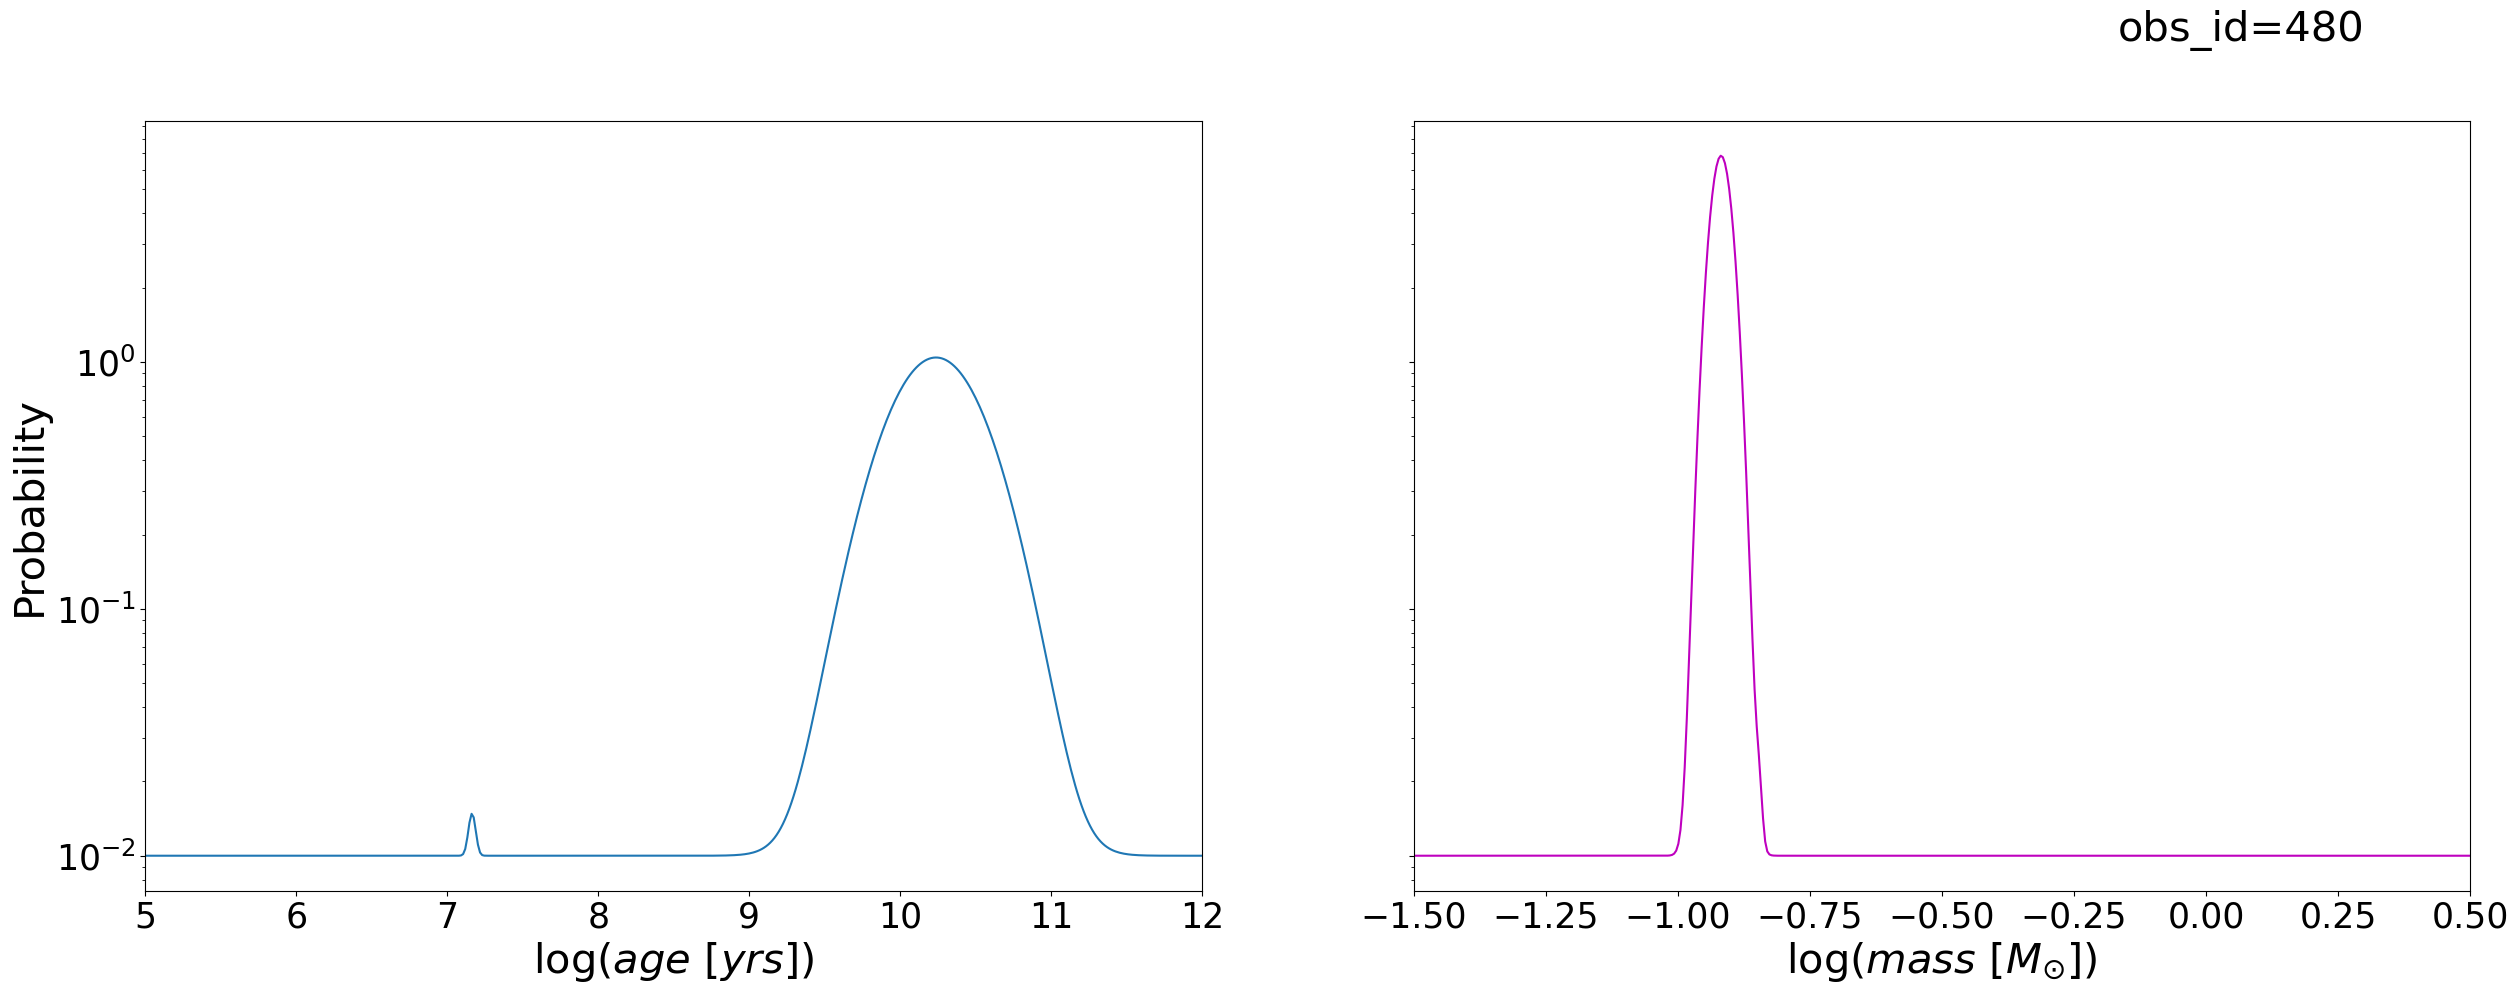

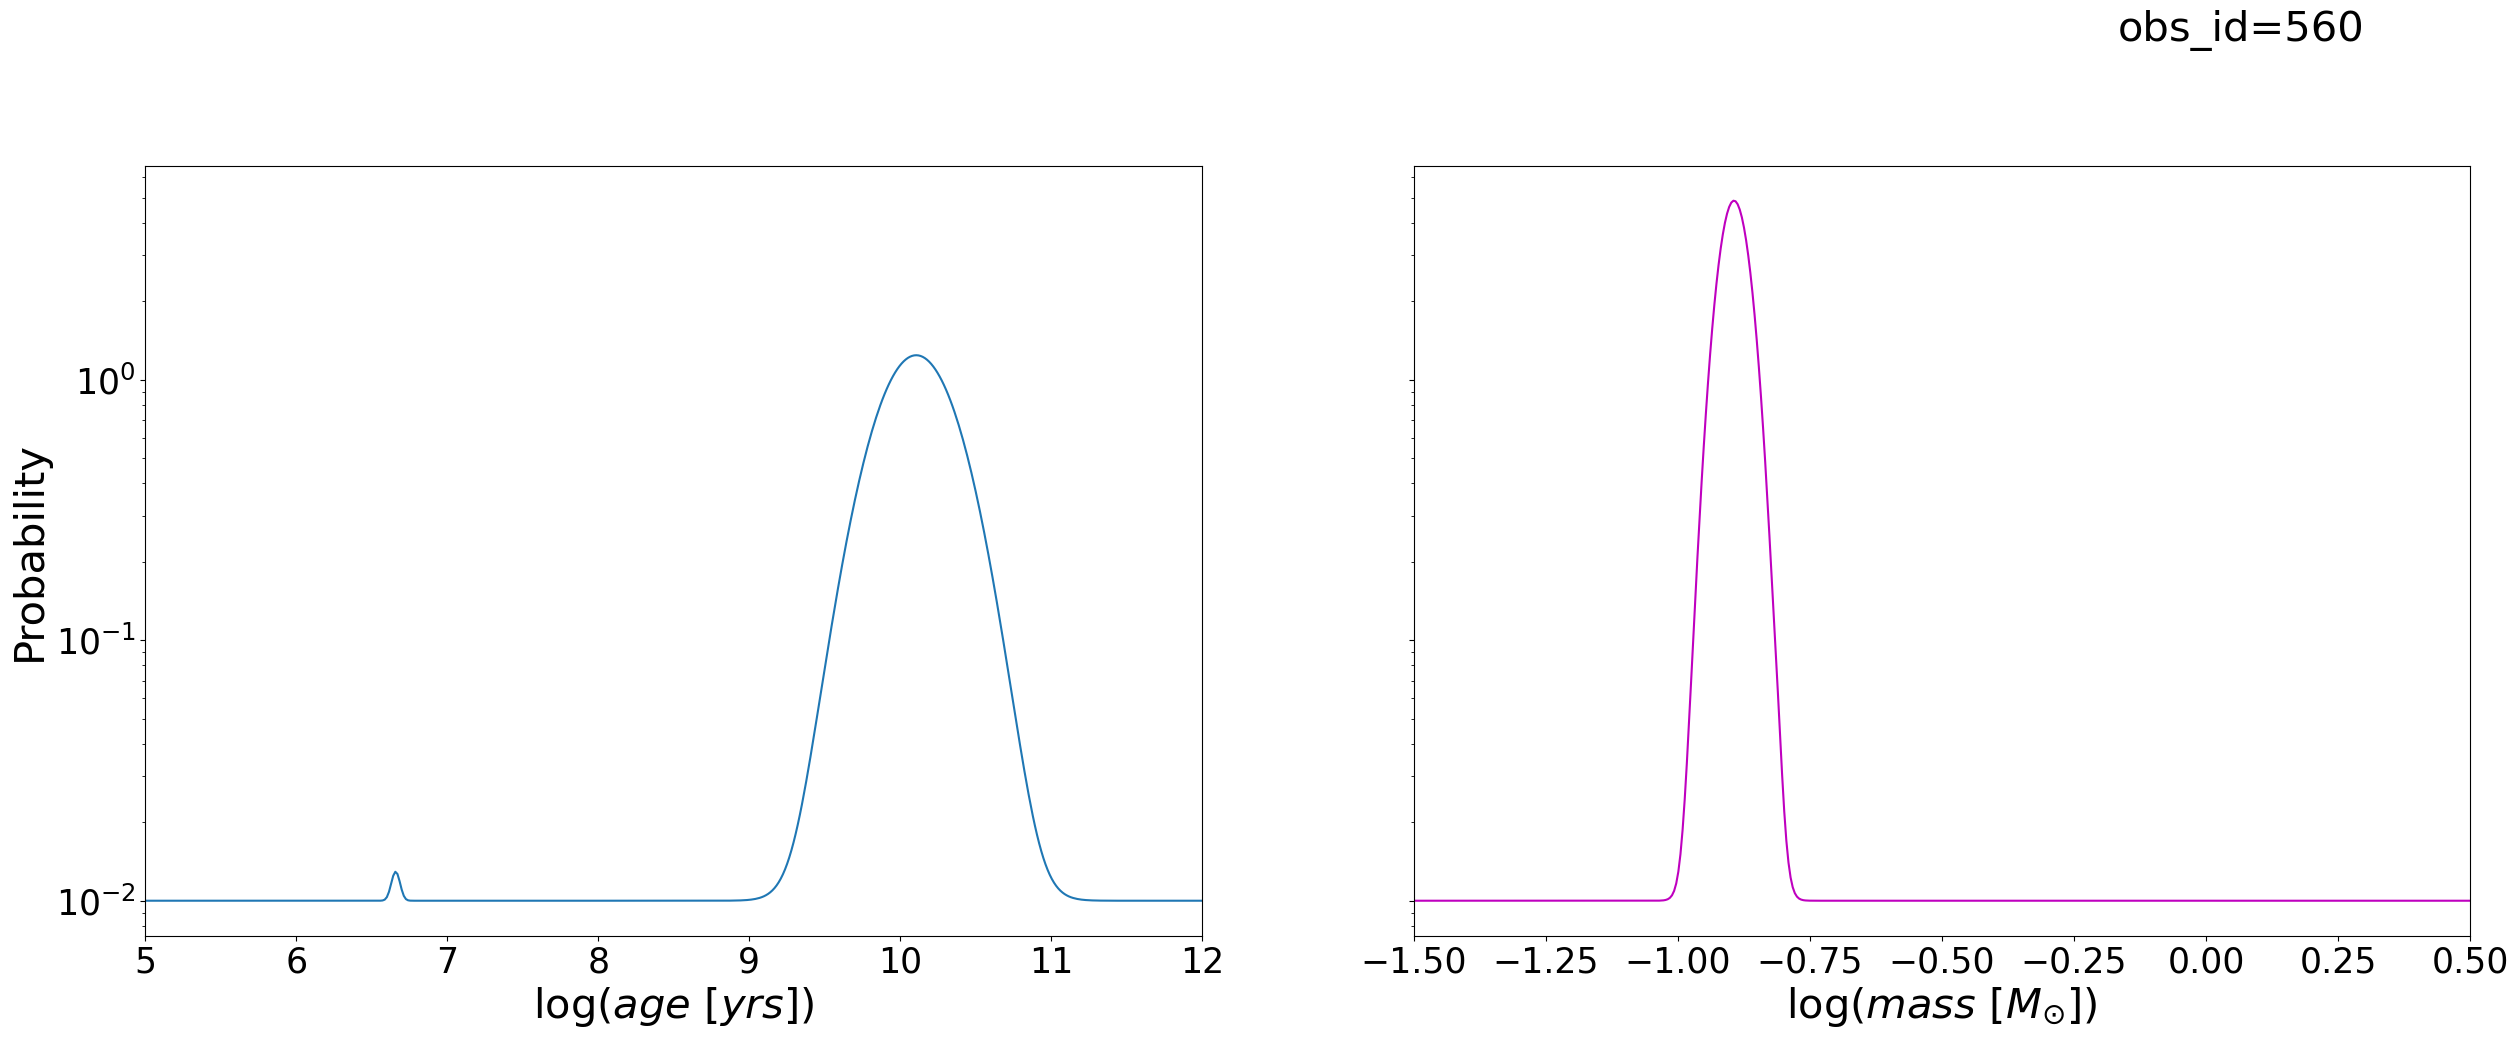

In [86]:
for i in range(0, data.shape[0], 80):
    st.plot_gaussian_posteriors(y_gaussian_posteriors, i, log_age_range=[5,12], log_mass_range=[-1.5,0.5])

## Load Data